In [1]:
import os, os.path
os.environ["CUDA_VISIBLE_DEVICES"]="0"
tf_device='/gpu:0'
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import tensorflow as tf
tf.get_logger().setLevel('INFO')
tf.keras.backend.floatx()
from collections import deque
import itertools
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from libs.utils import *
from libs.generate_boxes import *
from libs.dqn import *

num_episode = 30000
global_step = 0
tr_l, h_fill, tr_r,avg_loss_l,history_eps,used_boxes_eps  = [],[],[],[],[],[]
N_MDD = 8
K = 3
n_candidates = 3

num_max_boxes = N_MDD + 4
num_max_remain = num_max_boxes
print('num_max_boxes',num_max_boxes,'num_max_remain',num_max_remain)

bbox_size = [[20,20,20], [12,20,12],[10,10,10],[20,14,10],[16,15,18] ]
bbox_min_s = [3,3,1,3,3]
# bbox_size2matrix
bbox_type = [] #np.zeros((1, 20, 20))
for l,b,h in bbox_size:
    bbox = np.zeros((20,20))
    bbox[l:,:] = 20
    bbox[:,b:] = 20
    bbox[:l,:b] = 20-h
    bbox_type.append(bbox)
bbox_type = np.stack((bbox_type)) #(5, 20, 20)
#env = Bpp3DEnvMS(length = 20, breadth = 20, height = 20, bbox_type = bbox_type)
env = Bpp3DEnvMS(length = 10, breadth = 10, height = 10, bbox_type = bbox_type)
agent = DQNAgent( L=20, B=20, H=20, n_remains = num_max_remain, n_loading=K, lr=1e-4, exp_steps=19000, 
                 train_st = 1500, memory_len=2500, update_target_rate = 1000, net = 'DDQN_CNNDNN')

num_max_boxes 12 num_max_remain 12
distribution DDQN_CNNDNN


In [19]:
def sort_box(box_multi):
    new_box = []
    v_list = {}
    
    for i, box in enumerate(box_multi):
        v = box[0] * box[1] * box[2]
        v_list[i] = v
    
    v_list = dict(sorted(v_list.items(), key=lambda x:x[1]))
    
    for i in v_list.keys():
        new_box.append(box_multi[i])
    new_box = np.array(new_box)
    
    return new_box

In [23]:
bbox_idx_actual = np.random.choice(5)
boxes_multi,gt_pos = generation_3dbox(case_size=[bbox_size[bbox_idx_actual]], min_s = bbox_min_s[bbox_idx_actual], N_mdd=N_MDD)
boxes_multi

[array([[20,  7,  5],
        [ 5,  7,  5],
        [ 5,  7,  5],
        [ 5,  7,  5],
        [ 5,  7,  5],
        [ 5,  7,  5],
        [20,  7,  5],
        [ 5,  7,  5],
        [ 5,  7,  5],
        [ 5,  7,  5]])]

In [24]:
new_box = sort_box(boxes_multi[0])
new_box

array([[ 5,  7,  5],
       [ 5,  7,  5],
       [ 5,  7,  5],
       [ 5,  7,  5],
       [ 5,  7,  5],
       [ 5,  7,  5],
       [ 5,  7,  5],
       [ 5,  7,  5],
       [20,  7,  5],
       [20,  7,  5]])

In [15]:
sorted(v_list.items(), key=lambda x:x[1])

[(2, 180),
 (3, 180),
 (4, 180),
 (5, 180),
 (0, 240),
 (1, 240),
 (6, 480),
 (8, 480),
 (7, 720)]

In [2]:
for e in range(num_episode):
    st=time.time()
    done = False
    step = 0

    bbox_idx_actual = np.random.choice(5)
    boxes_multi,gt_pos = generation_3dbox(case_size=[bbox_size[bbox_idx_actual]], min_s = bbox_min_s[bbox_idx_actual], N_mdd=N_MDD)
    
    boxes_multi = sort_box(boxes_multi[0])
    
    boxes_all = np.array(boxes_multi)[0].copy()
    r_boxes = boxes_all.copy() #single case
    boxes_idx = np.arange(len(boxes_all))
    loaded_idx = []
    used_boxes, pred_pos = [],[]
    
    if e>35000:
        agent.epsilon = 0
    if agent.epsilon > agent.epsilon_end and len(agent.memory)>=agent.train_start:
        agent.epsilon -= agent.epsilon_decay_step
    
    in_state = np.array( [ np.concatenate([np.zeros((env.length,env.breadth,2)), b[...,np.newaxis]], axis=-1) for b in bbox_type] )
    in_state = (in_state/env.height).astype(np.float32)
    loading_loc_c = np.zeros((len(bbox_type), env.length, env.breadth, K))
    in_loading = np.zeros((len(bbox_type), env.length, env.breadth, K))
    in_r_boxes = padding_boxes(r_boxes, num_max_remain).astype('int')
    in_r_boxes = padding_boxes(r_boxes, num_max_remain).astype('int')
    r_mat_c = [size2matrix(j, env.length, env.breadth) for j in in_r_boxes]
    r_mat_c = [r_mat_c] * len(bbox_type)
    r_mat_c = (np.array(r_mat_c)/env.height).astype(np.float32)
    in_r_boxes = r_mat_c.transpose((0,2,3,1))

    action_idx = agent.get_action(in_state, loading_loc_c, in_r_boxes, in_loading)
    env.reset(action_idx)
    history = [in_state[action_idx]]
    h_load = [loading_loc_c[action_idx]]
    h_remain_size = [in_r_boxes[action_idx]]
    h_load_size = [in_loading[action_idx]]
    t_history, t_load, t_remain_size, t_load_size = [],[],[],[]
    
    while not done:
        state = env.container_s.copy()
        state_h = env.container_h.copy()
        global_step += 1
        step += 1

        k = min(K, len(r_boxes))
        selected, selected_idx = cbn_select_boxes(r_boxes[:n_candidates],boxes_idx[:n_candidates], k)
        s_order, s_order_idx = get_selected_order(selected, selected_idx, k)
        order_idx_c, num_loading_c, loading_idx_c, loading_size_c, loading_xyz_c, loading_loc_c, next_state_c, next_h_c  =\
            get_selected_location(s_order, s_order_idx, state, state_h, env.height,K)

        if len(order_idx_c) ==0:
            action_idx = 0
        else:
            in_state, in_r_boxes, in_loading = \
                raw2input(state, state_h, env.bbox, r_boxes, num_max_remain, K, s_order[order_idx_c], env.height) 
            action_idx = agent.get_action(in_state, np.array(loading_loc_c), in_r_boxes, in_loading)

        if step==1:
            if len(order_idx_c) == 0:
                t_history.append(np.stack([state,state_h,env.bbox],axis=-1).reshape((1, env.length, env.breadth, 3)))
                t_load.append(np.zeros((1, env.length, env.breadth, K)) )
                t_remain_size.append(np.zeros((1, env.length, env.breadth, num_max_remain)))
                t_load_size.append(np.zeros((1, env.length, env.breadth, K)))
            else:
                t_history.append([in_state[action_idx]])
                t_load.append(np.array([loading_loc_c[action_idx]]))
                t_remain_size.append([in_r_boxes[action_idx]])
                t_load_size.append([in_loading[action_idx]])
        
        if len(order_idx_c) == 0:
            r_boxes = get_remain(r_boxes[:n_candidates], r_boxes)
            boxes_idx = boxes_idx[n_candidates:]
        else:
            env.step(next_state_c[action_idx], next_h_c[action_idx])

            order_idx = order_idx_c[action_idx]
            r_boxes = get_remain(s_order[order_idx], r_boxes)
            loading_idx = loading_idx_c[action_idx]
            loaded_idx += loading_idx
            boxes_idx =np.setdiff1d(boxes_idx, s_order_idx[order_idx])

            used_boxes = used_boxes + loading_size_c[action_idx]
            pred_pos = pred_pos + loading_xyz_c[action_idx]
        
        if len(r_boxes) == 0 or np.sum(env.container_h != env.height) == 0: 
            done = True
        
        if len(num_loading_c) > 1 or done:

            history.append(in_state[action_idx])
            h_load.append(loading_loc_c[action_idx])
            h_remain_size.append(in_r_boxes[action_idx])
            h_load_size.append(in_loading[action_idx])

            t_state = next_state_c[action_idx].copy()
            t_state_h = next_h_c[action_idx].copy() 
            if done:
                in_t_history = np.stack([t_state,t_state_h, env.bbox],axis=-1).reshape((1, env.length, env.breadth, 3))
                in_t_history = in_t_history/env.height
                loading_loc_c = np.zeros((1, env.length, env.breadth, K)) 
                in_t_remains = np.zeros((1, env.length, env.breadth, num_max_remain))
                in_t_loading = np.zeros((1, env.length, env.breadth, K))
            else:
                k = min(K, len(r_boxes))
                selected,tmpidx = cbn_select_boxes(r_boxes[:n_candidates], np.arange(len(r_boxes[:n_candidates])), k)
                s_order,tmpidx = get_selected_order(selected, tmpidx, k)
                order_idx_c, num_loading_c, loading_idx_c, loading_size_c, loading_xyz_c, loading_loc_c, next_state_c, next_h_c  =\
                    get_selected_location(s_order, tmpidx, t_state, t_state_h, env.height, K)
                in_t_history, in_t_remains, in_t_loading = \
                    raw2input(t_state, t_state_h, env.bbox, r_boxes, num_max_remain, K, s_order[order_idx_c], env.height)
            t_history.append(in_t_history)
            t_load.append(np.array(loading_loc_c))
            t_remain_size.append(in_t_remains)
            t_load_size.append(in_t_loading)
                
        
        if done:
            excluded = get_remain(used_boxes, boxes_all)
            terminal_reward = env.terminal_reward() - (np.sum(excluded[:,0]*excluded[:,1]*excluded[:,2])/env.vol_bbox())  
            tr_l.append(terminal_reward)
            h_fill.append(env.terminal_reward())
            a_repeate = 1
            is_last = False 
            N = len(history)
            for i in range(N):
                if i == N-1: is_last=True
                reward = terminal_reward
                for a in range(a_repeate):
                    agent.append_sample(history[i], h_load[i], h_remain_size[i], h_load_size[i], reward, is_last,
                                        t_history[i], t_load[i], t_remain_size[i], t_load_size[i])
            if global_step > agent.train_start:
                agent.draw_tensorboard(terminal_reward, env.terminal_reward(), step, e)
                
        if len(agent.memory) >= agent.train_start:
            agent.train_model()
            if global_step % agent.update_target_rate == 0:
                agent.update_target_model()
            avg_loss_l.append(agent.avg_loss/float(step))
    

    log = "=====episode: {:5d} | ".format(e)
    log += "memory length: {:5d} | ".format(len(agent.memory))
    log += "epsilon: {:.3f} | ".format(agent.epsilon)
    log += "reward(): {:.3f}, {:.3f}| ".format(env.terminal_reward(), terminal_reward)
    log += "avg loss : {:6f} ".format(agent.avg_loss / float(step))
    log += "time: {:.3f}".format(time.time()-st)
    print(log)
    agent.avg_q_max, agent.avg_loss = 0, 0
    
    # 1000 에피소드마다 모델 저장
    if e % 1000 == 0:
        agent.model.save_weights("save_model/model", save_format="tf")
    
    if (len(used_boxes)>0)&(np.sum(boxes_all[loaded_idx] != used_boxes) !=0):
        print('error')
        break

=====episode:     0 | memory length:     3 | epsilon: 1.000 | reward(): 0.350, 0.350| avg loss : 0.000000 time: 0.034
=====episode:     1 | memory length:     6 | epsilon: 1.000 | reward(): 0.500, -0.500| avg loss : 0.000000 time: 0.012
=====episode:     2 | memory length:    10 | epsilon: 1.000 | reward(): 0.800, 0.600| avg loss : 0.000000 time: 0.035
=====episode:     3 | memory length:    14 | epsilon: 1.000 | reward(): 0.360, 0.360| avg loss : 0.000000 time: 0.025
=====episode:     4 | memory length:    16 | epsilon: 1.000 | reward(): 0.000, -1.500| avg loss : 0.000000 time: 0.010
=====episode:     5 | memory length:    20 | epsilon: 1.000 | reward(): 1.000, 1.000| avg loss : 0.000000 time: 0.024
=====episode:     6 | memory length:    24 | epsilon: 1.000 | reward(): 0.231, 0.231| avg loss : 0.000000 time: 0.034
=====episode:     7 | memory length:    27 | epsilon: 1.000 | reward(): 0.714, -1.429| avg loss : 0.000000 time: 0.011
=====episode:     8 | memory length:    30 | epsilon:

C:\Users\vfgtr\anaconda3\envs\RL\lib\site-packages\ipykernel_launcher.py:166: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


=====episode:    14 | memory length:    50 | epsilon: 1.000 | reward(): 0.583, 0.500| avg loss : 0.000000 time: 0.033
=====episode:    15 | memory length:    52 | epsilon: 1.000 | reward(): 0.000, -2.880| avg loss : 0.000000 time: 0.009
=====episode:    16 | memory length:    55 | epsilon: 1.000 | reward(): 1.000, 1.000| avg loss : 0.000000 time: 0.015
=====episode:    17 | memory length:    58 | epsilon: 1.000 | reward(): 0.375, -0.750| avg loss : 0.000000 time: 0.010
=====episode:    18 | memory length:    61 | epsilon: 1.000 | reward(): 0.125, 0.125| avg loss : 0.000000 time: 0.019
=====episode:    19 | memory length:    65 | epsilon: 1.000 | reward(): 0.347, 0.347| avg loss : 0.000000 time: 0.032
=====episode:    20 | memory length:    69 | epsilon: 1.000 | reward(): 1.000, 1.000| avg loss : 0.000000 time: 0.021
=====episode:    21 | memory length:    72 | epsilon: 1.000 | reward(): 0.324, 0.000| avg loss : 0.000000 time: 0.017
=====episode:    22 | memory length:    75 | epsilon: 

=====episode:    85 | memory length:   283 | epsilon: 1.000 | reward(): 0.125, 0.125| avg loss : 0.000000 time: 0.032
=====episode:    86 | memory length:   288 | epsilon: 1.000 | reward(): 0.750, 0.500| avg loss : 0.000000 time: 0.031
=====episode:    87 | memory length:   292 | epsilon: 1.000 | reward(): 0.350, 0.350| avg loss : 0.000000 time: 0.048
=====episode:    88 | memory length:   294 | epsilon: 1.000 | reward(): 0.000, -4.320| avg loss : 0.000000 time: 0.009
=====episode:    89 | memory length:   296 | epsilon: 1.000 | reward(): 0.000, -8.000| avg loss : 0.000000 time: 0.008
=====episode:    90 | memory length:   298 | epsilon: 1.000 | reward(): 0.000, -1.852| avg loss : 0.000000 time: 0.009
=====episode:    91 | memory length:   300 | epsilon: 1.000 | reward(): 0.000, -2.857| avg loss : 0.000000 time: 0.008
=====episode:    92 | memory length:   303 | epsilon: 1.000 | reward(): 0.111, -0.444| avg loss : 0.000000 time: 0.023
=====episode:    93 | memory length:   306 | epsilo

=====episode:   155 | memory length:   514 | epsilon: 1.000 | reward(): 0.714, -1.429| avg loss : 0.000000 time: 0.015
=====episode:   156 | memory length:   516 | epsilon: 1.000 | reward(): 0.179, -2.500| avg loss : 0.000000 time: 0.010
=====episode:   157 | memory length:   518 | epsilon: 1.000 | reward(): 0.000, -2.778| avg loss : 0.000000 time: 0.006
=====episode:   158 | memory length:   522 | epsilon: 1.000 | reward(): 1.000, 1.000| avg loss : 0.000000 time: 0.024
=====episode:   159 | memory length:   525 | epsilon: 1.000 | reward(): 0.375, -0.750| avg loss : 0.000000 time: 0.019
=====episode:   160 | memory length:   527 | epsilon: 1.000 | reward(): 0.800, -6.400| avg loss : 0.000000 time: 0.009
=====episode:   161 | memory length:   531 | epsilon: 1.000 | reward(): 1.000, 1.000| avg loss : 0.000000 time: 0.026
=====episode:   162 | memory length:   536 | epsilon: 1.000 | reward(): 0.174, -2.431| avg loss : 0.000000 time: 0.031
=====episode:   163 | memory length:   538 | epsil

=====episode:   229 | memory length:   767 | epsilon: 1.000 | reward(): 0.694, -1.389| avg loss : 0.000000 time: 0.012
=====episode:   230 | memory length:   769 | epsilon: 1.000 | reward(): 1.000, 1.000| avg loss : 0.000000 time: 0.007
=====episode:   231 | memory length:   772 | epsilon: 1.000 | reward(): 0.231, 0.231| avg loss : 0.000000 time: 0.015
=====episode:   232 | memory length:   776 | epsilon: 1.000 | reward(): 1.000, 1.000| avg loss : 0.000000 time: 0.026
=====episode:   233 | memory length:   778 | epsilon: 1.000 | reward(): 0.000, -1.852| avg loss : 0.000000 time: 0.008
=====episode:   234 | memory length:   780 | epsilon: 1.000 | reward(): 0.000, -1.543| avg loss : 0.000000 time: 0.006
=====episode:   235 | memory length:   784 | epsilon: 1.000 | reward(): 1.000, 1.000| avg loss : 0.000000 time: 0.038
=====episode:   236 | memory length:   787 | epsilon: 1.000 | reward(): 0.480, -1.920| avg loss : 0.000000 time: 0.019
=====episode:   237 | memory length:   791 | epsilon

=====episode:   302 | memory length:   999 | epsilon: 1.000 | reward(): 0.750, 0.500| avg loss : 0.000000 time: 0.031
=====episode:   303 | memory length:  1002 | epsilon: 1.000 | reward(): 1.000, 1.000| avg loss : 0.000000 time: 0.022
=====episode:   304 | memory length:  1006 | epsilon: 1.000 | reward(): 0.800, 0.600| avg loss : 0.000000 time: 0.021
=====episode:   305 | memory length:  1009 | epsilon: 1.000 | reward(): 0.833, 0.667| avg loss : 0.000000 time: 0.021
=====episode:   306 | memory length:  1013 | epsilon: 1.000 | reward(): 0.700, -1.400| avg loss : 0.000000 time: 0.020
=====episode:   307 | memory length:  1016 | epsilon: 1.000 | reward(): 0.648, 0.648| avg loss : 0.000000 time: 0.015
=====episode:   308 | memory length:  1019 | epsilon: 1.000 | reward(): 1.000, 1.000| avg loss : 0.000000 time: 0.011
=====episode:   309 | memory length:  1023 | epsilon: 1.000 | reward(): 0.540, 0.540| avg loss : 0.000000 time: 0.023
=====episode:   310 | memory length:  1027 | epsilon: 1

=====episode:   378 | memory length:  1254 | epsilon: 1.000 | reward(): 0.357, 0.357| avg loss : 0.000000 time: 0.025
=====episode:   379 | memory length:  1258 | epsilon: 1.000 | reward(): 0.125, 0.125| avg loss : 0.000000 time: 0.054
=====episode:   380 | memory length:  1260 | epsilon: 1.000 | reward(): 0.000, -4.320| avg loss : 0.000000 time: 0.006
=====episode:   381 | memory length:  1264 | epsilon: 1.000 | reward(): 0.648, 0.648| avg loss : 0.000000 time: 0.026
=====episode:   382 | memory length:  1266 | epsilon: 1.000 | reward(): 0.000, -1.500| avg loss : 0.000000 time: 0.007
=====episode:   383 | memory length:  1270 | epsilon: 1.000 | reward(): 0.343, -0.343| avg loss : 0.000000 time: 0.037
=====episode:   384 | memory length:  1274 | epsilon: 1.000 | reward(): 0.347, 0.347| avg loss : 0.000000 time: 0.050
=====episode:   385 | memory length:  1277 | epsilon: 1.000 | reward(): 0.700, -1.400| avg loss : 0.000000 time: 0.016
=====episode:   386 | memory length:  1280 | epsilon

=====episode:   452 | memory length:  1501 | epsilon: 1.000 | reward(): 0.764, -1.250| avg loss : 1.324810 time: 2.146
=====episode:   453 | memory length:  1505 | epsilon: 1.000 | reward(): 0.350, 0.350| avg loss : 3.967252 time: 0.325
=====episode:   454 | memory length:  1508 | epsilon: 1.000 | reward(): 0.083, -0.500| avg loss : 3.950062 time: 0.285
=====episode:   455 | memory length:  1512 | epsilon: 1.000 | reward(): 0.257, -0.514| avg loss : 3.946932 time: 0.293
=====episode:   456 | memory length:  1515 | epsilon: 1.000 | reward(): 0.480, -3.360| avg loss : 3.935409 time: 0.192
=====episode:   457 | memory length:  1517 | epsilon: 1.000 | reward(): 0.000, -1.852| avg loss : 3.915158 time: 0.241
=====episode:   458 | memory length:  1519 | epsilon: 1.000 | reward(): 0.000, -2.857| avg loss : 3.928920 time: 0.189
=====episode:   459 | memory length:  1521 | epsilon: 1.000 | reward(): 0.000, -2.857| avg loss : 3.907783 time: 0.198
=====episode:   460 | memory length:  1524 | epsi

=====episode:   523 | memory length:  1727 | epsilon: 0.996 | reward(): 0.343, -0.343| avg loss : 3.300665 time: 0.242
=====episode:   524 | memory length:  1730 | epsilon: 0.996 | reward(): 0.347, 0.347| avg loss : 3.375493 time: 0.169
=====episode:   525 | memory length:  1732 | epsilon: 0.996 | reward(): 0.000, -2.857| avg loss : 3.472862 time: 0.161
=====episode:   526 | memory length:  1735 | epsilon: 0.996 | reward(): 0.347, 0.347| avg loss : 3.474597 time: 0.658
=====episode:   527 | memory length:  1739 | epsilon: 0.996 | reward(): 0.950, 0.900| avg loss : 3.361228 time: 0.230
=====episode:   528 | memory length:  1744 | epsilon: 0.996 | reward(): 0.360, 0.360| avg loss : 3.469778 time: 0.242
=====episode:   529 | memory length:  1746 | epsilon: 0.996 | reward(): 0.000, -0.667| avg loss : 3.422999 time: 0.210
=====episode:   530 | memory length:  1749 | epsilon: 0.996 | reward(): 0.360, 0.360| avg loss : 3.368577 time: 0.232
=====episode:   531 | memory length:  1753 | epsilon:

=====episode:   593 | memory length:  1947 | epsilon: 0.993 | reward(): 0.000, -2.857| avg loss : 3.230634 time: 0.159
=====episode:   594 | memory length:  1951 | epsilon: 0.993 | reward(): 0.486, 0.000| avg loss : 3.099780 time: 0.178
=====episode:   595 | memory length:  1956 | epsilon: 0.993 | reward(): 0.480, -1.920| avg loss : 3.102697 time: 0.244
=====episode:   596 | memory length:  1960 | epsilon: 0.992 | reward(): 0.231, 0.231| avg loss : 3.173773 time: 0.287
=====episode:   597 | memory length:  1963 | epsilon: 0.992 | reward(): 0.231, 0.231| avg loss : 3.287531 time: 0.182
=====episode:   598 | memory length:  1966 | epsilon: 0.992 | reward(): 0.347, 0.347| avg loss : 3.302986 time: 0.183
=====episode:   599 | memory length:  1970 | epsilon: 0.992 | reward(): 0.800, 0.600| avg loss : 3.040725 time: 0.179
=====episode:   600 | memory length:  1974 | epsilon: 0.992 | reward(): 0.720, -1.440| avg loss : 2.945973 time: 0.186
=====episode:   601 | memory length:  1978 | epsilon:

=====episode:   663 | memory length:  2157 | epsilon: 0.989 | reward(): 0.125, 0.125| avg loss : 2.693561 time: 0.252
=====episode:   664 | memory length:  2159 | epsilon: 0.989 | reward(): 0.000, -2.857| avg loss : 2.668269 time: 0.174
=====episode:   665 | memory length:  2162 | epsilon: 0.989 | reward(): 0.167, -0.333| avg loss : 3.111597 time: 0.235
=====episode:   666 | memory length:  2165 | epsilon: 0.989 | reward(): 0.486, 0.000| avg loss : 2.760786 time: 0.180
=====episode:   667 | memory length:  2170 | epsilon: 0.989 | reward(): 0.500, 0.333| avg loss : 2.816758 time: 0.282
=====episode:   668 | memory length:  2172 | epsilon: 0.989 | reward(): 0.000, -8.000| avg loss : 2.672603 time: 0.251
=====episode:   669 | memory length:  2174 | epsilon: 0.989 | reward(): 0.000, -2.880| avg loss : 2.615438 time: 0.202
=====episode:   670 | memory length:  2176 | epsilon: 0.989 | reward(): 0.000, -8.000| avg loss : 2.736099 time: 0.294
=====episode:   671 | memory length:  2180 | epsilo

=====episode:   734 | memory length:  2392 | epsilon: 0.985 | reward(): 0.171, -0.686| avg loss : 2.471497 time: 0.182
=====episode:   735 | memory length:  2396 | epsilon: 0.985 | reward(): 0.350, 0.350| avg loss : 3.103473 time: 0.198
=====episode:   736 | memory length:  2400 | epsilon: 0.985 | reward(): 0.347, -2.083| avg loss : 2.684542 time: 0.245
=====episode:   737 | memory length:  2404 | epsilon: 0.985 | reward(): 0.486, 0.000| avg loss : 2.856003 time: 0.196
=====episode:   738 | memory length:  2408 | epsilon: 0.985 | reward(): 0.540, 0.540| avg loss : 2.859396 time: 0.249
=====episode:   739 | memory length:  2410 | epsilon: 0.985 | reward(): 0.000, -8.000| avg loss : 2.755153 time: 0.176
=====episode:   740 | memory length:  2415 | epsilon: 0.985 | reward(): 0.125, 0.125| avg loss : 2.785407 time: 0.283
=====episode:   741 | memory length:  2418 | epsilon: 0.985 | reward(): 0.540, -1.800| avg loss : 2.658348 time: 0.173
=====episode:   742 | memory length:  2421 | epsilon

=====episode:   804 | memory length:  2500 | epsilon: 0.982 | reward(): 0.375, -0.750| avg loss : 2.935144 time: 0.198
=====episode:   805 | memory length:  2500 | epsilon: 0.982 | reward(): 0.347, 0.347| avg loss : 2.878692 time: 0.248
=====episode:   806 | memory length:  2500 | epsilon: 0.982 | reward(): 0.500, 0.000| avg loss : 2.787950 time: 0.248
=====episode:   807 | memory length:  2500 | epsilon: 0.982 | reward(): 0.700, -1.400| avg loss : 2.888926 time: 0.170
=====episode:   808 | memory length:  2500 | epsilon: 0.981 | reward(): 0.357, 0.357| avg loss : 2.559277 time: 0.189
=====episode:   809 | memory length:  2500 | epsilon: 0.981 | reward(): 1.000, 1.000| avg loss : 2.714144 time: 0.164
=====episode:   810 | memory length:  2500 | epsilon: 0.981 | reward(): 0.750, 0.500| avg loss : 2.654066 time: 0.182
=====episode:   811 | memory length:  2500 | epsilon: 0.981 | reward(): 0.540, 0.540| avg loss : 2.900752 time: 0.224
=====episode:   812 | memory length:  2500 | epsilon: 

=====episode:   875 | memory length:  2500 | epsilon: 0.978 | reward(): 0.240, -3.840| avg loss : 2.728077 time: 0.180
=====episode:   876 | memory length:  2500 | epsilon: 0.978 | reward(): 0.357, 0.357| avg loss : 2.606203 time: 0.248
=====episode:   877 | memory length:  2500 | epsilon: 0.978 | reward(): 0.257, -1.029| avg loss : 2.806261 time: 0.182
=====episode:   878 | memory length:  2500 | epsilon: 0.978 | reward(): 0.231, 0.231| avg loss : 2.755268 time: 0.215
=====episode:   879 | memory length:  2500 | epsilon: 0.978 | reward(): 0.231, 0.231| avg loss : 2.593418 time: 0.198
=====episode:   880 | memory length:  2500 | epsilon: 0.978 | reward(): 0.360, 0.360| avg loss : 2.539728 time: 0.274
=====episode:   881 | memory length:  2500 | epsilon: 0.978 | reward(): 0.900, 0.800| avg loss : 2.807709 time: 0.195
=====episode:   882 | memory length:  2500 | epsilon: 0.978 | reward(): 0.309, -0.926| avg loss : 2.788075 time: 0.186
=====episode:   883 | memory length:  2500 | epsilon:

=====episode:   946 | memory length:  2500 | epsilon: 0.974 | reward(): 0.540, 0.540| avg loss : 2.261758 time: 0.230
=====episode:   947 | memory length:  2500 | epsilon: 0.974 | reward(): 0.667, 0.667| avg loss : 2.429723 time: 0.269
=====episode:   948 | memory length:  2500 | epsilon: 0.974 | reward(): 0.357, 0.357| avg loss : 2.475812 time: 0.244
=====episode:   949 | memory length:  2500 | epsilon: 0.974 | reward(): 0.286, -2.286| avg loss : 2.274845 time: 0.230
=====episode:   950 | memory length:  2500 | epsilon: 0.974 | reward(): 0.000, -1.852| avg loss : 2.112260 time: 0.169
=====episode:   951 | memory length:  2500 | epsilon: 0.974 | reward(): 0.540, 0.540| avg loss : 2.409102 time: 0.249
=====episode:   952 | memory length:  2500 | epsilon: 0.974 | reward(): 0.257, -0.514| avg loss : 2.238058 time: 0.244
=====episode:   953 | memory length:  2500 | epsilon: 0.974 | reward(): 0.000, -0.667| avg loss : 2.261086 time: 0.175
=====episode:   954 | memory length:  2500 | epsilon

=====episode:  1017 | memory length:  2500 | epsilon: 0.971 | reward(): 1.000, 1.000| avg loss : 2.333723 time: 0.212
=====episode:  1018 | memory length:  2500 | epsilon: 0.971 | reward(): 0.000, -8.000| avg loss : 2.418191 time: 0.164
=====episode:  1019 | memory length:  2500 | epsilon: 0.970 | reward(): 0.562, -0.375| avg loss : 2.069780 time: 0.284
=====episode:  1020 | memory length:  2500 | epsilon: 0.970 | reward(): 0.540, 0.540| avg loss : 2.501058 time: 0.183
=====episode:  1021 | memory length:  2500 | epsilon: 0.970 | reward(): 0.000, -1.543| avg loss : 2.447583 time: 0.171
=====episode:  1022 | memory length:  2500 | epsilon: 0.970 | reward(): 0.462, -0.049| avg loss : 2.395661 time: 0.172
=====episode:  1023 | memory length:  2500 | epsilon: 0.970 | reward(): 1.000, -6.000| avg loss : 1.927915 time: 0.188
=====episode:  1024 | memory length:  2500 | epsilon: 0.970 | reward(): 0.257, -0.514| avg loss : 2.350884 time: 0.177
=====episode:  1025 | memory length:  2500 | epsil

=====episode:  1087 | memory length:  2500 | epsilon: 0.967 | reward(): 0.833, 0.667| avg loss : 2.427737 time: 0.185
=====episode:  1088 | memory length:  2500 | epsilon: 0.967 | reward(): 0.000, -1.852| avg loss : 2.446992 time: 0.162
=====episode:  1089 | memory length:  2500 | epsilon: 0.967 | reward(): 0.462, -0.049| avg loss : 2.301872 time: 0.298
=====episode:  1090 | memory length:  2500 | epsilon: 0.967 | reward(): 0.700, -1.400| avg loss : 2.661126 time: 0.256
=====episode:  1091 | memory length:  2500 | epsilon: 0.967 | reward(): 0.486, 0.000| avg loss : 2.487703 time: 0.238
=====episode:  1092 | memory length:  2500 | epsilon: 0.967 | reward(): 0.667, 0.667| avg loss : 2.227522 time: 0.196
=====episode:  1093 | memory length:  2500 | epsilon: 0.967 | reward(): 1.000, 1.000| avg loss : 2.312623 time: 0.235
=====episode:  1094 | memory length:  2500 | epsilon: 0.967 | reward(): 0.343, -0.343| avg loss : 2.312325 time: 0.231
=====episode:  1095 | memory length:  2500 | epsilon

=====episode:  1157 | memory length:  2500 | epsilon: 0.963 | reward(): 0.324, 0.000| avg loss : 2.093602 time: 0.237
=====episode:  1158 | memory length:  2500 | epsilon: 0.963 | reward(): 0.360, 0.360| avg loss : 2.110431 time: 0.219
=====episode:  1159 | memory length:  2500 | epsilon: 0.963 | reward(): 0.343, -0.857| avg loss : 2.362877 time: 0.185
=====episode:  1160 | memory length:  2500 | epsilon: 0.963 | reward(): 0.064, -0.900| avg loss : 2.262330 time: 0.180
=====episode:  1161 | memory length:  2500 | epsilon: 0.963 | reward(): 0.347, 0.347| avg loss : 2.026245 time: 0.195
=====episode:  1162 | memory length:  2500 | epsilon: 0.963 | reward(): 0.350, 0.350| avg loss : 2.177952 time: 0.172
=====episode:  1163 | memory length:  2500 | epsilon: 0.963 | reward(): 0.000, -1.852| avg loss : 2.367299 time: 0.177
=====episode:  1164 | memory length:  2500 | epsilon: 0.963 | reward(): 0.257, -1.029| avg loss : 2.400781 time: 0.314
=====episode:  1165 | memory length:  2500 | epsilon

=====episode:  1227 | memory length:  2500 | epsilon: 0.960 | reward(): 1.000, 1.000| avg loss : 1.887512 time: 0.194
=====episode:  1228 | memory length:  2500 | epsilon: 0.960 | reward(): 0.540, -0.463| avg loss : 1.983470 time: 0.189
=====episode:  1229 | memory length:  2500 | epsilon: 0.960 | reward(): 0.350, 0.350| avg loss : 1.972569 time: 0.195
=====episode:  1230 | memory length:  2500 | epsilon: 0.959 | reward(): 0.125, 0.125| avg loss : 1.940167 time: 0.193
=====episode:  1231 | memory length:  2500 | epsilon: 0.959 | reward(): 0.278, -2.222| avg loss : 1.745200 time: 0.232
=====episode:  1232 | memory length:  2500 | epsilon: 0.959 | reward(): 1.000, 1.000| avg loss : 1.888869 time: 0.192
=====episode:  1233 | memory length:  2500 | epsilon: 0.959 | reward(): 0.833, -1.111| avg loss : 2.004580 time: 0.232
=====episode:  1234 | memory length:  2500 | epsilon: 0.959 | reward(): 0.350, 0.350| avg loss : 1.587283 time: 0.195
=====episode:  1235 | memory length:  2500 | epsilon:

=====episode:  1298 | memory length:  2500 | epsilon: 0.956 | reward(): 0.000, -4.320| avg loss : 1.829607 time: 0.230
=====episode:  1299 | memory length:  2500 | epsilon: 0.956 | reward(): 0.360, 0.360| avg loss : 1.671091 time: 0.303
=====episode:  1300 | memory length:  2500 | epsilon: 0.956 | reward(): 1.000, 1.000| avg loss : 1.739337 time: 0.225
=====episode:  1301 | memory length:  2500 | epsilon: 0.956 | reward(): 1.000, 1.000| avg loss : 1.766369 time: 0.231
=====episode:  1302 | memory length:  2500 | epsilon: 0.956 | reward(): 0.486, 0.000| avg loss : 1.655023 time: 0.198
=====episode:  1303 | memory length:  2500 | epsilon: 0.956 | reward(): 0.500, -7.000| avg loss : 1.741837 time: 0.199
=====episode:  1304 | memory length:  2500 | epsilon: 0.956 | reward(): 0.560, -1.680| avg loss : 1.496731 time: 0.202
=====episode:  1305 | memory length:  2500 | epsilon: 0.956 | reward(): 0.357, 0.357| avg loss : 1.556968 time: 0.199
=====episode:  1306 | memory length:  2500 | epsilon:

=====episode:  1369 | memory length:  2500 | epsilon: 0.952 | reward(): 0.000, -0.667| avg loss : 1.767132 time: 0.279
=====episode:  1370 | memory length:  2500 | epsilon: 0.952 | reward(): 0.750, 0.500| avg loss : 1.649188 time: 0.189
=====episode:  1371 | memory length:  2500 | epsilon: 0.952 | reward(): 0.000, -1.852| avg loss : 1.652954 time: 0.169
=====episode:  1372 | memory length:  2500 | epsilon: 0.952 | reward(): 0.556, -1.667| avg loss : 1.583847 time: 0.222
=====episode:  1373 | memory length:  2500 | epsilon: 0.952 | reward(): 0.231, 0.231| avg loss : 1.534578 time: 0.244
=====episode:  1374 | memory length:  2500 | epsilon: 0.952 | reward(): 0.486, 0.000| avg loss : 1.664879 time: 0.176
=====episode:  1375 | memory length:  2500 | epsilon: 0.952 | reward(): 1.000, 1.000| avg loss : 1.639806 time: 0.186
=====episode:  1376 | memory length:  2500 | epsilon: 0.952 | reward(): 0.800, 0.600| avg loss : 1.708556 time: 0.194
=====episode:  1377 | memory length:  2500 | epsilon:

=====episode:  1439 | memory length:  2500 | epsilon: 0.949 | reward(): 0.000, -8.000| avg loss : 1.828496 time: 0.177
=====episode:  1440 | memory length:  2500 | epsilon: 0.949 | reward(): 0.148, -0.370| avg loss : 1.670890 time: 0.190
=====episode:  1441 | memory length:  2500 | epsilon: 0.948 | reward(): 0.357, 0.357| avg loss : 1.881501 time: 0.202
=====episode:  1442 | memory length:  2500 | epsilon: 0.948 | reward(): 0.000, -1.500| avg loss : 1.809848 time: 0.174
=====episode:  1443 | memory length:  2500 | epsilon: 0.948 | reward(): 0.800, 0.600| avg loss : 1.619610 time: 0.204
=====episode:  1444 | memory length:  2500 | epsilon: 0.948 | reward(): 0.000, -1.543| avg loss : 1.575170 time: 0.228
=====episode:  1445 | memory length:  2500 | epsilon: 0.948 | reward(): 0.556, -1.667| avg loss : 2.084319 time: 0.185
=====episode:  1446 | memory length:  2500 | epsilon: 0.948 | reward(): 0.714, -1.429| avg loss : 1.686004 time: 0.235
=====episode:  1447 | memory length:  2500 | epsil

=====episode:  1509 | memory length:  2500 | epsilon: 0.945 | reward(): 0.347, 0.347| avg loss : 1.454542 time: 0.316
=====episode:  1510 | memory length:  2500 | epsilon: 0.945 | reward(): 1.000, 1.000| avg loss : 1.653165 time: 0.188
=====episode:  1511 | memory length:  2500 | epsilon: 0.945 | reward(): 0.286, -2.286| avg loss : 1.678867 time: 0.178
=====episode:  1512 | memory length:  2500 | epsilon: 0.945 | reward(): 1.000, 1.000| avg loss : 1.691240 time: 0.179
=====episode:  1513 | memory length:  2500 | epsilon: 0.945 | reward(): 0.350, 0.350| avg loss : 1.746921 time: 0.203
=====episode:  1514 | memory length:  2500 | epsilon: 0.945 | reward(): 0.222, -0.222| avg loss : 1.794500 time: 0.178
=====episode:  1515 | memory length:  2500 | epsilon: 0.945 | reward(): 0.750, 0.500| avg loss : 1.449213 time: 0.189
=====episode:  1516 | memory length:  2500 | epsilon: 0.945 | reward(): 0.750, 0.500| avg loss : 1.732697 time: 0.192
=====episode:  1517 | memory length:  2500 | epsilon: 

=====episode:  1579 | memory length:  2500 | epsilon: 0.941 | reward(): 0.257, -1.029| avg loss : 1.426785 time: 0.247
=====episode:  1580 | memory length:  2500 | epsilon: 0.941 | reward(): 0.714, -1.429| avg loss : 1.574336 time: 0.174
=====episode:  1581 | memory length:  2500 | epsilon: 0.941 | reward(): 0.800, 0.600| avg loss : 1.270298 time: 0.181
=====episode:  1582 | memory length:  2500 | epsilon: 0.941 | reward(): 0.833, -1.111| avg loss : 1.231116 time: 0.229
=====episode:  1583 | memory length:  2500 | epsilon: 0.941 | reward(): 0.500, -0.500| avg loss : 1.323474 time: 0.176
=====episode:  1584 | memory length:  2500 | epsilon: 0.941 | reward(): 0.231, -1.389| avg loss : 1.203952 time: 0.193
=====episode:  1585 | memory length:  2500 | epsilon: 0.941 | reward(): 0.000, -2.880| avg loss : 1.321418 time: 0.232
=====episode:  1586 | memory length:  2500 | epsilon: 0.941 | reward(): 0.350, 0.350| avg loss : 1.196562 time: 0.209
=====episode:  1587 | memory length:  2500 | epsil

=====episode:  1649 | memory length:  2500 | epsilon: 0.938 | reward(): 0.800, -6.400| avg loss : 1.292174 time: 0.191
=====episode:  1650 | memory length:  2500 | epsilon: 0.938 | reward(): 0.694, -1.389| avg loss : 1.151506 time: 0.304
=====episode:  1651 | memory length:  2500 | epsilon: 0.938 | reward(): 0.700, -1.400| avg loss : 1.378559 time: 0.194
=====episode:  1652 | memory length:  2500 | epsilon: 0.937 | reward(): 1.000, 1.000| avg loss : 1.082394 time: 0.185
=====episode:  1653 | memory length:  2500 | epsilon: 0.937 | reward(): 0.556, -1.667| avg loss : 1.357985 time: 0.235
=====episode:  1654 | memory length:  2500 | epsilon: 0.937 | reward(): 0.000, -1.852| avg loss : 1.727788 time: 0.177
=====episode:  1655 | memory length:  2500 | epsilon: 0.937 | reward(): 0.347, 0.347| avg loss : 1.389402 time: 0.248
=====episode:  1656 | memory length:  2500 | epsilon: 0.937 | reward(): 0.347, -1.157| avg loss : 1.261985 time: 0.185
=====episode:  1657 | memory length:  2500 | epsil

=====episode:  1719 | memory length:  2500 | epsilon: 0.934 | reward(): 0.000, -4.320| avg loss : 1.287292 time: 0.171
=====episode:  1720 | memory length:  2500 | epsilon: 0.934 | reward(): 0.125, 0.125| avg loss : 1.497271 time: 0.247
=====episode:  1721 | memory length:  2500 | epsilon: 0.934 | reward(): 0.625, 0.250| avg loss : 1.114962 time: 0.127
=====episode:  1722 | memory length:  2500 | epsilon: 0.934 | reward(): 0.350, 0.350| avg loss : 1.266856 time: 0.193
=====episode:  1723 | memory length:  2500 | epsilon: 0.934 | reward(): 0.350, 0.350| avg loss : 1.178759 time: 0.202
=====episode:  1724 | memory length:  2500 | epsilon: 0.934 | reward(): 0.257, -0.514| avg loss : 1.491214 time: 0.180
=====episode:  1725 | memory length:  2500 | epsilon: 0.934 | reward(): 0.486, 0.000| avg loss : 1.122581 time: 0.177
=====episode:  1726 | memory length:  2500 | epsilon: 0.934 | reward(): 0.357, 0.357| avg loss : 1.279187 time: 0.352
=====episode:  1727 | memory length:  2500 | epsilon: 

=====episode:  1789 | memory length:  2500 | epsilon: 0.930 | reward(): 1.000, 1.000| avg loss : 1.177394 time: 0.182
=====episode:  1790 | memory length:  2500 | epsilon: 0.930 | reward(): 0.560, -1.680| avg loss : 0.971636 time: 0.179
=====episode:  1791 | memory length:  2500 | epsilon: 0.930 | reward(): 0.000, -1.852| avg loss : 1.250816 time: 0.222
=====episode:  1792 | memory length:  2500 | epsilon: 0.930 | reward(): 0.667, 0.667| avg loss : 1.356002 time: 0.204
=====episode:  1793 | memory length:  2500 | epsilon: 0.930 | reward(): 0.231, 0.231| avg loss : 1.061661 time: 0.187
=====episode:  1794 | memory length:  2500 | epsilon: 0.930 | reward(): 0.486, 0.000| avg loss : 1.182585 time: 0.185
=====episode:  1795 | memory length:  2500 | epsilon: 0.930 | reward(): 0.174, -2.431| avg loss : 1.188517 time: 0.300
=====episode:  1796 | memory length:  2500 | epsilon: 0.930 | reward(): 0.833, 0.667| avg loss : 1.150978 time: 0.190
=====episode:  1797 | memory length:  2500 | epsilon:

=====episode:  1859 | memory length:  2500 | epsilon: 0.927 | reward(): 1.000, 1.000| avg loss : 1.175143 time: 0.279
=====episode:  1860 | memory length:  2500 | epsilon: 0.927 | reward(): 0.700, -1.400| avg loss : 1.081501 time: 0.179
=====episode:  1861 | memory length:  2500 | epsilon: 0.927 | reward(): 0.231, 0.231| avg loss : 1.221583 time: 0.255
=====episode:  1862 | memory length:  2500 | epsilon: 0.927 | reward(): 0.720, -2.880| avg loss : 1.096424 time: 0.232
=====episode:  1863 | memory length:  2500 | epsilon: 0.926 | reward(): 0.000, -8.000| avg loss : 1.070572 time: 0.218
=====episode:  1864 | memory length:  2500 | epsilon: 0.926 | reward(): 0.000, -4.320| avg loss : 1.093075 time: 0.180
=====episode:  1865 | memory length:  2500 | epsilon: 0.926 | reward(): 0.083, -0.500| avg loss : 1.341197 time: 0.185
=====episode:  1866 | memory length:  2500 | epsilon: 0.926 | reward(): 0.450, -0.129| avg loss : 1.192516 time: 0.260
=====episode:  1867 | memory length:  2500 | epsil

=====episode:  1929 | memory length:  2500 | epsilon: 0.923 | reward(): 0.347, 0.347| avg loss : 1.178034 time: 0.266
=====episode:  1930 | memory length:  2500 | epsilon: 0.923 | reward(): 1.000, 1.000| avg loss : 1.365033 time: 0.226
=====episode:  1931 | memory length:  2500 | epsilon: 0.923 | reward(): 0.125, 0.125| avg loss : 0.972542 time: 0.280
=====episode:  1932 | memory length:  2500 | epsilon: 0.923 | reward(): 0.231, 0.231| avg loss : 1.321382 time: 0.194
=====episode:  1933 | memory length:  2500 | epsilon: 0.923 | reward(): 1.000, 1.000| avg loss : 1.029078 time: 0.291
=====episode:  1934 | memory length:  2500 | epsilon: 0.923 | reward(): 0.875, 0.750| avg loss : 1.184909 time: 0.302
=====episode:  1935 | memory length:  2500 | epsilon: 0.923 | reward(): 0.556, -1.667| avg loss : 1.125913 time: 0.180
=====episode:  1936 | memory length:  2500 | epsilon: 0.923 | reward(): 1.000, 1.000| avg loss : 1.059918 time: 0.221
=====episode:  1937 | memory length:  2500 | epsilon: 0

=====episode:  2000 | memory length:  2500 | epsilon: 0.919 | reward(): 0.700, -1.400| avg loss : 1.132165 time: 0.235
=====episode:  2001 | memory length:  2500 | epsilon: 0.919 | reward(): 0.000, -1.500| avg loss : 1.074117 time: 0.334
=====episode:  2002 | memory length:  2500 | epsilon: 0.919 | reward(): 0.000, -1.543| avg loss : 1.204814 time: 0.173
=====episode:  2003 | memory length:  2500 | epsilon: 0.919 | reward(): 0.350, 0.350| avg loss : 1.118559 time: 0.232
=====episode:  2004 | memory length:  2500 | epsilon: 0.919 | reward(): 0.750, -6.500| avg loss : 1.154103 time: 0.127
=====episode:  2005 | memory length:  2500 | epsilon: 0.919 | reward(): 0.700, -1.400| avg loss : 1.078181 time: 0.192
=====episode:  2006 | memory length:  2500 | epsilon: 0.919 | reward(): 0.000, -2.857| avg loss : 1.047603 time: 0.170
=====episode:  2007 | memory length:  2500 | epsilon: 0.919 | reward(): 0.667, 0.333| avg loss : 1.234017 time: 0.216
=====episode:  2008 | memory length:  2500 | epsil

=====episode:  2070 | memory length:  2500 | epsilon: 0.916 | reward(): 0.357, 0.357| avg loss : 1.116166 time: 0.251
=====episode:  2071 | memory length:  2500 | epsilon: 0.916 | reward(): 1.000, 1.000| avg loss : 1.276346 time: 0.281
=====episode:  2072 | memory length:  2500 | epsilon: 0.916 | reward(): 0.500, -7.000| avg loss : 1.238854 time: 0.238
=====episode:  2073 | memory length:  2500 | epsilon: 0.916 | reward(): 1.000, 1.000| avg loss : 1.110742 time: 0.197
=====episode:  2074 | memory length:  2500 | epsilon: 0.915 | reward(): 0.231, 0.231| avg loss : 1.232738 time: 0.222
=====episode:  2075 | memory length:  2500 | epsilon: 0.915 | reward(): 0.667, 0.333| avg loss : 1.268750 time: 0.165
=====episode:  2076 | memory length:  2500 | epsilon: 0.915 | reward(): 0.343, -0.343| avg loss : 1.049290 time: 0.181
=====episode:  2077 | memory length:  2500 | epsilon: 0.915 | reward(): 0.500, 0.333| avg loss : 0.938769 time: 0.222
=====episode:  2078 | memory length:  2500 | epsilon: 

=====episode:  2141 | memory length:  2500 | epsilon: 0.912 | reward(): 0.540, 0.540| avg loss : 1.027698 time: 0.262
=====episode:  2142 | memory length:  2500 | epsilon: 0.912 | reward(): 0.500, 0.000| avg loss : 1.335414 time: 0.184
=====episode:  2143 | memory length:  2500 | epsilon: 0.912 | reward(): 0.583, 0.194| avg loss : 1.051121 time: 0.219
=====episode:  2144 | memory length:  2500 | epsilon: 0.912 | reward(): 0.064, -0.900| avg loss : 1.205831 time: 0.182
=====episode:  2145 | memory length:  2500 | epsilon: 0.912 | reward(): 0.360, 0.360| avg loss : 1.273221 time: 0.339
=====episode:  2146 | memory length:  2500 | epsilon: 0.912 | reward(): 1.000, 1.000| avg loss : 1.092028 time: 0.325
=====episode:  2147 | memory length:  2500 | epsilon: 0.912 | reward(): 0.950, 0.900| avg loss : 1.169354 time: 0.287
=====episode:  2148 | memory length:  2500 | epsilon: 0.912 | reward(): 0.486, 0.000| avg loss : 1.199243 time: 0.243
=====episode:  2149 | memory length:  2500 | epsilon: 0

=====episode:  2212 | memory length:  2500 | epsilon: 0.908 | reward(): 0.540, 0.540| avg loss : 1.171726 time: 0.189
=====episode:  2213 | memory length:  2500 | epsilon: 0.908 | reward(): 0.700, 0.400| avg loss : 1.129152 time: 0.284
=====episode:  2214 | memory length:  2500 | epsilon: 0.908 | reward(): 0.000, -1.852| avg loss : 1.149910 time: 0.273
=====episode:  2215 | memory length:  2500 | epsilon: 0.908 | reward(): 0.231, 0.231| avg loss : 1.329230 time: 0.250
=====episode:  2216 | memory length:  2500 | epsilon: 0.908 | reward(): 0.480, -1.920| avg loss : 1.105436 time: 0.280
=====episode:  2217 | memory length:  2500 | epsilon: 0.908 | reward(): 0.347, -2.083| avg loss : 1.301336 time: 0.179
=====episode:  2218 | memory length:  2500 | epsilon: 0.908 | reward(): 0.231, 0.231| avg loss : 1.093332 time: 0.308
=====episode:  2219 | memory length:  2500 | epsilon: 0.908 | reward(): 1.000, 1.000| avg loss : 1.051676 time: 0.184
=====episode:  2220 | memory length:  2500 | epsilon:

=====episode:  2282 | memory length:  2500 | epsilon: 0.905 | reward(): 0.000, -1.543| avg loss : 1.047323 time: 0.229
=====episode:  2283 | memory length:  2500 | epsilon: 0.905 | reward(): 0.357, 0.357| avg loss : 1.036285 time: 0.251
=====episode:  2284 | memory length:  2500 | epsilon: 0.905 | reward(): 0.000, -2.880| avg loss : 1.139984 time: 0.170
=====episode:  2285 | memory length:  2500 | epsilon: 0.904 | reward(): 1.000, 1.000| avg loss : 1.134397 time: 0.192
=====episode:  2286 | memory length:  2500 | epsilon: 0.904 | reward(): 0.720, -2.880| avg loss : 1.160562 time: 0.174
=====episode:  2287 | memory length:  2500 | epsilon: 0.904 | reward(): 0.231, 0.231| avg loss : 1.301539 time: 0.228
=====episode:  2288 | memory length:  2500 | epsilon: 0.904 | reward(): 0.694, -1.389| avg loss : 1.026209 time: 0.225
=====episode:  2289 | memory length:  2500 | epsilon: 0.904 | reward(): 1.000, 1.000| avg loss : 1.044175 time: 0.186
=====episode:  2290 | memory length:  2500 | epsilon

=====episode:  2352 | memory length:  2500 | epsilon: 0.901 | reward(): 0.750, 0.500| avg loss : 0.887488 time: 0.276
=====episode:  2353 | memory length:  2500 | epsilon: 0.901 | reward(): 0.950, 0.900| avg loss : 1.456931 time: 0.228
=====episode:  2354 | memory length:  2500 | epsilon: 0.901 | reward(): 0.360, 0.360| avg loss : 1.102181 time: 0.231
=====episode:  2355 | memory length:  2500 | epsilon: 0.901 | reward(): 0.900, 0.800| avg loss : 1.057172 time: 0.233
=====episode:  2356 | memory length:  2500 | epsilon: 0.901 | reward(): 0.231, 0.231| avg loss : 1.004567 time: 0.208
=====episode:  2357 | memory length:  2500 | epsilon: 0.901 | reward(): 0.714, -1.429| avg loss : 1.165069 time: 0.286
=====episode:  2358 | memory length:  2500 | epsilon: 0.901 | reward(): 0.000, -2.880| avg loss : 1.162113 time: 0.265
=====episode:  2359 | memory length:  2500 | epsilon: 0.901 | reward(): 0.694, -1.389| avg loss : 1.368749 time: 0.182
=====episode:  2360 | memory length:  2500 | epsilon:

=====episode:  2422 | memory length:  2500 | epsilon: 0.897 | reward(): 0.000, -0.667| avg loss : 0.976333 time: 0.214
=====episode:  2423 | memory length:  2500 | epsilon: 0.897 | reward(): 0.000, -1.852| avg loss : 1.167350 time: 0.317
=====episode:  2424 | memory length:  2500 | epsilon: 0.897 | reward(): 0.167, -0.333| avg loss : 0.946067 time: 0.176
=====episode:  2425 | memory length:  2500 | epsilon: 0.897 | reward(): 0.347, 0.347| avg loss : 1.048921 time: 0.184
=====episode:  2426 | memory length:  2500 | epsilon: 0.897 | reward(): 0.411, -0.720| avg loss : 1.020095 time: 0.228
=====episode:  2427 | memory length:  2500 | epsilon: 0.897 | reward(): 0.694, -1.389| avg loss : 1.103725 time: 0.235
=====episode:  2428 | memory length:  2500 | epsilon: 0.897 | reward(): 0.000, -1.852| avg loss : 1.196271 time: 0.178
=====episode:  2429 | memory length:  2500 | epsilon: 0.897 | reward(): 0.000, -2.880| avg loss : 1.226967 time: 0.177
=====episode:  2430 | memory length:  2500 | epsi

=====episode:  2492 | memory length:  2500 | epsilon: 0.894 | reward(): 0.069, -0.891| avg loss : 1.233270 time: 0.238
=====episode:  2493 | memory length:  2500 | epsilon: 0.894 | reward(): 1.000, 1.000| avg loss : 1.013515 time: 0.187
=====episode:  2494 | memory length:  2500 | epsilon: 0.894 | reward(): 0.486, 0.000| avg loss : 1.160204 time: 0.199
=====episode:  2495 | memory length:  2500 | epsilon: 0.894 | reward(): 0.486, 0.324| avg loss : 1.267836 time: 0.198
=====episode:  2496 | memory length:  2500 | epsilon: 0.893 | reward(): 0.347, 0.347| avg loss : 1.097435 time: 0.238
=====episode:  2497 | memory length:  2500 | epsilon: 0.893 | reward(): 0.125, 0.125| avg loss : 1.014762 time: 0.264
=====episode:  2498 | memory length:  2500 | epsilon: 0.893 | reward(): 0.000, -1.543| avg loss : 1.032148 time: 0.175
=====episode:  2499 | memory length:  2500 | epsilon: 0.893 | reward(): 0.231, 0.231| avg loss : 0.914373 time: 0.193
=====episode:  2500 | memory length:  2500 | epsilon: 

=====episode:  2562 | memory length:  2500 | epsilon: 0.890 | reward(): 0.875, 0.750| avg loss : 1.154426 time: 0.263
=====episode:  2563 | memory length:  2500 | epsilon: 0.890 | reward(): 0.069, -0.891| avg loss : 1.193764 time: 0.184
=====episode:  2564 | memory length:  2500 | epsilon: 0.890 | reward(): 0.556, -1.667| avg loss : 0.862871 time: 0.178
=====episode:  2565 | memory length:  2500 | epsilon: 0.890 | reward(): 0.231, 0.231| avg loss : 1.080863 time: 0.418
=====episode:  2566 | memory length:  2500 | epsilon: 0.890 | reward(): 0.350, 0.350| avg loss : 1.073869 time: 0.181
=====episode:  2567 | memory length:  2500 | epsilon: 0.890 | reward(): 0.750, 0.000| avg loss : 0.971251 time: 0.201
=====episode:  2568 | memory length:  2500 | epsilon: 0.890 | reward(): 0.375, -0.750| avg loss : 1.074174 time: 0.234
=====episode:  2569 | memory length:  2500 | epsilon: 0.890 | reward(): 1.000, 1.000| avg loss : 0.927502 time: 0.179
=====episode:  2570 | memory length:  2500 | epsilon:

=====episode:  2633 | memory length:  2500 | epsilon: 0.886 | reward(): 0.750, 0.500| avg loss : 0.981728 time: 0.328
=====episode:  2634 | memory length:  2500 | epsilon: 0.886 | reward(): 0.540, 0.540| avg loss : 0.846570 time: 0.251
=====episode:  2635 | memory length:  2500 | epsilon: 0.886 | reward(): 0.750, 0.500| avg loss : 1.114882 time: 0.198
=====episode:  2636 | memory length:  2500 | epsilon: 0.886 | reward(): 0.514, -0.514| avg loss : 1.140548 time: 0.175
=====episode:  2637 | memory length:  2500 | epsilon: 0.886 | reward(): 0.125, 0.125| avg loss : 0.966147 time: 0.183
=====episode:  2638 | memory length:  2500 | epsilon: 0.886 | reward(): 1.000, 1.000| avg loss : 1.172781 time: 0.182
=====episode:  2639 | memory length:  2500 | epsilon: 0.886 | reward(): 1.000, 1.000| avg loss : 0.959723 time: 0.167
=====episode:  2640 | memory length:  2500 | epsilon: 0.886 | reward(): 0.000, -1.543| avg loss : 1.074237 time: 0.173
=====episode:  2641 | memory length:  2500 | epsilon: 

=====episode:  2704 | memory length:  2500 | epsilon: 0.883 | reward(): 0.357, 0.357| avg loss : 1.103736 time: 0.172
=====episode:  2705 | memory length:  2500 | epsilon: 0.883 | reward(): 0.600, 0.200| avg loss : 0.852809 time: 0.113
=====episode:  2706 | memory length:  2500 | epsilon: 0.883 | reward(): 1.000, 1.000| avg loss : 0.982454 time: 0.184
=====episode:  2707 | memory length:  2500 | epsilon: 0.883 | reward(): 0.667, -0.167| avg loss : 1.170630 time: 0.192
=====episode:  2708 | memory length:  2500 | epsilon: 0.882 | reward(): 0.231, 0.231| avg loss : 1.203713 time: 0.183
=====episode:  2709 | memory length:  2500 | epsilon: 0.882 | reward(): 0.360, 0.360| avg loss : 1.063340 time: 0.325
=====episode:  2710 | memory length:  2500 | epsilon: 0.882 | reward(): 0.347, 0.347| avg loss : 0.930765 time: 0.184
=====episode:  2711 | memory length:  2500 | epsilon: 0.882 | reward(): 0.257, -1.029| avg loss : 1.122352 time: 0.281
=====episode:  2712 | memory length:  2500 | epsilon: 

=====episode:  2775 | memory length:  2500 | epsilon: 0.879 | reward(): 1.000, 1.000| avg loss : 1.070400 time: 0.225
=====episode:  2776 | memory length:  2500 | epsilon: 0.879 | reward(): 0.900, 0.800| avg loss : 1.079528 time: 0.291
=====episode:  2777 | memory length:  2500 | epsilon: 0.879 | reward(): 0.000, -2.857| avg loss : 1.063175 time: 0.173
=====episode:  2778 | memory length:  2500 | epsilon: 0.879 | reward(): 1.000, 1.000| avg loss : 0.879943 time: 0.324
=====episode:  2779 | memory length:  2500 | epsilon: 0.879 | reward(): 0.086, -0.857| avg loss : 1.090974 time: 0.359
=====episode:  2780 | memory length:  2500 | epsilon: 0.879 | reward(): 0.648, 0.648| avg loss : 1.094886 time: 0.209
=====episode:  2781 | memory length:  2500 | epsilon: 0.879 | reward(): 0.357, 0.357| avg loss : 0.832152 time: 0.197
=====episode:  2782 | memory length:  2500 | epsilon: 0.879 | reward(): 0.116, -1.620| avg loss : 1.182122 time: 0.310
=====episode:  2783 | memory length:  2500 | epsilon:

=====episode:  2845 | memory length:  2500 | epsilon: 0.875 | reward(): 1.000, 1.000| avg loss : 1.164799 time: 0.288
=====episode:  2846 | memory length:  2500 | epsilon: 0.875 | reward(): 0.857, -1.143| avg loss : 1.113640 time: 0.197
=====episode:  2847 | memory length:  2500 | epsilon: 0.875 | reward(): 0.125, 0.125| avg loss : 0.867319 time: 0.227
=====episode:  2848 | memory length:  2500 | epsilon: 0.875 | reward(): 0.350, 0.350| avg loss : 1.057767 time: 0.240
=====episode:  2849 | memory length:  2500 | epsilon: 0.875 | reward(): 0.917, 0.833| avg loss : 1.115248 time: 0.207
=====episode:  2850 | memory length:  2500 | epsilon: 0.875 | reward(): 0.486, 0.000| avg loss : 0.970218 time: 0.319
=====episode:  2851 | memory length:  2500 | epsilon: 0.875 | reward(): 0.231, 0.231| avg loss : 1.114393 time: 0.322
=====episode:  2852 | memory length:  2500 | epsilon: 0.875 | reward(): 0.480, -3.360| avg loss : 1.242010 time: 0.235
=====episode:  2853 | memory length:  2500 | epsilon: 

=====episode:  2916 | memory length:  2500 | epsilon: 0.872 | reward(): 0.357, 0.357| avg loss : 0.916402 time: 0.401
=====episode:  2917 | memory length:  2500 | epsilon: 0.872 | reward(): 0.714, -1.429| avg loss : 1.081386 time: 0.177
=====episode:  2918 | memory length:  2500 | epsilon: 0.872 | reward(): 1.000, 1.000| avg loss : 1.083149 time: 0.299
=====episode:  2919 | memory length:  2500 | epsilon: 0.871 | reward(): 0.125, 0.125| avg loss : 0.962039 time: 0.254
=====episode:  2920 | memory length:  2500 | epsilon: 0.871 | reward(): 0.486, 0.000| avg loss : 1.029615 time: 0.188
=====episode:  2921 | memory length:  2500 | epsilon: 0.871 | reward(): 0.540, 0.540| avg loss : 1.055101 time: 0.198
=====episode:  2922 | memory length:  2500 | epsilon: 0.871 | reward(): 0.571, -1.714| avg loss : 1.037741 time: 0.185
=====episode:  2923 | memory length:  2500 | epsilon: 0.871 | reward(): 0.719, 0.438| avg loss : 1.109651 time: 0.273
=====episode:  2924 | memory length:  2500 | epsilon: 

=====episode:  2986 | memory length:  2500 | epsilon: 0.868 | reward(): 0.129, -0.771| avg loss : 1.007689 time: 0.229
=====episode:  2987 | memory length:  2500 | epsilon: 0.868 | reward(): 0.583, 0.194| avg loss : 0.974792 time: 0.172
=====episode:  2988 | memory length:  2500 | epsilon: 0.868 | reward(): 0.167, -0.333| avg loss : 1.097838 time: 0.235
=====episode:  2989 | memory length:  2500 | epsilon: 0.868 | reward(): 1.000, 1.000| avg loss : 0.931553 time: 0.231
=====episode:  2990 | memory length:  2500 | epsilon: 0.868 | reward(): 0.180, -2.520| avg loss : 1.110210 time: 0.177
=====episode:  2991 | memory length:  2500 | epsilon: 0.868 | reward(): 0.167, -0.333| avg loss : 1.067831 time: 0.223
=====episode:  2992 | memory length:  2500 | epsilon: 0.868 | reward(): 0.257, -0.514| avg loss : 1.097407 time: 0.172
=====episode:  2993 | memory length:  2500 | epsilon: 0.868 | reward(): 0.000, -1.852| avg loss : 1.137073 time: 0.163
=====episode:  2994 | memory length:  2500 | epsil

=====episode:  3056 | memory length:  2500 | epsilon: 0.864 | reward(): 1.000, 1.000| avg loss : 1.000415 time: 0.314
=====episode:  3057 | memory length:  2500 | epsilon: 0.864 | reward(): 0.171, -0.686| avg loss : 1.121264 time: 0.196
=====episode:  3058 | memory length:  2500 | epsilon: 0.864 | reward(): 0.875, 0.750| avg loss : 0.967426 time: 0.205
=====episode:  3059 | memory length:  2500 | epsilon: 0.864 | reward(): 1.000, 1.000| avg loss : 1.158907 time: 0.283
=====episode:  3060 | memory length:  2500 | epsilon: 0.864 | reward(): 0.360, 0.360| avg loss : 1.056423 time: 0.205
=====episode:  3061 | memory length:  2500 | epsilon: 0.864 | reward(): 0.733, 0.467| avg loss : 0.698990 time: 0.132
=====episode:  3062 | memory length:  2500 | epsilon: 0.864 | reward(): 0.700, -1.400| avg loss : 1.031863 time: 0.255
=====episode:  3063 | memory length:  2500 | epsilon: 0.864 | reward(): 1.000, 1.000| avg loss : 0.920755 time: 0.239
=====episode:  3064 | memory length:  2500 | epsilon: 

=====episode:  3126 | memory length:  2500 | epsilon: 0.861 | reward(): 0.500, 0.000| avg loss : 1.109968 time: 0.211
=====episode:  3127 | memory length:  2500 | epsilon: 0.861 | reward(): 0.540, 0.540| avg loss : 1.240803 time: 0.242
=====episode:  3128 | memory length:  2500 | epsilon: 0.861 | reward(): 0.343, -0.857| avg loss : 1.175849 time: 0.179
=====episode:  3129 | memory length:  2500 | epsilon: 0.861 | reward(): 0.000, -2.778| avg loss : 0.981330 time: 0.226
=====episode:  3130 | memory length:  2500 | epsilon: 0.860 | reward(): 0.700, -1.400| avg loss : 1.121859 time: 0.191
=====episode:  3131 | memory length:  2500 | epsilon: 0.860 | reward(): 0.750, 0.500| avg loss : 0.989834 time: 0.354
=====episode:  3132 | memory length:  2500 | epsilon: 0.860 | reward(): 0.500, -0.500| avg loss : 1.021241 time: 0.188
=====episode:  3133 | memory length:  2500 | epsilon: 0.860 | reward(): 0.514, -0.514| avg loss : 0.993920 time: 0.182
=====episode:  3134 | memory length:  2500 | epsilo

=====episode:  3196 | memory length:  2500 | epsilon: 0.857 | reward(): 0.347, 0.347| avg loss : 1.077606 time: 0.236
=====episode:  3197 | memory length:  2500 | epsilon: 0.857 | reward(): 0.833, 0.667| avg loss : 1.152770 time: 0.219
=====episode:  3198 | memory length:  2500 | epsilon: 0.857 | reward(): 0.500, -0.500| avg loss : 0.942912 time: 0.192
=====episode:  3199 | memory length:  2500 | epsilon: 0.857 | reward(): 0.350, 0.350| avg loss : 1.240566 time: 0.252
=====episode:  3200 | memory length:  2500 | epsilon: 0.857 | reward(): 0.324, 0.000| avg loss : 0.923800 time: 0.195
=====episode:  3201 | memory length:  2500 | epsilon: 0.857 | reward(): 0.000, -2.880| avg loss : 1.033147 time: 0.245
=====episode:  3202 | memory length:  2500 | epsilon: 0.857 | reward(): 0.129, -1.286| avg loss : 1.254949 time: 0.257
=====episode:  3203 | memory length:  2500 | epsilon: 0.857 | reward(): 0.231, 0.231| avg loss : 1.008368 time: 0.186
=====episode:  3204 | memory length:  2500 | epsilon:

=====episode:  3267 | memory length:  2500 | epsilon: 0.853 | reward(): 1.000, 1.000| avg loss : 1.199229 time: 0.277
=====episode:  3268 | memory length:  2500 | epsilon: 0.853 | reward(): 0.222, -0.222| avg loss : 1.206995 time: 0.182
=====episode:  3269 | memory length:  2500 | epsilon: 0.853 | reward(): 0.125, 0.125| avg loss : 1.282639 time: 0.197
=====episode:  3270 | memory length:  2500 | epsilon: 0.853 | reward(): 0.357, 0.357| avg loss : 0.963391 time: 0.227
=====episode:  3271 | memory length:  2500 | epsilon: 0.853 | reward(): 0.357, 0.357| avg loss : 1.194345 time: 0.197
=====episode:  3272 | memory length:  2500 | epsilon: 0.853 | reward(): 1.000, 1.000| avg loss : 1.155496 time: 0.249
=====episode:  3273 | memory length:  2500 | epsilon: 0.853 | reward(): 0.467, 0.267| avg loss : 0.979979 time: 0.252
=====episode:  3274 | memory length:  2500 | epsilon: 0.853 | reward(): 0.350, 0.350| avg loss : 1.123055 time: 0.201
=====episode:  3275 | memory length:  2500 | epsilon: 0

=====episode:  3338 | memory length:  2500 | epsilon: 0.850 | reward(): 0.129, -1.286| avg loss : 0.970910 time: 0.233
=====episode:  3339 | memory length:  2500 | epsilon: 0.850 | reward(): 0.360, 0.360| avg loss : 1.236401 time: 0.201
=====episode:  3340 | memory length:  2500 | epsilon: 0.850 | reward(): 0.064, -0.900| avg loss : 1.190738 time: 0.287
=====episode:  3341 | memory length:  2500 | epsilon: 0.849 | reward(): 0.357, 0.357| avg loss : 0.995923 time: 0.180
=====episode:  3342 | memory length:  2500 | epsilon: 0.849 | reward(): 0.347, 0.347| avg loss : 0.876562 time: 0.192
=====episode:  3343 | memory length:  2500 | epsilon: 0.849 | reward(): 0.000, -8.000| avg loss : 1.015483 time: 0.169
=====episode:  3344 | memory length:  2500 | epsilon: 0.849 | reward(): 0.360, 0.360| avg loss : 1.092669 time: 0.223
=====episode:  3345 | memory length:  2500 | epsilon: 0.849 | reward(): 0.231, 0.231| avg loss : 1.186568 time: 0.247
=====episode:  3346 | memory length:  2500 | epsilon:

=====episode:  3409 | memory length:  2500 | epsilon: 0.846 | reward(): 0.347, 0.347| avg loss : 1.141833 time: 0.202
=====episode:  3410 | memory length:  2500 | epsilon: 0.846 | reward(): 0.480, -3.360| avg loss : 1.107919 time: 0.191
=====episode:  3411 | memory length:  2500 | epsilon: 0.846 | reward(): 1.000, 1.000| avg loss : 1.163551 time: 0.331
=====episode:  3412 | memory length:  2500 | epsilon: 0.846 | reward(): 0.000, -2.778| avg loss : 0.880315 time: 0.168
=====episode:  3413 | memory length:  2500 | epsilon: 0.846 | reward(): 0.357, -2.143| avg loss : 1.204128 time: 0.180
=====episode:  3414 | memory length:  2500 | epsilon: 0.846 | reward(): 0.125, 0.125| avg loss : 1.105951 time: 0.287
=====episode:  3415 | memory length:  2500 | epsilon: 0.846 | reward(): 1.000, 1.000| avg loss : 1.015160 time: 0.238
=====episode:  3416 | memory length:  2500 | epsilon: 0.846 | reward(): 0.000, -1.543| avg loss : 1.047791 time: 0.173
=====episode:  3417 | memory length:  2500 | epsilon

=====episode:  3479 | memory length:  2500 | epsilon: 0.842 | reward(): 0.486, 0.000| avg loss : 1.018482 time: 0.239
=====episode:  3480 | memory length:  2500 | epsilon: 0.842 | reward(): 0.486, 0.000| avg loss : 0.977844 time: 0.230
=====episode:  3481 | memory length:  2500 | epsilon: 0.842 | reward(): 0.519, 0.389| avg loss : 0.950601 time: 0.188
=====episode:  3482 | memory length:  2500 | epsilon: 0.842 | reward(): 0.357, 0.357| avg loss : 0.951185 time: 0.226
=====episode:  3483 | memory length:  2500 | epsilon: 0.842 | reward(): 1.000, 1.000| avg loss : 0.915772 time: 0.235
=====episode:  3484 | memory length:  2500 | epsilon: 0.842 | reward(): 0.360, 0.360| avg loss : 1.127850 time: 0.234
=====episode:  3485 | memory length:  2500 | epsilon: 0.842 | reward(): 0.288, -2.304| avg loss : 1.172917 time: 0.177
=====episode:  3486 | memory length:  2500 | epsilon: 0.842 | reward(): 0.333, 0.000| avg loss : 1.089218 time: 0.236
=====episode:  3487 | memory length:  2500 | epsilon: 0

=====episode:  3550 | memory length:  2500 | epsilon: 0.839 | reward(): 0.540, 0.540| avg loss : 1.237180 time: 0.189
=====episode:  3551 | memory length:  2500 | epsilon: 0.839 | reward(): 0.000, -2.880| avg loss : 1.084211 time: 0.211
=====episode:  3552 | memory length:  2500 | epsilon: 0.838 | reward(): 0.000, -2.857| avg loss : 0.893654 time: 0.225
=====episode:  3553 | memory length:  2500 | epsilon: 0.838 | reward(): 0.125, 0.125| avg loss : 1.168785 time: 0.243
=====episode:  3554 | memory length:  2500 | epsilon: 0.838 | reward(): 1.000, 1.000| avg loss : 0.964737 time: 0.180
=====episode:  3555 | memory length:  2500 | epsilon: 0.838 | reward(): 0.125, 0.125| avg loss : 0.887260 time: 0.272
=====episode:  3556 | memory length:  2500 | epsilon: 0.838 | reward(): 1.000, 1.000| avg loss : 0.826748 time: 0.335
=====episode:  3557 | memory length:  2500 | epsilon: 0.838 | reward(): 0.280, -2.240| avg loss : 1.168124 time: 0.273
=====episode:  3558 | memory length:  2500 | epsilon:

=====episode:  3620 | memory length:  2500 | epsilon: 0.835 | reward(): 1.000, 1.000| avg loss : 1.088029 time: 0.239
=====episode:  3621 | memory length:  2500 | epsilon: 0.835 | reward(): 1.000, 1.000| avg loss : 1.081353 time: 0.236
=====episode:  3622 | memory length:  2500 | epsilon: 0.835 | reward(): 0.425, -0.122| avg loss : 0.906341 time: 0.237
=====episode:  3623 | memory length:  2500 | epsilon: 0.835 | reward(): 1.000, 1.000| avg loss : 0.935162 time: 0.227
=====episode:  3624 | memory length:  2500 | epsilon: 0.835 | reward(): 0.000, -4.320| avg loss : 0.924836 time: 0.172
=====episode:  3625 | memory length:  2500 | epsilon: 0.835 | reward(): 0.324, 0.000| avg loss : 0.895051 time: 0.201
=====episode:  3626 | memory length:  2500 | epsilon: 0.835 | reward(): 1.000, 1.000| avg loss : 0.959100 time: 0.410
=====episode:  3627 | memory length:  2500 | epsilon: 0.835 | reward(): 1.000, 1.000| avg loss : 1.020667 time: 0.250
=====episode:  3628 | memory length:  2500 | epsilon: 

=====episode:  3690 | memory length:  2500 | epsilon: 0.831 | reward(): 0.206, -0.617| avg loss : 1.024967 time: 0.324
=====episode:  3691 | memory length:  2500 | epsilon: 0.831 | reward(): 0.357, 0.357| avg loss : 1.067988 time: 0.258
=====episode:  3692 | memory length:  2500 | epsilon: 0.831 | reward(): 0.231, -1.389| avg loss : 0.956320 time: 0.241
=====episode:  3693 | memory length:  2500 | epsilon: 0.831 | reward(): 0.833, 0.667| avg loss : 0.977263 time: 0.323
=====episode:  3694 | memory length:  2500 | epsilon: 0.831 | reward(): 0.000, -1.543| avg loss : 0.809737 time: 0.165
=====episode:  3695 | memory length:  2500 | epsilon: 0.831 | reward(): 0.357, 0.357| avg loss : 1.068290 time: 0.226
=====episode:  3696 | memory length:  2500 | epsilon: 0.831 | reward(): 0.540, 0.540| avg loss : 1.005012 time: 0.288
=====episode:  3697 | memory length:  2500 | epsilon: 0.831 | reward(): 0.125, 0.125| avg loss : 1.237042 time: 0.257
=====episode:  3698 | memory length:  2500 | epsilon:

=====episode:  3760 | memory length:  2500 | epsilon: 0.828 | reward(): 0.960, 0.920| avg loss : 1.062934 time: 0.395
=====episode:  3761 | memory length:  2500 | epsilon: 0.828 | reward(): 1.000, 1.000| avg loss : 0.988345 time: 0.180
=====episode:  3762 | memory length:  2500 | epsilon: 0.828 | reward(): 0.000, -4.320| avg loss : 0.974715 time: 0.216
=====episode:  3763 | memory length:  2500 | epsilon: 0.827 | reward(): 0.500, -0.500| avg loss : 0.998240 time: 0.316
=====episode:  3764 | memory length:  2500 | epsilon: 0.827 | reward(): 0.556, -1.667| avg loss : 0.921424 time: 0.213
=====episode:  3765 | memory length:  2500 | epsilon: 0.827 | reward(): 0.700, -1.400| avg loss : 0.863510 time: 0.234
=====episode:  3766 | memory length:  2500 | epsilon: 0.827 | reward(): 1.000, 1.000| avg loss : 1.047848 time: 0.222
=====episode:  3767 | memory length:  2500 | epsilon: 0.827 | reward(): 0.514, 0.000| avg loss : 1.095094 time: 0.235
=====episode:  3768 | memory length:  2500 | epsilon

=====episode:  3830 | memory length:  2500 | epsilon: 0.824 | reward(): 0.000, -1.500| avg loss : 0.825756 time: 0.267
=====episode:  3831 | memory length:  2500 | epsilon: 0.824 | reward(): 1.000, 1.000| avg loss : 1.094022 time: 0.260
=====episode:  3832 | memory length:  2500 | epsilon: 0.824 | reward(): 0.000, -8.000| avg loss : 1.035249 time: 0.216
=====episode:  3833 | memory length:  2500 | epsilon: 0.824 | reward(): 1.000, 1.000| avg loss : 1.028623 time: 0.236
=====episode:  3834 | memory length:  2500 | epsilon: 0.824 | reward(): 0.350, 0.350| avg loss : 1.109112 time: 0.199
=====episode:  3835 | memory length:  2500 | epsilon: 0.824 | reward(): 1.000, 1.000| avg loss : 0.952675 time: 0.223
=====episode:  3836 | memory length:  2500 | epsilon: 0.824 | reward(): 0.125, 0.125| avg loss : 0.944973 time: 0.345
=====episode:  3837 | memory length:  2500 | epsilon: 0.824 | reward(): 1.000, 1.000| avg loss : 0.765204 time: 0.268
=====episode:  3838 | memory length:  2500 | epsilon: 

=====episode:  3900 | memory length:  2500 | epsilon: 0.820 | reward(): 0.000, -8.000| avg loss : 1.110751 time: 0.213
=====episode:  3901 | memory length:  2500 | epsilon: 0.820 | reward(): 0.875, 0.750| avg loss : 0.810792 time: 0.183
=====episode:  3902 | memory length:  2500 | epsilon: 0.820 | reward(): 1.000, 1.000| avg loss : 0.886365 time: 0.262
=====episode:  3903 | memory length:  2500 | epsilon: 0.820 | reward(): 1.000, 1.000| avg loss : 0.969980 time: 0.265
=====episode:  3904 | memory length:  2500 | epsilon: 0.820 | reward(): 0.347, 0.347| avg loss : 0.966736 time: 0.182
=====episode:  3905 | memory length:  2500 | epsilon: 0.820 | reward(): 0.000, -4.320| avg loss : 1.054003 time: 0.229
=====episode:  3906 | memory length:  2500 | epsilon: 0.820 | reward(): 0.360, 0.360| avg loss : 0.986044 time: 0.186
=====episode:  3907 | memory length:  2500 | epsilon: 0.820 | reward(): 0.231, -1.389| avg loss : 1.092736 time: 0.232
=====episode:  3908 | memory length:  2500 | epsilon:

=====episode:  3970 | memory length:  2500 | epsilon: 0.817 | reward(): 1.000, 1.000| avg loss : 0.838346 time: 0.225
=====episode:  3971 | memory length:  2500 | epsilon: 0.817 | reward(): 1.000, 1.000| avg loss : 0.650645 time: 0.269
=====episode:  3972 | memory length:  2500 | epsilon: 0.817 | reward(): 0.900, 0.800| avg loss : 1.032221 time: 0.312
=====episode:  3973 | memory length:  2500 | epsilon: 0.817 | reward(): 1.000, 1.000| avg loss : 1.075579 time: 0.270
=====episode:  3974 | memory length:  2500 | epsilon: 0.816 | reward(): 0.350, 0.350| avg loss : 0.927880 time: 0.202
=====episode:  3975 | memory length:  2500 | epsilon: 0.816 | reward(): 0.150, -1.200| avg loss : 0.934249 time: 0.178
=====episode:  3976 | memory length:  2500 | epsilon: 0.816 | reward(): 0.700, -1.400| avg loss : 1.060258 time: 0.184
=====episode:  3977 | memory length:  2500 | epsilon: 0.816 | reward(): 0.257, -0.514| avg loss : 0.955420 time: 0.177
=====episode:  3978 | memory length:  2500 | epsilon:

=====episode:  4040 | memory length:  2500 | epsilon: 0.813 | reward(): 0.125, 0.125| avg loss : 0.906869 time: 0.237
=====episode:  4041 | memory length:  2500 | epsilon: 0.813 | reward(): 0.000, -2.857| avg loss : 0.764500 time: 0.314
=====episode:  4042 | memory length:  2500 | epsilon: 0.813 | reward(): 0.347, 0.347| avg loss : 0.871439 time: 0.280
=====episode:  4043 | memory length:  2500 | epsilon: 0.813 | reward(): 0.540, 0.540| avg loss : 1.014088 time: 0.172
=====episode:  4044 | memory length:  2500 | epsilon: 0.813 | reward(): 0.125, 0.125| avg loss : 0.866341 time: 0.267
=====episode:  4045 | memory length:  2500 | epsilon: 0.813 | reward(): 0.750, 0.500| avg loss : 1.021502 time: 0.279
=====episode:  4046 | memory length:  2500 | epsilon: 0.813 | reward(): 0.125, 0.125| avg loss : 1.020624 time: 0.333
=====episode:  4047 | memory length:  2500 | epsilon: 0.813 | reward(): 0.500, -7.000| avg loss : 0.847869 time: 0.170
=====episode:  4048 | memory length:  2500 | epsilon: 

=====episode:  4111 | memory length:  2500 | epsilon: 0.809 | reward(): 0.357, 0.357| avg loss : 1.033719 time: 0.307
=====episode:  4112 | memory length:  2500 | epsilon: 0.809 | reward(): 0.694, -1.389| avg loss : 0.955450 time: 0.222
=====episode:  4113 | memory length:  2500 | epsilon: 0.809 | reward(): 0.700, -1.400| avg loss : 0.940511 time: 0.291
=====episode:  4114 | memory length:  2500 | epsilon: 0.809 | reward(): 0.000, -2.880| avg loss : 0.932638 time: 0.209
=====episode:  4115 | memory length:  2500 | epsilon: 0.809 | reward(): 0.000, -1.543| avg loss : 0.993587 time: 0.174
=====episode:  4116 | memory length:  2500 | epsilon: 0.809 | reward(): 0.000, -1.029| avg loss : 1.105777 time: 0.214
=====episode:  4117 | memory length:  2500 | epsilon: 0.809 | reward(): 0.800, 0.600| avg loss : 0.969554 time: 0.318
=====episode:  4118 | memory length:  2500 | epsilon: 0.809 | reward(): 0.560, -1.680| avg loss : 0.915660 time: 0.179
=====episode:  4119 | memory length:  2500 | epsil

=====episode:  4181 | memory length:  2500 | epsilon: 0.806 | reward(): 1.000, 1.000| avg loss : 0.990526 time: 0.287
=====episode:  4182 | memory length:  2500 | epsilon: 0.806 | reward(): 0.486, 0.324| avg loss : 0.696187 time: 0.250
=====episode:  4183 | memory length:  2500 | epsilon: 0.806 | reward(): 0.800, 0.600| avg loss : 0.803334 time: 0.319
=====episode:  4184 | memory length:  2500 | epsilon: 0.806 | reward(): 0.625, 0.250| avg loss : 0.934107 time: 0.176
=====episode:  4185 | memory length:  2500 | epsilon: 0.805 | reward(): 1.000, 1.000| avg loss : 1.101059 time: 0.188
=====episode:  4186 | memory length:  2500 | epsilon: 0.805 | reward(): 0.750, 0.500| avg loss : 1.035445 time: 0.186
=====episode:  4187 | memory length:  2500 | epsilon: 0.805 | reward(): 0.411, -0.720| avg loss : 0.944349 time: 0.180
=====episode:  4188 | memory length:  2500 | epsilon: 0.805 | reward(): 1.000, 1.000| avg loss : 0.827208 time: 0.272
=====episode:  4189 | memory length:  2500 | epsilon: 0

=====episode:  4252 | memory length:  2500 | epsilon: 0.802 | reward(): 0.000, -2.857| avg loss : 0.840121 time: 0.235
=====episode:  4253 | memory length:  2500 | epsilon: 0.802 | reward(): 1.000, 1.000| avg loss : 0.849177 time: 0.298
=====episode:  4254 | memory length:  2500 | epsilon: 0.802 | reward(): 0.125, 0.125| avg loss : 0.907350 time: 0.265
=====episode:  4255 | memory length:  2500 | epsilon: 0.802 | reward(): 1.000, 1.000| avg loss : 0.883669 time: 0.246
=====episode:  4256 | memory length:  2500 | epsilon: 0.802 | reward(): 0.360, 0.360| avg loss : 0.912510 time: 0.211
=====episode:  4257 | memory length:  2500 | epsilon: 0.802 | reward(): 0.167, -0.333| avg loss : 0.940074 time: 0.187
=====episode:  4258 | memory length:  2500 | epsilon: 0.802 | reward(): 0.347, 0.347| avg loss : 0.865058 time: 0.245
=====episode:  4259 | memory length:  2500 | epsilon: 0.802 | reward(): 0.938, 0.875| avg loss : 0.885668 time: 0.263
=====episode:  4260 | memory length:  2500 | epsilon: 

=====episode:  4323 | memory length:  2500 | epsilon: 0.798 | reward(): 0.350, 0.350| avg loss : 0.778000 time: 0.279
=====episode:  4324 | memory length:  2500 | epsilon: 0.798 | reward(): 0.750, 0.500| avg loss : 0.939140 time: 0.127
=====episode:  4325 | memory length:  2500 | epsilon: 0.798 | reward(): 0.357, 0.357| avg loss : 0.891072 time: 0.283
=====episode:  4326 | memory length:  2500 | epsilon: 0.798 | reward(): 0.350, 0.350| avg loss : 0.977362 time: 0.265
=====episode:  4327 | memory length:  2500 | epsilon: 0.798 | reward(): 0.694, -1.389| avg loss : 1.032770 time: 0.227
=====episode:  4328 | memory length:  2500 | epsilon: 0.798 | reward(): 0.231, -1.389| avg loss : 0.752112 time: 0.224
=====episode:  4329 | memory length:  2500 | epsilon: 0.798 | reward(): 0.000, -8.000| avg loss : 0.846074 time: 0.164
=====episode:  4330 | memory length:  2500 | epsilon: 0.798 | reward(): 1.000, 1.000| avg loss : 0.833930 time: 0.216
=====episode:  4331 | memory length:  2500 | epsilon:

=====episode:  4393 | memory length:  2500 | epsilon: 0.795 | reward(): 0.000, -1.029| avg loss : 0.823577 time: 0.270
=====episode:  4394 | memory length:  2500 | epsilon: 0.795 | reward(): 1.000, 1.000| avg loss : 0.904011 time: 0.323
=====episode:  4395 | memory length:  2500 | epsilon: 0.795 | reward(): 0.257, -0.514| avg loss : 0.824208 time: 0.177
=====episode:  4396 | memory length:  2500 | epsilon: 0.794 | reward(): 0.000, -1.500| avg loss : 0.956686 time: 0.212
=====episode:  4397 | memory length:  2500 | epsilon: 0.794 | reward(): 0.257, -0.514| avg loss : 0.897271 time: 0.268
=====episode:  4398 | memory length:  2500 | epsilon: 0.794 | reward(): 0.180, -2.520| avg loss : 0.998067 time: 0.180
=====episode:  4399 | memory length:  2500 | epsilon: 0.794 | reward(): 0.231, 0.231| avg loss : 1.005631 time: 0.198
=====episode:  4400 | memory length:  2500 | epsilon: 0.794 | reward(): 0.643, -1.571| avg loss : 1.177369 time: 0.235
=====episode:  4401 | memory length:  2500 | epsil

=====episode:  4463 | memory length:  2500 | epsilon: 0.791 | reward(): 1.000, 1.000| avg loss : 1.035654 time: 0.299
=====episode:  4464 | memory length:  2500 | epsilon: 0.791 | reward(): 0.347, 0.347| avg loss : 0.910121 time: 0.314
=====episode:  4465 | memory length:  2500 | epsilon: 0.791 | reward(): 1.000, 1.000| avg loss : 1.091642 time: 0.274
=====episode:  4466 | memory length:  2500 | epsilon: 0.791 | reward(): 1.000, 1.000| avg loss : 0.997399 time: 0.184
=====episode:  4467 | memory length:  2500 | epsilon: 0.791 | reward(): 0.222, -0.222| avg loss : 1.043491 time: 0.197
=====episode:  4468 | memory length:  2500 | epsilon: 0.791 | reward(): 1.000, 1.000| avg loss : 0.905183 time: 0.217
=====episode:  4469 | memory length:  2500 | epsilon: 0.791 | reward(): 0.125, -1.250| avg loss : 0.974403 time: 0.279
=====episode:  4470 | memory length:  2500 | epsilon: 0.791 | reward(): 0.000, -1.852| avg loss : 0.861272 time: 0.212
=====episode:  4471 | memory length:  2500 | epsilon:

=====episode:  4533 | memory length:  2500 | epsilon: 0.787 | reward(): 0.347, 0.347| avg loss : 0.896521 time: 0.248
=====episode:  4534 | memory length:  2500 | epsilon: 0.787 | reward(): 0.521, -1.736| avg loss : 0.900123 time: 0.281
=====episode:  4535 | memory length:  2500 | epsilon: 0.787 | reward(): 0.000, -1.543| avg loss : 0.822111 time: 0.258
=====episode:  4536 | memory length:  2500 | epsilon: 0.787 | reward(): 0.833, 0.667| avg loss : 0.853972 time: 0.294
=====episode:  4537 | memory length:  2500 | epsilon: 0.787 | reward(): 0.125, 0.125| avg loss : 1.094553 time: 0.296
=====episode:  4538 | memory length:  2500 | epsilon: 0.787 | reward(): 0.000, -4.320| avg loss : 0.943469 time: 0.167
=====episode:  4539 | memory length:  2500 | epsilon: 0.787 | reward(): 0.280, -2.240| avg loss : 1.107215 time: 0.275
=====episode:  4540 | memory length:  2500 | epsilon: 0.787 | reward(): 1.000, 1.000| avg loss : 0.760888 time: 0.266
=====episode:  4541 | memory length:  2500 | epsilon

=====episode:  4603 | memory length:  2500 | epsilon: 0.784 | reward(): 1.000, 1.000| avg loss : 0.981089 time: 0.374
=====episode:  4604 | memory length:  2500 | epsilon: 0.784 | reward(): 0.750, 0.500| avg loss : 0.879367 time: 0.292
=====episode:  4605 | memory length:  2500 | epsilon: 0.784 | reward(): 0.206, -0.617| avg loss : 1.007634 time: 0.181
=====episode:  4606 | memory length:  2500 | epsilon: 0.784 | reward(): 0.800, 0.600| avg loss : 0.991482 time: 0.186
=====episode:  4607 | memory length:  2500 | epsilon: 0.784 | reward(): 0.000, -1.852| avg loss : 0.905467 time: 0.267
=====episode:  4608 | memory length:  2500 | epsilon: 0.783 | reward(): 1.000, 1.000| avg loss : 1.081921 time: 0.220
=====episode:  4609 | memory length:  2500 | epsilon: 0.783 | reward(): 0.000, -1.852| avg loss : 0.990542 time: 0.214
=====episode:  4610 | memory length:  2500 | epsilon: 0.783 | reward(): 1.000, 1.000| avg loss : 1.182710 time: 0.287
=====episode:  4611 | memory length:  2500 | epsilon:

=====episode:  4674 | memory length:  2500 | epsilon: 0.780 | reward(): 0.324, 0.000| avg loss : 0.908975 time: 0.251
=====episode:  4675 | memory length:  2500 | epsilon: 0.780 | reward(): 0.125, 0.125| avg loss : 1.051510 time: 0.201
=====episode:  4676 | memory length:  2500 | epsilon: 0.780 | reward(): 0.250, -1.000| avg loss : 0.991952 time: 0.282
=====episode:  4677 | memory length:  2500 | epsilon: 0.780 | reward(): 0.540, 0.540| avg loss : 0.992683 time: 0.184
=====episode:  4678 | memory length:  2500 | epsilon: 0.780 | reward(): 1.000, 1.000| avg loss : 0.941102 time: 0.313
=====episode:  4679 | memory length:  2500 | epsilon: 0.780 | reward(): 0.343, -0.343| avg loss : 0.926999 time: 0.197
=====episode:  4680 | memory length:  2500 | epsilon: 0.780 | reward(): 0.714, -1.429| avg loss : 1.121642 time: 0.175
=====episode:  4681 | memory length:  2500 | epsilon: 0.780 | reward(): 0.360, 0.360| avg loss : 0.836299 time: 0.331
=====episode:  4682 | memory length:  2500 | epsilon:

=====episode:  4744 | memory length:  2500 | epsilon: 0.776 | reward(): 1.000, 1.000| avg loss : 0.882069 time: 0.325
=====episode:  4745 | memory length:  2500 | epsilon: 0.776 | reward(): 0.000, -1.543| avg loss : 1.234334 time: 0.307
=====episode:  4746 | memory length:  2500 | epsilon: 0.776 | reward(): 0.486, 0.324| avg loss : 0.899344 time: 0.188
=====episode:  4747 | memory length:  2500 | epsilon: 0.776 | reward(): 0.750, 0.500| avg loss : 0.942917 time: 0.354
=====episode:  4748 | memory length:  2500 | epsilon: 0.776 | reward(): 0.800, 0.600| avg loss : 0.864823 time: 0.192
=====episode:  4749 | memory length:  2500 | epsilon: 0.776 | reward(): 1.000, 1.000| avg loss : 0.933896 time: 0.238
=====episode:  4750 | memory length:  2500 | epsilon: 0.776 | reward(): 1.000, 1.000| avg loss : 0.781893 time: 0.315
=====episode:  4751 | memory length:  2500 | epsilon: 0.776 | reward(): 0.129, -0.771| avg loss : 0.882541 time: 0.220
=====episode:  4752 | memory length:  2500 | epsilon: 

=====episode:  4815 | memory length:  2500 | epsilon: 0.773 | reward(): 0.750, 0.500| avg loss : 0.836101 time: 0.183
=====episode:  4816 | memory length:  2500 | epsilon: 0.773 | reward(): 0.700, -1.400| avg loss : 1.079717 time: 0.175
=====episode:  4817 | memory length:  2500 | epsilon: 0.773 | reward(): 0.000, -2.778| avg loss : 0.919349 time: 0.213
=====episode:  4818 | memory length:  2500 | epsilon: 0.773 | reward(): 0.231, 0.231| avg loss : 0.909861 time: 0.216
=====episode:  4819 | memory length:  2500 | epsilon: 0.772 | reward(): 0.125, 0.125| avg loss : 1.076614 time: 0.244
=====episode:  4820 | memory length:  2500 | epsilon: 0.772 | reward(): 1.000, 1.000| avg loss : 1.138245 time: 0.226
=====episode:  4821 | memory length:  2500 | epsilon: 0.772 | reward(): 0.350, 0.350| avg loss : 1.139753 time: 0.193
=====episode:  4822 | memory length:  2500 | epsilon: 0.772 | reward(): 0.347, 0.347| avg loss : 1.087703 time: 0.380
=====episode:  4823 | memory length:  2500 | epsilon: 

=====episode:  4885 | memory length:  2500 | epsilon: 0.769 | reward(): 0.000, -1.029| avg loss : 0.994300 time: 0.224
=====episode:  4886 | memory length:  2500 | epsilon: 0.769 | reward(): 0.064, -0.900| avg loss : 0.987356 time: 0.216
=====episode:  4887 | memory length:  2500 | epsilon: 0.769 | reward(): 0.347, 0.347| avg loss : 1.127196 time: 0.201
=====episode:  4888 | memory length:  2500 | epsilon: 0.769 | reward(): 0.800, 0.600| avg loss : 0.779029 time: 0.281
=====episode:  4889 | memory length:  2500 | epsilon: 0.769 | reward(): 1.000, 1.000| avg loss : 1.000912 time: 0.227
=====episode:  4890 | memory length:  2500 | epsilon: 0.769 | reward(): 0.750, 0.500| avg loss : 1.055936 time: 0.287
=====episode:  4891 | memory length:  2500 | epsilon: 0.769 | reward(): 0.000, -1.543| avg loss : 1.160011 time: 0.174
=====episode:  4892 | memory length:  2500 | epsilon: 0.769 | reward(): 0.324, 0.000| avg loss : 0.939717 time: 0.255
=====episode:  4893 | memory length:  2500 | epsilon:

=====episode:  4956 | memory length:  2500 | epsilon: 0.765 | reward(): 1.000, 1.000| avg loss : 0.766919 time: 0.221
=====episode:  4957 | memory length:  2500 | epsilon: 0.765 | reward(): 0.357, 0.357| avg loss : 0.910335 time: 0.289
=====episode:  4958 | memory length:  2500 | epsilon: 0.765 | reward(): 1.000, 1.000| avg loss : 1.014126 time: 0.220
=====episode:  4959 | memory length:  2500 | epsilon: 0.765 | reward(): 0.347, -2.083| avg loss : 0.973454 time: 0.323
=====episode:  4960 | memory length:  2500 | epsilon: 0.765 | reward(): 0.540, 0.540| avg loss : 0.859864 time: 0.224
=====episode:  4961 | memory length:  2500 | epsilon: 0.765 | reward(): 0.800, 0.600| avg loss : 0.842371 time: 0.274
=====episode:  4962 | memory length:  2500 | epsilon: 0.765 | reward(): 0.560, -1.680| avg loss : 0.868668 time: 0.272
=====episode:  4963 | memory length:  2500 | epsilon: 0.765 | reward(): 0.347, 0.347| avg loss : 0.968599 time: 0.226
=====episode:  4964 | memory length:  2500 | epsilon: 

=====episode:  5026 | memory length:  2500 | epsilon: 0.762 | reward(): 1.000, 1.000| avg loss : 0.868859 time: 0.372
=====episode:  5027 | memory length:  2500 | epsilon: 0.762 | reward(): 0.357, 0.357| avg loss : 0.887626 time: 0.222
=====episode:  5028 | memory length:  2500 | epsilon: 0.762 | reward(): 0.350, 0.350| avg loss : 0.839532 time: 0.237
=====episode:  5029 | memory length:  2500 | epsilon: 0.762 | reward(): 1.000, 1.000| avg loss : 1.133203 time: 0.303
=====episode:  5030 | memory length:  2500 | epsilon: 0.761 | reward(): 1.000, 1.000| avg loss : 0.812807 time: 0.215
=====episode:  5031 | memory length:  2500 | epsilon: 0.761 | reward(): 0.500, 0.000| avg loss : 0.878624 time: 0.327
=====episode:  5032 | memory length:  2500 | epsilon: 0.761 | reward(): 1.000, 1.000| avg loss : 1.044467 time: 0.303
=====episode:  5033 | memory length:  2500 | epsilon: 0.761 | reward(): 0.667, 0.333| avg loss : 0.944542 time: 0.187
=====episode:  5034 | memory length:  2500 | epsilon: 0.

=====episode:  5096 | memory length:  2500 | epsilon: 0.758 | reward(): 1.000, 1.000| avg loss : 0.893735 time: 0.320
=====episode:  5097 | memory length:  2500 | epsilon: 0.758 | reward(): 1.000, 1.000| avg loss : 1.180219 time: 0.201
=====episode:  5098 | memory length:  2500 | epsilon: 0.758 | reward(): 0.648, 0.648| avg loss : 0.947946 time: 0.279
=====episode:  5099 | memory length:  2500 | epsilon: 0.758 | reward(): 0.000, -1.852| avg loss : 1.017806 time: 0.171
=====episode:  5100 | memory length:  2500 | epsilon: 0.758 | reward(): 0.917, 0.833| avg loss : 0.960872 time: 0.284
=====episode:  5101 | memory length:  2500 | epsilon: 0.758 | reward(): 0.648, 0.648| avg loss : 0.966510 time: 0.232
=====episode:  5102 | memory length:  2500 | epsilon: 0.758 | reward(): 0.000, -2.778| avg loss : 0.955986 time: 0.168
=====episode:  5103 | memory length:  2500 | epsilon: 0.758 | reward(): 0.600, 0.200| avg loss : 0.771643 time: 0.066
=====episode:  5104 | memory length:  2500 | epsilon: 

=====episode:  5166 | memory length:  2500 | epsilon: 0.754 | reward(): 0.231, 0.231| avg loss : 1.001317 time: 0.226
=====episode:  5167 | memory length:  2500 | epsilon: 0.754 | reward(): 0.938, 0.875| avg loss : 0.935732 time: 0.379
=====episode:  5168 | memory length:  2500 | epsilon: 0.754 | reward(): 0.000, -1.500| avg loss : 0.892577 time: 0.279
=====episode:  5169 | memory length:  2500 | epsilon: 0.754 | reward(): 0.000, -2.778| avg loss : 0.816472 time: 0.193
=====episode:  5170 | memory length:  2500 | epsilon: 0.754 | reward(): 0.000, -8.000| avg loss : 1.004465 time: 0.189
=====episode:  5171 | memory length:  2500 | epsilon: 0.754 | reward(): 0.350, 0.350| avg loss : 0.955624 time: 0.222
=====episode:  5172 | memory length:  2500 | epsilon: 0.754 | reward(): 1.000, 1.000| avg loss : 0.651968 time: 0.262
=====episode:  5173 | memory length:  2500 | epsilon: 0.754 | reward(): 0.125, 0.125| avg loss : 1.001491 time: 0.289
=====episode:  5174 | memory length:  2500 | epsilon:

=====episode:  5236 | memory length:  2500 | epsilon: 0.751 | reward(): 0.125, 0.125| avg loss : 1.035925 time: 0.276
=====episode:  5237 | memory length:  2500 | epsilon: 0.751 | reward(): 0.800, 0.600| avg loss : 0.881431 time: 0.458
=====episode:  5238 | memory length:  2500 | epsilon: 0.751 | reward(): 0.350, 0.350| avg loss : 0.802557 time: 0.334
=====episode:  5239 | memory length:  2500 | epsilon: 0.751 | reward(): 0.350, 0.350| avg loss : 1.071775 time: 0.329
=====episode:  5240 | memory length:  2500 | epsilon: 0.751 | reward(): 0.444, 0.222| avg loss : 0.924505 time: 0.351
=====episode:  5241 | memory length:  2500 | epsilon: 0.750 | reward(): 0.360, 0.360| avg loss : 1.040044 time: 0.209
=====episode:  5242 | memory length:  2500 | epsilon: 0.750 | reward(): 0.969, 0.938| avg loss : 0.901764 time: 0.301
=====episode:  5243 | memory length:  2500 | epsilon: 0.750 | reward(): 0.833, 0.667| avg loss : 0.990125 time: 0.259
=====episode:  5244 | memory length:  2500 | epsilon: 0.

=====episode:  5306 | memory length:  2500 | epsilon: 0.747 | reward(): 0.400, -7.200| avg loss : 0.867078 time: 0.511
=====episode:  5307 | memory length:  2500 | epsilon: 0.747 | reward(): 0.486, 0.324| avg loss : 0.724546 time: 0.320
=====episode:  5308 | memory length:  2500 | epsilon: 0.747 | reward(): 0.064, -0.900| avg loss : 0.885353 time: 0.338
=====episode:  5309 | memory length:  2500 | epsilon: 0.747 | reward(): 0.714, -1.429| avg loss : 0.778378 time: 0.323
=====episode:  5310 | memory length:  2500 | epsilon: 0.747 | reward(): 0.360, 0.360| avg loss : 1.019692 time: 0.221
=====episode:  5311 | memory length:  2500 | epsilon: 0.747 | reward(): 0.486, 0.000| avg loss : 0.831611 time: 0.267
=====episode:  5312 | memory length:  2500 | epsilon: 0.747 | reward(): 0.350, 0.350| avg loss : 0.917834 time: 0.221
=====episode:  5313 | memory length:  2500 | epsilon: 0.747 | reward(): 0.350, 0.350| avg loss : 0.846833 time: 0.224
=====episode:  5314 | memory length:  2500 | epsilon:

=====episode:  5376 | memory length:  2500 | epsilon: 0.743 | reward(): 0.000, -8.000| avg loss : 0.990716 time: 0.285
=====episode:  5377 | memory length:  2500 | epsilon: 0.743 | reward(): 0.357, 0.357| avg loss : 1.047939 time: 0.201
=====episode:  5378 | memory length:  2500 | epsilon: 0.743 | reward(): 0.357, 0.357| avg loss : 0.895512 time: 0.258
=====episode:  5379 | memory length:  2500 | epsilon: 0.743 | reward(): 0.288, -3.744| avg loss : 0.799252 time: 0.244
=====episode:  5380 | memory length:  2500 | epsilon: 0.743 | reward(): 0.667, 0.667| avg loss : 0.810361 time: 0.314
=====episode:  5381 | memory length:  2500 | epsilon: 0.743 | reward(): 0.000, -1.852| avg loss : 0.759535 time: 0.184
=====episode:  5382 | memory length:  2500 | epsilon: 0.743 | reward(): 0.347, 0.347| avg loss : 0.841583 time: 0.293
=====episode:  5383 | memory length:  2500 | epsilon: 0.743 | reward(): 0.750, 0.500| avg loss : 0.862432 time: 0.256
=====episode:  5384 | memory length:  2500 | epsilon:

=====episode:  5446 | memory length:  2500 | epsilon: 0.740 | reward(): 0.250, -1.000| avg loss : 0.722223 time: 0.291
=====episode:  5447 | memory length:  2500 | epsilon: 0.740 | reward(): 0.350, 0.350| avg loss : 0.765683 time: 0.305
=====episode:  5448 | memory length:  2500 | epsilon: 0.740 | reward(): 1.000, 1.000| avg loss : 0.917887 time: 0.287
=====episode:  5449 | memory length:  2500 | epsilon: 0.740 | reward(): 0.257, -0.514| avg loss : 0.872920 time: 0.276
=====episode:  5450 | memory length:  2500 | epsilon: 0.740 | reward(): 0.000, -1.852| avg loss : 0.982060 time: 0.276
=====episode:  5451 | memory length:  2500 | epsilon: 0.740 | reward(): 1.000, 1.000| avg loss : 0.759960 time: 0.457
=====episode:  5452 | memory length:  2500 | epsilon: 0.739 | reward(): 1.000, 1.000| avg loss : 0.813083 time: 0.277
=====episode:  5453 | memory length:  2500 | epsilon: 0.739 | reward(): 0.567, 0.486| avg loss : 0.841089 time: 0.205
=====episode:  5454 | memory length:  2500 | epsilon:

=====episode:  5516 | memory length:  2500 | epsilon: 0.736 | reward(): 0.171, -0.686| avg loss : 0.921779 time: 0.272
=====episode:  5517 | memory length:  2500 | epsilon: 0.736 | reward(): 0.648, 0.648| avg loss : 0.933841 time: 0.264
=====episode:  5518 | memory length:  2500 | epsilon: 0.736 | reward(): 0.000, -2.880| avg loss : 0.950679 time: 0.333
=====episode:  5519 | memory length:  2500 | epsilon: 0.736 | reward(): 0.116, -1.620| avg loss : 1.050749 time: 0.239
=====episode:  5520 | memory length:  2500 | epsilon: 0.736 | reward(): 0.567, 0.486| avg loss : 0.755149 time: 0.203
=====episode:  5521 | memory length:  2500 | epsilon: 0.736 | reward(): 0.357, 0.357| avg loss : 0.878680 time: 0.256
=====episode:  5522 | memory length:  2500 | epsilon: 0.736 | reward(): 0.800, 0.600| avg loss : 1.024941 time: 0.355
=====episode:  5523 | memory length:  2500 | epsilon: 0.736 | reward(): 1.000, 1.000| avg loss : 0.820891 time: 0.236
=====episode:  5524 | memory length:  2500 | epsilon:

=====episode:  5586 | memory length:  2500 | epsilon: 0.732 | reward(): 0.500, -0.500| avg loss : 0.907213 time: 0.228
=====episode:  5587 | memory length:  2500 | epsilon: 0.732 | reward(): 0.900, 0.800| avg loss : 0.846150 time: 0.346
=====episode:  5588 | memory length:  2500 | epsilon: 0.732 | reward(): 1.000, 1.000| avg loss : 0.769992 time: 0.395
=====episode:  5589 | memory length:  2500 | epsilon: 0.732 | reward(): 0.875, 0.750| avg loss : 0.790330 time: 0.179
=====episode:  5590 | memory length:  2500 | epsilon: 0.732 | reward(): 0.800, 0.600| avg loss : 0.760254 time: 0.203
=====episode:  5591 | memory length:  2500 | epsilon: 0.732 | reward(): 1.000, 1.000| avg loss : 0.650018 time: 0.190
=====episode:  5592 | memory length:  2500 | epsilon: 0.732 | reward(): 0.750, 0.500| avg loss : 0.973044 time: 0.278
=====episode:  5593 | memory length:  2500 | epsilon: 0.732 | reward(): 1.000, 1.000| avg loss : 0.686368 time: 0.194
=====episode:  5594 | memory length:  2500 | epsilon: 0

=====episode:  5657 | memory length:  2500 | epsilon: 0.729 | reward(): 0.514, 0.000| avg loss : 0.856137 time: 0.243
=====episode:  5658 | memory length:  2500 | epsilon: 0.729 | reward(): 1.000, 1.000| avg loss : 0.863432 time: 0.287
=====episode:  5659 | memory length:  2500 | epsilon: 0.729 | reward(): 1.000, 1.000| avg loss : 0.858619 time: 0.396
=====episode:  5660 | memory length:  2500 | epsilon: 0.729 | reward(): 0.000, -4.320| avg loss : 0.942824 time: 0.181
=====episode:  5661 | memory length:  2500 | epsilon: 0.729 | reward(): 0.231, 0.231| avg loss : 0.711599 time: 0.306
=====episode:  5662 | memory length:  2500 | epsilon: 0.729 | reward(): 0.714, -1.429| avg loss : 0.843247 time: 0.226
=====episode:  5663 | memory length:  2500 | epsilon: 0.728 | reward(): 0.350, 0.350| avg loss : 0.752623 time: 0.263
=====episode:  5664 | memory length:  2500 | epsilon: 0.728 | reward(): 0.360, 0.360| avg loss : 0.661203 time: 0.244
=====episode:  5665 | memory length:  2500 | epsilon: 

=====episode:  5727 | memory length:  2500 | epsilon: 0.725 | reward(): 1.000, 1.000| avg loss : 0.900084 time: 0.341
=====episode:  5728 | memory length:  2500 | epsilon: 0.725 | reward(): 0.360, 0.360| avg loss : 0.953644 time: 0.294
=====episode:  5729 | memory length:  2500 | epsilon: 0.725 | reward(): 0.750, 0.500| avg loss : 0.824889 time: 0.404
=====episode:  5730 | memory length:  2500 | epsilon: 0.725 | reward(): 1.000, 1.000| avg loss : 0.861499 time: 0.232
=====episode:  5731 | memory length:  2500 | epsilon: 0.725 | reward(): 0.125, 0.125| avg loss : 0.831243 time: 0.189
=====episode:  5732 | memory length:  2500 | epsilon: 0.725 | reward(): 0.333, 0.000| avg loss : 0.945738 time: 0.251
=====episode:  5733 | memory length:  2500 | epsilon: 0.725 | reward(): 0.357, 0.357| avg loss : 0.719680 time: 0.329
=====episode:  5734 | memory length:  2500 | epsilon: 0.725 | reward(): 1.000, 1.000| avg loss : 0.909957 time: 0.350
=====episode:  5735 | memory length:  2500 | epsilon: 0.

=====episode:  5797 | memory length:  2500 | epsilon: 0.721 | reward(): 0.800, 0.600| avg loss : 0.764622 time: 0.279
=====episode:  5798 | memory length:  2500 | epsilon: 0.721 | reward(): 0.240, -2.400| avg loss : 0.980665 time: 0.234
=====episode:  5799 | memory length:  2500 | epsilon: 0.721 | reward(): 0.125, -1.250| avg loss : 0.822354 time: 0.291
=====episode:  5800 | memory length:  2500 | epsilon: 0.721 | reward(): 0.000, -8.000| avg loss : 0.954041 time: 0.226
=====episode:  5801 | memory length:  2500 | epsilon: 0.721 | reward(): 0.750, 0.500| avg loss : 1.026693 time: 0.296
=====episode:  5802 | memory length:  2500 | epsilon: 0.721 | reward(): 0.000, -1.543| avg loss : 0.855756 time: 0.227
=====episode:  5803 | memory length:  2500 | epsilon: 0.721 | reward(): 0.125, 0.125| avg loss : 0.836512 time: 0.410
=====episode:  5804 | memory length:  2500 | epsilon: 0.721 | reward(): 1.000, 1.000| avg loss : 0.870166 time: 0.236
=====episode:  5805 | memory length:  2500 | epsilon

=====episode:  5867 | memory length:  2500 | epsilon: 0.718 | reward(): 0.360, -3.600| avg loss : 0.824083 time: 0.292
=====episode:  5868 | memory length:  2500 | epsilon: 0.718 | reward(): 0.775, 0.550| avg loss : 0.872550 time: 0.331
=====episode:  5869 | memory length:  2500 | epsilon: 0.718 | reward(): 0.000, -2.880| avg loss : 0.803561 time: 0.298
=====episode:  5870 | memory length:  2500 | epsilon: 0.718 | reward(): 1.000, 1.000| avg loss : 0.810386 time: 0.331
=====episode:  5871 | memory length:  2500 | epsilon: 0.718 | reward(): 0.231, 0.231| avg loss : 0.918436 time: 0.251
=====episode:  5872 | memory length:  2500 | epsilon: 0.718 | reward(): 0.386, -0.257| avg loss : 0.889383 time: 0.197
=====episode:  5873 | memory length:  2500 | epsilon: 0.718 | reward(): 0.800, 0.600| avg loss : 0.814246 time: 0.302
=====episode:  5874 | memory length:  2500 | epsilon: 0.717 | reward(): 0.514, -0.514| avg loss : 1.001766 time: 0.191
=====episode:  5875 | memory length:  2500 | epsilon

=====episode:  5937 | memory length:  2500 | epsilon: 0.714 | reward(): 0.347, 0.347| avg loss : 0.661987 time: 0.301
=====episode:  5938 | memory length:  2500 | epsilon: 0.714 | reward(): 1.000, 1.000| avg loss : 0.959693 time: 0.288
=====episode:  5939 | memory length:  2500 | epsilon: 0.714 | reward(): 1.000, 1.000| avg loss : 0.723911 time: 0.272
=====episode:  5940 | memory length:  2500 | epsilon: 0.714 | reward(): 0.540, 0.540| avg loss : 0.869525 time: 0.247
=====episode:  5941 | memory length:  2500 | epsilon: 0.714 | reward(): 0.000, -8.000| avg loss : 0.900682 time: 0.177
=====episode:  5942 | memory length:  2500 | epsilon: 0.714 | reward(): 0.347, 0.347| avg loss : 0.809657 time: 0.390
=====episode:  5943 | memory length:  2500 | epsilon: 0.714 | reward(): 0.750, 0.500| avg loss : 0.802317 time: 0.315
=====episode:  5944 | memory length:  2500 | epsilon: 0.714 | reward(): 0.357, 0.357| avg loss : 0.675218 time: 0.305
=====episode:  5945 | memory length:  2500 | epsilon: 0

=====episode:  6008 | memory length:  2500 | epsilon: 0.711 | reward(): 0.231, 0.231| avg loss : 0.928431 time: 0.203
=====episode:  6009 | memory length:  2500 | epsilon: 0.710 | reward(): 1.000, 1.000| avg loss : 0.836721 time: 0.279
=====episode:  6010 | memory length:  2500 | epsilon: 0.710 | reward(): 0.000, -4.320| avg loss : 0.829681 time: 0.272
=====episode:  6011 | memory length:  2500 | epsilon: 0.710 | reward(): 0.286, -2.286| avg loss : 0.829384 time: 0.329
=====episode:  6012 | memory length:  2500 | epsilon: 0.710 | reward(): 0.125, 0.125| avg loss : 0.859184 time: 0.314
=====episode:  6013 | memory length:  2500 | epsilon: 0.710 | reward(): 1.000, 1.000| avg loss : 0.802624 time: 0.292
=====episode:  6014 | memory length:  2500 | epsilon: 0.710 | reward(): 0.700, 0.400| avg loss : 0.813091 time: 0.189
=====episode:  6015 | memory length:  2500 | epsilon: 0.710 | reward(): 1.000, 1.000| avg loss : 0.871200 time: 0.343
=====episode:  6016 | memory length:  2500 | epsilon: 

=====episode:  6079 | memory length:  2500 | epsilon: 0.707 | reward(): 0.347, 0.347| avg loss : 0.927326 time: 0.314
=====episode:  6080 | memory length:  2500 | epsilon: 0.707 | reward(): 0.180, -2.520| avg loss : 0.861808 time: 0.284
=====episode:  6081 | memory length:  2500 | epsilon: 0.707 | reward(): 0.875, 0.750| avg loss : 0.737474 time: 0.248
=====episode:  6082 | memory length:  2500 | epsilon: 0.707 | reward(): 1.000, 1.000| avg loss : 0.889835 time: 0.310
=====episode:  6083 | memory length:  2500 | epsilon: 0.707 | reward(): 0.750, 0.500| avg loss : 0.876368 time: 0.250
=====episode:  6084 | memory length:  2500 | epsilon: 0.707 | reward(): 1.000, 1.000| avg loss : 0.873500 time: 0.363
=====episode:  6085 | memory length:  2500 | epsilon: 0.706 | reward(): 0.257, -0.514| avg loss : 0.888586 time: 0.239
=====episode:  6086 | memory length:  2500 | epsilon: 0.706 | reward(): 1.000, 1.000| avg loss : 0.922484 time: 0.277
=====episode:  6087 | memory length:  2500 | epsilon: 

=====episode:  6149 | memory length:  2500 | epsilon: 0.703 | reward(): 1.000, 1.000| avg loss : 0.825374 time: 0.342
=====episode:  6150 | memory length:  2500 | epsilon: 0.703 | reward(): 0.556, -1.667| avg loss : 0.991996 time: 0.269
=====episode:  6151 | memory length:  2500 | epsilon: 0.703 | reward(): 0.257, -1.029| avg loss : 1.056190 time: 0.251
=====episode:  6152 | memory length:  2500 | epsilon: 0.703 | reward(): 0.486, 0.000| avg loss : 0.765228 time: 0.191
=====episode:  6153 | memory length:  2500 | epsilon: 0.703 | reward(): 1.000, 1.000| avg loss : 0.746620 time: 0.240
=====episode:  6154 | memory length:  2500 | epsilon: 0.703 | reward(): 0.350, 0.350| avg loss : 0.811372 time: 0.246
=====episode:  6155 | memory length:  2500 | epsilon: 0.703 | reward(): 1.000, 1.000| avg loss : 0.778765 time: 0.341
=====episode:  6156 | memory length:  2500 | epsilon: 0.703 | reward(): 0.180, -2.520| avg loss : 0.898642 time: 0.290
=====episode:  6157 | memory length:  2500 | epsilon:

=====episode:  6219 | memory length:  2500 | epsilon: 0.700 | reward(): 0.000, -2.857| avg loss : 0.836107 time: 0.333
=====episode:  6220 | memory length:  2500 | epsilon: 0.699 | reward(): 1.000, 1.000| avg loss : 0.928720 time: 0.299
=====episode:  6221 | memory length:  2500 | epsilon: 0.699 | reward(): 0.000, -1.500| avg loss : 0.760504 time: 0.280
=====episode:  6222 | memory length:  2500 | epsilon: 0.699 | reward(): 0.700, -1.400| avg loss : 0.997918 time: 0.237
=====episode:  6223 | memory length:  2500 | epsilon: 0.699 | reward(): 1.000, 1.000| avg loss : 0.986477 time: 0.178
=====episode:  6224 | memory length:  2500 | epsilon: 0.699 | reward(): 0.074, -0.519| avg loss : 0.906368 time: 0.295
=====episode:  6225 | memory length:  2500 | epsilon: 0.699 | reward(): 0.386, -0.257| avg loss : 0.866105 time: 0.183
=====episode:  6226 | memory length:  2500 | epsilon: 0.699 | reward(): 1.000, 1.000| avg loss : 0.729154 time: 0.243
=====episode:  6227 | memory length:  2500 | epsilo

=====episode:  6289 | memory length:  2500 | epsilon: 0.696 | reward(): 0.719, 0.438| avg loss : 0.954715 time: 0.288
=====episode:  6290 | memory length:  2500 | epsilon: 0.696 | reward(): 0.000, -1.029| avg loss : 0.801509 time: 0.178
=====episode:  6291 | memory length:  2500 | epsilon: 0.696 | reward(): 1.000, 1.000| avg loss : 0.814331 time: 0.368
=====episode:  6292 | memory length:  2500 | epsilon: 0.696 | reward(): 0.350, 0.350| avg loss : 0.785888 time: 0.184
=====episode:  6293 | memory length:  2500 | epsilon: 0.696 | reward(): 1.000, 1.000| avg loss : 0.856391 time: 0.296
=====episode:  6294 | memory length:  2500 | epsilon: 0.696 | reward(): 0.500, 0.000| avg loss : 1.150278 time: 0.291
=====episode:  6295 | memory length:  2500 | epsilon: 0.696 | reward(): 0.972, 0.944| avg loss : 0.861298 time: 0.267
=====episode:  6296 | memory length:  2500 | epsilon: 0.695 | reward(): 0.231, 0.231| avg loss : 1.031105 time: 0.188
=====episode:  6297 | memory length:  2500 | epsilon: 0

=====episode:  6359 | memory length:  2500 | epsilon: 0.692 | reward(): 0.231, 0.231| avg loss : 0.791488 time: 0.254
=====episode:  6360 | memory length:  2500 | epsilon: 0.692 | reward(): 0.444, 0.222| avg loss : 0.902314 time: 0.298
=====episode:  6361 | memory length:  2500 | epsilon: 0.692 | reward(): 0.000, -2.880| avg loss : 0.787711 time: 0.231
=====episode:  6362 | memory length:  2500 | epsilon: 0.692 | reward(): 0.700, -1.400| avg loss : 0.883117 time: 0.200
=====episode:  6363 | memory length:  2500 | epsilon: 0.692 | reward(): 1.000, 1.000| avg loss : 0.760288 time: 0.393
=====episode:  6364 | memory length:  2500 | epsilon: 0.692 | reward(): 0.000, -4.320| avg loss : 0.887762 time: 0.225
=====episode:  6365 | memory length:  2500 | epsilon: 0.692 | reward(): 0.000, -1.029| avg loss : 0.839159 time: 0.186
=====episode:  6366 | memory length:  2500 | epsilon: 0.692 | reward(): 0.667, 0.667| avg loss : 0.850792 time: 0.254
=====episode:  6367 | memory length:  2500 | epsilon

=====episode:  6429 | memory length:  2500 | epsilon: 0.689 | reward(): 1.000, 1.000| avg loss : 1.007763 time: 0.297
=====episode:  6430 | memory length:  2500 | epsilon: 0.689 | reward(): 0.386, -0.257| avg loss : 1.106233 time: 0.237
=====episode:  6431 | memory length:  2500 | epsilon: 0.688 | reward(): 1.000, 1.000| avg loss : 0.830170 time: 0.244
=====episode:  6432 | memory length:  2500 | epsilon: 0.688 | reward(): 1.000, 1.000| avg loss : 0.837634 time: 0.353
=====episode:  6433 | memory length:  2500 | epsilon: 0.688 | reward(): 0.360, 0.360| avg loss : 1.011414 time: 0.188
=====episode:  6434 | memory length:  2500 | epsilon: 0.688 | reward(): 1.000, 1.000| avg loss : 0.818727 time: 0.301
=====episode:  6435 | memory length:  2500 | epsilon: 0.688 | reward(): 0.125, 0.125| avg loss : 0.896075 time: 0.273
=====episode:  6436 | memory length:  2500 | epsilon: 0.688 | reward(): 0.333, 0.000| avg loss : 0.787406 time: 0.207
=====episode:  6437 | memory length:  2500 | epsilon: 0

=====episode:  6499 | memory length:  2500 | epsilon: 0.685 | reward(): 0.486, 0.000| avg loss : 0.765903 time: 0.284
=====episode:  6500 | memory length:  2500 | epsilon: 0.685 | reward(): 0.800, 0.600| avg loss : 0.882416 time: 0.235
=====episode:  6501 | memory length:  2500 | epsilon: 0.685 | reward(): 0.000, -2.857| avg loss : 0.925318 time: 0.338
=====episode:  6502 | memory length:  2500 | epsilon: 0.685 | reward(): 1.000, 1.000| avg loss : 0.780316 time: 0.244
=====episode:  6503 | memory length:  2500 | epsilon: 0.685 | reward(): 0.750, 0.500| avg loss : 0.873993 time: 0.408
=====episode:  6504 | memory length:  2500 | epsilon: 0.685 | reward(): 0.714, -1.429| avg loss : 0.812906 time: 0.201
=====episode:  6505 | memory length:  2500 | epsilon: 0.685 | reward(): 0.900, 0.800| avg loss : 0.967765 time: 0.441
=====episode:  6506 | memory length:  2500 | epsilon: 0.685 | reward(): 0.000, -2.778| avg loss : 0.991465 time: 0.231
=====episode:  6507 | memory length:  2500 | epsilon:

=====episode:  6569 | memory length:  2500 | epsilon: 0.681 | reward(): 1.000, 1.000| avg loss : 0.770396 time: 0.343
=====episode:  6570 | memory length:  2500 | epsilon: 0.681 | reward(): 0.257, -1.029| avg loss : 0.836547 time: 0.392
=====episode:  6571 | memory length:  2500 | epsilon: 0.681 | reward(): 0.347, 0.347| avg loss : 0.775252 time: 0.208
=====episode:  6572 | memory length:  2500 | epsilon: 0.681 | reward(): 0.000, -1.543| avg loss : 0.836222 time: 0.237
=====episode:  6573 | memory length:  2500 | epsilon: 0.681 | reward(): 0.583, 0.194| avg loss : 0.798115 time: 0.287
=====episode:  6574 | memory length:  2500 | epsilon: 0.681 | reward(): 0.000, -4.320| avg loss : 0.812542 time: 0.222
=====episode:  6575 | memory length:  2500 | epsilon: 0.681 | reward(): 1.000, 1.000| avg loss : 0.708211 time: 0.307
=====episode:  6576 | memory length:  2500 | epsilon: 0.681 | reward(): 0.000, -4.320| avg loss : 0.938833 time: 0.229
=====episode:  6577 | memory length:  2500 | epsilon

=====episode:  6639 | memory length:  2500 | epsilon: 0.678 | reward(): 0.800, -6.400| avg loss : 0.766564 time: 0.249
=====episode:  6640 | memory length:  2500 | epsilon: 0.678 | reward(): 0.000, -2.857| avg loss : 0.800250 time: 0.185
=====episode:  6641 | memory length:  2500 | epsilon: 0.678 | reward(): 0.350, 0.350| avg loss : 0.867065 time: 0.291
=====episode:  6642 | memory length:  2500 | epsilon: 0.677 | reward(): 0.309, -0.926| avg loss : 0.899418 time: 0.335
=====episode:  6643 | memory length:  2500 | epsilon: 0.677 | reward(): 0.350, 0.350| avg loss : 0.781888 time: 0.198
=====episode:  6644 | memory length:  2500 | epsilon: 0.677 | reward(): 1.000, 1.000| avg loss : 0.680884 time: 0.300
=====episode:  6645 | memory length:  2500 | epsilon: 0.677 | reward(): 1.000, 1.000| avg loss : 0.807682 time: 0.241
=====episode:  6646 | memory length:  2500 | epsilon: 0.677 | reward(): 1.000, 1.000| avg loss : 0.750544 time: 0.245
=====episode:  6647 | memory length:  2500 | epsilon:

=====episode:  6709 | memory length:  2500 | epsilon: 0.674 | reward(): 0.257, -0.514| avg loss : 0.968692 time: 0.235
=====episode:  6710 | memory length:  2500 | epsilon: 0.674 | reward(): 0.357, 0.357| avg loss : 0.915505 time: 0.247
=====episode:  6711 | memory length:  2500 | epsilon: 0.674 | reward(): 0.720, -1.440| avg loss : 1.204505 time: 0.250
=====episode:  6712 | memory length:  2500 | epsilon: 0.674 | reward(): 1.000, 1.000| avg loss : 0.809128 time: 0.280
=====episode:  6713 | memory length:  2500 | epsilon: 0.674 | reward(): 0.386, -0.257| avg loss : 0.887877 time: 0.255
=====episode:  6714 | memory length:  2500 | epsilon: 0.674 | reward(): 1.000, 1.000| avg loss : 0.771820 time: 0.278
=====episode:  6715 | memory length:  2500 | epsilon: 0.674 | reward(): 0.444, 0.222| avg loss : 0.753828 time: 0.300
=====episode:  6716 | memory length:  2500 | epsilon: 0.674 | reward(): 0.900, 0.800| avg loss : 0.559860 time: 0.341
=====episode:  6717 | memory length:  2500 | epsilon:

=====episode:  6780 | memory length:  2500 | epsilon: 0.670 | reward(): 0.850, 0.700| avg loss : 0.632253 time: 0.327
=====episode:  6781 | memory length:  2500 | epsilon: 0.670 | reward(): 0.486, 0.000| avg loss : 0.776697 time: 0.388
=====episode:  6782 | memory length:  2500 | epsilon: 0.670 | reward(): 0.514, 0.000| avg loss : 0.683770 time: 0.211
=====episode:  6783 | memory length:  2500 | epsilon: 0.670 | reward(): 1.000, 1.000| avg loss : 0.766740 time: 0.361
=====episode:  6784 | memory length:  2500 | epsilon: 0.670 | reward(): 0.514, -0.514| avg loss : 0.796615 time: 0.206
=====episode:  6785 | memory length:  2500 | epsilon: 0.670 | reward(): 1.000, 1.000| avg loss : 0.786349 time: 0.305
=====episode:  6786 | memory length:  2500 | epsilon: 0.670 | reward(): 0.900, 0.800| avg loss : 0.654452 time: 0.339
=====episode:  6787 | memory length:  2500 | epsilon: 0.670 | reward(): 0.500, 0.000| avg loss : 0.779591 time: 0.293
=====episode:  6788 | memory length:  2500 | epsilon: 0

=====episode:  6850 | memory length:  2500 | epsilon: 0.667 | reward(): 0.000, -1.029| avg loss : 0.930129 time: 0.275
=====episode:  6851 | memory length:  2500 | epsilon: 0.667 | reward(): 0.450, 0.360| avg loss : 0.830646 time: 0.261
=====episode:  6852 | memory length:  2500 | epsilon: 0.667 | reward(): 0.500, 0.000| avg loss : 0.702216 time: 0.309
=====episode:  6853 | memory length:  2500 | epsilon: 0.666 | reward(): 0.129, -0.771| avg loss : 0.857484 time: 0.242
=====episode:  6854 | memory length:  2500 | epsilon: 0.666 | reward(): 0.333, 0.000| avg loss : 0.987967 time: 0.287
=====episode:  6855 | memory length:  2500 | epsilon: 0.666 | reward(): 0.625, 0.583| avg loss : 0.736843 time: 0.212
=====episode:  6856 | memory length:  2500 | epsilon: 0.666 | reward(): 1.000, 1.000| avg loss : 0.861229 time: 0.282
=====episode:  6857 | memory length:  2500 | epsilon: 0.666 | reward(): 1.000, 1.000| avg loss : 0.785605 time: 0.290
=====episode:  6858 | memory length:  2500 | epsilon: 

=====episode:  6920 | memory length:  2500 | epsilon: 0.663 | reward(): 0.833, 0.667| avg loss : 0.910100 time: 0.288
=====episode:  6921 | memory length:  2500 | epsilon: 0.663 | reward(): 0.129, -0.771| avg loss : 0.630247 time: 0.182
=====episode:  6922 | memory length:  2500 | epsilon: 0.663 | reward(): 1.000, 1.000| avg loss : 0.755072 time: 0.298
=====episode:  6923 | memory length:  2500 | epsilon: 0.663 | reward(): 0.042, -0.583| avg loss : 0.695884 time: 0.285
=====episode:  6924 | memory length:  2500 | epsilon: 0.663 | reward(): 1.000, 1.000| avg loss : 0.707542 time: 0.246
=====episode:  6925 | memory length:  2500 | epsilon: 0.663 | reward(): 0.486, 0.000| avg loss : 0.782966 time: 0.262
=====episode:  6926 | memory length:  2500 | epsilon: 0.663 | reward(): 0.000, -1.543| avg loss : 0.626966 time: 0.220
=====episode:  6927 | memory length:  2500 | epsilon: 0.663 | reward(): 0.360, 0.360| avg loss : 0.845848 time: 0.224
=====episode:  6928 | memory length:  2500 | epsilon:

=====episode:  6990 | memory length:  2500 | epsilon: 0.659 | reward(): 0.000, -4.320| avg loss : 0.761377 time: 0.229
=====episode:  6991 | memory length:  2500 | epsilon: 0.659 | reward(): 1.000, 1.000| avg loss : 0.718618 time: 0.306
=====episode:  6992 | memory length:  2500 | epsilon: 0.659 | reward(): 0.347, 0.347| avg loss : 0.819636 time: 0.284
=====episode:  6993 | memory length:  2500 | epsilon: 0.659 | reward(): 0.500, 0.000| avg loss : 0.832474 time: 0.239
=====episode:  6994 | memory length:  2500 | epsilon: 0.659 | reward(): 0.357, 0.357| avg loss : 0.708972 time: 0.442
=====episode:  6995 | memory length:  2500 | epsilon: 0.659 | reward(): 1.000, 1.000| avg loss : 0.775383 time: 0.322
=====episode:  6996 | memory length:  2500 | epsilon: 0.659 | reward(): 0.969, 0.938| avg loss : 0.678042 time: 0.243
=====episode:  6997 | memory length:  2500 | epsilon: 0.659 | reward(): 0.333, 0.000| avg loss : 0.726163 time: 0.234
=====episode:  6998 | memory length:  2500 | epsilon: 0

=====episode:  7060 | memory length:  2500 | epsilon: 0.656 | reward(): 0.129, -1.286| avg loss : 1.022029 time: 0.197
=====episode:  7061 | memory length:  2500 | epsilon: 0.656 | reward(): 1.000, 1.000| avg loss : 0.896003 time: 0.351
=====episode:  7062 | memory length:  2500 | epsilon: 0.656 | reward(): 0.000, -8.000| avg loss : 0.689758 time: 0.228
=====episode:  7063 | memory length:  2500 | epsilon: 0.656 | reward(): 0.000, -4.320| avg loss : 0.686311 time: 0.222
=====episode:  7064 | memory length:  2500 | epsilon: 0.655 | reward(): 0.250, -1.000| avg loss : 1.065596 time: 0.197
=====episode:  7065 | memory length:  2500 | epsilon: 0.655 | reward(): 0.486, 0.000| avg loss : 0.900823 time: 0.204
=====episode:  7066 | memory length:  2500 | epsilon: 0.655 | reward(): 0.889, 0.778| avg loss : 0.751747 time: 0.186
=====episode:  7067 | memory length:  2500 | epsilon: 0.655 | reward(): 0.944, 0.889| avg loss : 0.713767 time: 0.181
=====episode:  7068 | memory length:  2500 | epsilon

=====episode:  7130 | memory length:  2500 | epsilon: 0.652 | reward(): 0.064, -0.900| avg loss : 0.728524 time: 0.228
=====episode:  7131 | memory length:  2500 | epsilon: 0.652 | reward(): 0.086, -0.857| avg loss : 0.795863 time: 0.207
=====episode:  7132 | memory length:  2500 | epsilon: 0.652 | reward(): 0.583, 0.500| avg loss : 0.802187 time: 0.209
=====episode:  7133 | memory length:  2500 | epsilon: 0.652 | reward(): 0.000, -2.800| avg loss : 0.840792 time: 0.274
=====episode:  7134 | memory length:  2500 | epsilon: 0.652 | reward(): 0.720, -2.880| avg loss : 0.915630 time: 0.287
=====episode:  7135 | memory length:  2500 | epsilon: 0.652 | reward(): 0.375, -0.750| avg loss : 0.648087 time: 0.230
=====episode:  7136 | memory length:  2500 | epsilon: 0.652 | reward(): 0.360, 0.360| avg loss : 0.659116 time: 0.295
=====episode:  7137 | memory length:  2500 | epsilon: 0.652 | reward(): 0.257, -1.029| avg loss : 0.886916 time: 0.291
=====episode:  7138 | memory length:  2500 | epsil

=====episode:  7200 | memory length:  2500 | epsilon: 0.648 | reward(): 0.750, 0.500| avg loss : 0.961881 time: 0.242
=====episode:  7201 | memory length:  2500 | epsilon: 0.648 | reward(): 1.000, 1.000| avg loss : 0.752387 time: 0.248
=====episode:  7202 | memory length:  2500 | epsilon: 0.648 | reward(): 0.750, 0.500| avg loss : 0.827141 time: 0.245
=====episode:  7203 | memory length:  2500 | epsilon: 0.648 | reward(): 0.800, 0.600| avg loss : 0.919226 time: 0.344
=====episode:  7204 | memory length:  2500 | epsilon: 0.648 | reward(): 0.357, 0.357| avg loss : 0.843517 time: 0.362
=====episode:  7205 | memory length:  2500 | epsilon: 0.648 | reward(): 0.000, -2.880| avg loss : 0.908819 time: 0.277
=====episode:  7206 | memory length:  2500 | epsilon: 0.648 | reward(): 0.240, -2.400| avg loss : 0.755655 time: 0.204
=====episode:  7207 | memory length:  2500 | epsilon: 0.648 | reward(): 0.700, -1.400| avg loss : 0.814964 time: 0.288
=====episode:  7208 | memory length:  2500 | epsilon:

=====episode:  7270 | memory length:  2500 | epsilon: 0.645 | reward(): 1.000, 1.000| avg loss : 0.776148 time: 0.247
=====episode:  7271 | memory length:  2500 | epsilon: 0.645 | reward(): 0.324, 0.000| avg loss : 1.225384 time: 0.240
=====episode:  7272 | memory length:  2500 | epsilon: 0.645 | reward(): 0.900, 0.800| avg loss : 0.954556 time: 0.181
=====episode:  7273 | memory length:  2500 | epsilon: 0.645 | reward(): 0.700, -1.400| avg loss : 0.997153 time: 0.198
=====episode:  7274 | memory length:  2500 | epsilon: 0.645 | reward(): 0.875, 0.750| avg loss : 0.924558 time: 0.285
=====episode:  7275 | memory length:  2500 | epsilon: 0.644 | reward(): 0.500, 0.000| avg loss : 0.930286 time: 0.330
=====episode:  7276 | memory length:  2500 | epsilon: 0.644 | reward(): 0.667, 0.333| avg loss : 1.081204 time: 0.287
=====episode:  7277 | memory length:  2500 | epsilon: 0.644 | reward(): 0.357, 0.357| avg loss : 0.886985 time: 0.306
=====episode:  7278 | memory length:  2500 | epsilon: 0

=====episode:  7340 | memory length:  2500 | epsilon: 0.641 | reward(): 0.162, -0.324| avg loss : 1.039461 time: 0.303
=====episode:  7341 | memory length:  2500 | epsilon: 0.641 | reward(): 0.347, 0.347| avg loss : 0.917216 time: 0.292
=====episode:  7342 | memory length:  2500 | epsilon: 0.641 | reward(): 1.000, 1.000| avg loss : 0.889516 time: 0.419
=====episode:  7343 | memory length:  2500 | epsilon: 0.641 | reward(): 0.486, 0.000| avg loss : 0.747695 time: 0.247
=====episode:  7344 | memory length:  2500 | epsilon: 0.641 | reward(): 0.540, 0.540| avg loss : 0.884888 time: 0.182
=====episode:  7345 | memory length:  2500 | epsilon: 0.641 | reward(): 0.000, -4.320| avg loss : 1.034277 time: 0.240
=====episode:  7346 | memory length:  2500 | epsilon: 0.641 | reward(): 0.125, 0.125| avg loss : 0.802030 time: 0.305
=====episode:  7347 | memory length:  2500 | epsilon: 0.641 | reward(): 0.648, 0.648| avg loss : 0.862427 time: 0.303
=====episode:  7348 | memory length:  2500 | epsilon: 

=====episode:  7410 | memory length:  2500 | epsilon: 0.637 | reward(): 0.800, 0.600| avg loss : 1.028076 time: 0.250
=====episode:  7411 | memory length:  2500 | epsilon: 0.637 | reward(): 0.700, -1.400| avg loss : 1.083492 time: 0.235
=====episode:  7412 | memory length:  2500 | epsilon: 0.637 | reward(): 0.000, -0.667| avg loss : 0.880013 time: 0.177
=====episode:  7413 | memory length:  2500 | epsilon: 0.637 | reward(): 0.357, 0.357| avg loss : 1.082266 time: 0.205
=====episode:  7414 | memory length:  2500 | epsilon: 0.637 | reward(): 1.000, 1.000| avg loss : 0.790542 time: 0.301
=====episode:  7415 | memory length:  2500 | epsilon: 0.637 | reward(): 0.900, 0.800| avg loss : 0.913847 time: 0.248
=====episode:  7416 | memory length:  2500 | epsilon: 0.637 | reward(): 0.360, 0.360| avg loss : 0.942925 time: 0.360
=====episode:  7417 | memory length:  2500 | epsilon: 0.637 | reward(): 1.000, 1.000| avg loss : 0.807325 time: 0.281
=====episode:  7418 | memory length:  2500 | epsilon: 

=====episode:  7480 | memory length:  2500 | epsilon: 0.634 | reward(): 0.350, 0.350| avg loss : 1.102385 time: 0.323
=====episode:  7481 | memory length:  2500 | epsilon: 0.634 | reward(): 0.617, -0.309| avg loss : 0.817118 time: 0.290
=====episode:  7482 | memory length:  2500 | epsilon: 0.634 | reward(): 0.000, -1.029| avg loss : 0.908954 time: 0.181
=====episode:  7483 | memory length:  2500 | epsilon: 0.634 | reward(): 1.000, 1.000| avg loss : 0.886050 time: 0.283
=====episode:  7484 | memory length:  2500 | epsilon: 0.634 | reward(): 1.000, 1.000| avg loss : 0.861542 time: 0.254
=====episode:  7485 | memory length:  2500 | epsilon: 0.634 | reward(): 0.000, -1.500| avg loss : 1.089837 time: 0.229
=====episode:  7486 | memory length:  2500 | epsilon: 0.633 | reward(): 1.000, 1.000| avg loss : 0.867029 time: 0.231
=====episode:  7487 | memory length:  2500 | epsilon: 0.633 | reward(): 0.231, 0.231| avg loss : 0.946610 time: 0.349
=====episode:  7488 | memory length:  2500 | epsilon:

=====episode:  7550 | memory length:  2500 | epsilon: 0.630 | reward(): 0.357, 0.357| avg loss : 0.909280 time: 0.266
=====episode:  7551 | memory length:  2500 | epsilon: 0.630 | reward(): 1.000, 1.000| avg loss : 0.906706 time: 0.287
=====episode:  7552 | memory length:  2500 | epsilon: 0.630 | reward(): 0.000, -2.778| avg loss : 0.936927 time: 0.176
=====episode:  7553 | memory length:  2500 | epsilon: 0.630 | reward(): 1.000, 1.000| avg loss : 0.917117 time: 0.339
=====episode:  7554 | memory length:  2500 | epsilon: 0.630 | reward(): 0.125, 0.125| avg loss : 0.892712 time: 0.305
=====episode:  7555 | memory length:  2500 | epsilon: 0.630 | reward(): 1.000, 1.000| avg loss : 0.982983 time: 0.394
=====episode:  7556 | memory length:  2500 | epsilon: 0.630 | reward(): 1.000, 1.000| avg loss : 0.979460 time: 0.230
=====episode:  7557 | memory length:  2500 | epsilon: 0.630 | reward(): 0.975, 0.950| avg loss : 1.074487 time: 0.285
=====episode:  7558 | memory length:  2500 | epsilon: 0

=====episode:  7620 | memory length:  2500 | epsilon: 0.627 | reward(): 0.850, 0.700| avg loss : 1.128808 time: 0.243
=====episode:  7621 | memory length:  2500 | epsilon: 0.626 | reward(): 0.800, 0.600| avg loss : 0.949435 time: 0.355
=====episode:  7622 | memory length:  2500 | epsilon: 0.626 | reward(): 0.324, 0.000| avg loss : 0.690832 time: 0.204
=====episode:  7623 | memory length:  2500 | epsilon: 0.626 | reward(): 1.000, 1.000| avg loss : 0.963228 time: 0.281
=====episode:  7624 | memory length:  2500 | epsilon: 0.626 | reward(): 0.129, -1.286| avg loss : 0.909549 time: 0.279
=====episode:  7625 | memory length:  2500 | epsilon: 0.626 | reward(): 0.000, -1.500| avg loss : 0.963277 time: 0.271
=====episode:  7626 | memory length:  2500 | epsilon: 0.626 | reward(): 1.000, 1.000| avg loss : 1.068061 time: 0.284
=====episode:  7627 | memory length:  2500 | epsilon: 0.626 | reward(): 0.347, 0.347| avg loss : 0.932731 time: 0.284
=====episode:  7628 | memory length:  2500 | epsilon: 

=====episode:  7690 | memory length:  2500 | epsilon: 0.623 | reward(): 0.360, 0.360| avg loss : 0.940835 time: 0.239
=====episode:  7691 | memory length:  2500 | epsilon: 0.623 | reward(): 0.231, 0.231| avg loss : 1.030074 time: 0.268
=====episode:  7692 | memory length:  2500 | epsilon: 0.623 | reward(): 0.324, 0.000| avg loss : 0.777562 time: 0.184
=====episode:  7693 | memory length:  2500 | epsilon: 0.623 | reward(): 0.540, 0.540| avg loss : 0.999135 time: 0.285
=====episode:  7694 | memory length:  2500 | epsilon: 0.623 | reward(): 1.000, 1.000| avg loss : 0.880675 time: 0.241
=====episode:  7695 | memory length:  2500 | epsilon: 0.623 | reward(): 0.231, 0.231| avg loss : 0.928413 time: 0.274
=====episode:  7696 | memory length:  2500 | epsilon: 0.623 | reward(): 0.812, 0.625| avg loss : 0.976494 time: 0.279
=====episode:  7697 | memory length:  2500 | epsilon: 0.622 | reward(): 1.000, 1.000| avg loss : 0.820863 time: 0.396
=====episode:  7698 | memory length:  2500 | epsilon: 0.

=====episode:  7760 | memory length:  2500 | epsilon: 0.619 | reward(): 0.350, -2.100| avg loss : 1.107555 time: 0.239
=====episode:  7761 | memory length:  2500 | epsilon: 0.619 | reward(): 1.000, 1.000| avg loss : 0.953102 time: 0.435
=====episode:  7762 | memory length:  2500 | epsilon: 0.619 | reward(): 0.486, 0.000| avg loss : 1.008851 time: 0.245
=====episode:  7763 | memory length:  2500 | epsilon: 0.619 | reward(): 0.086, -0.857| avg loss : 1.014368 time: 0.246
=====episode:  7764 | memory length:  2500 | epsilon: 0.619 | reward(): 1.000, 1.000| avg loss : 1.018419 time: 0.294
=====episode:  7765 | memory length:  2500 | epsilon: 0.619 | reward(): 0.486, 0.000| avg loss : 1.215022 time: 0.363
=====episode:  7766 | memory length:  2500 | epsilon: 0.619 | reward(): 1.000, 1.000| avg loss : 0.893898 time: 0.249
=====episode:  7767 | memory length:  2500 | epsilon: 0.619 | reward(): 1.000, 1.000| avg loss : 0.752952 time: 0.245
=====episode:  7768 | memory length:  2500 | epsilon: 

=====episode:  7830 | memory length:  2500 | epsilon: 0.616 | reward(): 1.000, 1.000| avg loss : 0.713890 time: 0.403
=====episode:  7831 | memory length:  2500 | epsilon: 0.616 | reward(): 1.000, 1.000| avg loss : 0.656488 time: 0.329
=====episode:  7832 | memory length:  2500 | epsilon: 0.615 | reward(): 1.000, 1.000| avg loss : 1.019754 time: 0.289
=====episode:  7833 | memory length:  2500 | epsilon: 0.615 | reward(): 0.360, 0.360| avg loss : 0.818099 time: 0.194
=====episode:  7834 | memory length:  2500 | epsilon: 0.615 | reward(): 0.750, 0.500| avg loss : 0.983584 time: 0.262
=====episode:  7835 | memory length:  2500 | epsilon: 0.615 | reward(): 0.800, 0.600| avg loss : 1.008567 time: 0.253
=====episode:  7836 | memory length:  2500 | epsilon: 0.615 | reward(): 1.000, 1.000| avg loss : 1.008092 time: 0.344
=====episode:  7837 | memory length:  2500 | epsilon: 0.615 | reward(): 0.180, -2.520| avg loss : 0.944178 time: 0.328
=====episode:  7838 | memory length:  2500 | epsilon: 0

=====episode:  7900 | memory length:  2500 | epsilon: 0.612 | reward(): 0.875, 0.750| avg loss : 0.810628 time: 0.299
=====episode:  7901 | memory length:  2500 | epsilon: 0.612 | reward(): 0.162, -0.324| avg loss : 0.950060 time: 0.268
=====episode:  7902 | memory length:  2500 | epsilon: 0.612 | reward(): 0.750, 0.500| avg loss : 0.990786 time: 0.202
=====episode:  7903 | memory length:  2500 | epsilon: 0.612 | reward(): 1.000, 1.000| avg loss : 0.912827 time: 0.281
=====episode:  7904 | memory length:  2500 | epsilon: 0.612 | reward(): 0.324, 0.000| avg loss : 0.797821 time: 0.198
=====episode:  7905 | memory length:  2500 | epsilon: 0.612 | reward(): 1.000, 1.000| avg loss : 0.999701 time: 0.236
=====episode:  7906 | memory length:  2500 | epsilon: 0.612 | reward(): 0.714, -1.429| avg loss : 0.904843 time: 0.351
=====episode:  7907 | memory length:  2500 | epsilon: 0.612 | reward(): 0.000, -1.500| avg loss : 0.870401 time: 0.239
=====episode:  7908 | memory length:  2500 | epsilon:

=====episode:  7970 | memory length:  2500 | epsilon: 0.608 | reward(): 0.540, 0.540| avg loss : 0.771976 time: 0.250
=====episode:  7971 | memory length:  2500 | epsilon: 0.608 | reward(): 0.486, 0.000| avg loss : 0.876105 time: 0.235
=====episode:  7972 | memory length:  2500 | epsilon: 0.608 | reward(): 1.000, 1.000| avg loss : 0.886360 time: 0.358
=====episode:  7973 | memory length:  2500 | epsilon: 0.608 | reward(): 0.125, 0.125| avg loss : 0.731446 time: 0.361
=====episode:  7974 | memory length:  2500 | epsilon: 0.608 | reward(): 1.000, 1.000| avg loss : 0.913685 time: 0.286
=====episode:  7975 | memory length:  2500 | epsilon: 0.608 | reward(): 0.350, 0.350| avg loss : 1.004682 time: 0.260
=====episode:  7976 | memory length:  2500 | epsilon: 0.608 | reward(): 0.350, 0.350| avg loss : 0.966829 time: 0.256
=====episode:  7977 | memory length:  2500 | epsilon: 0.608 | reward(): 1.000, 1.000| avg loss : 0.817173 time: 0.244
=====episode:  7978 | memory length:  2500 | epsilon: 0.

=====episode:  8040 | memory length:  2500 | epsilon: 0.605 | reward(): 0.000, -4.320| avg loss : 0.665949 time: 0.281
=====episode:  8041 | memory length:  2500 | epsilon: 0.605 | reward(): 0.560, -1.680| avg loss : 0.895969 time: 0.298
=====episode:  8042 | memory length:  2500 | epsilon: 0.605 | reward(): 0.286, -2.286| avg loss : 0.858013 time: 0.377
=====episode:  8043 | memory length:  2500 | epsilon: 0.604 | reward(): 0.116, -1.620| avg loss : 0.791258 time: 0.392
=====episode:  8044 | memory length:  2500 | epsilon: 0.604 | reward(): 0.540, 0.540| avg loss : 0.740196 time: 0.370
=====episode:  8045 | memory length:  2500 | epsilon: 0.604 | reward(): 0.206, -0.617| avg loss : 0.814494 time: 0.330
=====episode:  8046 | memory length:  2500 | epsilon: 0.604 | reward(): 0.800, -6.400| avg loss : 0.953826 time: 0.330
=====episode:  8047 | memory length:  2500 | epsilon: 0.604 | reward(): 0.347, 0.347| avg loss : 0.778819 time: 0.284
=====episode:  8048 | memory length:  2500 | epsil

=====episode:  8110 | memory length:  2500 | epsilon: 0.601 | reward(): 1.000, 1.000| avg loss : 0.783995 time: 0.274
=====episode:  8111 | memory length:  2500 | epsilon: 0.601 | reward(): 0.486, 0.000| avg loss : 0.781826 time: 0.290
=====episode:  8112 | memory length:  2500 | epsilon: 0.601 | reward(): 0.347, 0.347| avg loss : 0.810289 time: 0.307
=====episode:  8113 | memory length:  2500 | epsilon: 0.601 | reward(): 1.000, 1.000| avg loss : 0.617068 time: 0.284
=====episode:  8114 | memory length:  2500 | epsilon: 0.601 | reward(): 1.000, 1.000| avg loss : 0.798457 time: 0.341
=====episode:  8115 | memory length:  2500 | epsilon: 0.601 | reward(): 0.960, 0.920| avg loss : 0.714456 time: 0.398
=====episode:  8116 | memory length:  2500 | epsilon: 0.601 | reward(): 0.700, -1.400| avg loss : 0.946237 time: 0.291
=====episode:  8117 | memory length:  2500 | epsilon: 0.601 | reward(): 1.000, 1.000| avg loss : 0.814777 time: 0.294
=====episode:  8118 | memory length:  2500 | epsilon: 0

=====episode:  8180 | memory length:  2500 | epsilon: 0.597 | reward(): 1.000, 1.000| avg loss : 0.968079 time: 0.535
=====episode:  8181 | memory length:  2500 | epsilon: 0.597 | reward(): 0.000, -2.778| avg loss : 0.869454 time: 0.331
=====episode:  8182 | memory length:  2500 | epsilon: 0.597 | reward(): 0.357, 0.357| avg loss : 0.781840 time: 0.243
=====episode:  8183 | memory length:  2500 | epsilon: 0.597 | reward(): 1.000, 1.000| avg loss : 0.791804 time: 0.238
=====episode:  8184 | memory length:  2500 | epsilon: 0.597 | reward(): 0.617, -0.309| avg loss : 0.647704 time: 0.237
=====episode:  8185 | memory length:  2500 | epsilon: 0.597 | reward(): 0.648, 0.648| avg loss : 1.011486 time: 0.303
=====episode:  8186 | memory length:  2500 | epsilon: 0.597 | reward(): 1.000, 1.000| avg loss : 0.986517 time: 0.334
=====episode:  8187 | memory length:  2500 | epsilon: 0.597 | reward(): 1.000, 1.000| avg loss : 0.851285 time: 0.337
=====episode:  8188 | memory length:  2500 | epsilon: 

=====episode:  8250 | memory length:  2500 | epsilon: 0.594 | reward(): 0.514, -0.514| avg loss : 0.908677 time: 0.290
=====episode:  8251 | memory length:  2500 | epsilon: 0.594 | reward(): 0.540, 0.540| avg loss : 0.814036 time: 0.280
=====episode:  8252 | memory length:  2500 | epsilon: 0.594 | reward(): 0.960, 0.920| avg loss : 0.906639 time: 0.363
=====episode:  8253 | memory length:  2500 | epsilon: 0.594 | reward(): 0.350, 0.350| avg loss : 0.809559 time: 0.331
=====episode:  8254 | memory length:  2500 | epsilon: 0.593 | reward(): 0.343, -0.343| avg loss : 1.071504 time: 0.196
=====episode:  8255 | memory length:  2500 | epsilon: 0.593 | reward(): 0.179, -2.500| avg loss : 0.857623 time: 0.351
=====episode:  8256 | memory length:  2500 | epsilon: 0.593 | reward(): 1.000, 1.000| avg loss : 0.866474 time: 0.297
=====episode:  8257 | memory length:  2500 | epsilon: 0.593 | reward(): 0.714, -1.429| avg loss : 0.941891 time: 0.235
=====episode:  8258 | memory length:  2500 | epsilon

=====episode:  8320 | memory length:  2500 | epsilon: 0.590 | reward(): 0.125, -1.250| avg loss : 0.788174 time: 0.253
=====episode:  8321 | memory length:  2500 | epsilon: 0.590 | reward(): 0.360, 0.360| avg loss : 0.858491 time: 0.248
=====episode:  8322 | memory length:  2500 | epsilon: 0.590 | reward(): 1.000, 1.000| avg loss : 0.959751 time: 0.250
=====episode:  8323 | memory length:  2500 | epsilon: 0.590 | reward(): 0.514, -0.514| avg loss : 1.020799 time: 0.256
=====episode:  8324 | memory length:  2500 | epsilon: 0.590 | reward(): 1.000, 1.000| avg loss : 0.823853 time: 0.414
=====episode:  8325 | memory length:  2500 | epsilon: 0.590 | reward(): 0.222, -0.222| avg loss : 0.971943 time: 0.317
=====episode:  8326 | memory length:  2500 | epsilon: 0.590 | reward(): 0.556, -1.667| avg loss : 0.877519 time: 0.312
=====episode:  8327 | memory length:  2500 | epsilon: 0.590 | reward(): 0.733, 0.467| avg loss : 1.058692 time: 0.176
=====episode:  8328 | memory length:  2500 | epsilon

=====episode:  8390 | memory length:  2500 | epsilon: 0.586 | reward(): 0.360, 0.360| avg loss : 0.891280 time: 0.579
=====episode:  8391 | memory length:  2500 | epsilon: 0.586 | reward(): 0.812, 0.625| avg loss : 0.827453 time: 0.316
=====episode:  8392 | memory length:  2500 | epsilon: 0.586 | reward(): 0.700, 0.400| avg loss : 1.161086 time: 0.358
=====episode:  8393 | memory length:  2500 | epsilon: 0.586 | reward(): 1.000, 1.000| avg loss : 0.788531 time: 0.278
=====episode:  8394 | memory length:  2500 | epsilon: 0.586 | reward(): 0.125, -1.250| avg loss : 0.870324 time: 0.392
=====episode:  8395 | memory length:  2500 | epsilon: 0.586 | reward(): 0.000, -1.852| avg loss : 0.886421 time: 0.317
=====episode:  8396 | memory length:  2500 | epsilon: 0.586 | reward(): 1.000, 1.000| avg loss : 0.685788 time: 0.413
=====episode:  8397 | memory length:  2500 | epsilon: 0.586 | reward(): 0.125, 0.125| avg loss : 0.933664 time: 0.375
=====episode:  8398 | memory length:  2500 | epsilon: 

=====episode:  8460 | memory length:  2500 | epsilon: 0.583 | reward(): 0.900, 0.800| avg loss : 0.913384 time: 0.302
=====episode:  8461 | memory length:  2500 | epsilon: 0.583 | reward(): 1.000, 1.000| avg loss : 0.957826 time: 0.335
=====episode:  8462 | memory length:  2500 | epsilon: 0.583 | reward(): 1.000, 1.000| avg loss : 0.914207 time: 0.328
=====episode:  8463 | memory length:  2500 | epsilon: 0.583 | reward(): 0.560, -1.680| avg loss : 0.941421 time: 0.268
=====episode:  8464 | memory length:  2500 | epsilon: 0.583 | reward(): 0.960, 0.920| avg loss : 0.852364 time: 0.243
=====episode:  8465 | memory length:  2500 | epsilon: 0.582 | reward(): 1.000, 1.000| avg loss : 0.944920 time: 0.347
=====episode:  8466 | memory length:  2500 | epsilon: 0.582 | reward(): 0.700, -1.400| avg loss : 0.719367 time: 0.305
=====episode:  8467 | memory length:  2500 | epsilon: 0.582 | reward(): 1.000, 1.000| avg loss : 0.693491 time: 0.289
=====episode:  8468 | memory length:  2500 | epsilon: 

=====episode:  8530 | memory length:  2500 | epsilon: 0.579 | reward(): 0.000, -2.778| avg loss : 0.754376 time: 0.403
=====episode:  8531 | memory length:  2500 | epsilon: 0.579 | reward(): 0.360, 0.360| avg loss : 0.714987 time: 0.326
=====episode:  8532 | memory length:  2500 | epsilon: 0.579 | reward(): 0.231, 0.231| avg loss : 0.926831 time: 0.235
=====episode:  8533 | memory length:  2500 | epsilon: 0.579 | reward(): 0.938, 0.875| avg loss : 0.722043 time: 0.179
=====episode:  8534 | memory length:  2500 | epsilon: 0.579 | reward(): 1.000, 1.000| avg loss : 0.597564 time: 0.265
=====episode:  8535 | memory length:  2500 | epsilon: 0.579 | reward(): 0.667, 0.667| avg loss : 0.801415 time: 0.254
=====episode:  8536 | memory length:  2500 | epsilon: 0.579 | reward(): 0.750, 0.500| avg loss : 1.021987 time: 0.240
=====episode:  8537 | memory length:  2500 | epsilon: 0.579 | reward(): 1.000, 1.000| avg loss : 1.010741 time: 0.377
=====episode:  8538 | memory length:  2500 | epsilon: 0

=====episode:  8600 | memory length:  2500 | epsilon: 0.575 | reward(): 0.360, 0.360| avg loss : 0.803854 time: 0.401
=====episode:  8601 | memory length:  2500 | epsilon: 0.575 | reward(): 0.357, 0.357| avg loss : 0.921547 time: 0.168
=====episode:  8602 | memory length:  2500 | epsilon: 0.575 | reward(): 0.347, 0.347| avg loss : 0.787382 time: 0.216
=====episode:  8603 | memory length:  2500 | epsilon: 0.575 | reward(): 0.480, -3.360| avg loss : 0.965441 time: 0.363
=====episode:  8604 | memory length:  2500 | epsilon: 0.575 | reward(): 0.560, -1.680| avg loss : 0.845095 time: 0.318
=====episode:  8605 | memory length:  2500 | epsilon: 0.575 | reward(): 0.800, 0.600| avg loss : 0.821693 time: 0.270
=====episode:  8606 | memory length:  2500 | epsilon: 0.575 | reward(): 0.286, -2.286| avg loss : 0.902621 time: 0.252
=====episode:  8607 | memory length:  2500 | epsilon: 0.575 | reward(): 0.514, -0.514| avg loss : 0.804302 time: 0.214
=====episode:  8608 | memory length:  2500 | epsilon

=====episode:  8670 | memory length:  2500 | epsilon: 0.572 | reward(): 1.000, 1.000| avg loss : 1.008014 time: 0.461
=====episode:  8671 | memory length:  2500 | epsilon: 0.572 | reward(): 0.000, -2.880| avg loss : 0.791296 time: 0.333
=====episode:  8672 | memory length:  2500 | epsilon: 0.572 | reward(): 1.000, 1.000| avg loss : 1.003904 time: 0.331
=====episode:  8673 | memory length:  2500 | epsilon: 0.572 | reward(): 0.000, -8.000| avg loss : 0.757458 time: 0.316
=====episode:  8674 | memory length:  2500 | epsilon: 0.572 | reward(): 0.347, 0.347| avg loss : 0.859030 time: 0.334
=====episode:  8675 | memory length:  2500 | epsilon: 0.572 | reward(): 0.648, 0.648| avg loss : 0.864106 time: 0.449
=====episode:  8676 | memory length:  2500 | epsilon: 0.571 | reward(): 1.000, 1.000| avg loss : 0.904552 time: 0.351
=====episode:  8677 | memory length:  2500 | epsilon: 0.571 | reward(): 1.000, 1.000| avg loss : 0.765402 time: 0.493
=====episode:  8678 | memory length:  2500 | epsilon: 

=====episode:  8740 | memory length:  2500 | epsilon: 0.568 | reward(): 1.000, 1.000| avg loss : 0.715508 time: 0.489
=====episode:  8741 | memory length:  2500 | epsilon: 0.568 | reward(): 0.000, -1.852| avg loss : 0.907778 time: 0.407
=====episode:  8742 | memory length:  2500 | epsilon: 0.568 | reward(): 1.000, 1.000| avg loss : 0.708203 time: 0.780
=====episode:  8743 | memory length:  2500 | epsilon: 0.568 | reward(): 0.880, 0.760| avg loss : 0.997962 time: 0.263
=====episode:  8744 | memory length:  2500 | epsilon: 0.568 | reward(): 1.000, 1.000| avg loss : 0.820236 time: 0.360
=====episode:  8745 | memory length:  2500 | epsilon: 0.568 | reward(): 0.360, 0.360| avg loss : 0.827942 time: 0.283
=====episode:  8746 | memory length:  2500 | epsilon: 0.568 | reward(): 0.917, 0.833| avg loss : 0.890076 time: 0.445
=====episode:  8747 | memory length:  2500 | epsilon: 0.568 | reward(): 0.900, 0.800| avg loss : 0.915449 time: 0.402
=====episode:  8748 | memory length:  2500 | epsilon: 0

=====episode:  8810 | memory length:  2500 | epsilon: 0.565 | reward(): 0.540, 0.540| avg loss : 0.705252 time: 0.440
=====episode:  8811 | memory length:  2500 | epsilon: 0.564 | reward(): 0.360, 0.360| avg loss : 0.870986 time: 0.394
=====episode:  8812 | memory length:  2500 | epsilon: 0.564 | reward(): 0.347, -2.083| avg loss : 0.885602 time: 0.275
=====episode:  8813 | memory length:  2500 | epsilon: 0.564 | reward(): 0.125, -1.250| avg loss : 0.786341 time: 0.405
=====episode:  8814 | memory length:  2500 | epsilon: 0.564 | reward(): 0.560, -1.680| avg loss : 0.784105 time: 0.324
=====episode:  8815 | memory length:  2500 | epsilon: 0.564 | reward(): 0.000, -2.880| avg loss : 1.028201 time: 0.262
=====episode:  8816 | memory length:  2500 | epsilon: 0.564 | reward(): 0.000, -2.800| avg loss : 0.942943 time: 0.498
=====episode:  8817 | memory length:  2500 | epsilon: 0.564 | reward(): 0.750, 0.500| avg loss : 0.933486 time: 0.308
=====episode:  8818 | memory length:  2500 | epsilo

=====episode:  8880 | memory length:  2500 | epsilon: 0.561 | reward(): 0.875, 0.750| avg loss : 0.750519 time: 0.360
=====episode:  8881 | memory length:  2500 | epsilon: 0.561 | reward(): 1.000, 1.000| avg loss : 0.837960 time: 0.310
=====episode:  8882 | memory length:  2500 | epsilon: 0.561 | reward(): 0.125, 0.125| avg loss : 0.611428 time: 0.250
=====episode:  8883 | memory length:  2500 | epsilon: 0.561 | reward(): 0.114, -0.800| avg loss : 0.823899 time: 0.321
=====episode:  8884 | memory length:  2500 | epsilon: 0.561 | reward(): 1.000, 1.000| avg loss : 0.792218 time: 0.492
=====episode:  8885 | memory length:  2500 | epsilon: 0.561 | reward(): 0.174, -2.431| avg loss : 0.951633 time: 0.528
=====episode:  8886 | memory length:  2500 | epsilon: 0.561 | reward(): 1.000, 1.000| avg loss : 0.946173 time: 0.536
=====episode:  8887 | memory length:  2500 | epsilon: 0.560 | reward(): 1.000, 1.000| avg loss : 0.933349 time: 0.555
=====episode:  8888 | memory length:  2500 | epsilon: 

=====episode:  8951 | memory length:  2500 | epsilon: 0.557 | reward(): 0.750, 0.500| avg loss : 0.989946 time: 0.389
=====episode:  8952 | memory length:  2500 | epsilon: 0.557 | reward(): 1.000, 1.000| avg loss : 1.044748 time: 0.322
=====episode:  8953 | memory length:  2500 | epsilon: 0.557 | reward(): 0.750, 0.500| avg loss : 0.902481 time: 0.255
=====episode:  8954 | memory length:  2500 | epsilon: 0.557 | reward(): 0.185, -1.481| avg loss : 0.964871 time: 0.238
=====episode:  8955 | memory length:  2500 | epsilon: 0.557 | reward(): 0.350, 0.350| avg loss : 1.000349 time: 0.254
=====episode:  8956 | memory length:  2500 | epsilon: 0.557 | reward(): 0.900, 0.800| avg loss : 0.942445 time: 0.353
=====episode:  8957 | memory length:  2500 | epsilon: 0.557 | reward(): 0.357, 0.357| avg loss : 1.118719 time: 0.294
=====episode:  8958 | memory length:  2500 | epsilon: 0.557 | reward(): 0.900, 0.800| avg loss : 0.856263 time: 0.347
=====episode:  8959 | memory length:  2500 | epsilon: 0

=====episode:  9021 | memory length:  2500 | epsilon: 0.554 | reward(): 1.000, 1.000| avg loss : 1.051817 time: 0.377
=====episode:  9022 | memory length:  2500 | epsilon: 0.553 | reward(): 1.000, 1.000| avg loss : 0.759828 time: 0.322
=====episode:  9023 | memory length:  2500 | epsilon: 0.553 | reward(): 0.360, 0.360| avg loss : 0.778679 time: 0.379
=====episode:  9024 | memory length:  2500 | epsilon: 0.553 | reward(): 0.231, 0.231| avg loss : 0.754960 time: 0.299
=====episode:  9025 | memory length:  2500 | epsilon: 0.553 | reward(): 1.000, 1.000| avg loss : 0.727225 time: 0.320
=====episode:  9026 | memory length:  2500 | epsilon: 0.553 | reward(): 0.000, -1.500| avg loss : 0.849284 time: 0.250
=====episode:  9027 | memory length:  2500 | epsilon: 0.553 | reward(): 0.257, -0.514| avg loss : 1.017947 time: 0.358
=====episode:  9028 | memory length:  2500 | epsilon: 0.553 | reward(): 0.000, -1.852| avg loss : 0.783220 time: 0.348
=====episode:  9029 | memory length:  2500 | epsilon:

=====episode:  9091 | memory length:  2500 | epsilon: 0.550 | reward(): 1.000, 1.000| avg loss : 1.002862 time: 0.585
=====episode:  9092 | memory length:  2500 | epsilon: 0.550 | reward(): 1.000, 1.000| avg loss : 0.938884 time: 0.446
=====episode:  9093 | memory length:  2500 | epsilon: 0.550 | reward(): 0.857, -1.143| avg loss : 1.001023 time: 0.357
=====episode:  9094 | memory length:  2500 | epsilon: 0.550 | reward(): 0.800, 0.600| avg loss : 0.976534 time: 0.298
=====episode:  9095 | memory length:  2500 | epsilon: 0.550 | reward(): 1.000, 1.000| avg loss : 0.779118 time: 0.339
=====episode:  9096 | memory length:  2500 | epsilon: 0.550 | reward(): 1.000, 1.000| avg loss : 0.952010 time: 0.343
=====episode:  9097 | memory length:  2500 | epsilon: 0.550 | reward(): 0.583, 0.194| avg loss : 1.014358 time: 0.293
=====episode:  9098 | memory length:  2500 | epsilon: 0.549 | reward(): 0.750, 0.500| avg loss : 0.911602 time: 0.324
=====episode:  9099 | memory length:  2500 | epsilon: 0

=====episode:  9161 | memory length:  2500 | epsilon: 0.546 | reward(): 0.486, 0.000| avg loss : 0.908868 time: 0.305
=====episode:  9162 | memory length:  2500 | epsilon: 0.546 | reward(): 0.125, 0.125| avg loss : 0.885289 time: 0.310
=====episode:  9163 | memory length:  2500 | epsilon: 0.546 | reward(): 0.750, 0.500| avg loss : 0.923882 time: 0.312
=====episode:  9164 | memory length:  2500 | epsilon: 0.546 | reward(): 0.357, 0.357| avg loss : 0.909855 time: 0.362
=====episode:  9165 | memory length:  2500 | epsilon: 0.546 | reward(): 0.000, -2.778| avg loss : 0.923291 time: 0.253
=====episode:  9166 | memory length:  2500 | epsilon: 0.546 | reward(): 0.000, -8.000| avg loss : 0.778544 time: 0.302
=====episode:  9167 | memory length:  2500 | epsilon: 0.546 | reward(): 0.350, 0.350| avg loss : 0.932593 time: 0.300
=====episode:  9168 | memory length:  2500 | epsilon: 0.546 | reward(): 0.750, 0.500| avg loss : 0.798627 time: 0.404
=====episode:  9169 | memory length:  2500 | epsilon: 

=====episode:  9231 | memory length:  2500 | epsilon: 0.543 | reward(): 0.714, -1.429| avg loss : 0.794990 time: 0.238
=====episode:  9232 | memory length:  2500 | epsilon: 0.543 | reward(): 0.700, -1.400| avg loss : 0.887528 time: 0.197
=====episode:  9233 | memory length:  2500 | epsilon: 0.542 | reward(): 1.000, 1.000| avg loss : 0.895612 time: 0.393
=====episode:  9234 | memory length:  2500 | epsilon: 0.542 | reward(): 1.000, 1.000| avg loss : 0.754738 time: 0.324
=====episode:  9235 | memory length:  2500 | epsilon: 0.542 | reward(): 0.567, 0.486| avg loss : 0.716603 time: 0.207
=====episode:  9236 | memory length:  2500 | epsilon: 0.542 | reward(): 0.350, 0.350| avg loss : 0.919560 time: 0.276
=====episode:  9237 | memory length:  2500 | epsilon: 0.542 | reward(): 1.000, 1.000| avg loss : 0.882371 time: 0.343
=====episode:  9238 | memory length:  2500 | epsilon: 0.542 | reward(): 1.000, 1.000| avg loss : 0.985688 time: 0.378
=====episode:  9239 | memory length:  2500 | epsilon: 

=====episode:  9301 | memory length:  2500 | epsilon: 0.539 | reward(): 0.500, -7.000| avg loss : 0.839758 time: 0.474
=====episode:  9302 | memory length:  2500 | epsilon: 0.539 | reward(): 1.000, 1.000| avg loss : 0.969847 time: 0.337
=====episode:  9303 | memory length:  2500 | epsilon: 0.539 | reward(): 0.800, 0.600| avg loss : 0.925158 time: 0.322
=====episode:  9304 | memory length:  2500 | epsilon: 0.539 | reward(): 0.000, -1.029| avg loss : 0.741422 time: 0.234
=====episode:  9305 | memory length:  2500 | epsilon: 0.539 | reward(): 0.321, -0.386| avg loss : 0.746032 time: 0.250
=====episode:  9306 | memory length:  2500 | epsilon: 0.539 | reward(): 1.000, 1.000| avg loss : 0.881353 time: 0.277
=====episode:  9307 | memory length:  2500 | epsilon: 0.539 | reward(): 0.000, -8.000| avg loss : 0.933517 time: 0.271
=====episode:  9308 | memory length:  2500 | epsilon: 0.539 | reward(): 0.514, -0.514| avg loss : 0.932105 time: 0.397
=====episode:  9309 | memory length:  2500 | epsilo

=====episode:  9371 | memory length:  2500 | epsilon: 0.535 | reward(): 1.000, 1.000| avg loss : 0.802804 time: 0.295
=====episode:  9372 | memory length:  2500 | epsilon: 0.535 | reward(): 1.000, 1.000| avg loss : 0.804741 time: 0.348
=====episode:  9373 | memory length:  2500 | epsilon: 0.535 | reward(): 0.000, -8.000| avg loss : 0.826100 time: 0.245
=====episode:  9374 | memory length:  2500 | epsilon: 0.535 | reward(): 0.920, 0.840| avg loss : 0.760169 time: 0.202
=====episode:  9375 | memory length:  2500 | epsilon: 0.535 | reward(): 0.411, -0.720| avg loss : 0.747173 time: 0.252
=====episode:  9376 | memory length:  2500 | epsilon: 0.535 | reward(): 0.360, 0.360| avg loss : 0.940005 time: 0.376
=====episode:  9377 | memory length:  2500 | epsilon: 0.535 | reward(): 1.000, 1.000| avg loss : 0.867421 time: 0.420
=====episode:  9378 | memory length:  2500 | epsilon: 0.535 | reward(): 1.000, 1.000| avg loss : 0.824364 time: 0.461
=====episode:  9379 | memory length:  2500 | epsilon: 

=====episode:  9441 | memory length:  2500 | epsilon: 0.532 | reward(): 0.000, -1.543| avg loss : 0.763798 time: 0.388
=====episode:  9442 | memory length:  2500 | epsilon: 0.532 | reward(): 0.116, -1.620| avg loss : 0.700816 time: 0.407
=====episode:  9443 | memory length:  2500 | epsilon: 0.532 | reward(): 1.000, 1.000| avg loss : 0.937414 time: 0.397
=====episode:  9444 | memory length:  2500 | epsilon: 0.531 | reward(): 0.800, 0.600| avg loss : 0.926685 time: 0.266
=====episode:  9445 | memory length:  2500 | epsilon: 0.531 | reward(): 1.000, 1.000| avg loss : 0.769690 time: 0.405
=====episode:  9446 | memory length:  2500 | epsilon: 0.531 | reward(): 0.125, 0.125| avg loss : 0.822314 time: 0.401
=====episode:  9447 | memory length:  2500 | epsilon: 0.531 | reward(): 0.667, 0.667| avg loss : 0.860432 time: 0.362
=====episode:  9448 | memory length:  2500 | epsilon: 0.531 | reward(): 1.000, 1.000| avg loss : 1.016020 time: 0.282
=====episode:  9449 | memory length:  2500 | epsilon: 

=====episode:  9511 | memory length:  2500 | epsilon: 0.528 | reward(): 1.000, 1.000| avg loss : 0.781879 time: 0.343
=====episode:  9512 | memory length:  2500 | epsilon: 0.528 | reward(): 0.500, 0.000| avg loss : 0.926309 time: 0.293
=====episode:  9513 | memory length:  2500 | epsilon: 0.528 | reward(): 0.950, 0.900| avg loss : 0.648352 time: 0.432
=====episode:  9514 | memory length:  2500 | epsilon: 0.528 | reward(): 0.000, -4.320| avg loss : 0.863964 time: 0.284
=====episode:  9515 | memory length:  2500 | epsilon: 0.528 | reward(): 1.000, 1.000| avg loss : 0.910580 time: 0.278
=====episode:  9516 | memory length:  2500 | epsilon: 0.528 | reward(): 1.000, 1.000| avg loss : 0.906555 time: 0.395
=====episode:  9517 | memory length:  2500 | epsilon: 0.528 | reward(): 1.000, 1.000| avg loss : 0.892331 time: 0.306
=====episode:  9518 | memory length:  2500 | epsilon: 0.528 | reward(): 0.000, -1.029| avg loss : 0.804355 time: 0.279
=====episode:  9519 | memory length:  2500 | epsilon: 

=====episode:  9581 | memory length:  2500 | epsilon: 0.524 | reward(): 1.000, 1.000| avg loss : 0.841654 time: 0.250
=====episode:  9582 | memory length:  2500 | epsilon: 0.524 | reward(): 1.000, 1.000| avg loss : 0.940959 time: 0.332
=====episode:  9583 | memory length:  2500 | epsilon: 0.524 | reward(): 0.486, 0.324| avg loss : 0.856317 time: 0.568
=====episode:  9584 | memory length:  2500 | epsilon: 0.524 | reward(): 0.648, 0.648| avg loss : 0.808371 time: 0.303
=====episode:  9585 | memory length:  2500 | epsilon: 0.524 | reward(): 0.180, -2.520| avg loss : 0.779585 time: 0.298
=====episode:  9586 | memory length:  2500 | epsilon: 0.524 | reward(): 0.231, 0.231| avg loss : 0.670361 time: 0.258
=====episode:  9587 | memory length:  2500 | epsilon: 0.524 | reward(): 1.000, 1.000| avg loss : 0.991327 time: 0.296
=====episode:  9588 | memory length:  2500 | epsilon: 0.524 | reward(): 1.000, 1.000| avg loss : 0.739290 time: 0.288
=====episode:  9589 | memory length:  2500 | epsilon: 0

=====episode:  9651 | memory length:  2500 | epsilon: 0.521 | reward(): 0.463, -0.926| avg loss : 0.851221 time: 0.272
=====episode:  9652 | memory length:  2500 | epsilon: 0.521 | reward(): 1.000, 1.000| avg loss : 0.774357 time: 0.324
=====episode:  9653 | memory length:  2500 | epsilon: 0.521 | reward(): 1.000, 1.000| avg loss : 0.989371 time: 0.416
=====episode:  9654 | memory length:  2500 | epsilon: 0.521 | reward(): 0.360, -2.160| avg loss : 0.989775 time: 0.345
=====episode:  9655 | memory length:  2500 | epsilon: 0.520 | reward(): 1.000, 1.000| avg loss : 0.866101 time: 0.352
=====episode:  9656 | memory length:  2500 | epsilon: 0.520 | reward(): 1.000, 1.000| avg loss : 0.673011 time: 0.366
=====episode:  9657 | memory length:  2500 | epsilon: 0.520 | reward(): 1.000, 1.000| avg loss : 0.849494 time: 0.351
=====episode:  9658 | memory length:  2500 | epsilon: 0.520 | reward(): 0.533, 0.400| avg loss : 0.857693 time: 0.300
=====episode:  9659 | memory length:  2500 | epsilon: 

=====episode:  9721 | memory length:  2500 | epsilon: 0.517 | reward(): 0.486, 0.000| avg loss : 0.923075 time: 0.416
=====episode:  9722 | memory length:  2500 | epsilon: 0.517 | reward(): 0.116, -1.620| avg loss : 0.698549 time: 0.386
=====episode:  9723 | memory length:  2500 | epsilon: 0.517 | reward(): 0.750, 0.500| avg loss : 0.897435 time: 0.255
=====episode:  9724 | memory length:  2500 | epsilon: 0.517 | reward(): 0.360, 0.360| avg loss : 0.744424 time: 0.289
=====episode:  9725 | memory length:  2500 | epsilon: 0.517 | reward(): 1.000, 1.000| avg loss : 0.816299 time: 0.235
=====episode:  9726 | memory length:  2500 | epsilon: 0.517 | reward(): 0.540, 0.540| avg loss : 0.860892 time: 0.354
=====episode:  9727 | memory length:  2500 | epsilon: 0.517 | reward(): 0.833, 0.667| avg loss : 0.719498 time: 0.353
=====episode:  9728 | memory length:  2500 | epsilon: 0.517 | reward(): 0.357, 0.357| avg loss : 0.889440 time: 0.260
=====episode:  9729 | memory length:  2500 | epsilon: 0

=====episode:  9791 | memory length:  2500 | epsilon: 0.513 | reward(): 0.556, -1.667| avg loss : 0.945483 time: 0.274
=====episode:  9792 | memory length:  2500 | epsilon: 0.513 | reward(): 0.350, 0.350| avg loss : 0.919069 time: 0.260
=====episode:  9793 | memory length:  2500 | epsilon: 0.513 | reward(): 0.800, 0.600| avg loss : 0.911575 time: 0.288
=====episode:  9794 | memory length:  2500 | epsilon: 0.513 | reward(): 1.000, 1.000| avg loss : 1.009579 time: 0.338
=====episode:  9795 | memory length:  2500 | epsilon: 0.513 | reward(): 0.560, -1.680| avg loss : 0.841799 time: 0.234
=====episode:  9796 | memory length:  2500 | epsilon: 0.513 | reward(): 1.000, 1.000| avg loss : 0.856118 time: 0.198
=====episode:  9797 | memory length:  2500 | epsilon: 0.513 | reward(): 1.000, 1.000| avg loss : 0.879768 time: 0.295
=====episode:  9798 | memory length:  2500 | epsilon: 0.513 | reward(): 1.000, 1.000| avg loss : 1.046593 time: 0.239
=====episode:  9799 | memory length:  2500 | epsilon: 

=====episode:  9861 | memory length:  2500 | epsilon: 0.510 | reward(): 1.000, 1.000| avg loss : 0.887503 time: 0.344
=====episode:  9862 | memory length:  2500 | epsilon: 0.510 | reward(): 0.540, 0.540| avg loss : 0.817615 time: 0.245
=====episode:  9863 | memory length:  2500 | epsilon: 0.510 | reward(): 0.231, 0.231| avg loss : 0.832430 time: 0.243
=====episode:  9864 | memory length:  2500 | epsilon: 0.510 | reward(): 1.000, 1.000| avg loss : 0.923943 time: 0.292
=====episode:  9865 | memory length:  2500 | epsilon: 0.510 | reward(): 0.540, 0.540| avg loss : 0.894689 time: 0.353
=====episode:  9866 | memory length:  2500 | epsilon: 0.509 | reward(): 1.000, 1.000| avg loss : 0.899443 time: 0.247
=====episode:  9867 | memory length:  2500 | epsilon: 0.509 | reward(): 0.875, 0.750| avg loss : 0.781877 time: 0.356
=====episode:  9868 | memory length:  2500 | epsilon: 0.509 | reward(): 1.000, 1.000| avg loss : 0.973021 time: 0.384
=====episode:  9869 | memory length:  2500 | epsilon: 0.

=====episode:  9931 | memory length:  2500 | epsilon: 0.506 | reward(): 0.417, -0.167| avg loss : 0.849479 time: 0.418
=====episode:  9932 | memory length:  2500 | epsilon: 0.506 | reward(): 1.000, 1.000| avg loss : 0.959598 time: 0.334
=====episode:  9933 | memory length:  2500 | epsilon: 0.506 | reward(): 0.125, 0.125| avg loss : 0.876025 time: 0.255
=====episode:  9934 | memory length:  2500 | epsilon: 0.506 | reward(): 0.889, 0.778| avg loss : 0.829263 time: 0.342
=====episode:  9935 | memory length:  2500 | epsilon: 0.506 | reward(): 1.000, 1.000| avg loss : 0.795653 time: 0.451
=====episode:  9936 | memory length:  2500 | epsilon: 0.506 | reward(): 0.536, -1.786| avg loss : 0.867820 time: 0.245
=====episode:  9937 | memory length:  2500 | epsilon: 0.506 | reward(): 1.000, 1.000| avg loss : 0.760668 time: 0.294
=====episode:  9938 | memory length:  2500 | epsilon: 0.506 | reward(): 0.350, 0.350| avg loss : 0.958654 time: 0.268
=====episode:  9939 | memory length:  2500 | epsilon: 

=====episode: 10001 | memory length:  2500 | epsilon: 0.502 | reward(): 0.560, -1.680| avg loss : 0.678803 time: 0.225
=====episode: 10002 | memory length:  2500 | epsilon: 0.502 | reward(): 0.750, 0.500| avg loss : 0.827281 time: 0.342
=====episode: 10003 | memory length:  2500 | epsilon: 0.502 | reward(): 0.933, 0.867| avg loss : 0.817171 time: 0.367
=====episode: 10004 | memory length:  2500 | epsilon: 0.502 | reward(): 0.222, -0.222| avg loss : 0.701416 time: 0.395
=====episode: 10005 | memory length:  2500 | epsilon: 0.502 | reward(): 0.540, 0.540| avg loss : 0.795300 time: 0.365
=====episode: 10006 | memory length:  2500 | epsilon: 0.502 | reward(): 1.000, 1.000| avg loss : 1.053382 time: 0.266
=====episode: 10007 | memory length:  2500 | epsilon: 0.502 | reward(): 0.583, 0.167| avg loss : 0.876511 time: 0.316
=====episode: 10008 | memory length:  2500 | epsilon: 0.502 | reward(): 0.486, 0.000| avg loss : 1.051347 time: 0.322
=====episode: 10009 | memory length:  2500 | epsilon: 

=====episode: 10071 | memory length:  2500 | epsilon: 0.499 | reward(): 0.778, 0.556| avg loss : 0.823987 time: 0.382
=====episode: 10072 | memory length:  2500 | epsilon: 0.499 | reward(): 0.174, -2.431| avg loss : 0.873761 time: 0.294
=====episode: 10073 | memory length:  2500 | epsilon: 0.499 | reward(): 1.000, 1.000| avg loss : 0.877035 time: 0.249
=====episode: 10074 | memory length:  2500 | epsilon: 0.499 | reward(): 0.800, 0.600| avg loss : 0.879315 time: 0.407
=====episode: 10075 | memory length:  2500 | epsilon: 0.499 | reward(): 0.900, 0.800| avg loss : 0.890131 time: 0.412
=====episode: 10076 | memory length:  2500 | epsilon: 0.499 | reward(): 0.357, 0.357| avg loss : 0.856493 time: 0.373
=====episode: 10077 | memory length:  2500 | epsilon: 0.498 | reward(): 0.540, 0.540| avg loss : 0.789589 time: 0.245
=====episode: 10078 | memory length:  2500 | epsilon: 0.498 | reward(): 0.800, 0.600| avg loss : 0.898618 time: 0.310
=====episode: 10079 | memory length:  2500 | epsilon: 0

=====episode: 10141 | memory length:  2500 | epsilon: 0.495 | reward(): 0.000, -2.778| avg loss : 0.804864 time: 0.281
=====episode: 10142 | memory length:  2500 | epsilon: 0.495 | reward(): 0.750, 0.500| avg loss : 0.871020 time: 0.372
=====episode: 10143 | memory length:  2500 | epsilon: 0.495 | reward(): 0.000, -1.852| avg loss : 0.928674 time: 0.275
=====episode: 10144 | memory length:  2500 | epsilon: 0.495 | reward(): 0.000, -4.320| avg loss : 0.989263 time: 0.173
=====episode: 10145 | memory length:  2500 | epsilon: 0.495 | reward(): 0.257, -0.514| avg loss : 0.778382 time: 0.297
=====episode: 10146 | memory length:  2500 | epsilon: 0.495 | reward(): 0.486, 0.000| avg loss : 0.975271 time: 0.292
=====episode: 10147 | memory length:  2500 | epsilon: 0.495 | reward(): 0.540, 0.540| avg loss : 0.797767 time: 0.352
=====episode: 10148 | memory length:  2500 | epsilon: 0.495 | reward(): 0.920, 0.840| avg loss : 0.943071 time: 0.240
=====episode: 10149 | memory length:  2500 | epsilon

=====episode: 10211 | memory length:  2500 | epsilon: 0.492 | reward(): 0.125, 0.125| avg loss : 0.897756 time: 0.300
=====episode: 10212 | memory length:  2500 | epsilon: 0.491 | reward(): 0.950, 0.900| avg loss : 0.923967 time: 0.528
=====episode: 10213 | memory length:  2500 | epsilon: 0.491 | reward(): 0.700, 0.400| avg loss : 0.897045 time: 0.292
=====episode: 10214 | memory length:  2500 | epsilon: 0.491 | reward(): 0.694, -1.389| avg loss : 0.893550 time: 0.379
=====episode: 10215 | memory length:  2500 | epsilon: 0.491 | reward(): 0.357, 0.357| avg loss : 1.094667 time: 0.250
=====episode: 10216 | memory length:  2500 | epsilon: 0.491 | reward(): 1.000, 1.000| avg loss : 0.893893 time: 0.286
=====episode: 10217 | memory length:  2500 | epsilon: 0.491 | reward(): 0.750, 0.500| avg loss : 0.777754 time: 0.444
=====episode: 10218 | memory length:  2500 | epsilon: 0.491 | reward(): 0.750, 0.500| avg loss : 0.936886 time: 0.344
=====episode: 10219 | memory length:  2500 | epsilon: 0

=====episode: 10281 | memory length:  2500 | epsilon: 0.488 | reward(): 0.125, 0.125| avg loss : 0.836198 time: 0.431
=====episode: 10282 | memory length:  2500 | epsilon: 0.488 | reward(): 0.231, 0.231| avg loss : 1.015407 time: 0.302
=====episode: 10283 | memory length:  2500 | epsilon: 0.488 | reward(): 0.750, 0.500| avg loss : 0.833255 time: 0.352
=====episode: 10284 | memory length:  2500 | epsilon: 0.488 | reward(): 0.500, 0.000| avg loss : 0.878124 time: 0.196
=====episode: 10285 | memory length:  2500 | epsilon: 0.488 | reward(): 1.000, 1.000| avg loss : 0.817686 time: 0.380
=====episode: 10286 | memory length:  2500 | epsilon: 0.488 | reward(): 0.833, 0.667| avg loss : 0.805470 time: 0.300
=====episode: 10287 | memory length:  2500 | epsilon: 0.488 | reward(): 0.360, 0.360| avg loss : 0.769490 time: 0.318
=====episode: 10288 | memory length:  2500 | epsilon: 0.487 | reward(): 0.000, -1.852| avg loss : 0.806814 time: 0.274
=====episode: 10289 | memory length:  2500 | epsilon: 0

=====episode: 10351 | memory length:  2500 | epsilon: 0.484 | reward(): 1.000, 1.000| avg loss : 0.768476 time: 0.345
=====episode: 10352 | memory length:  2500 | epsilon: 0.484 | reward(): 0.162, -0.324| avg loss : 0.786764 time: 0.281
=====episode: 10353 | memory length:  2500 | epsilon: 0.484 | reward(): 0.667, 0.333| avg loss : 0.870445 time: 0.261
=====episode: 10354 | memory length:  2500 | epsilon: 0.484 | reward(): 1.000, 1.000| avg loss : 0.890037 time: 0.347
=====episode: 10355 | memory length:  2500 | epsilon: 0.484 | reward(): 1.000, 1.000| avg loss : 0.817145 time: 0.329
=====episode: 10356 | memory length:  2500 | epsilon: 0.484 | reward(): 0.324, 0.000| avg loss : 0.931053 time: 0.210
=====episode: 10357 | memory length:  2500 | epsilon: 0.484 | reward(): 0.800, 0.600| avg loss : 0.821725 time: 0.292
=====episode: 10358 | memory length:  2500 | epsilon: 0.484 | reward(): 0.540, 0.540| avg loss : 0.739479 time: 0.183
=====episode: 10359 | memory length:  2500 | epsilon: 0

=====episode: 10421 | memory length:  2500 | epsilon: 0.481 | reward(): 1.000, 1.000| avg loss : 0.772549 time: 0.299
=====episode: 10422 | memory length:  2500 | epsilon: 0.481 | reward(): 0.648, 0.648| avg loss : 0.899360 time: 0.308
=====episode: 10423 | memory length:  2500 | epsilon: 0.480 | reward(): 0.540, 0.540| avg loss : 0.887491 time: 0.392
=====episode: 10424 | memory length:  2500 | epsilon: 0.480 | reward(): 0.992, 0.983| avg loss : 0.635454 time: 0.427
=====episode: 10425 | memory length:  2500 | epsilon: 0.480 | reward(): 1.000, 1.000| avg loss : 0.737331 time: 0.298
=====episode: 10426 | memory length:  2500 | epsilon: 0.480 | reward(): 1.000, 1.000| avg loss : 0.916967 time: 0.358
=====episode: 10427 | memory length:  2500 | epsilon: 0.480 | reward(): 1.000, 1.000| avg loss : 0.863358 time: 0.352
=====episode: 10428 | memory length:  2500 | epsilon: 0.480 | reward(): 0.000, -1.500| avg loss : 0.609238 time: 0.229
=====episode: 10429 | memory length:  2500 | epsilon: 0

=====episode: 10491 | memory length:  2500 | epsilon: 0.477 | reward(): 1.000, 1.000| avg loss : 0.958319 time: 0.294
=====episode: 10492 | memory length:  2500 | epsilon: 0.477 | reward(): 0.714, -1.429| avg loss : 0.751763 time: 0.289
=====episode: 10493 | memory length:  2500 | epsilon: 0.477 | reward(): 1.000, 1.000| avg loss : 0.948830 time: 0.626
=====episode: 10494 | memory length:  2500 | epsilon: 0.477 | reward(): 1.000, 1.000| avg loss : 0.919025 time: 0.332
=====episode: 10495 | memory length:  2500 | epsilon: 0.477 | reward(): 0.560, -1.680| avg loss : 1.097901 time: 0.296
=====episode: 10496 | memory length:  2500 | epsilon: 0.477 | reward(): 0.920, 0.840| avg loss : 0.581645 time: 0.237
=====episode: 10497 | memory length:  2500 | epsilon: 0.477 | reward(): 1.000, 1.000| avg loss : 0.805804 time: 0.452
=====episode: 10498 | memory length:  2500 | epsilon: 0.477 | reward(): 1.000, 1.000| avg loss : 1.005308 time: 0.454
=====episode: 10499 | memory length:  2500 | epsilon: 

=====episode: 10561 | memory length:  2500 | epsilon: 0.473 | reward(): 0.000, -1.852| avg loss : 0.915295 time: 0.224
=====episode: 10562 | memory length:  2500 | epsilon: 0.473 | reward(): 0.333, 0.000| avg loss : 0.867409 time: 0.293
=====episode: 10563 | memory length:  2500 | epsilon: 0.473 | reward(): 0.350, 0.350| avg loss : 0.940954 time: 0.319
=====episode: 10564 | memory length:  2500 | epsilon: 0.473 | reward(): 0.000, -2.880| avg loss : 0.849338 time: 0.332
=====episode: 10565 | memory length:  2500 | epsilon: 0.473 | reward(): 0.600, -0.300| avg loss : 0.862373 time: 0.247
=====episode: 10566 | memory length:  2500 | epsilon: 0.473 | reward(): 1.000, 1.000| avg loss : 0.894344 time: 0.345
=====episode: 10567 | memory length:  2500 | epsilon: 0.473 | reward(): 1.000, 1.000| avg loss : 1.005741 time: 0.239
=====episode: 10568 | memory length:  2500 | epsilon: 0.473 | reward(): 1.000, 1.000| avg loss : 0.932662 time: 0.324
=====episode: 10569 | memory length:  2500 | epsilon:

=====episode: 10631 | memory length:  2500 | epsilon: 0.470 | reward(): 0.347, 0.347| avg loss : 0.762250 time: 0.192
=====episode: 10632 | memory length:  2500 | epsilon: 0.470 | reward(): 0.000, -8.000| avg loss : 1.056620 time: 0.225
=====episode: 10633 | memory length:  2500 | epsilon: 0.470 | reward(): 0.180, -2.520| avg loss : 0.886293 time: 0.303
=====episode: 10634 | memory length:  2500 | epsilon: 0.469 | reward(): 1.000, 1.000| avg loss : 0.998408 time: 0.357
=====episode: 10635 | memory length:  2500 | epsilon: 0.469 | reward(): 0.857, -1.143| avg loss : 0.843413 time: 0.272
=====episode: 10636 | memory length:  2500 | epsilon: 0.469 | reward(): 1.000, 1.000| avg loss : 0.744566 time: 0.497
=====episode: 10637 | memory length:  2500 | epsilon: 0.469 | reward(): 0.480, -1.920| avg loss : 0.858166 time: 0.287
=====episode: 10638 | memory length:  2500 | epsilon: 0.469 | reward(): 0.750, 0.500| avg loss : 0.807496 time: 0.383
=====episode: 10639 | memory length:  2500 | epsilon

=====episode: 10701 | memory length:  2500 | epsilon: 0.466 | reward(): 0.486, 0.324| avg loss : 0.664836 time: 0.246
=====episode: 10702 | memory length:  2500 | epsilon: 0.466 | reward(): 1.000, 1.000| avg loss : 0.773422 time: 0.250
=====episode: 10703 | memory length:  2500 | epsilon: 0.466 | reward(): 0.240, -2.400| avg loss : 0.845171 time: 0.293
=====episode: 10704 | memory length:  2500 | epsilon: 0.466 | reward(): 0.000, -4.320| avg loss : 0.801315 time: 0.281
=====episode: 10705 | memory length:  2500 | epsilon: 0.466 | reward(): 0.875, 0.750| avg loss : 0.810711 time: 0.242
=====episode: 10706 | memory length:  2500 | epsilon: 0.466 | reward(): 0.257, -0.514| avg loss : 1.013371 time: 0.330
=====episode: 10707 | memory length:  2500 | epsilon: 0.466 | reward(): 0.950, 0.900| avg loss : 1.005894 time: 0.287
=====episode: 10708 | memory length:  2500 | epsilon: 0.466 | reward(): 1.000, 1.000| avg loss : 0.766733 time: 0.388
=====episode: 10709 | memory length:  2500 | epsilon:

=====episode: 10771 | memory length:  2500 | epsilon: 0.462 | reward(): 1.000, 1.000| avg loss : 0.825998 time: 0.331
=====episode: 10772 | memory length:  2500 | epsilon: 0.462 | reward(): 0.667, 0.333| avg loss : 0.844166 time: 0.288
=====episode: 10773 | memory length:  2500 | epsilon: 0.462 | reward(): 0.357, 0.357| avg loss : 0.984118 time: 0.242
=====episode: 10774 | memory length:  2500 | epsilon: 0.462 | reward(): 1.000, 1.000| avg loss : 0.966410 time: 0.336
=====episode: 10775 | memory length:  2500 | epsilon: 0.462 | reward(): 0.360, 0.360| avg loss : 0.931445 time: 0.302
=====episode: 10776 | memory length:  2500 | epsilon: 0.462 | reward(): 0.750, 0.500| avg loss : 0.859533 time: 0.353
=====episode: 10777 | memory length:  2500 | epsilon: 0.462 | reward(): 1.000, 1.000| avg loss : 0.997375 time: 0.397
=====episode: 10778 | memory length:  2500 | epsilon: 0.462 | reward(): 0.667, 0.667| avg loss : 0.886174 time: 0.299
=====episode: 10779 | memory length:  2500 | epsilon: 0.

=====episode: 10841 | memory length:  2500 | epsilon: 0.459 | reward(): 1.000, 1.000| avg loss : 0.697047 time: 0.293
=====episode: 10842 | memory length:  2500 | epsilon: 0.459 | reward(): 1.000, 1.000| avg loss : 0.621565 time: 0.350
=====episode: 10843 | memory length:  2500 | epsilon: 0.459 | reward(): 0.950, 0.900| avg loss : 0.936480 time: 0.361
=====episode: 10844 | memory length:  2500 | epsilon: 0.459 | reward(): 1.000, 1.000| avg loss : 0.884744 time: 0.295
=====episode: 10845 | memory length:  2500 | epsilon: 0.458 | reward(): 0.360, 0.360| avg loss : 0.756553 time: 0.308
=====episode: 10846 | memory length:  2500 | epsilon: 0.458 | reward(): 0.000, -0.667| avg loss : 0.768907 time: 0.437
=====episode: 10847 | memory length:  2500 | epsilon: 0.458 | reward(): 0.171, -0.686| avg loss : 0.741200 time: 0.372
=====episode: 10848 | memory length:  2500 | epsilon: 0.458 | reward(): 1.000, 1.000| avg loss : 0.890609 time: 0.444
=====episode: 10849 | memory length:  2500 | epsilon: 

=====episode: 10911 | memory length:  2500 | epsilon: 0.455 | reward(): 1.000, 1.000| avg loss : 0.870832 time: 0.343
=====episode: 10912 | memory length:  2500 | epsilon: 0.455 | reward(): 1.000, 1.000| avg loss : 0.720609 time: 0.349
=====episode: 10913 | memory length:  2500 | epsilon: 0.455 | reward(): 0.500, 0.000| avg loss : 0.750161 time: 0.300
=====episode: 10914 | memory length:  2500 | epsilon: 0.455 | reward(): 1.000, 1.000| avg loss : 0.785159 time: 0.258
=====episode: 10915 | memory length:  2500 | epsilon: 0.455 | reward(): 0.969, 0.938| avg loss : 0.780360 time: 0.401
=====episode: 10916 | memory length:  2500 | epsilon: 0.455 | reward(): 1.000, 1.000| avg loss : 0.953735 time: 0.326
=====episode: 10917 | memory length:  2500 | epsilon: 0.455 | reward(): 1.000, 1.000| avg loss : 0.653559 time: 0.352
=====episode: 10918 | memory length:  2500 | epsilon: 0.455 | reward(): 1.000, 1.000| avg loss : 0.806909 time: 0.425
=====episode: 10919 | memory length:  2500 | epsilon: 0.

=====episode: 10981 | memory length:  2500 | epsilon: 0.451 | reward(): 1.000, 1.000| avg loss : 0.646126 time: 0.369
=====episode: 10982 | memory length:  2500 | epsilon: 0.451 | reward(): 0.240, -2.400| avg loss : 0.940202 time: 0.240
=====episode: 10983 | memory length:  2500 | epsilon: 0.451 | reward(): 0.617, -0.309| avg loss : 0.958463 time: 0.357
=====episode: 10984 | memory length:  2500 | epsilon: 0.451 | reward(): 1.000, 1.000| avg loss : 0.768425 time: 0.285
=====episode: 10985 | memory length:  2500 | epsilon: 0.451 | reward(): 0.000, -1.500| avg loss : 0.809977 time: 0.368
=====episode: 10986 | memory length:  2500 | epsilon: 0.451 | reward(): 0.324, 0.000| avg loss : 0.809411 time: 0.280
=====episode: 10987 | memory length:  2500 | epsilon: 0.451 | reward(): 1.000, 1.000| avg loss : 0.940478 time: 0.339
=====episode: 10988 | memory length:  2500 | epsilon: 0.451 | reward(): 1.000, 1.000| avg loss : 0.968439 time: 0.349
=====episode: 10989 | memory length:  2500 | epsilon:

=====episode: 11051 | memory length:  2500 | epsilon: 0.448 | reward(): 1.000, 1.000| avg loss : 0.816466 time: 0.355
=====episode: 11052 | memory length:  2500 | epsilon: 0.448 | reward(): 0.700, -1.400| avg loss : 0.603243 time: 0.284
=====episode: 11053 | memory length:  2500 | epsilon: 0.448 | reward(): 1.000, 1.000| avg loss : 0.837428 time: 0.255
=====episode: 11054 | memory length:  2500 | epsilon: 0.448 | reward(): 1.000, 1.000| avg loss : 0.962560 time: 0.338
=====episode: 11055 | memory length:  2500 | epsilon: 0.448 | reward(): 0.750, 0.500| avg loss : 0.803399 time: 0.495
=====episode: 11056 | memory length:  2500 | epsilon: 0.447 | reward(): 0.360, 0.360| avg loss : 0.910847 time: 0.306
=====episode: 11057 | memory length:  2500 | epsilon: 0.447 | reward(): 1.000, 1.000| avg loss : 0.742777 time: 0.506
=====episode: 11058 | memory length:  2500 | epsilon: 0.447 | reward(): 0.333, 0.000| avg loss : 0.664260 time: 0.351
=====episode: 11059 | memory length:  2500 | epsilon: 0

=====episode: 11121 | memory length:  2500 | epsilon: 0.444 | reward(): 0.360, 0.360| avg loss : 0.835167 time: 0.280
=====episode: 11122 | memory length:  2500 | epsilon: 0.444 | reward(): 1.000, 1.000| avg loss : 0.821888 time: 0.343
=====episode: 11123 | memory length:  2500 | epsilon: 0.444 | reward(): 0.231, 0.231| avg loss : 0.592713 time: 0.277
=====episode: 11124 | memory length:  2500 | epsilon: 0.444 | reward(): 0.486, 0.324| avg loss : 0.911927 time: 0.324
=====episode: 11125 | memory length:  2500 | epsilon: 0.444 | reward(): 1.000, 1.000| avg loss : 0.795521 time: 0.397
=====episode: 11126 | memory length:  2500 | epsilon: 0.444 | reward(): 1.000, 1.000| avg loss : 0.722875 time: 0.286
=====episode: 11127 | memory length:  2500 | epsilon: 0.444 | reward(): 0.240, -2.400| avg loss : 0.844205 time: 0.282
=====episode: 11128 | memory length:  2500 | epsilon: 0.444 | reward(): 1.000, 1.000| avg loss : 0.650967 time: 0.452
=====episode: 11129 | memory length:  2500 | epsilon: 0

=====episode: 11191 | memory length:  2500 | epsilon: 0.440 | reward(): 0.750, 0.500| avg loss : 0.908337 time: 0.241
=====episode: 11192 | memory length:  2500 | epsilon: 0.440 | reward(): 1.000, 1.000| avg loss : 0.836659 time: 0.369
=====episode: 11193 | memory length:  2500 | epsilon: 0.440 | reward(): 0.347, 0.347| avg loss : 0.688681 time: 0.353
=====episode: 11194 | memory length:  2500 | epsilon: 0.440 | reward(): 0.343, -0.343| avg loss : 0.840049 time: 0.228
=====episode: 11195 | memory length:  2500 | epsilon: 0.440 | reward(): 0.486, 0.000| avg loss : 0.693991 time: 0.351
=====episode: 11196 | memory length:  2500 | epsilon: 0.440 | reward(): 0.800, 0.600| avg loss : 0.646354 time: 0.281
=====episode: 11197 | memory length:  2500 | epsilon: 0.440 | reward(): 0.778, 0.556| avg loss : 0.952005 time: 0.230
=====episode: 11198 | memory length:  2500 | epsilon: 0.440 | reward(): 1.000, 1.000| avg loss : 0.782034 time: 0.241
=====episode: 11199 | memory length:  2500 | epsilon: 0

=====episode: 11261 | memory length:  2500 | epsilon: 0.437 | reward(): 0.700, 0.400| avg loss : 0.763384 time: 0.332
=====episode: 11262 | memory length:  2500 | epsilon: 0.437 | reward(): 0.833, 0.667| avg loss : 0.736890 time: 0.439
=====episode: 11263 | memory length:  2500 | epsilon: 0.437 | reward(): 0.750, 0.500| avg loss : 0.742294 time: 0.355
=====episode: 11264 | memory length:  2500 | epsilon: 0.437 | reward(): 1.000, 1.000| avg loss : 0.750305 time: 0.339
=====episode: 11265 | memory length:  2500 | epsilon: 0.437 | reward(): 1.000, 1.000| avg loss : 0.831657 time: 0.415
=====episode: 11266 | memory length:  2500 | epsilon: 0.437 | reward(): 0.750, 0.500| avg loss : 0.843060 time: 0.291
=====episode: 11267 | memory length:  2500 | epsilon: 0.436 | reward(): 0.992, 0.983| avg loss : 0.668376 time: 0.529
=====episode: 11268 | memory length:  2500 | epsilon: 0.436 | reward(): 0.560, -1.680| avg loss : 0.696053 time: 0.278
=====episode: 11269 | memory length:  2500 | epsilon: 0

=====episode: 11331 | memory length:  2500 | epsilon: 0.433 | reward(): 1.000, 1.000| avg loss : 0.871608 time: 0.350
=====episode: 11332 | memory length:  2500 | epsilon: 0.433 | reward(): 1.000, 1.000| avg loss : 0.912270 time: 0.336
=====episode: 11333 | memory length:  2500 | epsilon: 0.433 | reward(): 0.750, 0.500| avg loss : 0.756711 time: 0.256
=====episode: 11334 | memory length:  2500 | epsilon: 0.433 | reward(): 0.648, 0.648| avg loss : 0.792101 time: 0.196
=====episode: 11335 | memory length:  2500 | epsilon: 0.433 | reward(): 0.560, -1.680| avg loss : 0.906489 time: 0.243
=====episode: 11336 | memory length:  2500 | epsilon: 0.433 | reward(): 0.357, 0.357| avg loss : 0.746292 time: 0.299
=====episode: 11337 | memory length:  2500 | epsilon: 0.433 | reward(): 0.540, 0.540| avg loss : 0.671287 time: 0.291
=====episode: 11338 | memory length:  2500 | epsilon: 0.433 | reward(): 0.560, -1.680| avg loss : 0.762465 time: 0.240
=====episode: 11339 | memory length:  2500 | epsilon: 

=====episode: 11401 | memory length:  2500 | epsilon: 0.429 | reward(): 0.540, 0.540| avg loss : 0.712112 time: 0.339
=====episode: 11402 | memory length:  2500 | epsilon: 0.429 | reward(): 0.800, 0.600| avg loss : 0.612630 time: 0.305
=====episode: 11403 | memory length:  2500 | epsilon: 0.429 | reward(): 0.633, 0.267| avg loss : 0.750876 time: 0.268
=====episode: 11404 | memory length:  2500 | epsilon: 0.429 | reward(): 0.000, -1.029| avg loss : 0.840630 time: 0.286
=====episode: 11405 | memory length:  2500 | epsilon: 0.429 | reward(): 1.000, 1.000| avg loss : 0.656061 time: 0.332
=====episode: 11406 | memory length:  2500 | epsilon: 0.429 | reward(): 0.429, -0.686| avg loss : 0.965472 time: 0.311
=====episode: 11407 | memory length:  2500 | epsilon: 0.429 | reward(): 0.800, 0.600| avg loss : 1.088293 time: 0.350
=====episode: 11408 | memory length:  2500 | epsilon: 0.429 | reward(): 1.000, 1.000| avg loss : 0.854745 time: 0.364
=====episode: 11409 | memory length:  2500 | epsilon: 

=====episode: 11471 | memory length:  2500 | epsilon: 0.426 | reward(): 1.000, 1.000| avg loss : 0.761212 time: 0.350
=====episode: 11472 | memory length:  2500 | epsilon: 0.426 | reward(): 0.750, 0.500| avg loss : 0.831876 time: 0.372
=====episode: 11473 | memory length:  2500 | epsilon: 0.426 | reward(): 0.171, -0.686| avg loss : 0.885511 time: 0.298
=====episode: 11474 | memory length:  2500 | epsilon: 0.426 | reward(): 0.917, 0.833| avg loss : 0.794039 time: 0.350
=====episode: 11475 | memory length:  2500 | epsilon: 0.426 | reward(): 0.357, -2.143| avg loss : 0.646184 time: 0.417
=====episode: 11476 | memory length:  2500 | epsilon: 0.426 | reward(): 0.640, -6.720| avg loss : 0.762551 time: 0.446
=====episode: 11477 | memory length:  2500 | epsilon: 0.426 | reward(): 0.000, -8.000| avg loss : 0.982493 time: 0.303
=====episode: 11478 | memory length:  2500 | epsilon: 0.425 | reward(): 0.875, 0.750| avg loss : 1.096105 time: 0.244
=====episode: 11479 | memory length:  2500 | epsilon

=====episode: 11541 | memory length:  2500 | epsilon: 0.422 | reward(): 0.667, 0.333| avg loss : 0.951824 time: 0.413
=====episode: 11542 | memory length:  2500 | epsilon: 0.422 | reward(): 1.000, 1.000| avg loss : 1.011965 time: 0.427
=====episode: 11543 | memory length:  2500 | epsilon: 0.422 | reward(): 0.350, 0.350| avg loss : 0.668150 time: 0.207
=====episode: 11544 | memory length:  2500 | epsilon: 0.422 | reward(): 1.000, 1.000| avg loss : 0.819527 time: 0.406
=====episode: 11545 | memory length:  2500 | epsilon: 0.422 | reward(): 0.375, -0.750| avg loss : 0.876563 time: 0.264
=====episode: 11546 | memory length:  2500 | epsilon: 0.422 | reward(): 1.000, 1.000| avg loss : 0.822971 time: 0.400
=====episode: 11547 | memory length:  2500 | epsilon: 0.422 | reward(): 0.920, 0.840| avg loss : 0.775520 time: 0.360
=====episode: 11548 | memory length:  2500 | epsilon: 0.422 | reward(): 1.000, 1.000| avg loss : 0.744357 time: 0.402
=====episode: 11549 | memory length:  2500 | epsilon: 0

=====episode: 11611 | memory length:  2500 | epsilon: 0.419 | reward(): 0.583, 0.500| avg loss : 0.976777 time: 0.300
=====episode: 11612 | memory length:  2500 | epsilon: 0.419 | reward(): 0.720, -2.880| avg loss : 0.893750 time: 0.353
=====episode: 11613 | memory length:  2500 | epsilon: 0.418 | reward(): 0.700, -1.400| avg loss : 0.660415 time: 0.288
=====episode: 11614 | memory length:  2500 | epsilon: 0.418 | reward(): 1.000, 1.000| avg loss : 0.950265 time: 0.292
=====episode: 11615 | memory length:  2500 | epsilon: 0.418 | reward(): 0.960, 0.920| avg loss : 0.822212 time: 0.517
=====episode: 11616 | memory length:  2500 | epsilon: 0.418 | reward(): 0.900, 0.800| avg loss : 0.700479 time: 0.384
=====episode: 11617 | memory length:  2500 | epsilon: 0.418 | reward(): 0.000, -2.880| avg loss : 0.769665 time: 0.331
=====episode: 11618 | memory length:  2500 | epsilon: 0.418 | reward(): 1.000, 1.000| avg loss : 0.682272 time: 0.323
=====episode: 11619 | memory length:  2500 | epsilon:

=====episode: 11681 | memory length:  2500 | epsilon: 0.415 | reward(): 1.000, 1.000| avg loss : 0.769799 time: 0.464
=====episode: 11682 | memory length:  2500 | epsilon: 0.415 | reward(): 0.000, -1.500| avg loss : 0.683345 time: 0.289
=====episode: 11683 | memory length:  2500 | epsilon: 0.415 | reward(): 0.700, -1.400| avg loss : 0.873811 time: 0.349
=====episode: 11684 | memory length:  2500 | epsilon: 0.415 | reward(): 1.000, 1.000| avg loss : 0.665931 time: 0.340
=====episode: 11685 | memory length:  2500 | epsilon: 0.415 | reward(): 1.000, 1.000| avg loss : 0.727512 time: 0.305
=====episode: 11686 | memory length:  2500 | epsilon: 0.415 | reward(): 1.000, 1.000| avg loss : 0.940727 time: 0.389
=====episode: 11687 | memory length:  2500 | epsilon: 0.415 | reward(): 0.700, -1.400| avg loss : 0.739923 time: 0.341
=====episode: 11688 | memory length:  2500 | epsilon: 0.415 | reward(): 0.833, 0.667| avg loss : 0.567609 time: 0.365
=====episode: 11689 | memory length:  2500 | epsilon:

=====episode: 11751 | memory length:  2500 | epsilon: 0.411 | reward(): 1.000, 1.000| avg loss : 0.857729 time: 0.409
=====episode: 11752 | memory length:  2500 | epsilon: 0.411 | reward(): 0.000, -2.880| avg loss : 0.684243 time: 0.371
=====episode: 11753 | memory length:  2500 | epsilon: 0.411 | reward(): 0.540, 0.540| avg loss : 0.563877 time: 0.277
=====episode: 11754 | memory length:  2500 | epsilon: 0.411 | reward(): 0.750, 0.500| avg loss : 0.728103 time: 0.366
=====episode: 11755 | memory length:  2500 | epsilon: 0.411 | reward(): 0.000, -8.000| avg loss : 0.714296 time: 0.440
=====episode: 11756 | memory length:  2500 | epsilon: 0.411 | reward(): 0.750, 0.500| avg loss : 0.770057 time: 0.305
=====episode: 11757 | memory length:  2500 | epsilon: 0.411 | reward(): 0.000, -8.000| avg loss : 0.716286 time: 0.340
=====episode: 11758 | memory length:  2500 | epsilon: 0.411 | reward(): 1.000, 1.000| avg loss : 0.633046 time: 0.351
=====episode: 11759 | memory length:  2500 | epsilon:

=====episode: 11821 | memory length:  2500 | epsilon: 0.408 | reward(): 0.560, -1.680| avg loss : 0.976998 time: 0.340
=====episode: 11822 | memory length:  2500 | epsilon: 0.408 | reward(): 1.000, 1.000| avg loss : 0.846869 time: 0.568
=====episode: 11823 | memory length:  2500 | epsilon: 0.408 | reward(): 1.000, 1.000| avg loss : 0.860410 time: 0.380
=====episode: 11824 | memory length:  2500 | epsilon: 0.407 | reward(): 0.500, 0.000| avg loss : 0.902257 time: 0.277
=====episode: 11825 | memory length:  2500 | epsilon: 0.407 | reward(): 0.450, 0.360| avg loss : 0.679907 time: 0.403
=====episode: 11826 | memory length:  2500 | epsilon: 0.407 | reward(): 1.000, 1.000| avg loss : 0.856174 time: 0.286
=====episode: 11827 | memory length:  2500 | epsilon: 0.407 | reward(): 0.950, 0.900| avg loss : 0.810633 time: 0.404
=====episode: 11828 | memory length:  2500 | epsilon: 0.407 | reward(): 0.750, 0.500| avg loss : 0.816390 time: 0.348
=====episode: 11829 | memory length:  2500 | epsilon: 0

=====episode: 11891 | memory length:  2500 | epsilon: 0.404 | reward(): 1.000, 1.000| avg loss : 0.744838 time: 0.344
=====episode: 11892 | memory length:  2500 | epsilon: 0.404 | reward(): 0.800, 0.600| avg loss : 0.754224 time: 0.336
=====episode: 11893 | memory length:  2500 | epsilon: 0.404 | reward(): 1.000, 1.000| avg loss : 0.870459 time: 0.239
=====episode: 11894 | memory length:  2500 | epsilon: 0.404 | reward(): 0.350, 0.350| avg loss : 0.686217 time: 0.236
=====episode: 11895 | memory length:  2500 | epsilon: 0.404 | reward(): 0.231, 0.231| avg loss : 0.789461 time: 0.320
=====episode: 11896 | memory length:  2500 | epsilon: 0.404 | reward(): 0.900, 0.800| avg loss : 0.754621 time: 0.415
=====episode: 11897 | memory length:  2500 | epsilon: 0.404 | reward(): 1.000, 1.000| avg loss : 0.920707 time: 0.441
=====episode: 11898 | memory length:  2500 | epsilon: 0.404 | reward(): 0.357, 0.357| avg loss : 0.764767 time: 0.315
=====episode: 11899 | memory length:  2500 | epsilon: 0.

=====episode: 11961 | memory length:  2500 | epsilon: 0.400 | reward(): 1.000, 1.000| avg loss : 0.923298 time: 0.414
=====episode: 11962 | memory length:  2500 | epsilon: 0.400 | reward(): 0.000, -2.880| avg loss : 0.747080 time: 0.182
=====episode: 11963 | memory length:  2500 | epsilon: 0.400 | reward(): 0.750, 0.500| avg loss : 0.847757 time: 0.346
=====episode: 11964 | memory length:  2500 | epsilon: 0.400 | reward(): 0.000, -1.500| avg loss : 0.893237 time: 0.324
=====episode: 11965 | memory length:  2500 | epsilon: 0.400 | reward(): 1.000, 1.000| avg loss : 0.757144 time: 0.371
=====episode: 11966 | memory length:  2500 | epsilon: 0.400 | reward(): 1.000, 1.000| avg loss : 0.890640 time: 0.337
=====episode: 11967 | memory length:  2500 | epsilon: 0.400 | reward(): 0.180, -2.520| avg loss : 0.756656 time: 0.341
=====episode: 11968 | memory length:  2500 | epsilon: 0.400 | reward(): 1.000, 1.000| avg loss : 0.822588 time: 0.395
=====episode: 11969 | memory length:  2500 | epsilon:

=====episode: 12031 | memory length:  2500 | epsilon: 0.397 | reward(): 0.900, 0.800| avg loss : 0.742155 time: 0.354
=====episode: 12032 | memory length:  2500 | epsilon: 0.397 | reward(): 1.000, 1.000| avg loss : 0.953468 time: 0.249
=====episode: 12033 | memory length:  2500 | epsilon: 0.397 | reward(): 0.750, 0.500| avg loss : 0.792924 time: 0.299
=====episode: 12034 | memory length:  2500 | epsilon: 0.397 | reward(): 1.000, 1.000| avg loss : 0.719602 time: 0.500
=====episode: 12035 | memory length:  2500 | epsilon: 0.396 | reward(): 1.000, 1.000| avg loss : 0.858947 time: 0.391
=====episode: 12036 | memory length:  2500 | epsilon: 0.396 | reward(): 0.933, 0.867| avg loss : 0.857140 time: 0.308
=====episode: 12037 | memory length:  2500 | epsilon: 0.396 | reward(): 0.000, -1.852| avg loss : 0.908304 time: 0.272
=====episode: 12038 | memory length:  2500 | epsilon: 0.396 | reward(): 1.000, 1.000| avg loss : 0.970377 time: 0.284
=====episode: 12039 | memory length:  2500 | epsilon: 0

=====episode: 12101 | memory length:  2500 | epsilon: 0.393 | reward(): 1.000, 1.000| avg loss : 0.747067 time: 0.382
=====episode: 12102 | memory length:  2500 | epsilon: 0.393 | reward(): 0.750, 0.500| avg loss : 0.716532 time: 0.356
=====episode: 12103 | memory length:  2500 | epsilon: 0.393 | reward(): 0.625, 0.250| avg loss : 0.625961 time: 0.337
=====episode: 12104 | memory length:  2500 | epsilon: 0.393 | reward(): 1.000, 1.000| avg loss : 0.952808 time: 0.488
=====episode: 12105 | memory length:  2500 | epsilon: 0.393 | reward(): 1.000, 1.000| avg loss : 0.716373 time: 0.380
=====episode: 12106 | memory length:  2500 | epsilon: 0.393 | reward(): 0.324, 0.000| avg loss : 0.915862 time: 0.252
=====episode: 12107 | memory length:  2500 | epsilon: 0.393 | reward(): 0.875, 0.750| avg loss : 0.983528 time: 0.334
=====episode: 12108 | memory length:  2500 | epsilon: 0.393 | reward(): 0.347, 0.347| avg loss : 0.871183 time: 0.348
=====episode: 12109 | memory length:  2500 | epsilon: 0.

=====episode: 12171 | memory length:  2500 | epsilon: 0.389 | reward(): 1.000, 1.000| avg loss : 0.914393 time: 0.378
=====episode: 12172 | memory length:  2500 | epsilon: 0.389 | reward(): 1.000, 1.000| avg loss : 1.005737 time: 0.445
=====episode: 12173 | memory length:  2500 | epsilon: 0.389 | reward(): 1.000, 1.000| avg loss : 0.853859 time: 0.290
=====episode: 12174 | memory length:  2500 | epsilon: 0.389 | reward(): 0.667, 0.333| avg loss : 0.780458 time: 0.485
=====episode: 12175 | memory length:  2500 | epsilon: 0.389 | reward(): 0.000, -2.857| avg loss : 0.775219 time: 0.315
=====episode: 12176 | memory length:  2500 | epsilon: 0.389 | reward(): 0.900, 0.800| avg loss : 0.740965 time: 0.444
=====episode: 12177 | memory length:  2500 | epsilon: 0.389 | reward(): 1.000, 1.000| avg loss : 0.836273 time: 0.337
=====episode: 12178 | memory length:  2500 | epsilon: 0.389 | reward(): 1.000, 1.000| avg loss : 0.898179 time: 0.325
=====episode: 12179 | memory length:  2500 | epsilon: 0

=====episode: 12242 | memory length:  2500 | epsilon: 0.386 | reward(): 0.064, -0.900| avg loss : 0.709761 time: 0.234
=====episode: 12243 | memory length:  2500 | epsilon: 0.386 | reward(): 0.180, -2.520| avg loss : 0.922338 time: 0.223
=====episode: 12244 | memory length:  2500 | epsilon: 0.386 | reward(): 0.800, 0.600| avg loss : 0.786284 time: 0.322
=====episode: 12245 | memory length:  2500 | epsilon: 0.386 | reward(): 1.000, 1.000| avg loss : 0.862512 time: 0.383
=====episode: 12246 | memory length:  2500 | epsilon: 0.385 | reward(): 0.938, 0.875| avg loss : 0.808860 time: 0.359
=====episode: 12247 | memory length:  2500 | epsilon: 0.385 | reward(): 1.000, 1.000| avg loss : 0.808501 time: 0.410
=====episode: 12248 | memory length:  2500 | epsilon: 0.385 | reward(): 0.000, -2.778| avg loss : 1.004610 time: 0.300
=====episode: 12249 | memory length:  2500 | epsilon: 0.385 | reward(): 0.000, -4.320| avg loss : 1.027633 time: 0.358
=====episode: 12250 | memory length:  2500 | epsilon

=====episode: 12312 | memory length:  2500 | epsilon: 0.382 | reward(): 0.286, -2.286| avg loss : 0.836602 time: 0.344
=====episode: 12313 | memory length:  2500 | epsilon: 0.382 | reward(): 0.938, 0.875| avg loss : 0.832509 time: 0.345
=====episode: 12314 | memory length:  2500 | epsilon: 0.382 | reward(): 0.800, 0.600| avg loss : 0.893813 time: 0.249
=====episode: 12315 | memory length:  2500 | epsilon: 0.382 | reward(): 0.750, 0.500| avg loss : 0.833188 time: 0.243
=====episode: 12316 | memory length:  2500 | epsilon: 0.382 | reward(): 1.000, 1.000| avg loss : 0.777225 time: 0.398
=====episode: 12317 | memory length:  2500 | epsilon: 0.382 | reward(): 0.500, 0.000| avg loss : 0.758477 time: 0.422
=====episode: 12318 | memory length:  2500 | epsilon: 0.382 | reward(): 0.750, 0.500| avg loss : 1.075559 time: 0.427
=====episode: 12319 | memory length:  2500 | epsilon: 0.382 | reward(): 1.000, 1.000| avg loss : 0.764102 time: 0.381
=====episode: 12320 | memory length:  2500 | epsilon: 0

=====episode: 12382 | memory length:  2500 | epsilon: 0.378 | reward(): 1.000, 1.000| avg loss : 0.976555 time: 0.335
=====episode: 12383 | memory length:  2500 | epsilon: 0.378 | reward(): 0.540, 0.540| avg loss : 0.851905 time: 0.327
=====episode: 12384 | memory length:  2500 | epsilon: 0.378 | reward(): 1.000, 1.000| avg loss : 0.785429 time: 0.341
=====episode: 12385 | memory length:  2500 | epsilon: 0.378 | reward(): 1.000, 1.000| avg loss : 0.665487 time: 0.284
=====episode: 12386 | memory length:  2500 | epsilon: 0.378 | reward(): 0.750, 0.500| avg loss : 0.754555 time: 0.312
=====episode: 12387 | memory length:  2500 | epsilon: 0.378 | reward(): 0.875, 0.750| avg loss : 0.658399 time: 0.313
=====episode: 12388 | memory length:  2500 | epsilon: 0.378 | reward(): 1.000, 1.000| avg loss : 0.752235 time: 0.387
=====episode: 12389 | memory length:  2500 | epsilon: 0.378 | reward(): 0.556, -1.667| avg loss : 0.970470 time: 0.292
=====episode: 12390 | memory length:  2500 | epsilon: 0

=====episode: 12452 | memory length:  2500 | epsilon: 0.375 | reward(): 1.000, 1.000| avg loss : 0.697255 time: 0.466
=====episode: 12453 | memory length:  2500 | epsilon: 0.375 | reward(): 1.000, 1.000| avg loss : 1.055288 time: 0.347
=====episode: 12454 | memory length:  2500 | epsilon: 0.375 | reward(): 1.000, 1.000| avg loss : 0.754030 time: 0.332
=====episode: 12455 | memory length:  2500 | epsilon: 0.375 | reward(): 1.000, 1.000| avg loss : 0.801956 time: 0.395
=====episode: 12456 | memory length:  2500 | epsilon: 0.375 | reward(): 0.533, 0.400| avg loss : 0.866620 time: 0.290
=====episode: 12457 | memory length:  2500 | epsilon: 0.374 | reward(): 0.056, -0.556| avg loss : 0.828561 time: 0.344
=====episode: 12458 | memory length:  2500 | epsilon: 0.374 | reward(): 1.000, 1.000| avg loss : 0.731394 time: 0.284
=====episode: 12459 | memory length:  2500 | epsilon: 0.374 | reward(): 0.360, 0.360| avg loss : 0.738762 time: 0.344
=====episode: 12460 | memory length:  2500 | epsilon: 0

=====episode: 12522 | memory length:  2500 | epsilon: 0.371 | reward(): 0.960, 0.920| avg loss : 0.850873 time: 0.457
=====episode: 12523 | memory length:  2500 | epsilon: 0.371 | reward(): 1.000, 1.000| avg loss : 0.794973 time: 0.445
=====episode: 12524 | memory length:  2500 | epsilon: 0.371 | reward(): 1.000, 1.000| avg loss : 0.610436 time: 0.446
=====episode: 12525 | memory length:  2500 | epsilon: 0.371 | reward(): 1.000, 1.000| avg loss : 0.798076 time: 0.288
=====episode: 12526 | memory length:  2500 | epsilon: 0.371 | reward(): 0.938, 0.875| avg loss : 0.807361 time: 0.403
=====episode: 12527 | memory length:  2500 | epsilon: 0.371 | reward(): 1.000, 1.000| avg loss : 0.945901 time: 0.406
=====episode: 12528 | memory length:  2500 | epsilon: 0.371 | reward(): 1.000, 1.000| avg loss : 0.653750 time: 0.383
=====episode: 12529 | memory length:  2500 | epsilon: 0.371 | reward(): 1.000, 1.000| avg loss : 0.824811 time: 0.248
=====episode: 12530 | memory length:  2500 | epsilon: 0.

=====episode: 12592 | memory length:  2500 | epsilon: 0.367 | reward(): 1.000, 1.000| avg loss : 0.556683 time: 0.336
=====episode: 12593 | memory length:  2500 | epsilon: 0.367 | reward(): 0.000, -8.000| avg loss : 0.655115 time: 0.278
=====episode: 12594 | memory length:  2500 | epsilon: 0.367 | reward(): 1.000, 1.000| avg loss : 0.803292 time: 0.358
=====episode: 12595 | memory length:  2500 | epsilon: 0.367 | reward(): 0.357, 0.357| avg loss : 0.772328 time: 0.482
=====episode: 12596 | memory length:  2500 | epsilon: 0.367 | reward(): 1.000, 1.000| avg loss : 0.967218 time: 0.458
=====episode: 12597 | memory length:  2500 | epsilon: 0.367 | reward(): 1.000, 1.000| avg loss : 0.778145 time: 0.290
=====episode: 12598 | memory length:  2500 | epsilon: 0.367 | reward(): 1.000, 1.000| avg loss : 0.738750 time: 0.335
=====episode: 12599 | memory length:  2500 | epsilon: 0.367 | reward(): 1.000, 1.000| avg loss : 0.866153 time: 0.391
=====episode: 12600 | memory length:  2500 | epsilon: 0

=====episode: 12662 | memory length:  2500 | epsilon: 0.364 | reward(): 1.000, 1.000| avg loss : 0.818391 time: 0.473
=====episode: 12663 | memory length:  2500 | epsilon: 0.364 | reward(): 1.000, 1.000| avg loss : 0.837132 time: 0.290
=====episode: 12664 | memory length:  2500 | epsilon: 0.364 | reward(): 1.000, 1.000| avg loss : 0.873367 time: 0.474
=====episode: 12665 | memory length:  2500 | epsilon: 0.364 | reward(): 1.000, 1.000| avg loss : 0.952314 time: 0.454
=====episode: 12666 | memory length:  2500 | epsilon: 0.364 | reward(): 1.000, 1.000| avg loss : 0.955661 time: 0.517
=====episode: 12667 | memory length:  2500 | epsilon: 0.364 | reward(): 1.000, 1.000| avg loss : 0.851149 time: 0.328
=====episode: 12668 | memory length:  2500 | epsilon: 0.363 | reward(): 1.000, 1.000| avg loss : 0.782936 time: 0.424
=====episode: 12669 | memory length:  2500 | epsilon: 0.363 | reward(): 1.000, 1.000| avg loss : 0.799358 time: 0.382
=====episode: 12670 | memory length:  2500 | epsilon: 0.

=====episode: 12732 | memory length:  2500 | epsilon: 0.360 | reward(): 1.000, 1.000| avg loss : 0.770116 time: 0.251
=====episode: 12733 | memory length:  2500 | epsilon: 0.360 | reward(): 1.000, 1.000| avg loss : 0.920063 time: 0.394
=====episode: 12734 | memory length:  2500 | epsilon: 0.360 | reward(): 0.917, 0.833| avg loss : 0.778089 time: 0.296
=====episode: 12735 | memory length:  2500 | epsilon: 0.360 | reward(): 1.000, 1.000| avg loss : 1.081532 time: 0.447
=====episode: 12736 | memory length:  2500 | epsilon: 0.360 | reward(): 1.000, 1.000| avg loss : 0.823647 time: 0.293
=====episode: 12737 | memory length:  2500 | epsilon: 0.360 | reward(): 1.000, 1.000| avg loss : 0.846021 time: 0.400
=====episode: 12738 | memory length:  2500 | epsilon: 0.360 | reward(): 0.750, 0.500| avg loss : 0.944484 time: 0.416
=====episode: 12739 | memory length:  2500 | epsilon: 0.360 | reward(): 1.000, 1.000| avg loss : 0.800591 time: 0.339
=====episode: 12740 | memory length:  2500 | epsilon: 0.

=====episode: 12802 | memory length:  2500 | epsilon: 0.356 | reward(): 0.500, 0.000| avg loss : 0.793461 time: 0.350
=====episode: 12803 | memory length:  2500 | epsilon: 0.356 | reward(): 1.000, 1.000| avg loss : 0.756596 time: 0.414
=====episode: 12804 | memory length:  2500 | epsilon: 0.356 | reward(): 0.750, 0.500| avg loss : 0.823967 time: 0.298
=====episode: 12805 | memory length:  2500 | epsilon: 0.356 | reward(): 0.833, 0.667| avg loss : 0.966508 time: 0.297
=====episode: 12806 | memory length:  2500 | epsilon: 0.356 | reward(): 1.000, 1.000| avg loss : 0.917002 time: 0.421
=====episode: 12807 | memory length:  2500 | epsilon: 0.356 | reward(): 0.360, 0.360| avg loss : 1.122059 time: 0.373
=====episode: 12808 | memory length:  2500 | epsilon: 0.356 | reward(): 1.000, 1.000| avg loss : 0.810674 time: 0.395
=====episode: 12809 | memory length:  2500 | epsilon: 0.356 | reward(): 1.000, 1.000| avg loss : 0.858013 time: 0.487
=====episode: 12810 | memory length:  2500 | epsilon: 0.

=====episode: 12872 | memory length:  2500 | epsilon: 0.353 | reward(): 1.000, 1.000| avg loss : 0.733690 time: 0.411
=====episode: 12873 | memory length:  2500 | epsilon: 0.353 | reward(): 1.000, 1.000| avg loss : 0.978963 time: 0.309
=====episode: 12874 | memory length:  2500 | epsilon: 0.353 | reward(): 1.000, 1.000| avg loss : 0.915960 time: 0.297
=====episode: 12875 | memory length:  2500 | epsilon: 0.353 | reward(): 0.500, -0.500| avg loss : 0.935659 time: 0.289
=====episode: 12876 | memory length:  2500 | epsilon: 0.353 | reward(): 0.750, 0.500| avg loss : 0.959974 time: 0.401
=====episode: 12877 | memory length:  2500 | epsilon: 0.353 | reward(): 0.000, -1.852| avg loss : 0.807666 time: 0.382
=====episode: 12878 | memory length:  2500 | epsilon: 0.353 | reward(): 1.000, 1.000| avg loss : 0.900030 time: 0.488
=====episode: 12879 | memory length:  2500 | epsilon: 0.352 | reward(): 0.540, 0.540| avg loss : 0.751652 time: 0.184
=====episode: 12880 | memory length:  2500 | epsilon: 

=====episode: 12942 | memory length:  2500 | epsilon: 0.349 | reward(): 0.571, -1.714| avg loss : 0.919121 time: 0.372
=====episode: 12943 | memory length:  2500 | epsilon: 0.349 | reward(): 1.000, 1.000| avg loss : 0.897075 time: 0.383
=====episode: 12944 | memory length:  2500 | epsilon: 0.349 | reward(): 0.800, 0.600| avg loss : 1.066070 time: 0.292
=====episode: 12945 | memory length:  2500 | epsilon: 0.349 | reward(): 0.700, -1.400| avg loss : 0.986854 time: 0.292
=====episode: 12946 | memory length:  2500 | epsilon: 0.349 | reward(): 1.000, 1.000| avg loss : 1.097369 time: 0.284
=====episode: 12947 | memory length:  2500 | epsilon: 0.349 | reward(): 0.486, 0.000| avg loss : 0.968334 time: 0.388
=====episode: 12948 | memory length:  2500 | epsilon: 0.349 | reward(): 1.000, 1.000| avg loss : 0.860918 time: 0.340
=====episode: 12949 | memory length:  2500 | epsilon: 0.349 | reward(): 1.000, 1.000| avg loss : 0.908402 time: 0.401
=====episode: 12950 | memory length:  2500 | epsilon: 

=====episode: 13012 | memory length:  2500 | epsilon: 0.346 | reward(): 0.800, 0.600| avg loss : 0.973884 time: 0.334
=====episode: 13013 | memory length:  2500 | epsilon: 0.346 | reward(): 1.000, 1.000| avg loss : 1.006202 time: 0.391
=====episode: 13014 | memory length:  2500 | epsilon: 0.345 | reward(): 0.486, 0.000| avg loss : 1.160084 time: 0.244
=====episode: 13015 | memory length:  2500 | epsilon: 0.345 | reward(): 0.231, -1.389| avg loss : 0.916853 time: 0.327
=====episode: 13016 | memory length:  2500 | epsilon: 0.345 | reward(): 0.250, -1.000| avg loss : 0.936625 time: 0.435
=====episode: 13017 | memory length:  2500 | epsilon: 0.345 | reward(): 1.000, 1.000| avg loss : 1.062131 time: 0.388
=====episode: 13018 | memory length:  2500 | epsilon: 0.345 | reward(): 0.064, -0.900| avg loss : 0.967974 time: 0.327
=====episode: 13019 | memory length:  2500 | epsilon: 0.345 | reward(): 0.350, 0.350| avg loss : 0.930935 time: 0.470
=====episode: 13020 | memory length:  2500 | epsilon:

=====episode: 13082 | memory length:  2500 | epsilon: 0.342 | reward(): 1.000, 1.000| avg loss : 0.996108 time: 0.283
=====episode: 13083 | memory length:  2500 | epsilon: 0.342 | reward(): 0.540, -3.240| avg loss : 0.865174 time: 0.343
=====episode: 13084 | memory length:  2500 | epsilon: 0.342 | reward(): 1.000, 1.000| avg loss : 0.994872 time: 0.335
=====episode: 13085 | memory length:  2500 | epsilon: 0.342 | reward(): 1.000, 1.000| avg loss : 0.892188 time: 0.284
=====episode: 13086 | memory length:  2500 | epsilon: 0.342 | reward(): 1.000, 1.000| avg loss : 0.773652 time: 0.515
=====episode: 13087 | memory length:  2500 | epsilon: 0.342 | reward(): 1.000, 1.000| avg loss : 1.028626 time: 0.437
=====episode: 13088 | memory length:  2500 | epsilon: 0.342 | reward(): 0.648, 0.648| avg loss : 0.958751 time: 0.255
=====episode: 13089 | memory length:  2500 | epsilon: 0.342 | reward(): 1.000, 1.000| avg loss : 0.897126 time: 0.447
=====episode: 13090 | memory length:  2500 | epsilon: 0

=====episode: 13152 | memory length:  2500 | epsilon: 0.338 | reward(): 0.486, 0.324| avg loss : 0.898467 time: 0.500
=====episode: 13153 | memory length:  2500 | epsilon: 0.338 | reward(): 0.000, -2.800| avg loss : 1.038895 time: 0.397
=====episode: 13154 | memory length:  2500 | epsilon: 0.338 | reward(): 1.000, 1.000| avg loss : 1.087543 time: 0.351
=====episode: 13155 | memory length:  2500 | epsilon: 0.338 | reward(): 1.000, 1.000| avg loss : 1.032561 time: 0.293
=====episode: 13156 | memory length:  2500 | epsilon: 0.338 | reward(): 1.000, 1.000| avg loss : 0.898101 time: 0.457
=====episode: 13157 | memory length:  2500 | epsilon: 0.338 | reward(): 0.231, 0.231| avg loss : 0.944092 time: 0.328
=====episode: 13158 | memory length:  2500 | epsilon: 0.338 | reward(): 1.000, 1.000| avg loss : 0.822525 time: 0.451
=====episode: 13159 | memory length:  2500 | epsilon: 0.338 | reward(): 0.540, 0.540| avg loss : 1.005896 time: 0.308
=====episode: 13160 | memory length:  2500 | epsilon: 0

=====episode: 13222 | memory length:  2500 | epsilon: 0.335 | reward(): 1.000, 1.000| avg loss : 0.789433 time: 0.357
=====episode: 13223 | memory length:  2500 | epsilon: 0.335 | reward(): 1.000, 1.000| avg loss : 1.013381 time: 0.392
=====episode: 13224 | memory length:  2500 | epsilon: 0.335 | reward(): 1.000, 1.000| avg loss : 0.868366 time: 0.418
=====episode: 13225 | memory length:  2500 | epsilon: 0.334 | reward(): 1.000, 1.000| avg loss : 0.825880 time: 0.356
=====episode: 13226 | memory length:  2500 | epsilon: 0.334 | reward(): 1.000, 1.000| avg loss : 0.823596 time: 0.408
=====episode: 13227 | memory length:  2500 | epsilon: 0.334 | reward(): 0.750, 0.500| avg loss : 0.897290 time: 0.373
=====episode: 13228 | memory length:  2500 | epsilon: 0.334 | reward(): 0.347, 0.347| avg loss : 0.948113 time: 0.515
=====episode: 13229 | memory length:  2500 | epsilon: 0.334 | reward(): 0.938, 0.875| avg loss : 1.266983 time: 0.381
=====episode: 13230 | memory length:  2500 | epsilon: 0.

=====episode: 13292 | memory length:  2500 | epsilon: 0.331 | reward(): 1.000, 1.000| avg loss : 0.959561 time: 0.339
=====episode: 13293 | memory length:  2500 | epsilon: 0.331 | reward(): 0.694, -1.389| avg loss : 1.021939 time: 0.240
=====episode: 13294 | memory length:  2500 | epsilon: 0.331 | reward(): 1.000, 1.000| avg loss : 1.019782 time: 0.334
=====episode: 13295 | memory length:  2500 | epsilon: 0.331 | reward(): 0.231, 0.231| avg loss : 1.086025 time: 0.344
=====episode: 13296 | memory length:  2500 | epsilon: 0.331 | reward(): 0.360, 0.360| avg loss : 1.095201 time: 0.302
=====episode: 13297 | memory length:  2500 | epsilon: 0.331 | reward(): 1.000, 1.000| avg loss : 1.136303 time: 0.383
=====episode: 13298 | memory length:  2500 | epsilon: 0.331 | reward(): 1.000, 1.000| avg loss : 0.899121 time: 0.376
=====episode: 13299 | memory length:  2500 | epsilon: 0.331 | reward(): 1.000, 1.000| avg loss : 1.000206 time: 0.438
=====episode: 13300 | memory length:  2500 | epsilon: 0

=====episode: 13362 | memory length:  2500 | epsilon: 0.327 | reward(): 1.000, 1.000| avg loss : 1.232001 time: 0.300
=====episode: 13363 | memory length:  2500 | epsilon: 0.327 | reward(): 1.000, 1.000| avg loss : 0.990652 time: 0.388
=====episode: 13364 | memory length:  2500 | epsilon: 0.327 | reward(): 1.000, 1.000| avg loss : 1.119458 time: 0.491
=====episode: 13365 | memory length:  2500 | epsilon: 0.327 | reward(): 1.000, 1.000| avg loss : 1.119021 time: 0.291
=====episode: 13366 | memory length:  2500 | epsilon: 0.327 | reward(): 0.756, 0.511| avg loss : 1.136724 time: 0.296
=====episode: 13367 | memory length:  2500 | epsilon: 0.327 | reward(): 1.000, 1.000| avg loss : 1.005636 time: 0.333
=====episode: 13368 | memory length:  2500 | epsilon: 0.327 | reward(): 0.000, -1.029| avg loss : 0.912018 time: 0.330
=====episode: 13369 | memory length:  2500 | epsilon: 0.327 | reward(): 1.000, 1.000| avg loss : 0.895832 time: 0.401
=====episode: 13370 | memory length:  2500 | epsilon: 0

=====episode: 13432 | memory length:  2500 | epsilon: 0.324 | reward(): 1.000, 1.000| avg loss : 1.266046 time: 0.299
=====episode: 13433 | memory length:  2500 | epsilon: 0.324 | reward(): 1.000, 1.000| avg loss : 1.055194 time: 0.351
=====episode: 13434 | memory length:  2500 | epsilon: 0.324 | reward(): 0.800, 0.600| avg loss : 1.068206 time: 0.331
=====episode: 13435 | memory length:  2500 | epsilon: 0.324 | reward(): 1.000, 1.000| avg loss : 1.059412 time: 0.456
=====episode: 13436 | memory length:  2500 | epsilon: 0.323 | reward(): 1.000, 1.000| avg loss : 1.210816 time: 0.289
=====episode: 13437 | memory length:  2500 | epsilon: 0.323 | reward(): 1.000, 1.000| avg loss : 0.936077 time: 0.304
=====episode: 13438 | memory length:  2500 | epsilon: 0.323 | reward(): 1.000, 1.000| avg loss : 1.111787 time: 0.388
=====episode: 13439 | memory length:  2500 | epsilon: 0.323 | reward(): 1.000, 1.000| avg loss : 1.032618 time: 0.394
=====episode: 13440 | memory length:  2500 | epsilon: 0.

=====episode: 13502 | memory length:  2500 | epsilon: 0.320 | reward(): 0.875, 0.750| avg loss : 1.425490 time: 0.232
=====episode: 13503 | memory length:  2500 | epsilon: 0.320 | reward(): 0.000, -2.778| avg loss : 1.031138 time: 0.327
=====episode: 13504 | memory length:  2500 | epsilon: 0.320 | reward(): 1.000, 1.000| avg loss : 0.942657 time: 0.394
=====episode: 13505 | memory length:  2500 | epsilon: 0.320 | reward(): 1.000, 1.000| avg loss : 1.138769 time: 0.389
=====episode: 13506 | memory length:  2500 | epsilon: 0.320 | reward(): 0.800, 0.600| avg loss : 0.977332 time: 0.418
=====episode: 13507 | memory length:  2500 | epsilon: 0.320 | reward(): 0.917, 0.833| avg loss : 1.373591 time: 0.340
=====episode: 13508 | memory length:  2500 | epsilon: 0.320 | reward(): 1.000, 1.000| avg loss : 1.087362 time: 0.346
=====episode: 13509 | memory length:  2500 | epsilon: 0.320 | reward(): 0.360, 0.360| avg loss : 1.274547 time: 0.458
=====episode: 13510 | memory length:  2500 | epsilon: 0

=====episode: 13572 | memory length:  2500 | epsilon: 0.316 | reward(): 0.500, 0.000| avg loss : 1.107615 time: 0.450
=====episode: 13573 | memory length:  2500 | epsilon: 0.316 | reward(): 1.000, 1.000| avg loss : 0.908001 time: 0.357
=====episode: 13574 | memory length:  2500 | epsilon: 0.316 | reward(): 1.000, 1.000| avg loss : 1.025061 time: 0.404
=====episode: 13575 | memory length:  2500 | epsilon: 0.316 | reward(): 0.900, 0.800| avg loss : 1.138943 time: 0.517
=====episode: 13576 | memory length:  2500 | epsilon: 0.316 | reward(): 0.360, 0.360| avg loss : 0.982742 time: 0.521
=====episode: 13577 | memory length:  2500 | epsilon: 0.316 | reward(): 1.000, 1.000| avg loss : 1.240185 time: 0.291
=====episode: 13578 | memory length:  2500 | epsilon: 0.316 | reward(): 1.000, 1.000| avg loss : 0.971107 time: 0.329
=====episode: 13579 | memory length:  2500 | epsilon: 0.316 | reward(): 1.000, 1.000| avg loss : 0.962473 time: 0.464
=====episode: 13580 | memory length:  2500 | epsilon: 0.

=====episode: 13642 | memory length:  2500 | epsilon: 0.313 | reward(): 0.350, 0.350| avg loss : 0.914565 time: 0.302
=====episode: 13643 | memory length:  2500 | epsilon: 0.313 | reward(): 1.000, 1.000| avg loss : 0.930994 time: 0.360
=====episode: 13644 | memory length:  2500 | epsilon: 0.313 | reward(): 0.347, 0.347| avg loss : 0.961529 time: 0.298
=====episode: 13645 | memory length:  2500 | epsilon: 0.313 | reward(): 1.000, 1.000| avg loss : 1.057237 time: 0.391
=====episode: 13646 | memory length:  2500 | epsilon: 0.313 | reward(): 0.750, 0.500| avg loss : 1.116800 time: 0.328
=====episode: 13647 | memory length:  2500 | epsilon: 0.312 | reward(): 0.000, -4.320| avg loss : 0.770711 time: 0.288
=====episode: 13648 | memory length:  2500 | epsilon: 0.312 | reward(): 1.000, 1.000| avg loss : 0.858203 time: 0.338
=====episode: 13649 | memory length:  2500 | epsilon: 0.312 | reward(): 1.000, 1.000| avg loss : 0.906513 time: 0.342
=====episode: 13650 | memory length:  2500 | epsilon: 0

=====episode: 13712 | memory length:  2500 | epsilon: 0.309 | reward(): 0.900, 0.800| avg loss : 0.777962 time: 0.298
=====episode: 13713 | memory length:  2500 | epsilon: 0.309 | reward(): 1.000, 1.000| avg loss : 1.002821 time: 0.402
=====episode: 13714 | memory length:  2500 | epsilon: 0.309 | reward(): 0.980, 0.960| avg loss : 0.877513 time: 0.327
=====episode: 13715 | memory length:  2500 | epsilon: 0.309 | reward(): 1.000, 1.000| avg loss : 0.918974 time: 0.454
=====episode: 13716 | memory length:  2500 | epsilon: 0.309 | reward(): 0.875, 0.750| avg loss : 1.143700 time: 0.265
=====episode: 13717 | memory length:  2500 | epsilon: 0.309 | reward(): 1.000, 1.000| avg loss : 1.044248 time: 0.347
=====episode: 13718 | memory length:  2500 | epsilon: 0.309 | reward(): 0.875, 0.750| avg loss : 0.944720 time: 0.356
=====episode: 13719 | memory length:  2500 | epsilon: 0.309 | reward(): 0.167, -0.333| avg loss : 1.077844 time: 0.382
=====episode: 13720 | memory length:  2500 | epsilon: 0

=====episode: 13782 | memory length:  2500 | epsilon: 0.305 | reward(): 0.486, 0.000| avg loss : 0.804678 time: 0.303
=====episode: 13783 | memory length:  2500 | epsilon: 0.305 | reward(): 0.365, -0.243| avg loss : 1.049248 time: 0.360
=====episode: 13784 | memory length:  2500 | epsilon: 0.305 | reward(): 0.900, 0.800| avg loss : 1.254187 time: 0.240
=====episode: 13785 | memory length:  2500 | epsilon: 0.305 | reward(): 0.875, 0.750| avg loss : 0.856933 time: 0.414
=====episode: 13786 | memory length:  2500 | epsilon: 0.305 | reward(): 0.357, 0.357| avg loss : 0.967952 time: 0.405
=====episode: 13787 | memory length:  2500 | epsilon: 0.305 | reward(): 0.980, 0.960| avg loss : 1.132982 time: 0.525
=====episode: 13788 | memory length:  2500 | epsilon: 0.305 | reward(): 0.540, 0.540| avg loss : 1.199823 time: 0.335
=====episode: 13789 | memory length:  2500 | epsilon: 0.305 | reward(): 0.500, -7.000| avg loss : 0.893883 time: 0.415
=====episode: 13790 | memory length:  2500 | epsilon: 

=====episode: 13852 | memory length:  2500 | epsilon: 0.302 | reward(): 1.000, 1.000| avg loss : 0.948603 time: 0.399
=====episode: 13853 | memory length:  2500 | epsilon: 0.302 | reward(): 1.000, 1.000| avg loss : 0.925275 time: 0.586
=====episode: 13854 | memory length:  2500 | epsilon: 0.302 | reward(): 0.600, 0.200| avg loss : 0.868461 time: 0.121
=====episode: 13855 | memory length:  2500 | epsilon: 0.302 | reward(): 0.960, 0.920| avg loss : 0.918051 time: 0.530
=====episode: 13856 | memory length:  2500 | epsilon: 0.302 | reward(): 1.000, 1.000| avg loss : 1.030939 time: 0.347
=====episode: 13857 | memory length:  2500 | epsilon: 0.302 | reward(): 1.000, 1.000| avg loss : 0.975732 time: 0.285
=====episode: 13858 | memory length:  2500 | epsilon: 0.301 | reward(): 1.000, 1.000| avg loss : 0.892392 time: 0.391
=====episode: 13859 | memory length:  2500 | epsilon: 0.301 | reward(): 1.000, 1.000| avg loss : 0.752260 time: 0.499
=====episode: 13860 | memory length:  2500 | epsilon: 0.

=====episode: 13922 | memory length:  2500 | epsilon: 0.298 | reward(): 0.900, 0.800| avg loss : 0.898262 time: 0.401
=====episode: 13923 | memory length:  2500 | epsilon: 0.298 | reward(): 1.000, 1.000| avg loss : 0.736146 time: 0.380
=====episode: 13924 | memory length:  2500 | epsilon: 0.298 | reward(): 0.250, -1.000| avg loss : 0.921098 time: 0.342
=====episode: 13925 | memory length:  2500 | epsilon: 0.298 | reward(): 0.000, -2.857| avg loss : 0.714003 time: 0.268
=====episode: 13926 | memory length:  2500 | epsilon: 0.298 | reward(): 0.750, 0.500| avg loss : 0.770465 time: 0.321
=====episode: 13927 | memory length:  2500 | epsilon: 0.298 | reward(): 1.000, 1.000| avg loss : 0.952199 time: 0.338
=====episode: 13928 | memory length:  2500 | epsilon: 0.298 | reward(): 1.000, 1.000| avg loss : 1.114271 time: 0.342
=====episode: 13929 | memory length:  2500 | epsilon: 0.298 | reward(): 0.583, 0.194| avg loss : 0.889235 time: 0.293
=====episode: 13930 | memory length:  2500 | epsilon: 

=====episode: 13992 | memory length:  2500 | epsilon: 0.294 | reward(): 1.000, 1.000| avg loss : 0.813077 time: 0.344
=====episode: 13993 | memory length:  2500 | epsilon: 0.294 | reward(): 1.000, 1.000| avg loss : 0.975267 time: 0.376
=====episode: 13994 | memory length:  2500 | epsilon: 0.294 | reward(): 0.875, 0.750| avg loss : 0.960793 time: 0.500
=====episode: 13995 | memory length:  2500 | epsilon: 0.294 | reward(): 1.000, 1.000| avg loss : 0.862937 time: 0.334
=====episode: 13996 | memory length:  2500 | epsilon: 0.294 | reward(): 1.000, 1.000| avg loss : 0.934313 time: 0.401
=====episode: 13997 | memory length:  2500 | epsilon: 0.294 | reward(): 0.667, 0.333| avg loss : 0.869174 time: 0.347
=====episode: 13998 | memory length:  2500 | epsilon: 0.294 | reward(): 0.514, 0.000| avg loss : 0.791546 time: 0.312
=====episode: 13999 | memory length:  2500 | epsilon: 0.294 | reward(): 0.648, 0.648| avg loss : 0.776469 time: 0.338
=====episode: 14000 | memory length:  2500 | epsilon: 0.

=====episode: 14062 | memory length:  2500 | epsilon: 0.291 | reward(): 1.000, 1.000| avg loss : 0.976489 time: 0.309
=====episode: 14063 | memory length:  2500 | epsilon: 0.291 | reward(): 0.240, -3.840| avg loss : 0.931308 time: 0.308
=====episode: 14064 | memory length:  2500 | epsilon: 0.291 | reward(): 1.000, 1.000| avg loss : 0.945123 time: 0.453
=====episode: 14065 | memory length:  2500 | epsilon: 0.291 | reward(): 0.750, 0.500| avg loss : 0.817340 time: 0.383
=====episode: 14066 | memory length:  2500 | epsilon: 0.291 | reward(): 0.867, 0.733| avg loss : 0.816153 time: 0.204
=====episode: 14067 | memory length:  2500 | epsilon: 0.291 | reward(): 1.000, 1.000| avg loss : 0.820397 time: 0.309
=====episode: 14068 | memory length:  2500 | epsilon: 0.291 | reward(): 0.360, 0.360| avg loss : 0.774867 time: 0.374
=====episode: 14069 | memory length:  2500 | epsilon: 0.290 | reward(): 0.125, 0.125| avg loss : 0.745940 time: 0.309
=====episode: 14070 | memory length:  2500 | epsilon: 0

=====episode: 14132 | memory length:  2500 | epsilon: 0.287 | reward(): 1.000, 1.000| avg loss : 0.771024 time: 0.265
=====episode: 14133 | memory length:  2500 | epsilon: 0.287 | reward(): 1.000, 1.000| avg loss : 0.945071 time: 0.482
=====episode: 14134 | memory length:  2500 | epsilon: 0.287 | reward(): 1.000, -6.000| avg loss : 1.001297 time: 0.219
=====episode: 14135 | memory length:  2500 | epsilon: 0.287 | reward(): 0.231, 0.231| avg loss : 0.851554 time: 0.328
=====episode: 14136 | memory length:  2500 | epsilon: 0.287 | reward(): 1.000, 1.000| avg loss : 0.990388 time: 0.386
=====episode: 14137 | memory length:  2500 | epsilon: 0.287 | reward(): 0.750, 0.500| avg loss : 0.892616 time: 0.224
=====episode: 14138 | memory length:  2500 | epsilon: 0.287 | reward(): 1.000, 1.000| avg loss : 1.008948 time: 0.324
=====episode: 14139 | memory length:  2500 | epsilon: 0.287 | reward(): 1.000, 1.000| avg loss : 1.025331 time: 0.341
=====episode: 14140 | memory length:  2500 | epsilon: 0

=====episode: 14202 | memory length:  2500 | epsilon: 0.284 | reward(): 0.486, 0.000| avg loss : 1.050116 time: 0.401
=====episode: 14203 | memory length:  2500 | epsilon: 0.284 | reward(): 1.000, 1.000| avg loss : 1.077647 time: 0.371
=====episode: 14204 | memory length:  2500 | epsilon: 0.283 | reward(): 1.000, 1.000| avg loss : 1.012981 time: 0.335
=====episode: 14205 | memory length:  2500 | epsilon: 0.283 | reward(): 1.000, 1.000| avg loss : 0.743053 time: 0.437
=====episode: 14206 | memory length:  2500 | epsilon: 0.283 | reward(): 0.875, 0.750| avg loss : 0.962550 time: 0.270
=====episode: 14207 | memory length:  2500 | epsilon: 0.283 | reward(): 0.000, -4.320| avg loss : 0.830492 time: 0.226
=====episode: 14208 | memory length:  2500 | epsilon: 0.283 | reward(): 1.000, 1.000| avg loss : 0.830570 time: 0.335
=====episode: 14209 | memory length:  2500 | epsilon: 0.283 | reward(): 1.000, 1.000| avg loss : 1.022560 time: 0.331
=====episode: 14210 | memory length:  2500 | epsilon: 0

=====episode: 14272 | memory length:  2500 | epsilon: 0.280 | reward(): 0.875, 0.750| avg loss : 0.913437 time: 0.230
=====episode: 14273 | memory length:  2500 | epsilon: 0.280 | reward(): 0.324, 0.000| avg loss : 0.968123 time: 0.380
=====episode: 14274 | memory length:  2500 | epsilon: 0.280 | reward(): 0.560, -1.680| avg loss : 0.827362 time: 0.266
=====episode: 14275 | memory length:  2500 | epsilon: 0.280 | reward(): 0.648, 0.648| avg loss : 0.758465 time: 0.346
=====episode: 14276 | memory length:  2500 | epsilon: 0.280 | reward(): 1.000, 1.000| avg loss : 0.771793 time: 0.391
=====episode: 14277 | memory length:  2500 | epsilon: 0.280 | reward(): 1.000, 1.000| avg loss : 1.046562 time: 0.489
=====episode: 14278 | memory length:  2500 | epsilon: 0.280 | reward(): 1.000, 1.000| avg loss : 0.891835 time: 0.372
=====episode: 14279 | memory length:  2500 | epsilon: 0.280 | reward(): 1.000, 1.000| avg loss : 0.921792 time: 0.363
=====episode: 14280 | memory length:  2500 | epsilon: 0

=====episode: 14342 | memory length:  2500 | epsilon: 0.276 | reward(): 1.000, 1.000| avg loss : 1.210547 time: 0.322
=====episode: 14343 | memory length:  2500 | epsilon: 0.276 | reward(): 1.000, 1.000| avg loss : 0.938570 time: 0.478
=====episode: 14344 | memory length:  2500 | epsilon: 0.276 | reward(): 1.000, 1.000| avg loss : 0.973929 time: 0.380
=====episode: 14345 | memory length:  2500 | epsilon: 0.276 | reward(): 0.875, 0.750| avg loss : 0.770862 time: 0.230
=====episode: 14346 | memory length:  2500 | epsilon: 0.276 | reward(): 1.000, 1.000| avg loss : 0.800678 time: 0.342
=====episode: 14347 | memory length:  2500 | epsilon: 0.276 | reward(): 1.000, 1.000| avg loss : 0.988562 time: 0.323
=====episode: 14348 | memory length:  2500 | epsilon: 0.276 | reward(): 0.357, 0.357| avg loss : 0.907910 time: 0.297
=====episode: 14349 | memory length:  2500 | epsilon: 0.276 | reward(): 1.000, 1.000| avg loss : 0.986225 time: 0.379
=====episode: 14350 | memory length:  2500 | epsilon: 0.

=====episode: 14412 | memory length:  2500 | epsilon: 0.273 | reward(): 1.000, 1.000| avg loss : 0.665558 time: 0.360
=====episode: 14413 | memory length:  2500 | epsilon: 0.273 | reward(): 0.000, -8.000| avg loss : 0.967577 time: 0.262
=====episode: 14414 | memory length:  2500 | epsilon: 0.273 | reward(): 0.167, -0.333| avg loss : 0.871568 time: 0.312
=====episode: 14415 | memory length:  2500 | epsilon: 0.272 | reward(): 1.000, 1.000| avg loss : 0.898754 time: 0.355
=====episode: 14416 | memory length:  2500 | epsilon: 0.272 | reward(): 1.000, 1.000| avg loss : 0.934598 time: 0.369
=====episode: 14417 | memory length:  2500 | epsilon: 0.272 | reward(): 1.000, 1.000| avg loss : 0.870687 time: 0.474
=====episode: 14418 | memory length:  2500 | epsilon: 0.272 | reward(): 1.000, 1.000| avg loss : 0.806370 time: 0.462
=====episode: 14419 | memory length:  2500 | epsilon: 0.272 | reward(): 0.960, 0.920| avg loss : 0.895431 time: 0.482
=====episode: 14420 | memory length:  2500 | epsilon: 

=====episode: 14482 | memory length:  2500 | epsilon: 0.269 | reward(): 0.280, -2.240| avg loss : 0.999349 time: 0.496
=====episode: 14483 | memory length:  2500 | epsilon: 0.269 | reward(): 0.350, 0.350| avg loss : 1.214838 time: 0.355
=====episode: 14484 | memory length:  2500 | epsilon: 0.269 | reward(): 0.000, -2.778| avg loss : 1.052043 time: 0.266
=====episode: 14485 | memory length:  2500 | epsilon: 0.269 | reward(): 1.000, 1.000| avg loss : 0.899651 time: 0.374
=====episode: 14486 | memory length:  2500 | epsilon: 0.269 | reward(): 0.750, 0.500| avg loss : 1.002575 time: 0.342
=====episode: 14487 | memory length:  2500 | epsilon: 0.269 | reward(): 1.000, 1.000| avg loss : 1.157206 time: 0.367
=====episode: 14488 | memory length:  2500 | epsilon: 0.269 | reward(): 1.000, 1.000| avg loss : 0.993451 time: 0.431
=====episode: 14489 | memory length:  2500 | epsilon: 0.269 | reward(): 0.900, 0.800| avg loss : 1.107183 time: 0.371
=====episode: 14490 | memory length:  2500 | epsilon: 

=====episode: 14552 | memory length:  2500 | epsilon: 0.265 | reward(): 1.000, 1.000| avg loss : 0.958222 time: 0.286
=====episode: 14553 | memory length:  2500 | epsilon: 0.265 | reward(): 0.125, 0.125| avg loss : 0.963554 time: 0.446
=====episode: 14554 | memory length:  2500 | epsilon: 0.265 | reward(): 0.000, -1.543| avg loss : 1.059644 time: 0.269
=====episode: 14555 | memory length:  2500 | epsilon: 0.265 | reward(): 1.000, 1.000| avg loss : 0.938256 time: 0.327
=====episode: 14556 | memory length:  2500 | epsilon: 0.265 | reward(): 1.000, 1.000| avg loss : 0.903038 time: 0.479
=====episode: 14557 | memory length:  2500 | epsilon: 0.265 | reward(): 1.000, 1.000| avg loss : 1.099337 time: 0.228
=====episode: 14558 | memory length:  2500 | epsilon: 0.265 | reward(): 0.917, 0.833| avg loss : 0.818033 time: 0.278
=====episode: 14559 | memory length:  2500 | epsilon: 0.265 | reward(): 0.889, 0.778| avg loss : 0.884560 time: 0.213
=====episode: 14560 | memory length:  2500 | epsilon: 0

=====episode: 14622 | memory length:  2500 | epsilon: 0.262 | reward(): 0.667, 0.333| avg loss : 0.912410 time: 0.390
=====episode: 14623 | memory length:  2500 | epsilon: 0.262 | reward(): 1.000, 1.000| avg loss : 0.741595 time: 0.326
=====episode: 14624 | memory length:  2500 | epsilon: 0.262 | reward(): 1.000, 1.000| avg loss : 0.793069 time: 0.323
=====episode: 14625 | memory length:  2500 | epsilon: 0.262 | reward(): 1.000, 1.000| avg loss : 0.914524 time: 0.315
=====episode: 14626 | memory length:  2500 | epsilon: 0.261 | reward(): 0.000, -0.667| avg loss : 1.116130 time: 0.269
=====episode: 14627 | memory length:  2500 | epsilon: 0.261 | reward(): 1.000, 1.000| avg loss : 0.862307 time: 0.332
=====episode: 14628 | memory length:  2500 | epsilon: 0.261 | reward(): 1.000, 1.000| avg loss : 0.975621 time: 0.271
=====episode: 14629 | memory length:  2500 | epsilon: 0.261 | reward(): 1.000, 1.000| avg loss : 1.026810 time: 0.475
=====episode: 14630 | memory length:  2500 | epsilon: 0

=====episode: 14692 | memory length:  2500 | epsilon: 0.258 | reward(): 1.000, 1.000| avg loss : 0.911188 time: 0.314
=====episode: 14693 | memory length:  2500 | epsilon: 0.258 | reward(): 0.357, 0.357| avg loss : 0.848699 time: 0.463
=====episode: 14694 | memory length:  2500 | epsilon: 0.258 | reward(): 1.000, 1.000| avg loss : 0.949126 time: 0.367
=====episode: 14695 | memory length:  2500 | epsilon: 0.258 | reward(): 1.000, 1.000| avg loss : 0.822231 time: 0.435
=====episode: 14696 | memory length:  2500 | epsilon: 0.258 | reward(): 0.360, 0.360| avg loss : 0.896540 time: 0.251
=====episode: 14697 | memory length:  2500 | epsilon: 0.258 | reward(): 0.000, -2.857| avg loss : 0.879888 time: 0.217
=====episode: 14698 | memory length:  2500 | epsilon: 0.258 | reward(): 0.938, 0.875| avg loss : 1.142342 time: 0.281
=====episode: 14699 | memory length:  2500 | epsilon: 0.258 | reward(): 1.000, 1.000| avg loss : 0.967097 time: 0.379
=====episode: 14700 | memory length:  2500 | epsilon: 0

=====episode: 14762 | memory length:  2500 | epsilon: 0.254 | reward(): 0.643, -1.571| avg loss : 0.961375 time: 0.283
=====episode: 14763 | memory length:  2500 | epsilon: 0.254 | reward(): 1.000, 1.000| avg loss : 0.935896 time: 0.330
=====episode: 14764 | memory length:  2500 | epsilon: 0.254 | reward(): 0.000, -1.500| avg loss : 0.913403 time: 0.265
=====episode: 14765 | memory length:  2500 | epsilon: 0.254 | reward(): 0.000, -2.880| avg loss : 1.048955 time: 0.267
=====episode: 14766 | memory length:  2500 | epsilon: 0.254 | reward(): 1.000, 1.000| avg loss : 0.930201 time: 0.365
=====episode: 14767 | memory length:  2500 | epsilon: 0.254 | reward(): 1.000, 1.000| avg loss : 1.048797 time: 0.310
=====episode: 14768 | memory length:  2500 | epsilon: 0.254 | reward(): 1.000, 1.000| avg loss : 1.039485 time: 0.370
=====episode: 14769 | memory length:  2500 | epsilon: 0.254 | reward(): 1.000, 1.000| avg loss : 1.003281 time: 0.383
=====episode: 14770 | memory length:  2500 | epsilon:

=====episode: 14832 | memory length:  2500 | epsilon: 0.251 | reward(): 1.000, 1.000| avg loss : 0.696097 time: 0.324
=====episode: 14833 | memory length:  2500 | epsilon: 0.251 | reward(): 1.000, 1.000| avg loss : 0.992677 time: 0.219
=====episode: 14834 | memory length:  2500 | epsilon: 0.251 | reward(): 1.000, 1.000| avg loss : 0.565242 time: 0.335
=====episode: 14835 | memory length:  2500 | epsilon: 0.251 | reward(): 1.000, 1.000| avg loss : 0.762952 time: 0.367
=====episode: 14836 | memory length:  2500 | epsilon: 0.251 | reward(): 1.000, 1.000| avg loss : 0.917180 time: 0.316
=====episode: 14837 | memory length:  2500 | epsilon: 0.250 | reward(): 0.350, 0.350| avg loss : 0.866616 time: 0.230
=====episode: 14838 | memory length:  2500 | epsilon: 0.250 | reward(): 0.000, -8.000| avg loss : 0.815732 time: 0.383
=====episode: 14839 | memory length:  2500 | epsilon: 0.250 | reward(): 0.778, 0.556| avg loss : 0.789581 time: 0.330
=====episode: 14840 | memory length:  2500 | epsilon: 0

=====episode: 14902 | memory length:  2500 | epsilon: 0.247 | reward(): 1.000, 1.000| avg loss : 0.874934 time: 0.310
=====episode: 14903 | memory length:  2500 | epsilon: 0.247 | reward(): 1.000, 1.000| avg loss : 0.748992 time: 0.367
=====episode: 14904 | memory length:  2500 | epsilon: 0.247 | reward(): 1.000, 1.000| avg loss : 0.751486 time: 0.339
=====episode: 14905 | memory length:  2500 | epsilon: 0.247 | reward(): 0.750, 0.500| avg loss : 0.739239 time: 0.333
=====episode: 14906 | memory length:  2500 | epsilon: 0.247 | reward(): 0.950, 0.900| avg loss : 0.811473 time: 0.339
=====episode: 14907 | memory length:  2500 | epsilon: 0.247 | reward(): 1.000, 1.000| avg loss : 0.843868 time: 0.372
=====episode: 14908 | memory length:  2500 | epsilon: 0.247 | reward(): 0.700, 0.400| avg loss : 0.852884 time: 0.329
=====episode: 14909 | memory length:  2500 | epsilon: 0.247 | reward(): 1.000, 1.000| avg loss : 0.823139 time: 0.362
=====episode: 14910 | memory length:  2500 | epsilon: 0.

=====episode: 14972 | memory length:  2500 | epsilon: 0.243 | reward(): 1.000, 1.000| avg loss : 0.745455 time: 0.433
=====episode: 14973 | memory length:  2500 | epsilon: 0.243 | reward(): 0.833, 0.667| avg loss : 0.765312 time: 0.392
=====episode: 14974 | memory length:  2500 | epsilon: 0.243 | reward(): 1.000, 1.000| avg loss : 0.976302 time: 0.354
=====episode: 14975 | memory length:  2500 | epsilon: 0.243 | reward(): 0.231, 0.231| avg loss : 0.790587 time: 0.284
=====episode: 14976 | memory length:  2500 | epsilon: 0.243 | reward(): 0.600, 0.200| avg loss : 0.931361 time: 0.314
=====episode: 14977 | memory length:  2500 | epsilon: 0.243 | reward(): 0.540, 0.540| avg loss : 0.593729 time: 0.176
=====episode: 14978 | memory length:  2500 | epsilon: 0.243 | reward(): 0.000, -1.500| avg loss : 0.780158 time: 0.367
=====episode: 14979 | memory length:  2500 | epsilon: 0.243 | reward(): 1.000, 1.000| avg loss : 0.812964 time: 0.317
=====episode: 14980 | memory length:  2500 | epsilon: 0

=====episode: 15042 | memory length:  2500 | epsilon: 0.240 | reward(): 1.000, 1.000| avg loss : 0.801408 time: 0.381
=====episode: 15043 | memory length:  2500 | epsilon: 0.240 | reward(): 0.357, 0.357| avg loss : 0.805804 time: 0.304
=====episode: 15044 | memory length:  2500 | epsilon: 0.240 | reward(): 1.000, 1.000| avg loss : 0.626029 time: 0.368
=====episode: 15045 | memory length:  2500 | epsilon: 0.240 | reward(): 1.000, 1.000| avg loss : 0.725029 time: 0.324
=====episode: 15046 | memory length:  2500 | epsilon: 0.240 | reward(): 1.000, 1.000| avg loss : 0.910704 time: 0.425
=====episode: 15047 | memory length:  2500 | epsilon: 0.240 | reward(): 1.000, 1.000| avg loss : 0.953389 time: 0.270
=====episode: 15048 | memory length:  2500 | epsilon: 0.239 | reward(): 1.000, 1.000| avg loss : 0.664856 time: 0.272
=====episode: 15049 | memory length:  2500 | epsilon: 0.239 | reward(): 0.800, 0.600| avg loss : 0.695385 time: 0.270
=====episode: 15050 | memory length:  2500 | epsilon: 0.

=====episode: 15112 | memory length:  2500 | epsilon: 0.236 | reward(): 0.750, 0.500| avg loss : 0.803937 time: 0.389
=====episode: 15113 | memory length:  2500 | epsilon: 0.236 | reward(): 1.000, 1.000| avg loss : 0.975572 time: 0.608
=====episode: 15114 | memory length:  2500 | epsilon: 0.236 | reward(): 1.000, 1.000| avg loss : 0.808216 time: 0.433
=====episode: 15115 | memory length:  2500 | epsilon: 0.236 | reward(): 1.000, 1.000| avg loss : 0.780824 time: 0.419
=====episode: 15116 | memory length:  2500 | epsilon: 0.236 | reward(): 1.000, 1.000| avg loss : 0.795410 time: 0.368
=====episode: 15117 | memory length:  2500 | epsilon: 0.236 | reward(): 1.000, 1.000| avg loss : 0.834951 time: 0.424
=====episode: 15118 | memory length:  2500 | epsilon: 0.236 | reward(): 1.000, 1.000| avg loss : 0.806223 time: 0.327
=====episode: 15119 | memory length:  2500 | epsilon: 0.236 | reward(): 1.000, 1.000| avg loss : 0.799578 time: 0.332
=====episode: 15120 | memory length:  2500 | epsilon: 0.

=====episode: 15182 | memory length:  2500 | epsilon: 0.232 | reward(): 1.000, 1.000| avg loss : 1.020691 time: 0.327
=====episode: 15183 | memory length:  2500 | epsilon: 0.232 | reward(): 1.000, 1.000| avg loss : 0.793759 time: 0.231
=====episode: 15184 | memory length:  2500 | epsilon: 0.232 | reward(): 0.889, 0.778| avg loss : 0.894480 time: 0.267
=====episode: 15185 | memory length:  2500 | epsilon: 0.232 | reward(): 1.000, 1.000| avg loss : 0.996771 time: 0.362
=====episode: 15186 | memory length:  2500 | epsilon: 0.232 | reward(): 1.000, 1.000| avg loss : 1.006641 time: 0.278
=====episode: 15187 | memory length:  2500 | epsilon: 0.232 | reward(): 0.000, -1.500| avg loss : 0.812050 time: 0.276
=====episode: 15188 | memory length:  2500 | epsilon: 0.232 | reward(): 1.000, 1.000| avg loss : 0.785467 time: 0.369
=====episode: 15189 | memory length:  2500 | epsilon: 0.232 | reward(): 1.000, 1.000| avg loss : 0.717768 time: 0.364
=====episode: 15190 | memory length:  2500 | epsilon: 0

=====episode: 15252 | memory length:  2500 | epsilon: 0.229 | reward(): 1.000, 1.000| avg loss : 0.855453 time: 0.411
=====episode: 15253 | memory length:  2500 | epsilon: 0.229 | reward(): 1.000, 1.000| avg loss : 0.884798 time: 0.375
=====episode: 15254 | memory length:  2500 | epsilon: 0.229 | reward(): 0.360, 0.360| avg loss : 0.634392 time: 0.286
=====episode: 15255 | memory length:  2500 | epsilon: 0.229 | reward(): 1.000, 1.000| avg loss : 0.825410 time: 0.367
=====episode: 15256 | memory length:  2500 | epsilon: 0.229 | reward(): 0.533, 0.400| avg loss : 0.822146 time: 0.324
=====episode: 15257 | memory length:  2500 | epsilon: 0.229 | reward(): 0.969, 0.938| avg loss : 1.133572 time: 0.285
=====episode: 15258 | memory length:  2500 | epsilon: 0.229 | reward(): 1.000, 1.000| avg loss : 1.028769 time: 0.337
=====episode: 15259 | memory length:  2500 | epsilon: 0.228 | reward(): 1.000, 1.000| avg loss : 0.871367 time: 0.368
=====episode: 15260 | memory length:  2500 | epsilon: 0.

=====episode: 15322 | memory length:  2500 | epsilon: 0.225 | reward(): 1.000, 1.000| avg loss : 0.898341 time: 0.436
=====episode: 15323 | memory length:  2500 | epsilon: 0.225 | reward(): 0.750, 0.500| avg loss : 0.871822 time: 0.449
=====episode: 15324 | memory length:  2500 | epsilon: 0.225 | reward(): 1.000, 1.000| avg loss : 0.690776 time: 0.429
=====episode: 15325 | memory length:  2500 | epsilon: 0.225 | reward(): 1.000, 1.000| avg loss : 0.707316 time: 0.348
=====episode: 15326 | memory length:  2500 | epsilon: 0.225 | reward(): 0.347, 0.347| avg loss : 0.655607 time: 0.313
=====episode: 15327 | memory length:  2500 | epsilon: 0.225 | reward(): 0.000, -8.000| avg loss : 0.976650 time: 0.307
=====episode: 15328 | memory length:  2500 | epsilon: 0.225 | reward(): 1.000, 1.000| avg loss : 0.938608 time: 0.284
=====episode: 15329 | memory length:  2500 | epsilon: 0.225 | reward(): 1.000, 1.000| avg loss : 0.740451 time: 0.375
=====episode: 15330 | memory length:  2500 | epsilon: 0

=====episode: 15392 | memory length:  2500 | epsilon: 0.222 | reward(): 1.000, 1.000| avg loss : 0.645042 time: 0.324
=====episode: 15393 | memory length:  2500 | epsilon: 0.221 | reward(): 0.000, -1.852| avg loss : 0.804493 time: 0.309
=====episode: 15394 | memory length:  2500 | epsilon: 0.221 | reward(): 1.000, 1.000| avg loss : 0.904421 time: 0.327
=====episode: 15395 | memory length:  2500 | epsilon: 0.221 | reward(): 0.125, 0.125| avg loss : 0.756478 time: 0.294
=====episode: 15396 | memory length:  2500 | epsilon: 0.221 | reward(): 0.900, 0.800| avg loss : 0.835377 time: 0.281
=====episode: 15397 | memory length:  2500 | epsilon: 0.221 | reward(): 0.343, -0.343| avg loss : 0.812013 time: 0.320
=====episode: 15398 | memory length:  2500 | epsilon: 0.221 | reward(): 1.000, 1.000| avg loss : 0.905503 time: 0.375
=====episode: 15399 | memory length:  2500 | epsilon: 0.221 | reward(): 0.480, -1.920| avg loss : 0.898001 time: 0.309
=====episode: 15400 | memory length:  2500 | epsilon:

=====episode: 15462 | memory length:  2500 | epsilon: 0.218 | reward(): 1.000, 1.000| avg loss : 0.750040 time: 0.282
=====episode: 15463 | memory length:  2500 | epsilon: 0.218 | reward(): 0.833, 0.667| avg loss : 0.745925 time: 0.365
=====episode: 15464 | memory length:  2500 | epsilon: 0.218 | reward(): 1.000, 1.000| avg loss : 0.802420 time: 0.425
=====episode: 15465 | memory length:  2500 | epsilon: 0.218 | reward(): 0.600, 0.200| avg loss : 0.621201 time: 0.112
=====episode: 15466 | memory length:  2500 | epsilon: 0.218 | reward(): 0.960, 0.920| avg loss : 0.825630 time: 0.483
=====episode: 15467 | memory length:  2500 | epsilon: 0.218 | reward(): 1.000, 1.000| avg loss : 0.883988 time: 0.484
=====episode: 15468 | memory length:  2500 | epsilon: 0.218 | reward(): 0.347, 0.347| avg loss : 0.907088 time: 0.329
=====episode: 15469 | memory length:  2500 | epsilon: 0.218 | reward(): 0.950, 0.900| avg loss : 0.755798 time: 0.432
=====episode: 15470 | memory length:  2500 | epsilon: 0.

=====episode: 15532 | memory length:  2500 | epsilon: 0.214 | reward(): 0.000, -2.857| avg loss : 0.732975 time: 0.302
=====episode: 15533 | memory length:  2500 | epsilon: 0.214 | reward(): 1.000, 1.000| avg loss : 0.903850 time: 0.447
=====episode: 15534 | memory length:  2500 | epsilon: 0.214 | reward(): 1.000, 1.000| avg loss : 0.805635 time: 0.387
=====episode: 15535 | memory length:  2500 | epsilon: 0.214 | reward(): 1.000, 1.000| avg loss : 0.785604 time: 0.365
=====episode: 15536 | memory length:  2500 | epsilon: 0.214 | reward(): 1.000, 1.000| avg loss : 0.898679 time: 0.461
=====episode: 15537 | memory length:  2500 | epsilon: 0.214 | reward(): 1.000, 1.000| avg loss : 0.779030 time: 0.315
=====episode: 15538 | memory length:  2500 | epsilon: 0.214 | reward(): 1.000, 1.000| avg loss : 0.807666 time: 0.352
=====episode: 15539 | memory length:  2500 | epsilon: 0.214 | reward(): 1.000, 1.000| avg loss : 0.791961 time: 0.372
=====episode: 15540 | memory length:  2500 | epsilon: 0

=====episode: 15602 | memory length:  2500 | epsilon: 0.211 | reward(): 1.000, 1.000| avg loss : 0.894722 time: 0.329
=====episode: 15603 | memory length:  2500 | epsilon: 0.211 | reward(): 0.750, 0.500| avg loss : 0.899929 time: 0.325
=====episode: 15604 | memory length:  2500 | epsilon: 0.211 | reward(): 1.000, 1.000| avg loss : 0.807083 time: 0.306
=====episode: 15605 | memory length:  2500 | epsilon: 0.210 | reward(): 1.000, 1.000| avg loss : 0.705749 time: 0.328
=====episode: 15606 | memory length:  2500 | epsilon: 0.210 | reward(): 1.000, 1.000| avg loss : 0.779324 time: 0.418
=====episode: 15607 | memory length:  2500 | epsilon: 0.210 | reward(): 1.000, 1.000| avg loss : 0.835745 time: 0.318
=====episode: 15608 | memory length:  2500 | epsilon: 0.210 | reward(): 0.969, 0.938| avg loss : 0.827579 time: 0.325
=====episode: 15609 | memory length:  2500 | epsilon: 0.210 | reward(): 1.000, 1.000| avg loss : 0.614332 time: 0.367
=====episode: 15610 | memory length:  2500 | epsilon: 0.

=====episode: 15672 | memory length:  2500 | epsilon: 0.207 | reward(): 1.000, 1.000| avg loss : 0.822058 time: 0.386
=====episode: 15673 | memory length:  2500 | epsilon: 0.207 | reward(): 0.648, 0.648| avg loss : 0.948919 time: 0.345
=====episode: 15674 | memory length:  2500 | epsilon: 0.207 | reward(): 0.833, 0.667| avg loss : 0.825087 time: 0.335
=====episode: 15675 | memory length:  2500 | epsilon: 0.207 | reward(): 1.000, 1.000| avg loss : 0.805979 time: 0.465
=====episode: 15676 | memory length:  2500 | epsilon: 0.207 | reward(): 1.000, 1.000| avg loss : 0.797954 time: 0.371
=====episode: 15677 | memory length:  2500 | epsilon: 0.207 | reward(): 1.000, 1.000| avg loss : 0.706803 time: 0.318
=====episode: 15678 | memory length:  2500 | epsilon: 0.207 | reward(): 1.000, 1.000| avg loss : 0.734894 time: 0.387
=====episode: 15679 | memory length:  2500 | epsilon: 0.207 | reward(): 1.000, 1.000| avg loss : 0.688311 time: 0.359
=====episode: 15680 | memory length:  2500 | epsilon: 0.

=====episode: 15742 | memory length:  2500 | epsilon: 0.203 | reward(): 1.000, 1.000| avg loss : 0.725610 time: 0.543
=====episode: 15743 | memory length:  2500 | epsilon: 0.203 | reward(): 1.000, 1.000| avg loss : 0.885659 time: 0.322
=====episode: 15744 | memory length:  2500 | epsilon: 0.203 | reward(): 0.000, -2.778| avg loss : 0.703731 time: 0.270
=====episode: 15745 | memory length:  2500 | epsilon: 0.203 | reward(): 1.000, 1.000| avg loss : 0.671240 time: 0.372
=====episode: 15746 | memory length:  2500 | epsilon: 0.203 | reward(): 0.933, 0.867| avg loss : 0.594492 time: 0.468
=====episode: 15747 | memory length:  2500 | epsilon: 0.203 | reward(): 1.000, 1.000| avg loss : 0.760682 time: 0.423
=====episode: 15748 | memory length:  2500 | epsilon: 0.203 | reward(): 1.000, 1.000| avg loss : 0.838376 time: 0.433
=====episode: 15749 | memory length:  2500 | epsilon: 0.203 | reward(): 1.000, 1.000| avg loss : 0.749135 time: 0.363
=====episode: 15750 | memory length:  2500 | epsilon: 0

=====episode: 15812 | memory length:  2500 | epsilon: 0.200 | reward(): 1.000, 1.000| avg loss : 0.753512 time: 0.309
=====episode: 15813 | memory length:  2500 | epsilon: 0.200 | reward(): 1.000, 1.000| avg loss : 0.839416 time: 0.373
=====episode: 15814 | memory length:  2500 | epsilon: 0.200 | reward(): 0.750, 0.500| avg loss : 0.809600 time: 0.442
=====episode: 15815 | memory length:  2500 | epsilon: 0.200 | reward(): 1.000, 1.000| avg loss : 0.660784 time: 0.484
=====episode: 15816 | memory length:  2500 | epsilon: 0.199 | reward(): 1.000, 1.000| avg loss : 0.736893 time: 0.316
=====episode: 15817 | memory length:  2500 | epsilon: 0.199 | reward(): 1.000, 1.000| avg loss : 0.716082 time: 0.380
=====episode: 15818 | memory length:  2500 | epsilon: 0.199 | reward(): 0.206, -0.617| avg loss : 0.719426 time: 0.267
=====episode: 15819 | memory length:  2500 | epsilon: 0.199 | reward(): 1.000, 1.000| avg loss : 0.697744 time: 0.461
=====episode: 15820 | memory length:  2500 | epsilon: 0

=====episode: 15882 | memory length:  2500 | epsilon: 0.196 | reward(): 1.000, 1.000| avg loss : 0.819036 time: 0.360
=====episode: 15883 | memory length:  2500 | epsilon: 0.196 | reward(): 1.000, 1.000| avg loss : 0.734675 time: 0.327
=====episode: 15884 | memory length:  2500 | epsilon: 0.196 | reward(): 0.257, -1.029| avg loss : 0.692557 time: 0.419
=====episode: 15885 | memory length:  2500 | epsilon: 0.196 | reward(): 0.875, 0.750| avg loss : 0.648887 time: 0.475
=====episode: 15886 | memory length:  2500 | epsilon: 0.196 | reward(): 1.000, 1.000| avg loss : 0.585640 time: 0.472
=====episode: 15887 | memory length:  2500 | epsilon: 0.196 | reward(): 1.000, 1.000| avg loss : 0.795526 time: 0.336
=====episode: 15888 | memory length:  2500 | epsilon: 0.196 | reward(): 1.000, 1.000| avg loss : 0.748278 time: 0.482
=====episode: 15889 | memory length:  2500 | epsilon: 0.196 | reward(): 1.000, 1.000| avg loss : 0.643853 time: 0.382
=====episode: 15890 | memory length:  2500 | epsilon: 0

=====episode: 15952 | memory length:  2500 | epsilon: 0.192 | reward(): 1.000, 1.000| avg loss : 0.884682 time: 0.371
=====episode: 15953 | memory length:  2500 | epsilon: 0.192 | reward(): 0.938, 0.875| avg loss : 0.741214 time: 0.285
=====episode: 15954 | memory length:  2500 | epsilon: 0.192 | reward(): 1.000, 1.000| avg loss : 0.689444 time: 0.479
=====episode: 15955 | memory length:  2500 | epsilon: 0.192 | reward(): 0.357, 0.357| avg loss : 0.553941 time: 0.437
=====episode: 15956 | memory length:  2500 | epsilon: 0.192 | reward(): 1.000, 1.000| avg loss : 0.720054 time: 0.375
=====episode: 15957 | memory length:  2500 | epsilon: 0.192 | reward(): 1.000, 1.000| avg loss : 0.795252 time: 0.292
=====episode: 15958 | memory length:  2500 | epsilon: 0.192 | reward(): 1.000, 1.000| avg loss : 0.888914 time: 0.271
=====episode: 15959 | memory length:  2500 | epsilon: 0.192 | reward(): 0.800, 0.600| avg loss : 0.924147 time: 0.297
=====episode: 15960 | memory length:  2500 | epsilon: 0.

=====episode: 16022 | memory length:  2500 | epsilon: 0.189 | reward(): 0.257, -1.029| avg loss : 0.425183 time: 0.266
=====episode: 16023 | memory length:  2500 | epsilon: 0.189 | reward(): 1.000, 1.000| avg loss : 0.645934 time: 0.482
=====episode: 16024 | memory length:  2500 | epsilon: 0.189 | reward(): 0.750, 0.500| avg loss : 0.630428 time: 0.322
=====episode: 16025 | memory length:  2500 | epsilon: 0.189 | reward(): 1.000, 1.000| avg loss : 0.843272 time: 0.329
=====episode: 16026 | memory length:  2500 | epsilon: 0.189 | reward(): 1.000, 1.000| avg loss : 0.850715 time: 0.420
=====episode: 16027 | memory length:  2500 | epsilon: 0.188 | reward(): 1.000, 1.000| avg loss : 0.611328 time: 0.369
=====episode: 16028 | memory length:  2500 | epsilon: 0.188 | reward(): 1.000, 1.000| avg loss : 0.557436 time: 0.368
=====episode: 16029 | memory length:  2500 | epsilon: 0.188 | reward(): 0.750, 0.500| avg loss : 0.674491 time: 0.336
=====episode: 16030 | memory length:  2500 | epsilon: 0

=====episode: 16092 | memory length:  2500 | epsilon: 0.185 | reward(): 0.875, 0.750| avg loss : 0.558431 time: 0.416
=====episode: 16093 | memory length:  2500 | epsilon: 0.185 | reward(): 1.000, 1.000| avg loss : 0.682701 time: 0.378
=====episode: 16094 | memory length:  2500 | epsilon: 0.185 | reward(): 1.000, 1.000| avg loss : 0.656812 time: 0.373
=====episode: 16095 | memory length:  2500 | epsilon: 0.185 | reward(): 0.347, 0.347| avg loss : 0.476814 time: 0.272
=====episode: 16096 | memory length:  2500 | epsilon: 0.185 | reward(): 0.875, 0.750| avg loss : 0.688528 time: 0.216
=====episode: 16097 | memory length:  2500 | epsilon: 0.185 | reward(): 1.000, 1.000| avg loss : 0.702202 time: 0.377
=====episode: 16098 | memory length:  2500 | epsilon: 0.185 | reward(): 1.000, 1.000| avg loss : 0.736257 time: 0.494
=====episode: 16099 | memory length:  2500 | epsilon: 0.185 | reward(): 1.000, 1.000| avg loss : 0.515115 time: 0.305
=====episode: 16100 | memory length:  2500 | epsilon: 0.

=====episode: 16162 | memory length:  2500 | epsilon: 0.181 | reward(): 0.243, -0.486| avg loss : 0.607305 time: 0.274
=====episode: 16163 | memory length:  2500 | epsilon: 0.181 | reward(): 1.000, 1.000| avg loss : 0.508655 time: 0.416
=====episode: 16164 | memory length:  2500 | epsilon: 0.181 | reward(): 1.000, 1.000| avg loss : 0.715076 time: 0.282
=====episode: 16165 | memory length:  2500 | epsilon: 0.181 | reward(): 1.000, 1.000| avg loss : 0.853152 time: 0.371
=====episode: 16166 | memory length:  2500 | epsilon: 0.181 | reward(): 1.000, 1.000| avg loss : 0.639549 time: 0.369
=====episode: 16167 | memory length:  2500 | epsilon: 0.181 | reward(): 1.000, 1.000| avg loss : 0.507825 time: 0.365
=====episode: 16168 | memory length:  2500 | epsilon: 0.181 | reward(): 1.000, 1.000| avg loss : 0.586883 time: 0.357
=====episode: 16169 | memory length:  2500 | epsilon: 0.181 | reward(): 1.000, 1.000| avg loss : 0.537513 time: 0.373
=====episode: 16170 | memory length:  2500 | epsilon: 0

=====episode: 16232 | memory length:  2500 | epsilon: 0.178 | reward(): 0.900, 0.800| avg loss : 0.767935 time: 0.224
=====episode: 16233 | memory length:  2500 | epsilon: 0.178 | reward(): 1.000, 1.000| avg loss : 0.636231 time: 0.376
=====episode: 16234 | memory length:  2500 | epsilon: 0.178 | reward(): 0.360, -3.600| avg loss : 0.629108 time: 0.218
=====episode: 16235 | memory length:  2500 | epsilon: 0.178 | reward(): 1.000, 1.000| avg loss : 0.580975 time: 0.371
=====episode: 16236 | memory length:  2500 | epsilon: 0.178 | reward(): 1.000, 1.000| avg loss : 0.844860 time: 0.473
=====episode: 16237 | memory length:  2500 | epsilon: 0.178 | reward(): 0.347, 0.347| avg loss : 0.605851 time: 0.292
=====episode: 16238 | memory length:  2500 | epsilon: 0.177 | reward(): 1.000, 1.000| avg loss : 0.549731 time: 0.336
=====episode: 16239 | memory length:  2500 | epsilon: 0.177 | reward(): 1.000, 1.000| avg loss : 0.629476 time: 0.419
=====episode: 16240 | memory length:  2500 | epsilon: 0

=====episode: 16302 | memory length:  2500 | epsilon: 0.174 | reward(): 0.000, -4.320| avg loss : 0.813296 time: 0.261
=====episode: 16303 | memory length:  2500 | epsilon: 0.174 | reward(): 1.000, 1.000| avg loss : 0.621761 time: 0.370
=====episode: 16304 | memory length:  2500 | epsilon: 0.174 | reward(): 1.000, 1.000| avg loss : 0.497212 time: 0.325
=====episode: 16305 | memory length:  2500 | epsilon: 0.174 | reward(): 0.938, 0.875| avg loss : 0.637755 time: 0.323
=====episode: 16306 | memory length:  2500 | epsilon: 0.174 | reward(): 0.980, 0.960| avg loss : 0.617930 time: 0.379
=====episode: 16307 | memory length:  2500 | epsilon: 0.174 | reward(): 1.000, 1.000| avg loss : 0.490976 time: 0.367
=====episode: 16308 | memory length:  2500 | epsilon: 0.174 | reward(): 1.000, 1.000| avg loss : 0.903570 time: 0.366
=====episode: 16309 | memory length:  2500 | epsilon: 0.174 | reward(): 0.000, -8.000| avg loss : 0.881251 time: 0.307
=====episode: 16310 | memory length:  2500 | epsilon: 

=====episode: 16372 | memory length:  2500 | epsilon: 0.170 | reward(): 1.000, 1.000| avg loss : 0.894859 time: 0.361
=====episode: 16373 | memory length:  2500 | epsilon: 0.170 | reward(): 1.000, 1.000| avg loss : 0.905057 time: 0.361
=====episode: 16374 | memory length:  2500 | epsilon: 0.170 | reward(): 1.000, 1.000| avg loss : 0.677896 time: 0.368
=====episode: 16375 | memory length:  2500 | epsilon: 0.170 | reward(): 1.000, 1.000| avg loss : 0.627301 time: 0.481
=====episode: 16376 | memory length:  2500 | epsilon: 0.170 | reward(): 0.938, 0.875| avg loss : 0.545254 time: 0.534
=====episode: 16377 | memory length:  2500 | epsilon: 0.170 | reward(): 1.000, 1.000| avg loss : 0.727127 time: 0.394
=====episode: 16378 | memory length:  2500 | epsilon: 0.170 | reward(): 1.000, 1.000| avg loss : 0.618782 time: 0.427
=====episode: 16379 | memory length:  2500 | epsilon: 0.170 | reward(): 0.800, 0.600| avg loss : 0.966760 time: 0.315
=====episode: 16380 | memory length:  2500 | epsilon: 0.

=====episode: 16442 | memory length:  2500 | epsilon: 0.167 | reward(): 1.000, 1.000| avg loss : 0.739717 time: 0.371
=====episode: 16443 | memory length:  2500 | epsilon: 0.167 | reward(): 1.000, 1.000| avg loss : 0.657489 time: 0.310
=====episode: 16444 | memory length:  2500 | epsilon: 0.167 | reward(): 1.000, 1.000| avg loss : 0.571634 time: 0.366
=====episode: 16445 | memory length:  2500 | epsilon: 0.167 | reward(): 1.000, 1.000| avg loss : 0.778957 time: 0.471
=====episode: 16446 | memory length:  2500 | epsilon: 0.167 | reward(): 1.000, 1.000| avg loss : 0.601417 time: 0.319
=====episode: 16447 | memory length:  2500 | epsilon: 0.167 | reward(): 1.000, 1.000| avg loss : 0.659197 time: 0.366
=====episode: 16448 | memory length:  2500 | epsilon: 0.167 | reward(): 1.000, 1.000| avg loss : 0.644295 time: 0.371
=====episode: 16449 | memory length:  2500 | epsilon: 0.166 | reward(): 0.800, -6.400| avg loss : 0.604033 time: 0.384
=====episode: 16450 | memory length:  2500 | epsilon: 0

=====episode: 16512 | memory length:  2500 | epsilon: 0.163 | reward(): 1.000, 1.000| avg loss : 0.931731 time: 0.385
=====episode: 16513 | memory length:  2500 | epsilon: 0.163 | reward(): 1.000, 1.000| avg loss : 0.785588 time: 0.527
=====episode: 16514 | memory length:  2500 | epsilon: 0.163 | reward(): 1.000, 1.000| avg loss : 0.726342 time: 0.410
=====episode: 16515 | memory length:  2500 | epsilon: 0.163 | reward(): 0.800, 0.600| avg loss : 0.616019 time: 0.295
=====episode: 16516 | memory length:  2500 | epsilon: 0.163 | reward(): 1.000, 1.000| avg loss : 0.428765 time: 0.401
=====episode: 16517 | memory length:  2500 | epsilon: 0.163 | reward(): 0.562, 0.125| avg loss : 0.625187 time: 0.433
=====episode: 16518 | memory length:  2500 | epsilon: 0.163 | reward(): 0.486, 0.324| avg loss : 0.611268 time: 0.357
=====episode: 16519 | memory length:  2500 | epsilon: 0.163 | reward(): 1.000, 1.000| avg loss : 0.775601 time: 0.496
=====episode: 16520 | memory length:  2500 | epsilon: 0.

=====episode: 16582 | memory length:  2500 | epsilon: 0.160 | reward(): 1.000, 1.000| avg loss : 0.758016 time: 0.292
=====episode: 16583 | memory length:  2500 | epsilon: 0.159 | reward(): 1.000, 1.000| avg loss : 0.529344 time: 0.401
=====episode: 16584 | memory length:  2500 | epsilon: 0.159 | reward(): 1.000, 1.000| avg loss : 0.858829 time: 0.327
=====episode: 16585 | memory length:  2500 | epsilon: 0.159 | reward(): 0.550, 0.100| avg loss : 0.698423 time: 0.126
=====episode: 16586 | memory length:  2500 | epsilon: 0.159 | reward(): 1.000, 1.000| avg loss : 1.086256 time: 0.347
=====episode: 16587 | memory length:  2500 | epsilon: 0.159 | reward(): 1.000, 1.000| avg loss : 0.761217 time: 0.378
=====episode: 16588 | memory length:  2500 | epsilon: 0.159 | reward(): 0.880, 0.760| avg loss : 0.872298 time: 0.394
=====episode: 16589 | memory length:  2500 | epsilon: 0.159 | reward(): 1.000, 1.000| avg loss : 0.717383 time: 0.345
=====episode: 16590 | memory length:  2500 | epsilon: 0.

=====episode: 16652 | memory length:  2500 | epsilon: 0.156 | reward(): 1.000, 1.000| avg loss : 0.839843 time: 0.395
=====episode: 16653 | memory length:  2500 | epsilon: 0.156 | reward(): 1.000, 1.000| avg loss : 0.621337 time: 0.614
=====episode: 16654 | memory length:  2500 | epsilon: 0.156 | reward(): 0.875, 0.750| avg loss : 0.653056 time: 0.390
=====episode: 16655 | memory length:  2500 | epsilon: 0.156 | reward(): 1.000, 1.000| avg loss : 0.775221 time: 0.352
=====episode: 16656 | memory length:  2500 | epsilon: 0.156 | reward(): 0.938, 0.875| avg loss : 0.819040 time: 0.398
=====episode: 16657 | memory length:  2500 | epsilon: 0.156 | reward(): 1.000, 1.000| avg loss : 0.828797 time: 0.454
=====episode: 16658 | memory length:  2500 | epsilon: 0.156 | reward(): 0.343, -0.343| avg loss : 0.725747 time: 0.299
=====episode: 16659 | memory length:  2500 | epsilon: 0.156 | reward(): 1.000, 1.000| avg loss : 0.853107 time: 0.399
=====episode: 16660 | memory length:  2500 | epsilon: 0

=====episode: 16722 | memory length:  2500 | epsilon: 0.152 | reward(): 1.000, 1.000| avg loss : 1.025435 time: 0.398
=====episode: 16723 | memory length:  2500 | epsilon: 0.152 | reward(): 0.972, 0.944| avg loss : 0.833758 time: 0.600
=====episode: 16724 | memory length:  2500 | epsilon: 0.152 | reward(): 1.000, 1.000| avg loss : 0.800377 time: 0.479
=====episode: 16725 | memory length:  2500 | epsilon: 0.152 | reward(): 1.000, 1.000| avg loss : 0.885887 time: 0.381
=====episode: 16726 | memory length:  2500 | epsilon: 0.152 | reward(): 0.357, 0.357| avg loss : 0.797947 time: 0.462
=====episode: 16727 | memory length:  2500 | epsilon: 0.152 | reward(): 1.000, 1.000| avg loss : 1.037186 time: 0.386
=====episode: 16728 | memory length:  2500 | epsilon: 0.152 | reward(): 1.000, 1.000| avg loss : 0.934389 time: 0.396
=====episode: 16729 | memory length:  2500 | epsilon: 0.152 | reward(): 1.000, 1.000| avg loss : 0.818266 time: 0.384
=====episode: 16730 | memory length:  2500 | epsilon: 0.

=====episode: 16792 | memory length:  2500 | epsilon: 0.149 | reward(): 1.000, 1.000| avg loss : 1.047619 time: 0.484
=====episode: 16793 | memory length:  2500 | epsilon: 0.149 | reward(): 0.900, 0.800| avg loss : 0.884535 time: 0.507
=====episode: 16794 | memory length:  2500 | epsilon: 0.148 | reward(): 0.357, -2.143| avg loss : 0.866330 time: 0.331
=====episode: 16795 | memory length:  2500 | epsilon: 0.148 | reward(): 0.180, -2.520| avg loss : 0.717943 time: 0.443
=====episode: 16796 | memory length:  2500 | epsilon: 0.148 | reward(): 0.231, 0.231| avg loss : 0.738732 time: 0.481
=====episode: 16797 | memory length:  2500 | epsilon: 0.148 | reward(): 1.000, 1.000| avg loss : 0.736387 time: 0.511
=====episode: 16798 | memory length:  2500 | epsilon: 0.148 | reward(): 1.000, 1.000| avg loss : 0.799620 time: 0.383
=====episode: 16799 | memory length:  2500 | epsilon: 0.148 | reward(): 1.000, 1.000| avg loss : 0.904510 time: 0.394
=====episode: 16800 | memory length:  2500 | epsilon: 

=====episode: 16862 | memory length:  2500 | epsilon: 0.145 | reward(): 1.000, 1.000| avg loss : 0.714154 time: 0.394
=====episode: 16863 | memory length:  2500 | epsilon: 0.145 | reward(): 1.000, 1.000| avg loss : 0.748975 time: 0.331
=====episode: 16864 | memory length:  2500 | epsilon: 0.145 | reward(): 1.000, 1.000| avg loss : 0.830862 time: 0.347
=====episode: 16865 | memory length:  2500 | epsilon: 0.145 | reward(): 1.000, 1.000| avg loss : 0.657080 time: 0.463
=====episode: 16866 | memory length:  2500 | epsilon: 0.145 | reward(): 0.750, 0.500| avg loss : 0.893367 time: 0.306
=====episode: 16867 | memory length:  2500 | epsilon: 0.145 | reward(): 1.000, 1.000| avg loss : 0.650793 time: 0.390
=====episode: 16868 | memory length:  2500 | epsilon: 0.145 | reward(): 0.938, 0.875| avg loss : 0.746676 time: 0.531
=====episode: 16869 | memory length:  2500 | epsilon: 0.145 | reward(): 1.000, 1.000| avg loss : 0.806623 time: 0.377
=====episode: 16870 | memory length:  2500 | epsilon: 0.

=====episode: 16932 | memory length:  2500 | epsilon: 0.141 | reward(): 1.000, 1.000| avg loss : 0.732138 time: 0.487
=====episode: 16933 | memory length:  2500 | epsilon: 0.141 | reward(): 1.000, 1.000| avg loss : 0.759294 time: 0.326
=====episode: 16934 | memory length:  2500 | epsilon: 0.141 | reward(): 1.000, 1.000| avg loss : 0.872526 time: 0.336
=====episode: 16935 | memory length:  2500 | epsilon: 0.141 | reward(): 0.750, 0.500| avg loss : 0.825987 time: 0.390
=====episode: 16936 | memory length:  2500 | epsilon: 0.141 | reward(): 1.000, 1.000| avg loss : 0.937036 time: 0.446
=====episode: 16937 | memory length:  2500 | epsilon: 0.141 | reward(): 1.000, 1.000| avg loss : 0.698640 time: 0.534
=====episode: 16938 | memory length:  2500 | epsilon: 0.141 | reward(): 0.980, 0.960| avg loss : 0.926960 time: 0.497
=====episode: 16939 | memory length:  2500 | epsilon: 0.141 | reward(): 1.000, 1.000| avg loss : 0.905686 time: 0.394
=====episode: 16940 | memory length:  2500 | epsilon: 0.

=====episode: 17002 | memory length:  2500 | epsilon: 0.138 | reward(): 1.000, 1.000| avg loss : 0.725207 time: 0.417
=====episode: 17003 | memory length:  2500 | epsilon: 0.138 | reward(): 1.000, 1.000| avg loss : 0.820837 time: 0.328
=====episode: 17004 | memory length:  2500 | epsilon: 0.138 | reward(): 1.000, 1.000| avg loss : 0.760344 time: 0.451
=====episode: 17005 | memory length:  2500 | epsilon: 0.138 | reward(): 0.486, 0.000| avg loss : 0.758014 time: 0.338
=====episode: 17006 | memory length:  2500 | epsilon: 0.137 | reward(): 0.950, 0.900| avg loss : 1.044362 time: 0.402
=====episode: 17007 | memory length:  2500 | epsilon: 0.137 | reward(): 0.357, 0.357| avg loss : 0.827530 time: 0.456
=====episode: 17008 | memory length:  2500 | epsilon: 0.137 | reward(): 1.000, 1.000| avg loss : 0.777322 time: 0.400
=====episode: 17009 | memory length:  2500 | epsilon: 0.137 | reward(): 0.833, 0.667| avg loss : 0.762133 time: 0.334
=====episode: 17010 | memory length:  2500 | epsilon: 0.

=====episode: 17072 | memory length:  2500 | epsilon: 0.134 | reward(): 1.000, 1.000| avg loss : 0.709996 time: 0.385
=====episode: 17073 | memory length:  2500 | epsilon: 0.134 | reward(): 0.875, 0.750| avg loss : 0.827873 time: 0.348
=====episode: 17074 | memory length:  2500 | epsilon: 0.134 | reward(): 1.000, 1.000| avg loss : 0.856491 time: 0.398
=====episode: 17075 | memory length:  2500 | epsilon: 0.134 | reward(): 1.000, 1.000| avg loss : 0.741420 time: 0.335
=====episode: 17076 | memory length:  2500 | epsilon: 0.134 | reward(): 0.000, -4.320| avg loss : 0.785093 time: 0.328
=====episode: 17077 | memory length:  2500 | epsilon: 0.134 | reward(): 0.347, 0.347| avg loss : 0.806593 time: 0.342
=====episode: 17078 | memory length:  2500 | epsilon: 0.134 | reward(): 0.125, 0.125| avg loss : 0.935664 time: 0.411
=====episode: 17079 | memory length:  2500 | epsilon: 0.134 | reward(): 1.000, 1.000| avg loss : 0.882379 time: 0.458
=====episode: 17080 | memory length:  2500 | epsilon: 0

=====episode: 17142 | memory length:  2500 | epsilon: 0.130 | reward(): 1.000, 1.000| avg loss : 0.818418 time: 0.361
=====episode: 17143 | memory length:  2500 | epsilon: 0.130 | reward(): 1.000, 1.000| avg loss : 0.598347 time: 0.344
=====episode: 17144 | memory length:  2500 | epsilon: 0.130 | reward(): 1.000, 1.000| avg loss : 0.882208 time: 0.392
=====episode: 17145 | memory length:  2500 | epsilon: 0.130 | reward(): 0.750, 0.500| avg loss : 0.763584 time: 0.389
=====episode: 17146 | memory length:  2500 | epsilon: 0.130 | reward(): 1.000, 1.000| avg loss : 0.812832 time: 0.437
=====episode: 17147 | memory length:  2500 | epsilon: 0.130 | reward(): 1.000, 1.000| avg loss : 0.719147 time: 0.340
=====episode: 17148 | memory length:  2500 | epsilon: 0.130 | reward(): 1.000, 1.000| avg loss : 0.768266 time: 0.443
=====episode: 17149 | memory length:  2500 | epsilon: 0.130 | reward(): 1.000, 1.000| avg loss : 0.912319 time: 0.389
=====episode: 17150 | memory length:  2500 | epsilon: 0.

=====episode: 17212 | memory length:  2500 | epsilon: 0.127 | reward(): 1.000, 1.000| avg loss : 0.789071 time: 0.395
=====episode: 17213 | memory length:  2500 | epsilon: 0.127 | reward(): 1.000, 1.000| avg loss : 0.580847 time: 0.352
=====episode: 17214 | memory length:  2500 | epsilon: 0.127 | reward(): 0.833, 0.667| avg loss : 0.607848 time: 0.114
=====episode: 17215 | memory length:  2500 | epsilon: 0.127 | reward(): 1.000, 1.000| avg loss : 0.538212 time: 0.380
=====episode: 17216 | memory length:  2500 | epsilon: 0.127 | reward(): 0.625, -0.250| avg loss : 0.726971 time: 0.281
=====episode: 17217 | memory length:  2500 | epsilon: 0.126 | reward(): 1.000, 1.000| avg loss : 0.871687 time: 0.377
=====episode: 17218 | memory length:  2500 | epsilon: 0.126 | reward(): 0.960, 0.920| avg loss : 0.860758 time: 0.515
=====episode: 17219 | memory length:  2500 | epsilon: 0.126 | reward(): 1.000, 1.000| avg loss : 0.840622 time: 0.386
=====episode: 17220 | memory length:  2500 | epsilon: 0

=====episode: 17282 | memory length:  2500 | epsilon: 0.123 | reward(): 1.000, 1.000| avg loss : 0.806998 time: 0.397
=====episode: 17283 | memory length:  2500 | epsilon: 0.123 | reward(): 0.900, 0.800| avg loss : 0.736494 time: 0.522
=====episode: 17284 | memory length:  2500 | epsilon: 0.123 | reward(): 1.000, 1.000| avg loss : 0.875993 time: 0.442
=====episode: 17285 | memory length:  2500 | epsilon: 0.123 | reward(): 1.000, 1.000| avg loss : 0.681084 time: 0.498
=====episode: 17286 | memory length:  2500 | epsilon: 0.123 | reward(): 1.000, 1.000| avg loss : 0.855470 time: 0.397
=====episode: 17287 | memory length:  2500 | epsilon: 0.123 | reward(): 1.000, 1.000| avg loss : 0.785473 time: 0.411
=====episode: 17288 | memory length:  2500 | epsilon: 0.123 | reward(): 1.000, 1.000| avg loss : 0.688764 time: 0.343
=====episode: 17289 | memory length:  2500 | epsilon: 0.123 | reward(): 1.000, 1.000| avg loss : 0.959457 time: 0.399
=====episode: 17290 | memory length:  2500 | epsilon: 0.

=====episode: 17352 | memory length:  2500 | epsilon: 0.119 | reward(): 0.900, 0.800| avg loss : 0.689108 time: 0.332
=====episode: 17353 | memory length:  2500 | epsilon: 0.119 | reward(): 1.000, 1.000| avg loss : 0.730788 time: 0.480
=====episode: 17354 | memory length:  2500 | epsilon: 0.119 | reward(): 1.000, 1.000| avg loss : 0.986411 time: 0.330
=====episode: 17355 | memory length:  2500 | epsilon: 0.119 | reward(): 0.938, 0.875| avg loss : 0.918197 time: 0.395
=====episode: 17356 | memory length:  2500 | epsilon: 0.119 | reward(): 0.960, 0.920| avg loss : 0.699091 time: 0.488
=====episode: 17357 | memory length:  2500 | epsilon: 0.119 | reward(): 0.360, 0.360| avg loss : 0.790442 time: 0.350
=====episode: 17358 | memory length:  2500 | epsilon: 0.119 | reward(): 1.000, 1.000| avg loss : 0.833488 time: 0.387
=====episode: 17359 | memory length:  2500 | epsilon: 0.119 | reward(): 1.000, 1.000| avg loss : 0.587930 time: 0.290
=====episode: 17360 | memory length:  2500 | epsilon: 0.

=====episode: 17422 | memory length:  2500 | epsilon: 0.116 | reward(): 1.000, 1.000| avg loss : 1.011296 time: 0.511
=====episode: 17423 | memory length:  2500 | epsilon: 0.116 | reward(): 0.540, 0.540| avg loss : 0.840463 time: 0.294
=====episode: 17424 | memory length:  2500 | epsilon: 0.116 | reward(): 1.000, 1.000| avg loss : 0.774244 time: 0.381
=====episode: 17425 | memory length:  2500 | epsilon: 0.116 | reward(): 1.000, 1.000| avg loss : 0.812011 time: 0.342
=====episode: 17426 | memory length:  2500 | epsilon: 0.116 | reward(): 1.000, 1.000| avg loss : 0.738312 time: 0.385
=====episode: 17427 | memory length:  2500 | epsilon: 0.116 | reward(): 1.000, 1.000| avg loss : 0.860450 time: 0.379
=====episode: 17428 | memory length:  2500 | epsilon: 0.115 | reward(): 1.000, 1.000| avg loss : 0.713032 time: 0.399
=====episode: 17429 | memory length:  2500 | epsilon: 0.115 | reward(): 1.000, 1.000| avg loss : 0.761511 time: 0.390
=====episode: 17430 | memory length:  2500 | epsilon: 0.

=====episode: 17492 | memory length:  2500 | epsilon: 0.112 | reward(): 1.000, 1.000| avg loss : 1.033930 time: 0.377
=====episode: 17493 | memory length:  2500 | epsilon: 0.112 | reward(): 1.000, 1.000| avg loss : 0.662954 time: 0.493
=====episode: 17494 | memory length:  2500 | epsilon: 0.112 | reward(): 1.000, 1.000| avg loss : 0.646268 time: 0.381
=====episode: 17495 | memory length:  2500 | epsilon: 0.112 | reward(): 1.000, 1.000| avg loss : 0.808663 time: 0.386
=====episode: 17496 | memory length:  2500 | epsilon: 0.112 | reward(): 1.000, 1.000| avg loss : 0.765700 time: 0.376
=====episode: 17497 | memory length:  2500 | epsilon: 0.112 | reward(): 1.000, 1.000| avg loss : 0.766165 time: 0.325
=====episode: 17498 | memory length:  2500 | epsilon: 0.112 | reward(): 1.000, 1.000| avg loss : 0.682202 time: 0.374
=====episode: 17499 | memory length:  2500 | epsilon: 0.112 | reward(): 0.750, 0.500| avg loss : 0.646689 time: 0.336
=====episode: 17500 | memory length:  2500 | epsilon: 0.

=====episode: 17562 | memory length:  2500 | epsilon: 0.108 | reward(): 1.000, 1.000| avg loss : 0.975344 time: 0.385
=====episode: 17563 | memory length:  2500 | epsilon: 0.108 | reward(): 1.000, 1.000| avg loss : 0.707544 time: 0.373
=====episode: 17564 | memory length:  2500 | epsilon: 0.108 | reward(): 1.000, 1.000| avg loss : 0.596503 time: 0.392
=====episode: 17565 | memory length:  2500 | epsilon: 0.108 | reward(): 1.000, 1.000| avg loss : 0.813832 time: 0.387
=====episode: 17566 | memory length:  2500 | epsilon: 0.108 | reward(): 1.000, 1.000| avg loss : 1.092423 time: 0.306
=====episode: 17567 | memory length:  2500 | epsilon: 0.108 | reward(): 1.000, 1.000| avg loss : 0.826206 time: 0.517
=====episode: 17568 | memory length:  2500 | epsilon: 0.108 | reward(): 1.000, 1.000| avg loss : 0.685821 time: 0.471
=====episode: 17569 | memory length:  2500 | epsilon: 0.108 | reward(): 1.000, 1.000| avg loss : 0.670923 time: 0.441
=====episode: 17570 | memory length:  2500 | epsilon: 0.

=====episode: 17632 | memory length:  2500 | epsilon: 0.105 | reward(): 1.000, 1.000| avg loss : 0.637935 time: 0.442
=====episode: 17633 | memory length:  2500 | epsilon: 0.105 | reward(): 1.000, 1.000| avg loss : 0.800058 time: 0.340
=====episode: 17634 | memory length:  2500 | epsilon: 0.105 | reward(): 1.000, 1.000| avg loss : 0.622041 time: 0.368
=====episode: 17635 | memory length:  2500 | epsilon: 0.105 | reward(): 0.800, 0.600| avg loss : 1.117295 time: 0.390
=====episode: 17636 | memory length:  2500 | epsilon: 0.105 | reward(): 0.938, 0.875| avg loss : 0.690538 time: 0.360
=====episode: 17637 | memory length:  2500 | epsilon: 0.105 | reward(): 1.000, 1.000| avg loss : 0.989770 time: 0.404
=====episode: 17638 | memory length:  2500 | epsilon: 0.105 | reward(): 1.000, 1.000| avg loss : 0.874408 time: 0.380
=====episode: 17639 | memory length:  2500 | epsilon: 0.104 | reward(): 1.000, 1.000| avg loss : 0.707661 time: 0.404
=====episode: 17640 | memory length:  2500 | epsilon: 0.

=====episode: 17702 | memory length:  2500 | epsilon: 0.101 | reward(): 1.000, 1.000| avg loss : 0.926805 time: 0.382
=====episode: 17703 | memory length:  2500 | epsilon: 0.101 | reward(): 1.000, 1.000| avg loss : 0.797991 time: 0.379
=====episode: 17704 | memory length:  2500 | epsilon: 0.101 | reward(): 1.000, 1.000| avg loss : 1.067836 time: 0.490
=====episode: 17705 | memory length:  2500 | epsilon: 0.101 | reward(): 1.000, 1.000| avg loss : 1.009351 time: 0.351
=====episode: 17706 | memory length:  2500 | epsilon: 0.101 | reward(): 1.000, 1.000| avg loss : 0.760694 time: 0.336
=====episode: 17707 | memory length:  2500 | epsilon: 0.101 | reward(): 1.000, 1.000| avg loss : 0.922711 time: 0.378
=====episode: 17708 | memory length:  2500 | epsilon: 0.101 | reward(): 1.000, 1.000| avg loss : 0.611397 time: 0.491
=====episode: 17709 | memory length:  2500 | epsilon: 0.101 | reward(): 1.000, 1.000| avg loss : 0.918891 time: 0.392
=====episode: 17710 | memory length:  2500 | epsilon: 0.

=====episode: 17772 | memory length:  2500 | epsilon: 0.098 | reward(): 1.000, 1.000| avg loss : 0.608038 time: 0.393
=====episode: 17773 | memory length:  2500 | epsilon: 0.097 | reward(): 1.000, 1.000| avg loss : 0.774008 time: 0.329
=====episode: 17774 | memory length:  2500 | epsilon: 0.097 | reward(): 1.000, 1.000| avg loss : 0.864063 time: 0.394
=====episode: 17775 | memory length:  2500 | epsilon: 0.097 | reward(): 1.000, 1.000| avg loss : 0.936219 time: 0.499
=====episode: 17776 | memory length:  2500 | epsilon: 0.097 | reward(): 1.000, 1.000| avg loss : 0.940225 time: 0.380
=====episode: 17777 | memory length:  2500 | epsilon: 0.097 | reward(): 1.000, 1.000| avg loss : 0.761935 time: 0.452
=====episode: 17778 | memory length:  2500 | epsilon: 0.097 | reward(): 1.000, 1.000| avg loss : 0.956112 time: 0.398
=====episode: 17779 | memory length:  2500 | epsilon: 0.097 | reward(): 1.000, 1.000| avg loss : 0.750505 time: 0.498
=====episode: 17780 | memory length:  2500 | epsilon: 0.

=====episode: 17842 | memory length:  2500 | epsilon: 0.094 | reward(): 1.000, 1.000| avg loss : 0.923249 time: 0.377
=====episode: 17843 | memory length:  2500 | epsilon: 0.094 | reward(): 1.000, 1.000| avg loss : 0.734785 time: 0.397
=====episode: 17844 | memory length:  2500 | epsilon: 0.094 | reward(): 1.000, 1.000| avg loss : 0.581316 time: 0.420
=====episode: 17845 | memory length:  2500 | epsilon: 0.094 | reward(): 0.917, 0.833| avg loss : 0.711370 time: 0.485
=====episode: 17846 | memory length:  2500 | epsilon: 0.094 | reward(): 0.750, 0.500| avg loss : 0.696364 time: 0.361
=====episode: 17847 | memory length:  2500 | epsilon: 0.094 | reward(): 1.000, 1.000| avg loss : 0.758454 time: 0.400
=====episode: 17848 | memory length:  2500 | epsilon: 0.094 | reward(): 1.000, 1.000| avg loss : 0.808320 time: 0.504
=====episode: 17849 | memory length:  2500 | epsilon: 0.094 | reward(): 0.875, 0.750| avg loss : 0.657332 time: 0.442
=====episode: 17850 | memory length:  2500 | epsilon: 0.

=====episode: 17912 | memory length:  2500 | epsilon: 0.090 | reward(): 1.000, 1.000| avg loss : 1.019639 time: 0.341
=====episode: 17913 | memory length:  2500 | epsilon: 0.090 | reward(): 1.000, 1.000| avg loss : 1.020522 time: 0.497
=====episode: 17914 | memory length:  2500 | epsilon: 0.090 | reward(): 1.000, 1.000| avg loss : 0.738536 time: 0.382
=====episode: 17915 | memory length:  2500 | epsilon: 0.090 | reward(): 1.000, 1.000| avg loss : 0.814166 time: 0.385
=====episode: 17916 | memory length:  2500 | epsilon: 0.090 | reward(): 1.000, 1.000| avg loss : 0.882132 time: 0.486
=====episode: 17917 | memory length:  2500 | epsilon: 0.090 | reward(): 1.000, 1.000| avg loss : 0.792406 time: 0.397
=====episode: 17918 | memory length:  2500 | epsilon: 0.090 | reward(): 1.000, 1.000| avg loss : 0.961754 time: 0.384
=====episode: 17919 | memory length:  2500 | epsilon: 0.090 | reward(): 1.000, 1.000| avg loss : 0.998891 time: 0.333
=====episode: 17920 | memory length:  2500 | epsilon: 0.

=====episode: 17982 | memory length:  2500 | epsilon: 0.087 | reward(): 1.000, 1.000| avg loss : 0.752999 time: 0.389
=====episode: 17983 | memory length:  2500 | epsilon: 0.087 | reward(): 1.000, 1.000| avg loss : 0.773804 time: 0.496
=====episode: 17984 | memory length:  2500 | epsilon: 0.086 | reward(): 1.000, 1.000| avg loss : 0.733113 time: 0.408
=====episode: 17985 | memory length:  2500 | epsilon: 0.086 | reward(): 1.000, 1.000| avg loss : 0.793234 time: 0.399
=====episode: 17986 | memory length:  2500 | epsilon: 0.086 | reward(): 0.875, 0.750| avg loss : 0.783603 time: 0.335
=====episode: 17987 | memory length:  2500 | epsilon: 0.086 | reward(): 1.000, 1.000| avg loss : 0.834194 time: 0.373
=====episode: 17988 | memory length:  2500 | epsilon: 0.086 | reward(): 1.000, 1.000| avg loss : 0.829975 time: 0.342
=====episode: 17989 | memory length:  2500 | epsilon: 0.086 | reward(): 1.000, 1.000| avg loss : 1.063110 time: 0.389
=====episode: 17990 | memory length:  2500 | epsilon: 0.

=====episode: 18052 | memory length:  2500 | epsilon: 0.083 | reward(): 1.000, 1.000| avg loss : 0.844453 time: 0.476
=====episode: 18053 | memory length:  2500 | epsilon: 0.083 | reward(): 1.000, 1.000| avg loss : 0.751726 time: 0.387
=====episode: 18054 | memory length:  2500 | epsilon: 0.083 | reward(): 1.000, 1.000| avg loss : 0.936990 time: 0.393
=====episode: 18055 | memory length:  2500 | epsilon: 0.083 | reward(): 1.000, 1.000| avg loss : 0.806083 time: 0.480
=====episode: 18056 | memory length:  2500 | epsilon: 0.083 | reward(): 1.000, 1.000| avg loss : 0.714428 time: 0.447
=====episode: 18057 | memory length:  2500 | epsilon: 0.083 | reward(): 1.000, 1.000| avg loss : 0.810109 time: 0.372
=====episode: 18058 | memory length:  2500 | epsilon: 0.083 | reward(): 1.000, 1.000| avg loss : 0.807843 time: 0.340
=====episode: 18059 | memory length:  2500 | epsilon: 0.083 | reward(): 1.000, 1.000| avg loss : 0.789553 time: 0.400
=====episode: 18060 | memory length:  2500 | epsilon: 0.

=====episode: 18122 | memory length:  2500 | epsilon: 0.079 | reward(): 1.000, 1.000| avg loss : 0.850948 time: 0.398
=====episode: 18123 | memory length:  2500 | epsilon: 0.079 | reward(): 1.000, 1.000| avg loss : 0.869731 time: 0.485
=====episode: 18124 | memory length:  2500 | epsilon: 0.079 | reward(): 1.000, 1.000| avg loss : 0.752258 time: 0.385
=====episode: 18125 | memory length:  2500 | epsilon: 0.079 | reward(): 1.000, 1.000| avg loss : 0.818905 time: 0.387
=====episode: 18126 | memory length:  2500 | epsilon: 0.079 | reward(): 1.000, 1.000| avg loss : 0.658814 time: 0.336
=====episode: 18127 | memory length:  2500 | epsilon: 0.079 | reward(): 0.540, 0.540| avg loss : 0.733775 time: 0.366
=====episode: 18128 | memory length:  2500 | epsilon: 0.079 | reward(): 1.000, 1.000| avg loss : 0.572804 time: 0.507
=====episode: 18129 | memory length:  2500 | epsilon: 0.079 | reward(): 1.000, 1.000| avg loss : 0.761369 time: 0.378
=====episode: 18130 | memory length:  2500 | epsilon: 0.

=====episode: 18192 | memory length:  2500 | epsilon: 0.076 | reward(): 1.000, 1.000| avg loss : 0.959661 time: 0.360
=====episode: 18193 | memory length:  2500 | epsilon: 0.076 | reward(): 0.500, 0.000| avg loss : 0.707602 time: 0.420
=====episode: 18194 | memory length:  2500 | epsilon: 0.076 | reward(): 1.000, 1.000| avg loss : 0.653906 time: 0.506
=====episode: 18195 | memory length:  2500 | epsilon: 0.075 | reward(): 1.000, 1.000| avg loss : 0.812292 time: 0.399
=====episode: 18196 | memory length:  2500 | epsilon: 0.075 | reward(): 1.000, 1.000| avg loss : 0.709876 time: 0.441
=====episode: 18197 | memory length:  2500 | epsilon: 0.075 | reward(): 1.000, 1.000| avg loss : 0.817557 time: 0.613
=====episode: 18198 | memory length:  2500 | epsilon: 0.075 | reward(): 1.000, 1.000| avg loss : 0.871401 time: 0.368
=====episode: 18199 | memory length:  2500 | epsilon: 0.075 | reward(): 1.000, 1.000| avg loss : 0.767884 time: 0.509
=====episode: 18200 | memory length:  2500 | epsilon: 0.

=====episode: 18262 | memory length:  2500 | epsilon: 0.072 | reward(): 1.000, 1.000| avg loss : 0.586771 time: 0.328
=====episode: 18263 | memory length:  2500 | epsilon: 0.072 | reward(): 1.000, 1.000| avg loss : 0.660826 time: 0.351
=====episode: 18264 | memory length:  2500 | epsilon: 0.072 | reward(): 1.000, 1.000| avg loss : 0.979134 time: 0.523
=====episode: 18265 | memory length:  2500 | epsilon: 0.072 | reward(): 1.000, 1.000| avg loss : 0.846548 time: 0.389
=====episode: 18266 | memory length:  2500 | epsilon: 0.072 | reward(): 1.000, 1.000| avg loss : 0.608028 time: 0.399
=====episode: 18267 | memory length:  2500 | epsilon: 0.072 | reward(): 1.000, 1.000| avg loss : 0.926387 time: 0.361
=====episode: 18268 | memory length:  2500 | epsilon: 0.072 | reward(): 1.000, 1.000| avg loss : 0.701697 time: 0.415
=====episode: 18269 | memory length:  2500 | epsilon: 0.072 | reward(): 0.800, 0.600| avg loss : 0.793386 time: 0.397
=====episode: 18270 | memory length:  2500 | epsilon: 0.

=====episode: 18332 | memory length:  2500 | epsilon: 0.068 | reward(): 0.000, -1.500| avg loss : 0.686051 time: 0.324
=====episode: 18333 | memory length:  2500 | epsilon: 0.068 | reward(): 1.000, 1.000| avg loss : 0.783420 time: 0.497
=====episode: 18334 | memory length:  2500 | epsilon: 0.068 | reward(): 0.900, 0.800| avg loss : 0.849567 time: 0.338
=====episode: 18335 | memory length:  2500 | epsilon: 0.068 | reward(): 1.000, 1.000| avg loss : 0.829053 time: 0.383
=====episode: 18336 | memory length:  2500 | epsilon: 0.068 | reward(): 1.000, 1.000| avg loss : 0.832590 time: 0.391
=====episode: 18337 | memory length:  2500 | epsilon: 0.068 | reward(): 0.583, 0.167| avg loss : 0.696923 time: 0.382
=====episode: 18338 | memory length:  2500 | epsilon: 0.068 | reward(): 1.000, 1.000| avg loss : 0.841517 time: 0.404
=====episode: 18339 | memory length:  2500 | epsilon: 0.068 | reward(): 1.000, 1.000| avg loss : 0.591103 time: 0.381
=====episode: 18340 | memory length:  2500 | epsilon: 0

=====episode: 18402 | memory length:  2500 | epsilon: 0.065 | reward(): 1.000, 1.000| avg loss : 0.873966 time: 0.407
=====episode: 18403 | memory length:  2500 | epsilon: 0.065 | reward(): 1.000, 1.000| avg loss : 0.677957 time: 0.531
=====episode: 18404 | memory length:  2500 | epsilon: 0.065 | reward(): 0.324, 0.000| avg loss : 0.731359 time: 0.361
=====episode: 18405 | memory length:  2500 | epsilon: 0.065 | reward(): 1.000, 1.000| avg loss : 0.673415 time: 0.469
=====episode: 18406 | memory length:  2500 | epsilon: 0.065 | reward(): 1.000, 1.000| avg loss : 0.907879 time: 0.409
=====episode: 18407 | memory length:  2500 | epsilon: 0.064 | reward(): 1.000, 1.000| avg loss : 0.882078 time: 0.400
=====episode: 18408 | memory length:  2500 | epsilon: 0.064 | reward(): 1.000, 1.000| avg loss : 0.778775 time: 0.410
=====episode: 18409 | memory length:  2500 | epsilon: 0.064 | reward(): 1.000, 1.000| avg loss : 0.823047 time: 0.413
=====episode: 18410 | memory length:  2500 | epsilon: 0.

=====episode: 18472 | memory length:  2500 | epsilon: 0.061 | reward(): 1.000, 1.000| avg loss : 0.619901 time: 0.377
=====episode: 18473 | memory length:  2500 | epsilon: 0.061 | reward(): 1.000, 1.000| avg loss : 0.759195 time: 0.373
=====episode: 18474 | memory length:  2500 | epsilon: 0.061 | reward(): 1.000, 1.000| avg loss : 0.612234 time: 0.380
=====episode: 18475 | memory length:  2500 | epsilon: 0.061 | reward(): 1.000, 1.000| avg loss : 0.723831 time: 0.341
=====episode: 18476 | memory length:  2500 | epsilon: 0.061 | reward(): 1.000, 1.000| avg loss : 0.611745 time: 0.403
=====episode: 18477 | memory length:  2500 | epsilon: 0.061 | reward(): 1.000, 1.000| avg loss : 0.695602 time: 0.334
=====episode: 18478 | memory length:  2500 | epsilon: 0.061 | reward(): 1.000, 1.000| avg loss : 0.837317 time: 0.410
=====episode: 18479 | memory length:  2500 | epsilon: 0.061 | reward(): 0.960, 0.920| avg loss : 0.724818 time: 0.446
=====episode: 18480 | memory length:  2500 | epsilon: 0.

=====episode: 18542 | memory length:  2500 | epsilon: 0.057 | reward(): 1.000, 1.000| avg loss : 0.569073 time: 0.386
=====episode: 18543 | memory length:  2500 | epsilon: 0.057 | reward(): 1.000, 1.000| avg loss : 0.647343 time: 0.492
=====episode: 18544 | memory length:  2500 | epsilon: 0.057 | reward(): 1.000, 1.000| avg loss : 0.645257 time: 0.383
=====episode: 18545 | memory length:  2500 | epsilon: 0.057 | reward(): 1.000, 1.000| avg loss : 0.691139 time: 0.374
=====episode: 18546 | memory length:  2500 | epsilon: 0.057 | reward(): 1.000, 1.000| avg loss : 0.614010 time: 0.383
=====episode: 18547 | memory length:  2500 | epsilon: 0.057 | reward(): 0.900, 0.800| avg loss : 0.742192 time: 0.280
=====episode: 18548 | memory length:  2500 | epsilon: 0.057 | reward(): 1.000, 1.000| avg loss : 0.652525 time: 0.395
=====episode: 18549 | memory length:  2500 | epsilon: 0.057 | reward(): 1.000, 1.000| avg loss : 0.865321 time: 0.491
=====episode: 18550 | memory length:  2500 | epsilon: 0.

=====episode: 18612 | memory length:  2500 | epsilon: 0.054 | reward(): 0.775, 0.550| avg loss : 0.704556 time: 0.390
=====episode: 18613 | memory length:  2500 | epsilon: 0.054 | reward(): 1.000, 1.000| avg loss : 0.520885 time: 0.407
=====episode: 18614 | memory length:  2500 | epsilon: 0.054 | reward(): 1.000, 1.000| avg loss : 0.600750 time: 0.638
=====episode: 18615 | memory length:  2500 | epsilon: 0.054 | reward(): 1.000, 1.000| avg loss : 0.473717 time: 0.393
=====episode: 18616 | memory length:  2500 | epsilon: 0.054 | reward(): 0.700, 0.400| avg loss : 0.430682 time: 0.163
=====episode: 18617 | memory length:  2500 | epsilon: 0.054 | reward(): 1.000, 1.000| avg loss : 0.786990 time: 0.398
=====episode: 18618 | memory length:  2500 | epsilon: 0.053 | reward(): 1.000, 1.000| avg loss : 0.614041 time: 0.387
=====episode: 18619 | memory length:  2500 | epsilon: 0.053 | reward(): 0.875, 0.750| avg loss : 0.870033 time: 0.390
=====episode: 18620 | memory length:  2500 | epsilon: 0.

=====episode: 18682 | memory length:  2500 | epsilon: 0.050 | reward(): 0.800, 0.600| avg loss : 0.784647 time: 0.382
=====episode: 18683 | memory length:  2500 | epsilon: 0.050 | reward(): 1.000, 1.000| avg loss : 0.739048 time: 0.487
=====episode: 18684 | memory length:  2500 | epsilon: 0.050 | reward(): 1.000, 1.000| avg loss : 0.836054 time: 0.394
=====episode: 18685 | memory length:  2500 | epsilon: 0.050 | reward(): 1.000, 1.000| avg loss : 0.810496 time: 0.436
=====episode: 18686 | memory length:  2500 | epsilon: 0.050 | reward(): 1.000, 1.000| avg loss : 0.655078 time: 0.379
=====episode: 18687 | memory length:  2500 | epsilon: 0.050 | reward(): 1.000, 1.000| avg loss : 0.652252 time: 0.382
=====episode: 18688 | memory length:  2500 | epsilon: 0.050 | reward(): 0.750, 0.500| avg loss : 0.823505 time: 0.337
=====episode: 18689 | memory length:  2500 | epsilon: 0.050 | reward(): 1.000, 1.000| avg loss : 0.736008 time: 0.351
=====episode: 18690 | memory length:  2500 | epsilon: 0.

=====episode: 18752 | memory length:  2500 | epsilon: 0.046 | reward(): 1.000, 1.000| avg loss : 0.649968 time: 0.486
=====episode: 18753 | memory length:  2500 | epsilon: 0.046 | reward(): 1.000, 1.000| avg loss : 0.768830 time: 0.402
=====episode: 18754 | memory length:  2500 | epsilon: 0.046 | reward(): 1.000, 1.000| avg loss : 0.499393 time: 0.380
=====episode: 18755 | memory length:  2500 | epsilon: 0.046 | reward(): 1.000, 1.000| avg loss : 0.714977 time: 0.479
=====episode: 18756 | memory length:  2500 | epsilon: 0.046 | reward(): 1.000, 1.000| avg loss : 0.678267 time: 0.360
=====episode: 18757 | memory length:  2500 | epsilon: 0.046 | reward(): 1.000, 1.000| avg loss : 1.041269 time: 0.401
=====episode: 18758 | memory length:  2500 | epsilon: 0.046 | reward(): 1.000, 1.000| avg loss : 1.045914 time: 0.430
=====episode: 18759 | memory length:  2500 | epsilon: 0.046 | reward(): 1.000, 1.000| avg loss : 0.856617 time: 0.382
=====episode: 18760 | memory length:  2500 | epsilon: 0.

=====episode: 18823 | memory length:  2500 | epsilon: 0.043 | reward(): 1.000, 1.000| avg loss : 0.693439 time: 0.386
=====episode: 18824 | memory length:  2500 | epsilon: 0.043 | reward(): 1.000, 1.000| avg loss : 0.681054 time: 0.479
=====episode: 18825 | memory length:  2500 | epsilon: 0.043 | reward(): 0.900, 0.800| avg loss : 0.495871 time: 0.388
=====episode: 18826 | memory length:  2500 | epsilon: 0.043 | reward(): 1.000, 1.000| avg loss : 0.589401 time: 0.490
=====episode: 18827 | memory length:  2500 | epsilon: 0.043 | reward(): 0.231, 0.231| avg loss : 0.722532 time: 0.322
=====episode: 18828 | memory length:  2500 | epsilon: 0.043 | reward(): 1.000, 1.000| avg loss : 0.597073 time: 0.440
=====episode: 18829 | memory length:  2500 | epsilon: 0.042 | reward(): 1.000, 1.000| avg loss : 0.655667 time: 0.383
=====episode: 18830 | memory length:  2500 | epsilon: 0.042 | reward(): 1.000, 1.000| avg loss : 0.674954 time: 0.390
=====episode: 18831 | memory length:  2500 | epsilon: 0.

=====episode: 18893 | memory length:  2500 | epsilon: 0.039 | reward(): 1.000, 1.000| avg loss : 0.624644 time: 0.427
=====episode: 18894 | memory length:  2500 | epsilon: 0.039 | reward(): 1.000, 1.000| avg loss : 0.733593 time: 0.496
=====episode: 18895 | memory length:  2500 | epsilon: 0.039 | reward(): 1.000, 1.000| avg loss : 0.770917 time: 0.355
=====episode: 18896 | memory length:  2500 | epsilon: 0.039 | reward(): 1.000, 1.000| avg loss : 0.647099 time: 0.379
=====episode: 18897 | memory length:  2500 | epsilon: 0.039 | reward(): 1.000, 1.000| avg loss : 0.676997 time: 0.394
=====episode: 18898 | memory length:  2500 | epsilon: 0.039 | reward(): 1.000, 1.000| avg loss : 0.575309 time: 0.409
=====episode: 18899 | memory length:  2500 | epsilon: 0.039 | reward(): 1.000, 1.000| avg loss : 0.838069 time: 0.519
=====episode: 18900 | memory length:  2500 | epsilon: 0.039 | reward(): 1.000, 1.000| avg loss : 0.655040 time: 0.392
=====episode: 18901 | memory length:  2500 | epsilon: 0.

=====episode: 18963 | memory length:  2500 | epsilon: 0.035 | reward(): 1.000, 1.000| avg loss : 0.734802 time: 0.609
=====episode: 18964 | memory length:  2500 | epsilon: 0.035 | reward(): 1.000, 1.000| avg loss : 0.587613 time: 0.395
=====episode: 18965 | memory length:  2500 | epsilon: 0.035 | reward(): 1.000, 1.000| avg loss : 0.638751 time: 0.385
=====episode: 18966 | memory length:  2500 | epsilon: 0.035 | reward(): 1.000, 1.000| avg loss : 0.618998 time: 0.508
=====episode: 18967 | memory length:  2500 | epsilon: 0.035 | reward(): 1.000, 1.000| avg loss : 0.586570 time: 0.513
=====episode: 18968 | memory length:  2500 | epsilon: 0.035 | reward(): 0.750, 0.500| avg loss : 0.612599 time: 0.435
=====episode: 18969 | memory length:  2500 | epsilon: 0.035 | reward(): 0.750, 0.500| avg loss : 0.653728 time: 0.422
=====episode: 18970 | memory length:  2500 | epsilon: 0.035 | reward(): 1.000, 1.000| avg loss : 0.776825 time: 0.348
=====episode: 18971 | memory length:  2500 | epsilon: 0.

=====episode: 19033 | memory length:  2500 | epsilon: 0.032 | reward(): 1.000, 1.000| avg loss : 0.711893 time: 0.420
=====episode: 19034 | memory length:  2500 | epsilon: 0.032 | reward(): 1.000, 1.000| avg loss : 0.661361 time: 0.341
=====episode: 19035 | memory length:  2500 | epsilon: 0.032 | reward(): 1.000, 1.000| avg loss : 0.527293 time: 0.398
=====episode: 19036 | memory length:  2500 | epsilon: 0.032 | reward(): 0.917, 0.833| avg loss : 0.696727 time: 0.249
=====episode: 19037 | memory length:  2500 | epsilon: 0.032 | reward(): 1.000, 1.000| avg loss : 0.591049 time: 0.400
=====episode: 19038 | memory length:  2500 | epsilon: 0.032 | reward(): 1.000, 1.000| avg loss : 0.486310 time: 0.382
=====episode: 19039 | memory length:  2500 | epsilon: 0.032 | reward(): 1.000, 1.000| avg loss : 0.902213 time: 0.390
=====episode: 19040 | memory length:  2500 | epsilon: 0.031 | reward(): 1.000, 1.000| avg loss : 0.595570 time: 0.376
=====episode: 19041 | memory length:  2500 | epsilon: 0.

=====episode: 19103 | memory length:  2500 | epsilon: 0.028 | reward(): 0.917, 0.833| avg loss : 0.592242 time: 0.348
=====episode: 19104 | memory length:  2500 | epsilon: 0.028 | reward(): 1.000, 1.000| avg loss : 0.749630 time: 0.410
=====episode: 19105 | memory length:  2500 | epsilon: 0.028 | reward(): 1.000, 1.000| avg loss : 0.784589 time: 0.368
=====episode: 19106 | memory length:  2500 | epsilon: 0.028 | reward(): 0.900, 0.800| avg loss : 0.606576 time: 0.341
=====episode: 19107 | memory length:  2500 | epsilon: 0.028 | reward(): 1.000, 1.000| avg loss : 0.505619 time: 0.371
=====episode: 19108 | memory length:  2500 | epsilon: 0.028 | reward(): 1.000, 1.000| avg loss : 0.618686 time: 0.478
=====episode: 19109 | memory length:  2500 | epsilon: 0.028 | reward(): 1.000, 1.000| avg loss : 0.732237 time: 0.328
=====episode: 19110 | memory length:  2500 | epsilon: 0.028 | reward(): 1.000, 1.000| avg loss : 0.783603 time: 0.470
=====episode: 19111 | memory length:  2500 | epsilon: 0.

=====episode: 19173 | memory length:  2500 | epsilon: 0.025 | reward(): 1.000, 1.000| avg loss : 0.620945 time: 0.278
=====episode: 19174 | memory length:  2500 | epsilon: 0.024 | reward(): 1.000, 1.000| avg loss : 0.657163 time: 0.475
=====episode: 19175 | memory length:  2500 | epsilon: 0.024 | reward(): 1.000, 1.000| avg loss : 0.641289 time: 0.471
=====episode: 19176 | memory length:  2500 | epsilon: 0.024 | reward(): 1.000, 1.000| avg loss : 0.735245 time: 0.371
=====episode: 19177 | memory length:  2500 | epsilon: 0.024 | reward(): 0.750, 0.500| avg loss : 0.920661 time: 0.512
=====episode: 19178 | memory length:  2500 | epsilon: 0.024 | reward(): 0.900, 0.800| avg loss : 0.563552 time: 0.577
=====episode: 19179 | memory length:  2500 | epsilon: 0.024 | reward(): 1.000, 1.000| avg loss : 0.715799 time: 0.349
=====episode: 19180 | memory length:  2500 | epsilon: 0.024 | reward(): 1.000, 1.000| avg loss : 0.607484 time: 0.389
=====episode: 19181 | memory length:  2500 | epsilon: 0.

=====episode: 19243 | memory length:  2500 | epsilon: 0.021 | reward(): 1.000, 1.000| avg loss : 0.682771 time: 0.379
=====episode: 19244 | memory length:  2500 | epsilon: 0.021 | reward(): 1.000, 1.000| avg loss : 0.711594 time: 0.370
=====episode: 19245 | memory length:  2500 | epsilon: 0.021 | reward(): 0.960, 0.920| avg loss : 0.606649 time: 0.474
=====episode: 19246 | memory length:  2500 | epsilon: 0.021 | reward(): 1.000, 1.000| avg loss : 0.843525 time: 0.378
=====episode: 19247 | memory length:  2500 | epsilon: 0.021 | reward(): 1.000, 1.000| avg loss : 0.782039 time: 0.382
=====episode: 19248 | memory length:  2500 | epsilon: 0.021 | reward(): 1.000, 1.000| avg loss : 0.682376 time: 0.391
=====episode: 19249 | memory length:  2500 | epsilon: 0.021 | reward(): 1.000, 1.000| avg loss : 0.825019 time: 0.370
=====episode: 19250 | memory length:  2500 | epsilon: 0.021 | reward(): 1.000, 1.000| avg loss : 0.820069 time: 0.466
=====episode: 19251 | memory length:  2500 | epsilon: 0.

=====episode: 19313 | memory length:  2500 | epsilon: 0.017 | reward(): 1.000, 1.000| avg loss : 0.738692 time: 0.391
=====episode: 19314 | memory length:  2500 | epsilon: 0.017 | reward(): 1.000, 1.000| avg loss : 0.493893 time: 0.364
=====episode: 19315 | memory length:  2500 | epsilon: 0.017 | reward(): 0.972, 0.944| avg loss : 0.741076 time: 0.328
=====episode: 19316 | memory length:  2500 | epsilon: 0.017 | reward(): 1.000, 1.000| avg loss : 0.701880 time: 0.476
=====episode: 19317 | memory length:  2500 | epsilon: 0.017 | reward(): 1.000, 1.000| avg loss : 0.646652 time: 0.369
=====episode: 19318 | memory length:  2500 | epsilon: 0.017 | reward(): 1.000, 1.000| avg loss : 0.617554 time: 0.361
=====episode: 19319 | memory length:  2500 | epsilon: 0.017 | reward(): 1.000, 1.000| avg loss : 0.639711 time: 0.375
=====episode: 19320 | memory length:  2500 | epsilon: 0.017 | reward(): 1.000, 1.000| avg loss : 0.609694 time: 0.364
=====episode: 19321 | memory length:  2500 | epsilon: 0.

=====episode: 19383 | memory length:  2500 | epsilon: 0.014 | reward(): 1.000, 1.000| avg loss : 0.754720 time: 0.385
=====episode: 19384 | memory length:  2500 | epsilon: 0.014 | reward(): 1.000, 1.000| avg loss : 0.926387 time: 0.371
=====episode: 19385 | memory length:  2500 | epsilon: 0.013 | reward(): 1.000, 1.000| avg loss : 0.889189 time: 0.384
=====episode: 19386 | memory length:  2500 | epsilon: 0.013 | reward(): 1.000, 1.000| avg loss : 0.935013 time: 0.368
=====episode: 19387 | memory length:  2500 | epsilon: 0.013 | reward(): 1.000, 1.000| avg loss : 0.661091 time: 0.497
=====episode: 19388 | memory length:  2500 | epsilon: 0.013 | reward(): 1.000, 1.000| avg loss : 0.726455 time: 0.367
=====episode: 19389 | memory length:  2500 | epsilon: 0.013 | reward(): 1.000, 1.000| avg loss : 0.725248 time: 0.373
=====episode: 19390 | memory length:  2500 | epsilon: 0.013 | reward(): 1.000, 1.000| avg loss : 0.851553 time: 0.361
=====episode: 19391 | memory length:  2500 | epsilon: 0.

=====episode: 19453 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.941284 time: 0.378
=====episode: 19454 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.623144 time: 0.470
=====episode: 19455 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.788964 time: 0.502
=====episode: 19456 | memory length:  2500 | epsilon: 0.010 | reward(): 0.889, 0.778| avg loss : 0.773110 time: 0.337
=====episode: 19457 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.862443 time: 0.379
=====episode: 19458 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 1.049416 time: 0.379
=====episode: 19459 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.692749 time: 0.383
=====episode: 19460 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.971439 time: 0.364
=====episode: 19461 | memory length:  2500 | epsilon: 0.

=====episode: 19523 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.792207 time: 0.369
=====episode: 19524 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.886603 time: 0.359
=====episode: 19525 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.797576 time: 0.366
=====episode: 19526 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.770630 time: 0.474
=====episode: 19527 | memory length:  2500 | epsilon: 0.010 | reward(): 0.960, 0.920| avg loss : 0.789088 time: 0.492
=====episode: 19528 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.702309 time: 0.376
=====episode: 19529 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.695280 time: 0.381
=====episode: 19530 | memory length:  2500 | epsilon: 0.010 | reward(): 0.875, 0.750| avg loss : 0.911587 time: 0.344
=====episode: 19531 | memory length:  2500 | epsilon: 0.

=====episode: 19593 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.627104 time: 0.365
=====episode: 19594 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 1.035053 time: 0.368
=====episode: 19595 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.677753 time: 0.478
=====episode: 19596 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.888528 time: 0.484
=====episode: 19597 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.588263 time: 0.605
=====episode: 19598 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.612671 time: 0.482
=====episode: 19599 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.658935 time: 0.366
=====episode: 19600 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.839335 time: 0.372
=====episode: 19601 | memory length:  2500 | epsilon: 0.

=====episode: 19663 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.713505 time: 0.483
=====episode: 19664 | memory length:  2500 | epsilon: 0.010 | reward(): 0.500, 0.000| avg loss : 0.898397 time: 0.378
=====episode: 19665 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 1.097096 time: 0.370
=====episode: 19666 | memory length:  2500 | epsilon: 0.010 | reward(): 0.900, 0.800| avg loss : 0.629884 time: 0.388
=====episode: 19667 | memory length:  2500 | epsilon: 0.010 | reward(): 0.900, 0.800| avg loss : 0.767195 time: 0.478
=====episode: 19668 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.776615 time: 0.375
=====episode: 19669 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.878309 time: 0.383
=====episode: 19670 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.758977 time: 0.362
=====episode: 19671 | memory length:  2500 | epsilon: 0.

=====episode: 19733 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.866582 time: 0.369
=====episode: 19734 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.929893 time: 0.383
=====episode: 19735 | memory length:  2500 | epsilon: 0.010 | reward(): 0.950, 0.900| avg loss : 0.681283 time: 0.382
=====episode: 19736 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.618451 time: 0.369
=====episode: 19737 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.708735 time: 0.365
=====episode: 19738 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.750656 time: 0.356
=====episode: 19739 | memory length:  2500 | epsilon: 0.010 | reward(): 0.875, 0.750| avg loss : 0.736192 time: 0.604
=====episode: 19740 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.528155 time: 0.358
=====episode: 19741 | memory length:  2500 | epsilon: 0.

=====episode: 19803 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.732472 time: 0.387
=====episode: 19804 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.641679 time: 0.403
=====episode: 19805 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.623008 time: 0.352
=====episode: 19806 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.573856 time: 0.374
=====episode: 19807 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.568520 time: 0.474
=====episode: 19808 | memory length:  2500 | epsilon: 0.010 | reward(): 0.880, 0.760| avg loss : 0.947800 time: 0.491
=====episode: 19809 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.613218 time: 0.365
=====episode: 19810 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.616586 time: 0.372
=====episode: 19811 | memory length:  2500 | epsilon: 0.

=====episode: 19873 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.671459 time: 0.366
=====episode: 19874 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.530730 time: 0.376
=====episode: 19875 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.691695 time: 0.468
=====episode: 19876 | memory length:  2500 | epsilon: 0.010 | reward(): 0.875, 0.750| avg loss : 0.520537 time: 0.367
=====episode: 19877 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.836700 time: 0.383
=====episode: 19878 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.773472 time: 0.476
=====episode: 19879 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.758586 time: 0.478
=====episode: 19880 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.523694 time: 0.470
=====episode: 19881 | memory length:  2500 | epsilon: 0.

=====episode: 19943 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.717699 time: 0.355
=====episode: 19944 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.534269 time: 0.501
=====episode: 19945 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.589122 time: 0.474
=====episode: 19946 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.713306 time: 0.355
=====episode: 19947 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.612508 time: 0.363
=====episode: 19948 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.743751 time: 0.385
=====episode: 19949 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.602778 time: 0.370
=====episode: 19950 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.875995 time: 0.474
=====episode: 19951 | memory length:  2500 | epsilon: 0.

=====episode: 20013 | memory length:  2500 | epsilon: 0.010 | reward(): 0.875, 0.750| avg loss : 0.624155 time: 0.370
=====episode: 20014 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.539432 time: 0.470
=====episode: 20015 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.531440 time: 0.400
=====episode: 20016 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.502789 time: 0.392
=====episode: 20017 | memory length:  2500 | epsilon: 0.010 | reward(): 0.950, 0.900| avg loss : 0.593981 time: 0.489
=====episode: 20018 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.554190 time: 0.362
=====episode: 20019 | memory length:  2500 | epsilon: 0.010 | reward(): 0.750, 0.500| avg loss : 0.387748 time: 0.316
=====episode: 20020 | memory length:  2500 | epsilon: 0.010 | reward(): 0.900, 0.800| avg loss : 0.460893 time: 0.383
=====episode: 20021 | memory length:  2500 | epsilon: 0.

=====episode: 20083 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.606667 time: 0.359
=====episode: 20084 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.764784 time: 0.371
=====episode: 20085 | memory length:  2500 | epsilon: 0.010 | reward(): 0.667, 0.333| avg loss : 0.525243 time: 0.375
=====episode: 20086 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.535776 time: 0.478
=====episode: 20087 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.668372 time: 0.389
=====episode: 20088 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.569836 time: 0.474
=====episode: 20089 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.583420 time: 0.363
=====episode: 20090 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.573314 time: 0.497
=====episode: 20091 | memory length:  2500 | epsilon: 0.

=====episode: 20153 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.760075 time: 0.468
=====episode: 20154 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.749639 time: 0.359
=====episode: 20155 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.639445 time: 0.372
=====episode: 20156 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.620844 time: 0.491
=====episode: 20157 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.699176 time: 0.461
=====episode: 20158 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.555496 time: 0.363
=====episode: 20159 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.526086 time: 0.393
=====episode: 20160 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.446321 time: 0.351
=====episode: 20161 | memory length:  2500 | epsilon: 0.

=====episode: 20223 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.680655 time: 0.471
=====episode: 20224 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.646233 time: 0.455
=====episode: 20225 | memory length:  2500 | epsilon: 0.010 | reward(): 0.960, 0.920| avg loss : 0.508673 time: 0.479
=====episode: 20226 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.640695 time: 0.501
=====episode: 20227 | memory length:  2500 | epsilon: 0.010 | reward(): 0.950, 0.900| avg loss : 0.672869 time: 0.369
=====episode: 20228 | memory length:  2500 | epsilon: 0.010 | reward(): 0.875, 0.750| avg loss : 0.550932 time: 0.385
=====episode: 20229 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.508418 time: 0.367
=====episode: 20230 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.612345 time: 0.368
=====episode: 20231 | memory length:  2500 | epsilon: 0.

=====episode: 20293 | memory length:  2500 | epsilon: 0.010 | reward(): 0.833, 0.667| avg loss : 0.530012 time: 0.370
=====episode: 20294 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.774615 time: 0.376
=====episode: 20295 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.496621 time: 0.382
=====episode: 20296 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.692313 time: 0.425
=====episode: 20297 | memory length:  2500 | epsilon: 0.010 | reward(): 0.000, -2.880| avg loss : 0.519252 time: 0.307
=====episode: 20298 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.567821 time: 0.368
=====episode: 20299 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.618450 time: 0.480
=====episode: 20300 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.543420 time: 0.364
=====episode: 20301 | memory length:  2500 | epsilon: 0

=====episode: 20363 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.309365 time: 0.494
=====episode: 20364 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.843726 time: 0.382
=====episode: 20365 | memory length:  2500 | epsilon: 0.010 | reward(): 0.875, 0.750| avg loss : 0.544767 time: 0.368
=====episode: 20366 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.478221 time: 0.490
=====episode: 20367 | memory length:  2500 | epsilon: 0.010 | reward(): 0.917, 0.833| avg loss : 0.381845 time: 0.477
=====episode: 20368 | memory length:  2500 | epsilon: 0.010 | reward(): 0.950, 0.900| avg loss : 0.361260 time: 0.503
=====episode: 20369 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.302527 time: 0.366
=====episode: 20370 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.385910 time: 0.473
=====episode: 20371 | memory length:  2500 | epsilon: 0.

=====episode: 20433 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.429704 time: 0.360
=====episode: 20434 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.364542 time: 0.369
=====episode: 20435 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.354907 time: 0.363
=====episode: 20436 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.498004 time: 0.367
=====episode: 20437 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.279462 time: 0.371
=====episode: 20438 | memory length:  2500 | epsilon: 0.010 | reward(): 0.540, 0.540| avg loss : 0.361804 time: 0.464
=====episode: 20439 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.915313 time: 0.383
=====episode: 20440 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.496268 time: 0.373
=====episode: 20441 | memory length:  2500 | epsilon: 0.

=====episode: 20503 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.313229 time: 0.392
=====episode: 20504 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.385568 time: 0.368
=====episode: 20505 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.495867 time: 0.473
=====episode: 20506 | memory length:  2500 | epsilon: 0.010 | reward(): 0.800, 0.600| avg loss : 0.307091 time: 0.479
=====episode: 20507 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.513086 time: 0.369
=====episode: 20508 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.450857 time: 0.380
=====episode: 20509 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.409662 time: 0.362
=====episode: 20510 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.625634 time: 0.362
=====episode: 20511 | memory length:  2500 | epsilon: 0.

=====episode: 20573 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.287789 time: 0.372
=====episode: 20574 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.505762 time: 0.359
=====episode: 20575 | memory length:  2500 | epsilon: 0.010 | reward(): 0.950, 0.900| avg loss : 0.424445 time: 0.466
=====episode: 20576 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.363279 time: 0.490
=====episode: 20577 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.816112 time: 0.383
=====episode: 20578 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.311052 time: 0.363
=====episode: 20579 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.317513 time: 0.457
=====episode: 20580 | memory length:  2500 | epsilon: 0.010 | reward(): 0.093, -1.667| avg loss : 0.309001 time: 0.430
=====episode: 20581 | memory length:  2500 | epsilon: 0

=====episode: 20643 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.329362 time: 0.367
=====episode: 20644 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.434921 time: 0.474
=====episode: 20645 | memory length:  2500 | epsilon: 0.010 | reward(): 0.960, 0.920| avg loss : 0.586125 time: 0.472
=====episode: 20646 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.499220 time: 0.401
=====episode: 20647 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.354508 time: 0.364
=====episode: 20648 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.367912 time: 0.360
=====episode: 20649 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.494729 time: 0.372
=====episode: 20650 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.384724 time: 0.469
=====episode: 20651 | memory length:  2500 | epsilon: 0.

=====episode: 20713 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.357309 time: 0.412
=====episode: 20714 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.600786 time: 0.377
=====episode: 20715 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.394651 time: 0.361
=====episode: 20716 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.340617 time: 0.364
=====episode: 20717 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.447624 time: 0.363
=====episode: 20718 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.347373 time: 0.365
=====episode: 20719 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.575834 time: 0.375
=====episode: 20720 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.390727 time: 0.361
=====episode: 20721 | memory length:  2500 | epsilon: 0.

=====episode: 20783 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.364409 time: 0.371
=====episode: 20784 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.563977 time: 0.486
=====episode: 20785 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.279700 time: 0.368
=====episode: 20786 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.393387 time: 0.381
=====episode: 20787 | memory length:  2500 | epsilon: 0.010 | reward(): 0.950, 0.900| avg loss : 0.454811 time: 0.372
=====episode: 20788 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.387435 time: 0.385
=====episode: 20789 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.450310 time: 0.381
=====episode: 20790 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.738885 time: 0.354
=====episode: 20791 | memory length:  2500 | epsilon: 0.

=====episode: 20853 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.397873 time: 0.353
=====episode: 20854 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.317924 time: 0.378
=====episode: 20855 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.445762 time: 0.378
=====episode: 20856 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.603189 time: 0.375
=====episode: 20857 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.637399 time: 0.385
=====episode: 20858 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.488454 time: 0.361
=====episode: 20859 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.444290 time: 0.376
=====episode: 20860 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.552815 time: 0.404
=====episode: 20861 | memory length:  2500 | epsilon: 0.

=====episode: 20923 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.660725 time: 0.374
=====episode: 20924 | memory length:  2500 | epsilon: 0.010 | reward(): 0.880, 0.760| avg loss : 0.408704 time: 0.257
=====episode: 20925 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.671478 time: 0.487
=====episode: 20926 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.694606 time: 0.368
=====episode: 20927 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.575727 time: 0.354
=====episode: 20928 | memory length:  2500 | epsilon: 0.010 | reward(): 0.750, 0.500| avg loss : 0.545377 time: 0.367
=====episode: 20929 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.502305 time: 0.366
=====episode: 20930 | memory length:  2500 | epsilon: 0.010 | reward(): 0.750, 0.500| avg loss : 0.800788 time: 0.498
=====episode: 20931 | memory length:  2500 | epsilon: 0.

=====episode: 20993 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.813951 time: 0.489
=====episode: 20994 | memory length:  2500 | epsilon: 0.010 | reward(): 0.875, 0.750| avg loss : 0.437799 time: 0.371
=====episode: 20995 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.496317 time: 0.365
=====episode: 20996 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.563024 time: 0.379
=====episode: 20997 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.815866 time: 0.309
=====episode: 20998 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.671355 time: 0.368
=====episode: 20999 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.375831 time: 0.363
=====episode: 21000 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.560770 time: 0.468
=====episode: 21001 | memory length:  2500 | epsilon: 0.

=====episode: 21063 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.476352 time: 0.492
=====episode: 21064 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.532329 time: 0.371
=====episode: 21065 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.802120 time: 0.358
=====episode: 21066 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.358030 time: 0.360
=====episode: 21067 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.428002 time: 0.499
=====episode: 21068 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.805492 time: 0.380
=====episode: 21069 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.675103 time: 0.364
=====episode: 21070 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.761203 time: 0.363
=====episode: 21071 | memory length:  2500 | epsilon: 0.

=====episode: 21133 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.625952 time: 0.486
=====episode: 21134 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.527259 time: 0.467
=====episode: 21135 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.838648 time: 0.364
=====episode: 21136 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.535943 time: 0.362
=====episode: 21137 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.564626 time: 0.493
=====episode: 21138 | memory length:  2500 | epsilon: 0.010 | reward(): 0.750, 0.500| avg loss : 0.499682 time: 0.468
=====episode: 21139 | memory length:  2500 | epsilon: 0.010 | reward(): 0.000, -2.857| avg loss : 0.637468 time: 0.456
=====episode: 21140 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.521824 time: 0.373
=====episode: 21141 | memory length:  2500 | epsilon: 0

=====episode: 21203 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.869673 time: 0.372
=====episode: 21204 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.811299 time: 0.389
=====episode: 21205 | memory length:  2500 | epsilon: 0.010 | reward(): 0.750, 0.500| avg loss : 0.491710 time: 0.466
=====episode: 21206 | memory length:  2500 | epsilon: 0.010 | reward(): 0.875, 0.750| avg loss : 0.383786 time: 0.382
=====episode: 21207 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.426547 time: 0.369
=====episode: 21208 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.584997 time: 0.367
=====episode: 21209 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.516863 time: 0.364
=====episode: 21210 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.683825 time: 0.387
=====episode: 21211 | memory length:  2500 | epsilon: 0.

=====episode: 21273 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.569333 time: 0.364
=====episode: 21274 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.428951 time: 0.369
=====episode: 21275 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.487085 time: 0.491
=====episode: 21276 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.454140 time: 0.468
=====episode: 21277 | memory length:  2500 | epsilon: 0.010 | reward(): 0.889, 0.778| avg loss : 0.373289 time: 0.373
=====episode: 21278 | memory length:  2500 | epsilon: 0.010 | reward(): 0.950, 0.900| avg loss : 0.422249 time: 0.365
=====episode: 21279 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.442068 time: 0.350
=====episode: 21280 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.498303 time: 0.383
=====episode: 21281 | memory length:  2500 | epsilon: 0.

=====episode: 21343 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.397193 time: 0.356
=====episode: 21344 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.564629 time: 0.470
=====episode: 21345 | memory length:  2500 | epsilon: 0.010 | reward(): 0.750, 0.500| avg loss : 0.454023 time: 0.387
=====episode: 21346 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.543372 time: 0.374
=====episode: 21347 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.706118 time: 0.473
=====episode: 21348 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.677277 time: 0.484
=====episode: 21349 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.668738 time: 0.482
=====episode: 21350 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.405675 time: 0.461
=====episode: 21351 | memory length:  2500 | epsilon: 0.

=====episode: 21413 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.499089 time: 0.473
=====episode: 21414 | memory length:  2500 | epsilon: 0.010 | reward(): 0.950, 0.900| avg loss : 0.406679 time: 0.482
=====episode: 21415 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.552690 time: 0.367
=====episode: 21416 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.533511 time: 0.482
=====episode: 21417 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.697546 time: 0.380
=====episode: 21418 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.438193 time: 0.370
=====episode: 21419 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.382878 time: 0.358
=====episode: 21420 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.321726 time: 0.379
=====episode: 21421 | memory length:  2500 | epsilon: 0.

=====episode: 21483 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.522773 time: 0.365
=====episode: 21484 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.410814 time: 0.368
=====episode: 21485 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.468275 time: 0.370
=====episode: 21486 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.428529 time: 0.470
=====episode: 21487 | memory length:  2500 | epsilon: 0.010 | reward(): 0.800, 0.600| avg loss : 0.550416 time: 0.364
=====episode: 21488 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.385523 time: 0.361
=====episode: 21489 | memory length:  2500 | epsilon: 0.010 | reward(): 0.800, 0.600| avg loss : 0.510409 time: 0.370
=====episode: 21490 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.401769 time: 0.364
=====episode: 21491 | memory length:  2500 | epsilon: 0.

=====episode: 21553 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.737977 time: 0.367
=====episode: 21554 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.329393 time: 0.475
=====episode: 21555 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.471154 time: 0.363
=====episode: 21556 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.444187 time: 0.489
=====episode: 21557 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.453778 time: 0.379
=====episode: 21558 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.443948 time: 0.365
=====episode: 21559 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.617549 time: 0.471
=====episode: 21560 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.475918 time: 0.483
=====episode: 21561 | memory length:  2500 | epsilon: 0.

=====episode: 21623 | memory length:  2500 | epsilon: 0.010 | reward(): 0.800, 0.600| avg loss : 0.380947 time: 0.464
=====episode: 21624 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.453508 time: 0.364
=====episode: 21625 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.422470 time: 0.364
=====episode: 21626 | memory length:  2500 | epsilon: 0.010 | reward(): 0.900, 0.800| avg loss : 0.640167 time: 0.384
=====episode: 21627 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.535554 time: 0.359
=====episode: 21628 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.458637 time: 0.374
=====episode: 21629 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.560387 time: 0.374
=====episode: 21630 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.792934 time: 0.379
=====episode: 21631 | memory length:  2500 | epsilon: 0.

=====episode: 21693 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.709041 time: 0.468
=====episode: 21694 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.510838 time: 0.354
=====episode: 21695 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.331569 time: 0.357
=====episode: 21696 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.556074 time: 0.366
=====episode: 21697 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.464962 time: 0.361
=====episode: 21698 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.526118 time: 0.459
=====episode: 21699 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.413870 time: 0.313
=====episode: 21700 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.543721 time: 0.504
=====episode: 21701 | memory length:  2500 | epsilon: 0.

=====episode: 21763 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.831788 time: 0.475
=====episode: 21764 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.445065 time: 0.363
=====episode: 21765 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.624114 time: 0.467
=====episode: 21766 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.470787 time: 0.307
=====episode: 21767 | memory length:  2500 | epsilon: 0.010 | reward(): 0.900, 0.800| avg loss : 0.322284 time: 0.486
=====episode: 21768 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.574458 time: 0.349
=====episode: 21769 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.408208 time: 0.376
=====episode: 21770 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.514559 time: 0.456
=====episode: 21771 | memory length:  2500 | epsilon: 0.

=====episode: 21833 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.563626 time: 0.381
=====episode: 21834 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.429366 time: 0.360
=====episode: 21835 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.490513 time: 0.394
=====episode: 21836 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.465990 time: 0.378
=====episode: 21837 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.655925 time: 0.370
=====episode: 21838 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.534197 time: 0.410
=====episode: 21839 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.330247 time: 0.375
=====episode: 21840 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.432817 time: 0.396
=====episode: 21841 | memory length:  2500 | epsilon: 0.

=====episode: 21903 | memory length:  2500 | epsilon: 0.010 | reward(): 0.917, 0.833| avg loss : 0.589380 time: 0.370
=====episode: 21904 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.875076 time: 0.355
=====episode: 21905 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.510683 time: 0.355
=====episode: 21906 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.885799 time: 0.358
=====episode: 21907 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.427946 time: 0.504
=====episode: 21908 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.521263 time: 0.361
=====episode: 21909 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.333394 time: 0.460
=====episode: 21910 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.419123 time: 0.477
=====episode: 21911 | memory length:  2500 | epsilon: 0.

=====episode: 21973 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.478331 time: 0.466
=====episode: 21974 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.426831 time: 0.385
=====episode: 21975 | memory length:  2500 | epsilon: 0.010 | reward(): 0.800, 0.600| avg loss : 0.393057 time: 0.359
=====episode: 21976 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.615842 time: 0.479
=====episode: 21977 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.434957 time: 0.371
=====episode: 21978 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.757877 time: 0.472
=====episode: 21979 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.517938 time: 0.366
=====episode: 21980 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.680367 time: 0.456
=====episode: 21981 | memory length:  2500 | epsilon: 0.

=====episode: 22043 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.625060 time: 0.371
=====episode: 22044 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.705471 time: 0.371
=====episode: 22045 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.641775 time: 0.481
=====episode: 22046 | memory length:  2500 | epsilon: 0.010 | reward(): 0.800, 0.600| avg loss : 0.942599 time: 0.266
=====episode: 22047 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.643866 time: 0.363
=====episode: 22048 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.732744 time: 0.358
=====episode: 22049 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.496397 time: 0.491
=====episode: 22050 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.529124 time: 0.372
=====episode: 22051 | memory length:  2500 | epsilon: 0.

=====episode: 22113 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.600193 time: 0.376
=====episode: 22114 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.442028 time: 0.382
=====episode: 22115 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.827587 time: 0.387
=====episode: 22116 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.496723 time: 0.471
=====episode: 22117 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.582391 time: 0.484
=====episode: 22118 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.473388 time: 0.369
=====episode: 22119 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.479828 time: 0.368
=====episode: 22120 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.429694 time: 0.379
=====episode: 22121 | memory length:  2500 | epsilon: 0.

=====episode: 22183 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.714329 time: 0.478
=====episode: 22184 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.604427 time: 0.460
=====episode: 22185 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.577509 time: 0.367
=====episode: 22186 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.723624 time: 0.370
=====episode: 22187 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.809952 time: 0.367
=====episode: 22188 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.572723 time: 0.363
=====episode: 22189 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.457997 time: 0.477
=====episode: 22190 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.494292 time: 0.372
=====episode: 22191 | memory length:  2500 | epsilon: 0.

=====episode: 22253 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 1.020991 time: 0.384
=====episode: 22254 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.589114 time: 0.382
=====episode: 22255 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.715978 time: 0.366
=====episode: 22256 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.513359 time: 0.382
=====episode: 22257 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.890277 time: 0.481
=====episode: 22258 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.639870 time: 0.366
=====episode: 22259 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.704034 time: 0.381
=====episode: 22260 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.546962 time: 0.486
=====episode: 22261 | memory length:  2500 | epsilon: 0.

=====episode: 22323 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.632939 time: 0.597
=====episode: 22324 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.427211 time: 0.364
=====episode: 22325 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.726687 time: 0.493
=====episode: 22326 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.566196 time: 0.373
=====episode: 22327 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.633752 time: 0.377
=====episode: 22328 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.852949 time: 0.377
=====episode: 22329 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.482095 time: 0.372
=====episode: 22330 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.589675 time: 0.485
=====episode: 22331 | memory length:  2500 | epsilon: 0.

=====episode: 22393 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.556436 time: 0.368
=====episode: 22394 | memory length:  2500 | epsilon: 0.010 | reward(): 0.917, 0.833| avg loss : 0.821764 time: 0.366
=====episode: 22395 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.540407 time: 0.463
=====episode: 22396 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.434523 time: 0.370
=====episode: 22397 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.406657 time: 0.376
=====episode: 22398 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.887068 time: 0.373
=====episode: 22399 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.584785 time: 0.488
=====episode: 22400 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.798985 time: 0.485
=====episode: 22401 | memory length:  2500 | epsilon: 0.

=====episode: 22463 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.640692 time: 0.371
=====episode: 22464 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.689037 time: 0.370
=====episode: 22465 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.623494 time: 0.370
=====episode: 22466 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.727069 time: 0.391
=====episode: 22467 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.576225 time: 0.361
=====episode: 22468 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.507521 time: 0.362
=====episode: 22469 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.955298 time: 0.396
=====episode: 22470 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.481259 time: 0.362
=====episode: 22471 | memory length:  2500 | epsilon: 0.

=====episode: 22533 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.596382 time: 0.368
=====episode: 22534 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.798212 time: 0.386
=====episode: 22535 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.544905 time: 0.373
=====episode: 22536 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.515620 time: 0.361
=====episode: 22537 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.562572 time: 0.380
=====episode: 22538 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.647108 time: 0.376
=====episode: 22539 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.571897 time: 0.478
=====episode: 22540 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.720973 time: 0.372
=====episode: 22541 | memory length:  2500 | epsilon: 0.

=====episode: 22603 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.879034 time: 0.374
=====episode: 22604 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.663103 time: 0.387
=====episode: 22605 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.406406 time: 0.358
=====episode: 22606 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.587460 time: 0.365
=====episode: 22607 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.532636 time: 0.362
=====episode: 22608 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.643946 time: 0.499
=====episode: 22609 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.619600 time: 0.358
=====episode: 22610 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.517559 time: 0.382
=====episode: 22611 | memory length:  2500 | epsilon: 0.

=====episode: 22673 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.735218 time: 0.377
=====episode: 22674 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.562050 time: 0.368
=====episode: 22675 | memory length:  2500 | epsilon: 0.010 | reward(): 0.900, 0.800| avg loss : 0.563149 time: 0.479
=====episode: 22676 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.544411 time: 0.481
=====episode: 22677 | memory length:  2500 | epsilon: 0.010 | reward(): 0.667, 0.333| avg loss : 0.594096 time: 0.482
=====episode: 22678 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.435939 time: 0.331
=====episode: 22679 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.632701 time: 0.478
=====episode: 22680 | memory length:  2500 | epsilon: 0.010 | reward(): 0.800, 0.600| avg loss : 0.546472 time: 0.484
=====episode: 22681 | memory length:  2500 | epsilon: 0.

=====episode: 22743 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.444409 time: 0.365
=====episode: 22744 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.734509 time: 0.380
=====episode: 22745 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.653237 time: 0.320
=====episode: 22746 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.663333 time: 0.373
=====episode: 22747 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.627963 time: 0.368
=====episode: 22748 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.713122 time: 0.363
=====episode: 22749 | memory length:  2500 | epsilon: 0.010 | reward(): 0.960, 0.920| avg loss : 0.491096 time: 0.505
=====episode: 22750 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.552099 time: 0.472
=====episode: 22751 | memory length:  2500 | epsilon: 0.

=====episode: 22813 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.825673 time: 0.390
=====episode: 22814 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.582898 time: 0.378
=====episode: 22815 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.364963 time: 0.501
=====episode: 22816 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.496716 time: 0.366
=====episode: 22817 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.490315 time: 0.368
=====episode: 22818 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.528466 time: 0.377
=====episode: 22819 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.755030 time: 0.486
=====episode: 22820 | memory length:  2500 | epsilon: 0.010 | reward(): 0.960, 0.920| avg loss : 0.513004 time: 0.489
=====episode: 22821 | memory length:  2500 | epsilon: 0.

=====episode: 22883 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.539795 time: 0.373
=====episode: 22884 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.488291 time: 0.625
=====episode: 22885 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.750278 time: 0.377
=====episode: 22886 | memory length:  2500 | epsilon: 0.010 | reward(): 0.875, 0.750| avg loss : 0.523833 time: 0.362
=====episode: 22887 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.957962 time: 0.485
=====episode: 22888 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.546237 time: 0.465
=====episode: 22889 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.545676 time: 0.369
=====episode: 22890 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.640442 time: 0.365
=====episode: 22891 | memory length:  2500 | epsilon: 0.

=====episode: 22953 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.489065 time: 0.379
=====episode: 22954 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.571096 time: 0.373
=====episode: 22955 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.469626 time: 0.464
=====episode: 22956 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.561342 time: 0.375
=====episode: 22957 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.663373 time: 0.489
=====episode: 22958 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.565034 time: 0.472
=====episode: 22959 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.499013 time: 0.379
=====episode: 22960 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.565256 time: 0.370
=====episode: 22961 | memory length:  2500 | epsilon: 0.

=====episode: 23023 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.507297 time: 0.458
=====episode: 23024 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.771696 time: 0.370
=====episode: 23025 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.818242 time: 0.478
=====episode: 23026 | memory length:  2500 | epsilon: 0.010 | reward(): 0.900, 0.800| avg loss : 0.449366 time: 0.380
=====episode: 23027 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.588671 time: 0.374
=====episode: 23028 | memory length:  2500 | epsilon: 0.010 | reward(): 0.343, -0.857| avg loss : 0.666220 time: 0.324
=====episode: 23029 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.640514 time: 0.367
=====episode: 23030 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.370053 time: 0.472
=====episode: 23031 | memory length:  2500 | epsilon: 0

=====episode: 23093 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.437565 time: 0.382
=====episode: 23094 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.514931 time: 0.336
=====episode: 23095 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.681303 time: 0.372
=====episode: 23096 | memory length:  2500 | epsilon: 0.010 | reward(): 0.917, 0.833| avg loss : 0.637340 time: 0.460
=====episode: 23097 | memory length:  2500 | epsilon: 0.010 | reward(): 0.938, 0.875| avg loss : 0.453919 time: 0.380
=====episode: 23098 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.530360 time: 0.507
=====episode: 23099 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.663599 time: 0.373
=====episode: 23100 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.607821 time: 0.467
=====episode: 23101 | memory length:  2500 | epsilon: 0.

=====episode: 23163 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.595658 time: 0.361
=====episode: 23164 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.624082 time: 0.449
=====episode: 23165 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.646975 time: 0.491
=====episode: 23166 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.510410 time: 0.484
=====episode: 23167 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.671930 time: 0.342
=====episode: 23168 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.500088 time: 0.380
=====episode: 23169 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.714820 time: 0.320
=====episode: 23170 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.648457 time: 0.462
=====episode: 23171 | memory length:  2500 | epsilon: 0.

=====episode: 23233 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.531432 time: 0.363
=====episode: 23234 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.505943 time: 0.357
=====episode: 23235 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.676313 time: 0.379
=====episode: 23236 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.591312 time: 0.356
=====episode: 23237 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.585064 time: 0.377
=====episode: 23238 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.617696 time: 0.368
=====episode: 23239 | memory length:  2500 | epsilon: 0.010 | reward(): 0.000, -1.852| avg loss : 0.706609 time: 0.461
=====episode: 23240 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.608975 time: 0.379
=====episode: 23241 | memory length:  2500 | epsilon: 0

=====episode: 23303 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.523374 time: 0.373
=====episode: 23304 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.746576 time: 0.386
=====episode: 23305 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.754301 time: 0.375
=====episode: 23306 | memory length:  2500 | epsilon: 0.010 | reward(): 0.950, 0.900| avg loss : 0.622648 time: 0.367
=====episode: 23307 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.409611 time: 0.365
=====episode: 23308 | memory length:  2500 | epsilon: 0.010 | reward(): 0.880, 0.760| avg loss : 0.591020 time: 0.368
=====episode: 23309 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.402052 time: 0.354
=====episode: 23310 | memory length:  2500 | epsilon: 0.010 | reward(): 0.286, -2.286| avg loss : 0.584674 time: 0.318
=====episode: 23311 | memory length:  2500 | epsilon: 0

=====episode: 23373 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.520642 time: 0.375
=====episode: 23374 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.637767 time: 0.373
=====episode: 23375 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.477780 time: 0.486
=====episode: 23376 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.505627 time: 0.389
=====episode: 23377 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.448599 time: 0.377
=====episode: 23378 | memory length:  2500 | epsilon: 0.010 | reward(): 0.944, 0.889| avg loss : 0.787276 time: 0.369
=====episode: 23379 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.805904 time: 0.373
=====episode: 23380 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.637017 time: 0.362
=====episode: 23381 | memory length:  2500 | epsilon: 0.

=====episode: 23443 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.802947 time: 0.383
=====episode: 23444 | memory length:  2500 | epsilon: 0.010 | reward(): 0.750, 0.500| avg loss : 0.618638 time: 0.471
=====episode: 23445 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.572251 time: 0.354
=====episode: 23446 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.597269 time: 0.380
=====episode: 23447 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.548789 time: 0.479
=====episode: 23448 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.545048 time: 0.465
=====episode: 23449 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.538419 time: 0.367
=====episode: 23450 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.685962 time: 0.358
=====episode: 23451 | memory length:  2500 | epsilon: 0.

=====episode: 23513 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.591255 time: 0.357
=====episode: 23514 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.695279 time: 0.463
=====episode: 23515 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.830614 time: 0.374
=====episode: 23516 | memory length:  2500 | epsilon: 0.010 | reward(): 0.812, 0.625| avg loss : 0.683425 time: 0.380
=====episode: 23517 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.589033 time: 0.362
=====episode: 23518 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.589953 time: 0.386
=====episode: 23519 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.668570 time: 0.361
=====episode: 23520 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.603976 time: 0.365
=====episode: 23521 | memory length:  2500 | epsilon: 0.

=====episode: 23583 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.654462 time: 0.371
=====episode: 23584 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.536914 time: 0.374
=====episode: 23585 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.494343 time: 0.508
=====episode: 23586 | memory length:  2500 | epsilon: 0.010 | reward(): 0.800, 0.600| avg loss : 0.531090 time: 0.463
=====episode: 23587 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.435264 time: 0.370
=====episode: 23588 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.487913 time: 0.369
=====episode: 23589 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.754253 time: 0.387
=====episode: 23590 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.464111 time: 0.368
=====episode: 23591 | memory length:  2500 | epsilon: 0.

=====episode: 23653 | memory length:  2500 | epsilon: 0.010 | reward(): 0.920, 0.840| avg loss : 0.655068 time: 0.270
=====episode: 23654 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.577075 time: 0.488
=====episode: 23655 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.636163 time: 0.367
=====episode: 23656 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.593596 time: 0.379
=====episode: 23657 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.518402 time: 0.478
=====episode: 23658 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.746229 time: 0.467
=====episode: 23659 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.669881 time: 0.382
=====episode: 23660 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.520626 time: 0.371
=====episode: 23661 | memory length:  2500 | epsilon: 0.

=====episode: 23723 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.527462 time: 0.489
=====episode: 23724 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.395917 time: 0.369
=====episode: 23725 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.607753 time: 0.365
=====episode: 23726 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.710294 time: 0.373
=====episode: 23727 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 1.005488 time: 0.481
=====episode: 23728 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.491455 time: 0.373
=====episode: 23729 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.558533 time: 0.375
=====episode: 23730 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.539907 time: 0.364
=====episode: 23731 | memory length:  2500 | epsilon: 0.

=====episode: 23793 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.668616 time: 0.361
=====episode: 23794 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.440117 time: 0.363
=====episode: 23795 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.496533 time: 0.385
=====episode: 23796 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.442065 time: 0.365
=====episode: 23797 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.607547 time: 0.377
=====episode: 23798 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.548281 time: 0.376
=====episode: 23799 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.705675 time: 0.388
=====episode: 23800 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.474531 time: 0.318
=====episode: 23801 | memory length:  2500 | epsilon: 0.

=====episode: 23863 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.770236 time: 0.371
=====episode: 23864 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.590886 time: 0.374
=====episode: 23865 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.691863 time: 0.462
=====episode: 23866 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.436441 time: 0.380
=====episode: 23867 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.399092 time: 0.365
=====episode: 23868 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.437909 time: 0.375
=====episode: 23869 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.727057 time: 0.364
=====episode: 23870 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.408624 time: 0.503
=====episode: 23871 | memory length:  2500 | epsilon: 0.

=====episode: 23933 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.671857 time: 0.358
=====episode: 23934 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.920936 time: 0.368
=====episode: 23935 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.547588 time: 0.375
=====episode: 23936 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.425299 time: 0.466
=====episode: 23937 | memory length:  2500 | epsilon: 0.010 | reward(): 0.309, -0.926| avg loss : 0.493863 time: 0.459
=====episode: 23938 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.514067 time: 0.371
=====episode: 23939 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.571938 time: 0.381
=====episode: 23940 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.434026 time: 0.467
=====episode: 23941 | memory length:  2500 | epsilon: 0

=====episode: 24003 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.604141 time: 0.373
=====episode: 24004 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.610073 time: 0.381
=====episode: 24005 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.509714 time: 0.481
=====episode: 24006 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.684428 time: 0.372
=====episode: 24007 | memory length:  2500 | epsilon: 0.010 | reward(): 0.950, 0.900| avg loss : 0.858712 time: 0.479
=====episode: 24008 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.503563 time: 0.369
=====episode: 24009 | memory length:  2500 | epsilon: 0.010 | reward(): 0.938, 0.875| avg loss : 0.779324 time: 0.372
=====episode: 24010 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.749042 time: 0.360
=====episode: 24011 | memory length:  2500 | epsilon: 0.

=====episode: 24073 | memory length:  2500 | epsilon: 0.010 | reward(): 0.800, 0.600| avg loss : 0.560066 time: 0.370
=====episode: 24074 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.722788 time: 0.360
=====episode: 24075 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 1.009807 time: 0.376
=====episode: 24076 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.589244 time: 0.574
=====episode: 24077 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.671679 time: 0.358
=====episode: 24078 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.761144 time: 0.383
=====episode: 24079 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.632965 time: 0.381
=====episode: 24080 | memory length:  2500 | epsilon: 0.010 | reward(): 0.938, 0.875| avg loss : 0.656581 time: 0.277
=====episode: 24081 | memory length:  2500 | epsilon: 0.

=====episode: 24143 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.852950 time: 0.362
=====episode: 24144 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.649324 time: 0.379
=====episode: 24145 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.783403 time: 0.370
=====episode: 24146 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.684891 time: 0.366
=====episode: 24147 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.672344 time: 0.381
=====episode: 24148 | memory length:  2500 | epsilon: 0.010 | reward(): 0.875, 0.750| avg loss : 0.518294 time: 0.362
=====episode: 24149 | memory length:  2500 | epsilon: 0.010 | reward(): 0.960, 0.920| avg loss : 0.510253 time: 0.371
=====episode: 24150 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.696360 time: 0.372
=====episode: 24151 | memory length:  2500 | epsilon: 0.

=====episode: 24213 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.613856 time: 0.379
=====episode: 24214 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.634108 time: 0.472
=====episode: 24215 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.780665 time: 0.465
=====episode: 24216 | memory length:  2500 | epsilon: 0.010 | reward(): 0.360, 0.360| avg loss : 0.473037 time: 0.333
=====episode: 24217 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.603908 time: 0.472
=====episode: 24218 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.527028 time: 0.358
=====episode: 24219 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.681483 time: 0.476
=====episode: 24220 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.536116 time: 0.358
=====episode: 24221 | memory length:  2500 | epsilon: 0.

=====episode: 24283 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.629467 time: 0.360
=====episode: 24284 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.700896 time: 0.453
=====episode: 24285 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.467321 time: 0.366
=====episode: 24286 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.611040 time: 0.594
=====episode: 24287 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.606114 time: 0.461
=====episode: 24288 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.610417 time: 0.375
=====episode: 24289 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.675981 time: 0.391
=====episode: 24290 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.721917 time: 0.470
=====episode: 24291 | memory length:  2500 | epsilon: 0.

=====episode: 24353 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.617290 time: 0.382
=====episode: 24354 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.513472 time: 0.372
=====episode: 24355 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.586184 time: 0.479
=====episode: 24356 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.708621 time: 0.374
=====episode: 24357 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.767162 time: 0.367
=====episode: 24358 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.703453 time: 0.375
=====episode: 24359 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.671457 time: 0.355
=====episode: 24360 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.757234 time: 0.383
=====episode: 24361 | memory length:  2500 | epsilon: 0.

=====episode: 24423 | memory length:  2500 | epsilon: 0.010 | reward(): 0.938, 0.875| avg loss : 0.615530 time: 0.479
=====episode: 24424 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.617010 time: 0.481
=====episode: 24425 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.607160 time: 0.464
=====episode: 24426 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.857401 time: 0.376
=====episode: 24427 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.503721 time: 0.366
=====episode: 24428 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.732308 time: 0.469
=====episode: 24429 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.854826 time: 0.373
=====episode: 24430 | memory length:  2500 | epsilon: 0.010 | reward(): 0.900, 0.800| avg loss : 0.685639 time: 0.441
=====episode: 24431 | memory length:  2500 | epsilon: 0.

=====episode: 24493 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.509725 time: 0.374
=====episode: 24494 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.546309 time: 0.382
=====episode: 24495 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.586308 time: 0.365
=====episode: 24496 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.512075 time: 0.380
=====episode: 24497 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.737044 time: 0.383
=====episode: 24498 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.540889 time: 0.369
=====episode: 24499 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.784340 time: 0.379
=====episode: 24500 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.719718 time: 0.482
=====episode: 24501 | memory length:  2500 | epsilon: 0.

=====episode: 24563 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.732849 time: 0.402
=====episode: 24564 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.660112 time: 0.472
=====episode: 24565 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.745357 time: 0.384
=====episode: 24566 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.568179 time: 0.467
=====episode: 24567 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.694291 time: 0.387
=====episode: 24568 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.568095 time: 0.437
=====episode: 24569 | memory length:  2500 | epsilon: 0.010 | reward(): 0.917, 0.833| avg loss : 0.556851 time: 0.367
=====episode: 24570 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.597122 time: 0.458
=====episode: 24571 | memory length:  2500 | epsilon: 0.

=====episode: 24633 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.584933 time: 0.381
=====episode: 24634 | memory length:  2500 | epsilon: 0.010 | reward(): 0.800, 0.600| avg loss : 0.657045 time: 0.269
=====episode: 24635 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.664707 time: 0.357
=====episode: 24636 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.672388 time: 0.373
=====episode: 24637 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.654054 time: 0.460
=====episode: 24638 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.459377 time: 0.366
=====episode: 24639 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.628150 time: 0.474
=====episode: 24640 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.517930 time: 0.369
=====episode: 24641 | memory length:  2500 | epsilon: 0.

=====episode: 24703 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.601027 time: 0.471
=====episode: 24704 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.697721 time: 0.354
=====episode: 24705 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.737028 time: 0.611
=====episode: 24706 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.552499 time: 0.465
=====episode: 24707 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.725952 time: 0.382
=====episode: 24708 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.691166 time: 0.369
=====episode: 24709 | memory length:  2500 | epsilon: 0.010 | reward(): 0.960, 0.920| avg loss : 0.516782 time: 0.489
=====episode: 24710 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.833619 time: 0.374
=====episode: 24711 | memory length:  2500 | epsilon: 0.

=====episode: 24773 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.589317 time: 0.438
=====episode: 24774 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.863286 time: 0.355
=====episode: 24775 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.639891 time: 0.360
=====episode: 24776 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.899239 time: 0.368
=====episode: 24777 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.654517 time: 0.454
=====episode: 24778 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.659849 time: 0.452
=====episode: 24779 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.798347 time: 0.372
=====episode: 24780 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.611571 time: 0.358
=====episode: 24781 | memory length:  2500 | epsilon: 0.

=====episode: 24843 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.743611 time: 0.444
=====episode: 24844 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.630460 time: 0.457
=====episode: 24845 | memory length:  2500 | epsilon: 0.010 | reward(): 0.360, 0.360| avg loss : 0.680223 time: 0.314
=====episode: 24846 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.845981 time: 0.464
=====episode: 24847 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.487658 time: 0.354
=====episode: 24848 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.759258 time: 0.354
=====episode: 24849 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.827665 time: 0.468
=====episode: 24850 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.672819 time: 0.448
=====episode: 24851 | memory length:  2500 | epsilon: 0.

=====episode: 24913 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.581903 time: 0.346
=====episode: 24914 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.452200 time: 0.449
=====episode: 24915 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.690634 time: 0.362
=====episode: 24916 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.714779 time: 0.567
=====episode: 24917 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.359336 time: 0.347
=====episode: 24918 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.397990 time: 0.350
=====episode: 24919 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.574791 time: 0.462
=====episode: 24920 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.535137 time: 0.346
=====episode: 24921 | memory length:  2500 | epsilon: 0.

=====episode: 24983 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.690060 time: 0.349
=====episode: 24984 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.664111 time: 0.358
=====episode: 24985 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.437081 time: 0.355
=====episode: 24986 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.481216 time: 0.455
=====episode: 24987 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.531111 time: 0.456
=====episode: 24988 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.375986 time: 0.366
=====episode: 24989 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.416072 time: 0.447
=====episode: 24990 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.370348 time: 0.363
=====episode: 24991 | memory length:  2500 | epsilon: 0.

=====episode: 25053 | memory length:  2500 | epsilon: 0.010 | reward(): 0.960, 0.920| avg loss : 0.450815 time: 0.463
=====episode: 25054 | memory length:  2500 | epsilon: 0.010 | reward(): 0.800, 0.600| avg loss : 0.573574 time: 0.456
=====episode: 25055 | memory length:  2500 | epsilon: 0.010 | reward(): 0.800, 0.600| avg loss : 0.585508 time: 0.302
=====episode: 25056 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.643659 time: 0.442
=====episode: 25057 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.663844 time: 0.395
=====episode: 25058 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.501288 time: 0.434
=====episode: 25059 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.491763 time: 0.486
=====episode: 25060 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.455560 time: 0.444
=====episode: 25061 | memory length:  2500 | epsilon: 0.

=====episode: 25123 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.397479 time: 0.255
=====episode: 25124 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.444731 time: 0.353
=====episode: 25125 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.386495 time: 0.358
=====episode: 25126 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.409818 time: 0.358
=====episode: 25127 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 1.001840 time: 0.361
=====episode: 25128 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.505635 time: 0.346
=====episode: 25129 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.469168 time: 0.342
=====episode: 25130 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.443787 time: 0.457
=====episode: 25131 | memory length:  2500 | epsilon: 0.

=====episode: 25193 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.332096 time: 0.350
=====episode: 25194 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.410591 time: 0.441
=====episode: 25195 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.480423 time: 0.368
=====episode: 25196 | memory length:  2500 | epsilon: 0.010 | reward(): 0.880, 0.760| avg loss : 0.655079 time: 0.435
=====episode: 25197 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.447513 time: 0.367
=====episode: 25198 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.610701 time: 0.367
=====episode: 25199 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.444386 time: 0.461
=====episode: 25200 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.527375 time: 0.372
=====episode: 25201 | memory length:  2500 | epsilon: 0.

=====episode: 25263 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.481887 time: 0.348
=====episode: 25264 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.456150 time: 0.455
=====episode: 25265 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.359562 time: 0.350
=====episode: 25266 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.749950 time: 0.363
=====episode: 25267 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.451214 time: 0.376
=====episode: 25268 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.453742 time: 0.345
=====episode: 25269 | memory length:  2500 | epsilon: 0.010 | reward(): 0.950, 0.900| avg loss : 0.409118 time: 0.462
=====episode: 25270 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.389732 time: 0.556
=====episode: 25271 | memory length:  2500 | epsilon: 0.

=====episode: 25333 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.635097 time: 0.440
=====episode: 25334 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.378499 time: 0.345
=====episode: 25335 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.516610 time: 0.442
=====episode: 25336 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.453290 time: 0.438
=====episode: 25337 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.379119 time: 0.363
=====episode: 25338 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.317097 time: 0.307
=====episode: 25339 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.569152 time: 0.345
=====episode: 25340 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.382108 time: 0.353
=====episode: 25341 | memory length:  2500 | epsilon: 0.

=====episode: 25403 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.546414 time: 0.368
=====episode: 25404 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.306250 time: 0.470
=====episode: 25405 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.393084 time: 0.346
=====episode: 25406 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.384335 time: 0.358
=====episode: 25407 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.367916 time: 0.364
=====episode: 25408 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.366534 time: 0.386
=====episode: 25409 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.676973 time: 0.380
=====episode: 25410 | memory length:  2500 | epsilon: 0.010 | reward(): 0.875, 0.750| avg loss : 0.700073 time: 0.395
=====episode: 25411 | memory length:  2500 | epsilon: 0.

=====episode: 25473 | memory length:  2500 | epsilon: 0.010 | reward(): 0.750, 0.500| avg loss : 0.567301 time: 0.467
=====episode: 25474 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.605037 time: 0.349
=====episode: 25475 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.383488 time: 0.302
=====episode: 25476 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.338474 time: 0.450
=====episode: 25477 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.377296 time: 0.475
=====episode: 25478 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.359046 time: 0.380
=====episode: 25479 | memory length:  2500 | epsilon: 0.010 | reward(): 0.980, 0.960| avg loss : 0.550384 time: 0.464
=====episode: 25480 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.430962 time: 0.444
=====episode: 25481 | memory length:  2500 | epsilon: 0.

=====episode: 25543 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.555250 time: 0.354
=====episode: 25544 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.753285 time: 0.365
=====episode: 25545 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.449810 time: 0.351
=====episode: 25546 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.774429 time: 0.357
=====episode: 25547 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.523646 time: 0.358
=====episode: 25548 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.285475 time: 0.352
=====episode: 25549 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.754524 time: 0.344
=====episode: 25550 | memory length:  2500 | epsilon: 0.010 | reward(): 0.750, 0.500| avg loss : 0.716131 time: 0.447
=====episode: 25551 | memory length:  2500 | epsilon: 0.

=====episode: 25613 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.497670 time: 0.364
=====episode: 25614 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.464920 time: 0.450
=====episode: 25615 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.434208 time: 0.350
=====episode: 25616 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.559274 time: 0.358
=====episode: 25617 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.460907 time: 0.366
=====episode: 25618 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.400037 time: 0.449
=====episode: 25619 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.595148 time: 0.438
=====episode: 25620 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.521384 time: 0.452
=====episode: 25621 | memory length:  2500 | epsilon: 0.

=====episode: 25683 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.361725 time: 0.340
=====episode: 25684 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.460289 time: 0.474
=====episode: 25685 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.665448 time: 0.476
=====episode: 25686 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.485499 time: 0.360
=====episode: 25687 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.406847 time: 0.365
=====episode: 25688 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.413209 time: 0.372
=====episode: 25689 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.400550 time: 0.361
=====episode: 25690 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.567555 time: 0.440
=====episode: 25691 | memory length:  2500 | epsilon: 0.

=====episode: 25753 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.442919 time: 0.357
=====episode: 25754 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.696034 time: 0.377
=====episode: 25755 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.504068 time: 0.347
=====episode: 25756 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.463043 time: 0.467
=====episode: 25757 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.466936 time: 0.372
=====episode: 25758 | memory length:  2500 | epsilon: 0.010 | reward(): 0.833, -1.111| avg loss : 0.324371 time: 0.339
=====episode: 25759 | memory length:  2500 | epsilon: 0.010 | reward(): 0.800, 0.600| avg loss : 0.510967 time: 0.306
=====episode: 25760 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.416920 time: 0.357
=====episode: 25761 | memory length:  2500 | epsilon: 0

=====episode: 25823 | memory length:  2500 | epsilon: 0.010 | reward(): 0.500, 0.000| avg loss : 0.714134 time: 0.453
=====episode: 25824 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.729731 time: 0.357
=====episode: 25825 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.612409 time: 0.456
=====episode: 25826 | memory length:  2500 | epsilon: 0.010 | reward(): 0.833, 0.667| avg loss : 0.676174 time: 0.352
=====episode: 25827 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.736467 time: 0.435
=====episode: 25828 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.776762 time: 0.352
=====episode: 25829 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.646796 time: 0.569
=====episode: 25830 | memory length:  2500 | epsilon: 0.010 | reward(): 0.958, 0.917| avg loss : 0.773566 time: 0.366
=====episode: 25831 | memory length:  2500 | epsilon: 0.

=====episode: 25893 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.752620 time: 0.375
=====episode: 25894 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.607406 time: 0.456
=====episode: 25895 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.618076 time: 0.441
=====episode: 25896 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.864522 time: 0.354
=====episode: 25897 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.745401 time: 0.363
=====episode: 25898 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.613598 time: 0.442
=====episode: 25899 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.605289 time: 0.379
=====episode: 25900 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.623463 time: 0.361
=====episode: 25901 | memory length:  2500 | epsilon: 0.

=====episode: 25963 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.650654 time: 0.443
=====episode: 25964 | memory length:  2500 | epsilon: 0.010 | reward(): 0.980, 0.960| avg loss : 0.659046 time: 0.459
=====episode: 25965 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.823719 time: 0.358
=====episode: 25966 | memory length:  2500 | epsilon: 0.010 | reward(): 0.750, 0.500| avg loss : 0.645993 time: 0.363
=====episode: 25967 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.492654 time: 0.346
=====episode: 25968 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.803897 time: 0.464
=====episode: 25969 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.772651 time: 0.362
=====episode: 25970 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.577963 time: 0.452
=====episode: 25971 | memory length:  2500 | epsilon: 0.

=====episode: 26033 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.621846 time: 0.343
=====episode: 26034 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.732225 time: 0.486
=====episode: 26035 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.603164 time: 0.373
=====episode: 26036 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.632591 time: 0.470
=====episode: 26037 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.701738 time: 0.353
=====episode: 26038 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.471393 time: 0.431
=====episode: 26039 | memory length:  2500 | epsilon: 0.010 | reward(): 0.950, 0.900| avg loss : 0.600284 time: 0.362
=====episode: 26040 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.816859 time: 0.356
=====episode: 26041 | memory length:  2500 | epsilon: 0.

=====episode: 26103 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.510129 time: 0.462
=====episode: 26104 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.602520 time: 0.361
=====episode: 26105 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.680448 time: 0.349
=====episode: 26106 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.817528 time: 0.463
=====episode: 26107 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.592585 time: 0.350
=====episode: 26108 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.598196 time: 0.355
=====episode: 26109 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.533057 time: 0.449
=====episode: 26110 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.604603 time: 0.356
=====episode: 26111 | memory length:  2500 | epsilon: 0.

=====episode: 26173 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.606700 time: 0.446
=====episode: 26174 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.809557 time: 0.364
=====episode: 26175 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.498288 time: 0.355
=====episode: 26176 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.674644 time: 0.350
=====episode: 26177 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.554999 time: 0.356
=====episode: 26178 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.638089 time: 0.359
=====episode: 26179 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.605344 time: 0.353
=====episode: 26180 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.705617 time: 0.356
=====episode: 26181 | memory length:  2500 | epsilon: 0.

=====episode: 26243 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.620321 time: 0.449
=====episode: 26244 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.521866 time: 0.372
=====episode: 26245 | memory length:  2500 | epsilon: 0.010 | reward(): 0.938, 0.875| avg loss : 0.606605 time: 0.271
=====episode: 26246 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.480921 time: 0.473
=====episode: 26247 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.540158 time: 0.454
=====episode: 26248 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.593516 time: 0.354
=====episode: 26249 | memory length:  2500 | epsilon: 0.010 | reward(): 0.972, 0.944| avg loss : 0.596529 time: 0.464
=====episode: 26250 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.512336 time: 0.350
=====episode: 26251 | memory length:  2500 | epsilon: 0.

=====episode: 26313 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.554799 time: 0.463
=====episode: 26314 | memory length:  2500 | epsilon: 0.010 | reward(): 0.750, 0.500| avg loss : 0.611550 time: 0.455
=====episode: 26315 | memory length:  2500 | epsilon: 0.010 | reward(): 0.775, 0.550| avg loss : 0.531726 time: 0.360
=====episode: 26316 | memory length:  2500 | epsilon: 0.010 | reward(): 0.611, 0.222| avg loss : 0.528239 time: 0.214
=====episode: 26317 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.703607 time: 0.355
=====episode: 26318 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.544024 time: 0.454
=====episode: 26319 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.654892 time: 0.355
=====episode: 26320 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.708443 time: 0.353
=====episode: 26321 | memory length:  2500 | epsilon: 0.

=====episode: 26383 | memory length:  2500 | epsilon: 0.010 | reward(): 0.875, 0.750| avg loss : 0.686664 time: 0.365
=====episode: 26384 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.533574 time: 0.465
=====episode: 26385 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.577049 time: 0.351
=====episode: 26386 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.555268 time: 0.352
=====episode: 26387 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.577950 time: 0.436
=====episode: 26388 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.555292 time: 0.578
=====episode: 26389 | memory length:  2500 | epsilon: 0.010 | reward(): 0.950, 0.900| avg loss : 0.615214 time: 0.354
=====episode: 26390 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.555194 time: 0.355
=====episode: 26391 | memory length:  2500 | epsilon: 0.

=====episode: 26453 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.539910 time: 0.357
=====episode: 26454 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.502288 time: 0.360
=====episode: 26455 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.612279 time: 0.485
=====episode: 26456 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.868310 time: 0.357
=====episode: 26457 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.589649 time: 0.409
=====episode: 26458 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.542791 time: 0.453
=====episode: 26459 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.471558 time: 0.442
=====episode: 26460 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.497087 time: 0.353
=====episode: 26461 | memory length:  2500 | epsilon: 0.

=====episode: 26523 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.524106 time: 0.345
=====episode: 26524 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.582145 time: 0.449
=====episode: 26525 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.613776 time: 0.388
=====episode: 26526 | memory length:  2500 | epsilon: 0.010 | reward(): 0.750, 0.500| avg loss : 0.718098 time: 0.474
=====episode: 26527 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.516222 time: 0.347
=====episode: 26528 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.553584 time: 0.459
=====episode: 26529 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.470854 time: 0.365
=====episode: 26530 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.495727 time: 0.347
=====episode: 26531 | memory length:  2500 | epsilon: 0.

=====episode: 26593 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.584439 time: 0.455
=====episode: 26594 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.667911 time: 0.444
=====episode: 26595 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.495704 time: 0.313
=====episode: 26596 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.475463 time: 0.347
=====episode: 26597 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.605246 time: 0.369
=====episode: 26598 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.656619 time: 0.343
=====episode: 26599 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.558439 time: 0.362
=====episode: 26600 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.725442 time: 0.358
=====episode: 26601 | memory length:  2500 | epsilon: 0.

=====episode: 26663 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.588893 time: 0.354
=====episode: 26664 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.506958 time: 0.444
=====episode: 26665 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.620794 time: 0.346
=====episode: 26666 | memory length:  2500 | epsilon: 0.010 | reward(): 0.960, 0.920| avg loss : 0.447576 time: 0.581
=====episode: 26667 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.468434 time: 0.318
=====episode: 26668 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.770767 time: 0.343
=====episode: 26669 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.472573 time: 0.453
=====episode: 26670 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.447168 time: 0.346
=====episode: 26671 | memory length:  2500 | epsilon: 0.

=====episode: 26733 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.509658 time: 0.373
=====episode: 26734 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.473521 time: 0.353
=====episode: 26735 | memory length:  2500 | epsilon: 0.010 | reward(): 0.875, 0.750| avg loss : 0.761015 time: 0.470
=====episode: 26736 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.550209 time: 0.361
=====episode: 26737 | memory length:  2500 | epsilon: 0.010 | reward(): 0.950, 0.900| avg loss : 0.517175 time: 0.468
=====episode: 26738 | memory length:  2500 | epsilon: 0.010 | reward(): 0.917, 0.833| avg loss : 0.724939 time: 0.384
=====episode: 26739 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.589943 time: 0.375
=====episode: 26740 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.593827 time: 0.451
=====episode: 26741 | memory length:  2500 | epsilon: 0.

=====episode: 26803 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.639649 time: 0.360
=====episode: 26804 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.624043 time: 0.445
=====episode: 26805 | memory length:  2500 | epsilon: 0.010 | reward(): 0.960, 0.920| avg loss : 0.452316 time: 0.459
=====episode: 26806 | memory length:  2500 | epsilon: 0.010 | reward(): 0.231, 0.231| avg loss : 0.616149 time: 0.310
=====episode: 26807 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.747199 time: 0.363
=====episode: 26808 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.493292 time: 0.439
=====episode: 26809 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.702747 time: 0.349
=====episode: 26810 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.466297 time: 0.351
=====episode: 26811 | memory length:  2500 | epsilon: 0.

=====episode: 26873 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.562348 time: 0.478
=====episode: 26874 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.641992 time: 0.346
=====episode: 26875 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.532169 time: 0.343
=====episode: 26876 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.666790 time: 0.353
=====episode: 26877 | memory length:  2500 | epsilon: 0.010 | reward(): 0.958, 0.917| avg loss : 0.443361 time: 0.375
=====episode: 26878 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.821827 time: 0.357
=====episode: 26879 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.552231 time: 0.356
=====episode: 26880 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.682102 time: 0.465
=====episode: 26881 | memory length:  2500 | epsilon: 0.

=====episode: 26943 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.476332 time: 0.478
=====episode: 26944 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.883031 time: 0.354
=====episode: 26945 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.624100 time: 0.367
=====episode: 26946 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.735184 time: 0.481
=====episode: 26947 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.536407 time: 0.351
=====episode: 26948 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.455322 time: 0.354
=====episode: 26949 | memory length:  2500 | epsilon: 0.010 | reward(): 0.889, 0.778| avg loss : 0.579868 time: 0.364
=====episode: 26950 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.745421 time: 0.369
=====episode: 26951 | memory length:  2500 | epsilon: 0.

=====episode: 27013 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.503544 time: 0.385
=====episode: 27014 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.961850 time: 0.386
=====episode: 27015 | memory length:  2500 | epsilon: 0.010 | reward(): 0.967, 0.933| avg loss : 0.855303 time: 0.361
=====episode: 27016 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.601702 time: 0.508
=====episode: 27017 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.557711 time: 0.388
=====episode: 27018 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.632660 time: 0.416
=====episode: 27019 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.463936 time: 0.436
=====episode: 27020 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.545065 time: 0.550
=====episode: 27021 | memory length:  2500 | epsilon: 0.

=====episode: 27083 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.529228 time: 0.385
=====episode: 27084 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.486486 time: 0.470
=====episode: 27085 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.686254 time: 0.367
=====episode: 27086 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.716827 time: 0.367
=====episode: 27087 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.730545 time: 0.351
=====episode: 27088 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.560906 time: 0.361
=====episode: 27089 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.549934 time: 0.361
=====episode: 27090 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.762076 time: 0.462
=====episode: 27091 | memory length:  2500 | epsilon: 0.

=====episode: 27153 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.667512 time: 0.358
=====episode: 27154 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.683826 time: 0.468
=====episode: 27155 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.537691 time: 0.382
=====episode: 27156 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.647328 time: 0.360
=====episode: 27157 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.660239 time: 0.383
=====episode: 27158 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.517089 time: 0.370
=====episode: 27159 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.591469 time: 0.467
=====episode: 27160 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.579089 time: 0.371
=====episode: 27161 | memory length:  2500 | epsilon: 0.

=====episode: 27223 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.624383 time: 0.455
=====episode: 27224 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.442639 time: 0.361
=====episode: 27225 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.766188 time: 0.482
=====episode: 27226 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.582264 time: 0.358
=====episode: 27227 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.724651 time: 0.359
=====episode: 27228 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.882480 time: 0.474
=====episode: 27229 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.809166 time: 0.397
=====episode: 27230 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.777139 time: 0.485
=====episode: 27231 | memory length:  2500 | epsilon: 0.

=====episode: 27293 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.543266 time: 0.514
=====episode: 27294 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.684903 time: 0.364
=====episode: 27295 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.545472 time: 0.364
=====episode: 27296 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.593352 time: 0.366
=====episode: 27297 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.527118 time: 0.379
=====episode: 27298 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.518495 time: 0.365
=====episode: 27299 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.627135 time: 0.473
=====episode: 27300 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.474947 time: 0.376
=====episode: 27301 | memory length:  2500 | epsilon: 0.

=====episode: 27363 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.848008 time: 0.372
=====episode: 27364 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.896694 time: 0.388
=====episode: 27365 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.593673 time: 0.321
=====episode: 27366 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.637176 time: 0.378
=====episode: 27367 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.643235 time: 0.484
=====episode: 27368 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.537004 time: 0.359
=====episode: 27369 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.686810 time: 0.368
=====episode: 27370 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.663106 time: 0.466
=====episode: 27371 | memory length:  2500 | epsilon: 0.

=====episode: 27433 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.553516 time: 0.385
=====episode: 27434 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.748679 time: 0.371
=====episode: 27435 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.746219 time: 0.384
=====episode: 27436 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.693438 time: 0.359
=====episode: 27437 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.647763 time: 0.422
=====episode: 27438 | memory length:  2500 | epsilon: 0.010 | reward(): 0.917, 0.833| avg loss : 0.670952 time: 0.372
=====episode: 27439 | memory length:  2500 | epsilon: 0.010 | reward(): 0.938, 0.875| avg loss : 0.698037 time: 0.601
=====episode: 27440 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.809748 time: 0.355
=====episode: 27441 | memory length:  2500 | epsilon: 0.

=====episode: 27503 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.423170 time: 0.374
=====episode: 27504 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.736460 time: 0.485
=====episode: 27505 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.616185 time: 0.485
=====episode: 27506 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.519479 time: 0.353
=====episode: 27507 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.416343 time: 0.367
=====episode: 27508 | memory length:  2500 | epsilon: 0.010 | reward(): 0.833, 0.667| avg loss : 0.527278 time: 0.373
=====episode: 27509 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.521988 time: 0.446
=====episode: 27510 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.764431 time: 0.386
=====episode: 27511 | memory length:  2500 | epsilon: 0.

=====episode: 27573 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.578897 time: 0.361
=====episode: 27574 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.597845 time: 0.470
=====episode: 27575 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.482004 time: 0.463
=====episode: 27576 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.622692 time: 0.474
=====episode: 27577 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.608205 time: 0.394
=====episode: 27578 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.681472 time: 0.375
=====episode: 27579 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.699405 time: 0.356
=====episode: 27580 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.701913 time: 0.375
=====episode: 27581 | memory length:  2500 | epsilon: 0.

=====episode: 27643 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.530100 time: 0.361
=====episode: 27644 | memory length:  2500 | epsilon: 0.010 | reward(): 0.720, -1.440| avg loss : 0.616653 time: 0.385
=====episode: 27645 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.638664 time: 0.468
=====episode: 27646 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.659201 time: 0.359
=====episode: 27647 | memory length:  2500 | epsilon: 0.010 | reward(): 0.950, 0.900| avg loss : 0.493352 time: 0.482
=====episode: 27648 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.727053 time: 0.470
=====episode: 27649 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.506930 time: 0.370
=====episode: 27650 | memory length:  2500 | epsilon: 0.010 | reward(): 0.917, 0.833| avg loss : 0.687984 time: 0.490
=====episode: 27651 | memory length:  2500 | epsilon: 0

=====episode: 27713 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.572451 time: 0.365
=====episode: 27714 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.530003 time: 0.460
=====episode: 27715 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.522125 time: 0.472
=====episode: 27716 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.567472 time: 0.368
=====episode: 27717 | memory length:  2500 | epsilon: 0.010 | reward(): 0.950, 0.900| avg loss : 0.565198 time: 0.370
=====episode: 27718 | memory length:  2500 | epsilon: 0.010 | reward(): 0.900, 0.800| avg loss : 0.601218 time: 0.369
=====episode: 27719 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.796613 time: 0.354
=====episode: 27720 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.590261 time: 0.321
=====episode: 27721 | memory length:  2500 | epsilon: 0.

=====episode: 27783 | memory length:  2500 | epsilon: 0.010 | reward(): 0.960, 0.920| avg loss : 0.536466 time: 0.492
=====episode: 27784 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.639843 time: 0.473
=====episode: 27785 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.696061 time: 0.366
=====episode: 27786 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.493498 time: 0.358
=====episode: 27787 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.527704 time: 0.364
=====episode: 27788 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.390250 time: 0.365
=====episode: 27789 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.549629 time: 0.370
=====episode: 27790 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.653188 time: 0.366
=====episode: 27791 | memory length:  2500 | epsilon: 0.

=====episode: 27853 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.482974 time: 0.383
=====episode: 27854 | memory length:  2500 | epsilon: 0.010 | reward(): 0.900, 0.800| avg loss : 0.348465 time: 0.580
=====episode: 27855 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.608561 time: 0.384
=====episode: 27856 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.798917 time: 0.367
=====episode: 27857 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.537746 time: 0.470
=====episode: 27858 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.512278 time: 0.472
=====episode: 27859 | memory length:  2500 | epsilon: 0.010 | reward(): 0.700, 0.400| avg loss : 0.478204 time: 0.373
=====episode: 27860 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.568913 time: 0.467
=====episode: 27861 | memory length:  2500 | epsilon: 0.

=====episode: 27923 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.559332 time: 0.374
=====episode: 27924 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.481728 time: 0.364
=====episode: 27925 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.601346 time: 0.378
=====episode: 27926 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.581780 time: 0.469
=====episode: 27927 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.705563 time: 0.398
=====episode: 27928 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.501400 time: 0.464
=====episode: 27929 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.440940 time: 0.349
=====episode: 27930 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.367150 time: 0.375
=====episode: 27931 | memory length:  2500 | epsilon: 0.

=====episode: 27993 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.477691 time: 0.454
=====episode: 27994 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.527686 time: 0.489
=====episode: 27995 | memory length:  2500 | epsilon: 0.010 | reward(): 0.750, 0.500| avg loss : 0.408657 time: 0.462
=====episode: 27996 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.489599 time: 0.454
=====episode: 27997 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.516746 time: 0.460
=====episode: 27998 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.570958 time: 0.379
=====episode: 27999 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.450314 time: 0.357
=====episode: 28000 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.525561 time: 0.360
=====episode: 28001 | memory length:  2500 | epsilon: 0.

=====episode: 28063 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.445608 time: 0.352
=====episode: 28064 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.615648 time: 0.448
=====episode: 28065 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.502712 time: 0.372
=====episode: 28066 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.562705 time: 0.376
=====episode: 28067 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.405974 time: 0.346
=====episode: 28068 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.629813 time: 0.378
=====episode: 28069 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.453024 time: 0.360
=====episode: 28070 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.986966 time: 0.470
=====episode: 28071 | memory length:  2500 | epsilon: 0.

=====episode: 28133 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.756787 time: 0.451
=====episode: 28134 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.451695 time: 0.459
=====episode: 28135 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.419759 time: 0.450
=====episode: 28136 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.585333 time: 0.370
=====episode: 28137 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.530558 time: 0.384
=====episode: 28138 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.637533 time: 0.459
=====episode: 28139 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.469815 time: 0.353
=====episode: 28140 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.370885 time: 0.356
=====episode: 28141 | memory length:  2500 | epsilon: 0.

=====episode: 28203 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.451949 time: 0.372
=====episode: 28204 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.503570 time: 0.580
=====episode: 28205 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.450838 time: 0.360
=====episode: 28206 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.457017 time: 0.371
=====episode: 28207 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.574370 time: 0.362
=====episode: 28208 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.856543 time: 0.361
=====episode: 28209 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.834111 time: 0.367
=====episode: 28210 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.637775 time: 0.367
=====episode: 28211 | memory length:  2500 | epsilon: 0.

=====episode: 28273 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.596322 time: 0.382
=====episode: 28274 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.615358 time: 0.470
=====episode: 28275 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.558290 time: 0.363
=====episode: 28276 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.456926 time: 0.361
=====episode: 28277 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.538016 time: 0.354
=====episode: 28278 | memory length:  2500 | epsilon: 0.010 | reward(): 0.875, 0.750| avg loss : 0.643681 time: 0.364
=====episode: 28279 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.696695 time: 0.355
=====episode: 28280 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.524796 time: 0.354
=====episode: 28281 | memory length:  2500 | epsilon: 0.

=====episode: 28343 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.621127 time: 0.372
=====episode: 28344 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.618676 time: 0.451
=====episode: 28345 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.478459 time: 0.349
=====episode: 28346 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.383332 time: 0.353
=====episode: 28347 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.473847 time: 0.360
=====episode: 28348 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.552100 time: 0.354
=====episode: 28349 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.625754 time: 0.375
=====episode: 28350 | memory length:  2500 | epsilon: 0.010 | reward(): 0.324, 0.000| avg loss : 0.409449 time: 0.332
=====episode: 28351 | memory length:  2500 | epsilon: 0.

=====episode: 28413 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.445687 time: 0.363
=====episode: 28414 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.599175 time: 0.360
=====episode: 28415 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.612146 time: 0.364
=====episode: 28416 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.543554 time: 0.357
=====episode: 28417 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.520113 time: 0.361
=====episode: 28418 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.899080 time: 0.361
=====episode: 28419 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.428388 time: 0.359
=====episode: 28420 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.586162 time: 0.354
=====episode: 28421 | memory length:  2500 | epsilon: 0.

=====episode: 28483 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.446503 time: 0.355
=====episode: 28484 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.448311 time: 0.363
=====episode: 28485 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.455398 time: 0.479
=====episode: 28486 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.431980 time: 0.357
=====episode: 28487 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.551294 time: 0.460
=====episode: 28488 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.729377 time: 0.371
=====episode: 28489 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.418945 time: 0.354
=====episode: 28490 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.720542 time: 0.359
=====episode: 28491 | memory length:  2500 | epsilon: 0.

=====episode: 28553 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.495370 time: 0.362
=====episode: 28554 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.449568 time: 0.359
=====episode: 28555 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.581711 time: 0.375
=====episode: 28556 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.482346 time: 0.403
=====episode: 28557 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.513442 time: 0.363
=====episode: 28558 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.571504 time: 0.360
=====episode: 28559 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.396917 time: 0.454
=====episode: 28560 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.650380 time: 0.389
=====episode: 28561 | memory length:  2500 | epsilon: 0.

=====episode: 28623 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.416865 time: 0.352
=====episode: 28624 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.388955 time: 0.361
=====episode: 28625 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.424527 time: 0.473
=====episode: 28626 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.594239 time: 0.370
=====episode: 28627 | memory length:  2500 | epsilon: 0.010 | reward(): 0.917, 0.833| avg loss : 0.425302 time: 0.462
=====episode: 28628 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.376047 time: 0.361
=====episode: 28629 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.363502 time: 0.389
=====episode: 28630 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.466560 time: 0.411
=====episode: 28631 | memory length:  2500 | epsilon: 0.

=====episode: 28693 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.518277 time: 0.474
=====episode: 28694 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.539287 time: 0.474
=====episode: 28695 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.367374 time: 0.366
=====episode: 28696 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.417694 time: 0.475
=====episode: 28697 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.539392 time: 0.371
=====episode: 28698 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.615087 time: 0.360
=====episode: 28699 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.440652 time: 0.365
=====episode: 28700 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.515583 time: 0.360
=====episode: 28701 | memory length:  2500 | epsilon: 0.

=====episode: 28763 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.287016 time: 0.344
=====episode: 28764 | memory length:  2500 | epsilon: 0.010 | reward(): 0.984, 0.969| avg loss : 0.397097 time: 0.378
=====episode: 28765 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.468232 time: 0.370
=====episode: 28766 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.487826 time: 0.353
=====episode: 28767 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.652907 time: 0.357
=====episode: 28768 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.657697 time: 0.352
=====episode: 28769 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.317955 time: 0.345
=====episode: 28770 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.408045 time: 0.471
=====episode: 28771 | memory length:  2500 | epsilon: 0.

=====episode: 28833 | memory length:  2500 | epsilon: 0.010 | reward(): 0.950, 0.900| avg loss : 0.759587 time: 0.385
=====episode: 28834 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.328412 time: 0.393
=====episode: 28835 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.439458 time: 0.363
=====episode: 28836 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.477354 time: 0.370
=====episode: 28837 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.425197 time: 0.377
=====episode: 28838 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.517122 time: 0.462
=====episode: 28839 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.354487 time: 0.357
=====episode: 28840 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.496144 time: 0.359
=====episode: 28841 | memory length:  2500 | epsilon: 0.

=====episode: 28903 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.282399 time: 0.355
=====episode: 28904 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.457991 time: 0.367
=====episode: 28905 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.578790 time: 0.577
=====episode: 28906 | memory length:  2500 | epsilon: 0.010 | reward(): 0.950, 0.900| avg loss : 0.665174 time: 0.370
=====episode: 28907 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.331194 time: 0.373
=====episode: 28908 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.378319 time: 0.347
=====episode: 28909 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.353853 time: 0.461
=====episode: 28910 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.507283 time: 0.368
=====episode: 28911 | memory length:  2500 | epsilon: 0.

=====episode: 28973 | memory length:  2500 | epsilon: 0.010 | reward(): 0.950, 0.900| avg loss : 0.446938 time: 0.479
=====episode: 28974 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.383554 time: 0.361
=====episode: 28975 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.465036 time: 0.473
=====episode: 28976 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.460475 time: 0.380
=====episode: 28977 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.373926 time: 0.378
=====episode: 28978 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.407907 time: 0.455
=====episode: 28979 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.474342 time: 0.367
=====episode: 28980 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.506713 time: 0.355
=====episode: 28981 | memory length:  2500 | epsilon: 0.

=====episode: 29043 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.397563 time: 0.364
=====episode: 29044 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.447151 time: 0.357
=====episode: 29045 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.440038 time: 0.358
=====episode: 29046 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.634424 time: 0.357
=====episode: 29047 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.444593 time: 0.480
=====episode: 29048 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.312838 time: 0.455
=====episode: 29049 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.665717 time: 0.485
=====episode: 29050 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.240153 time: 0.367
=====episode: 29051 | memory length:  2500 | epsilon: 0.

=====episode: 29113 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.377310 time: 0.473
=====episode: 29114 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.426997 time: 0.455
=====episode: 29115 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.433284 time: 0.463
=====episode: 29116 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.389052 time: 0.460
=====episode: 29117 | memory length:  2500 | epsilon: 0.010 | reward(): 0.875, 0.750| avg loss : 0.793714 time: 0.455
=====episode: 29118 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.422197 time: 0.362
=====episode: 29119 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.296861 time: 0.364
=====episode: 29120 | memory length:  2500 | epsilon: 0.010 | reward(): 0.500, 0.000| avg loss : 0.468810 time: 0.434
=====episode: 29121 | memory length:  2500 | epsilon: 0.

=====episode: 29183 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.477661 time: 0.369
=====episode: 29184 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.359934 time: 0.359
=====episode: 29185 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.670096 time: 0.353
=====episode: 29186 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.429024 time: 0.358
=====episode: 29187 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.502827 time: 0.364
=====episode: 29188 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.356383 time: 0.352
=====episode: 29189 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.448638 time: 0.352
=====episode: 29190 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.438193 time: 0.364
=====episode: 29191 | memory length:  2500 | epsilon: 0.

=====episode: 29253 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.915207 time: 0.383
=====episode: 29254 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.506941 time: 0.358
=====episode: 29255 | memory length:  2500 | epsilon: 0.010 | reward(): 0.944, 0.889| avg loss : 0.384615 time: 0.267
=====episode: 29256 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.649649 time: 0.362
=====episode: 29257 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.557558 time: 0.361
=====episode: 29258 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.476574 time: 0.357
=====episode: 29259 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.466361 time: 0.383
=====episode: 29260 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.622978 time: 0.484
=====episode: 29261 | memory length:  2500 | epsilon: 0.

=====episode: 29323 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.341350 time: 0.359
=====episode: 29324 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.364108 time: 0.355
=====episode: 29325 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.760888 time: 0.360
=====episode: 29326 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.394281 time: 0.363
=====episode: 29327 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.311363 time: 0.357
=====episode: 29328 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.468984 time: 0.359
=====episode: 29329 | memory length:  2500 | epsilon: 0.010 | reward(): 0.938, 0.875| avg loss : 0.276175 time: 0.270
=====episode: 29330 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.420094 time: 0.365
=====episode: 29331 | memory length:  2500 | epsilon: 0.

=====episode: 29393 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.535914 time: 0.494
=====episode: 29394 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.765936 time: 0.364
=====episode: 29395 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.378995 time: 0.356
=====episode: 29396 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.355551 time: 0.353
=====episode: 29397 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.698421 time: 0.361
=====episode: 29398 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.340485 time: 0.461
=====episode: 29399 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.374268 time: 0.361
=====episode: 29400 | memory length:  2500 | epsilon: 0.010 | reward(): 0.938, 0.875| avg loss : 0.422890 time: 0.322
=====episode: 29401 | memory length:  2500 | epsilon: 0.

=====episode: 29463 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.582042 time: 0.376
=====episode: 29464 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.426645 time: 0.500
=====episode: 29465 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.337680 time: 0.464
=====episode: 29466 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.731515 time: 0.471
=====episode: 29467 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.518669 time: 0.379
=====episode: 29468 | memory length:  2500 | epsilon: 0.010 | reward(): 0.800, 0.600| avg loss : 0.369279 time: 0.473
=====episode: 29469 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.398997 time: 0.350
=====episode: 29470 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.346584 time: 0.354
=====episode: 29471 | memory length:  2500 | epsilon: 0.

=====episode: 29533 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.464864 time: 0.464
=====episode: 29534 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.438567 time: 0.368
=====episode: 29535 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.416430 time: 0.349
=====episode: 29536 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.427472 time: 0.356
=====episode: 29537 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.414927 time: 0.467
=====episode: 29538 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.554758 time: 0.370
=====episode: 29539 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.330898 time: 0.357
=====episode: 29540 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.368978 time: 0.455
=====episode: 29541 | memory length:  2500 | epsilon: 0.

=====episode: 29603 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.443174 time: 0.332
=====episode: 29604 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.490491 time: 0.369
=====episode: 29605 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.647998 time: 0.458
=====episode: 29606 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.324676 time: 0.372
=====episode: 29607 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.318227 time: 0.459
=====episode: 29608 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.484484 time: 0.371
=====episode: 29609 | memory length:  2500 | epsilon: 0.010 | reward(): 0.500, 0.000| avg loss : 0.282927 time: 0.499
=====episode: 29610 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.393072 time: 0.349
=====episode: 29611 | memory length:  2500 | epsilon: 0.

=====episode: 29673 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.408690 time: 0.497
=====episode: 29674 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.553164 time: 0.365
=====episode: 29675 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.608292 time: 0.370
=====episode: 29676 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.744016 time: 0.361
=====episode: 29677 | memory length:  2500 | epsilon: 0.010 | reward(): 0.750, 0.500| avg loss : 0.471505 time: 0.371
=====episode: 29678 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.567943 time: 0.489
=====episode: 29679 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.433617 time: 0.455
=====episode: 29680 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.458182 time: 0.356
=====episode: 29681 | memory length:  2500 | epsilon: 0.

=====episode: 29743 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.410524 time: 0.457
=====episode: 29744 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.480821 time: 0.367
=====episode: 29745 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.788715 time: 0.456
=====episode: 29746 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.517190 time: 0.383
=====episode: 29747 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.467630 time: 0.368
=====episode: 29748 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.443480 time: 0.374
=====episode: 29749 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.499167 time: 0.470
=====episode: 29750 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.514455 time: 0.448
=====episode: 29751 | memory length:  2500 | epsilon: 0.

=====episode: 29813 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.661212 time: 0.360
=====episode: 29814 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.701869 time: 0.372
=====episode: 29815 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.594766 time: 0.366
=====episode: 29816 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.473378 time: 0.391
=====episode: 29817 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.471857 time: 0.371
=====episode: 29818 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.459002 time: 0.489
=====episode: 29819 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.481580 time: 0.354
=====episode: 29820 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.520456 time: 0.487
=====episode: 29821 | memory length:  2500 | epsilon: 0.

=====episode: 29883 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.613550 time: 0.355
=====episode: 29884 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.498901 time: 0.366
=====episode: 29885 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.356892 time: 0.466
=====episode: 29886 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.331120 time: 0.463
=====episode: 29887 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.423120 time: 0.476
=====episode: 29888 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.653809 time: 0.415
=====episode: 29889 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.679107 time: 0.377
=====episode: 29890 | memory length:  2500 | epsilon: 0.010 | reward(): 0.324, 0.000| avg loss : 0.469591 time: 0.394
=====episode: 29891 | memory length:  2500 | epsilon: 0.

=====episode: 29953 | memory length:  2500 | epsilon: 0.010 | reward(): 0.917, 0.833| avg loss : 0.498394 time: 0.479
=====episode: 29954 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.291407 time: 0.361
=====episode: 29955 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.625317 time: 0.462
=====episode: 29956 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.388397 time: 0.363
=====episode: 29957 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.544959 time: 0.470
=====episode: 29958 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.324208 time: 0.354
=====episode: 29959 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.395921 time: 0.378
=====episode: 29960 | memory length:  2500 | epsilon: 0.010 | reward(): 1.000, 1.000| avg loss : 0.414591 time: 0.358
=====episode: 29961 | memory length:  2500 | epsilon: 0.

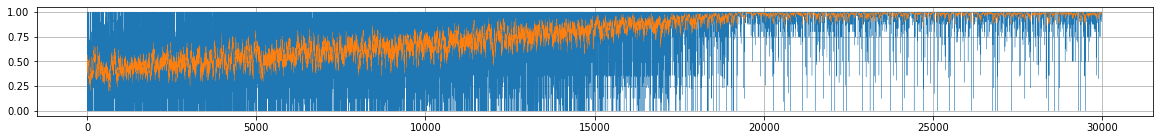

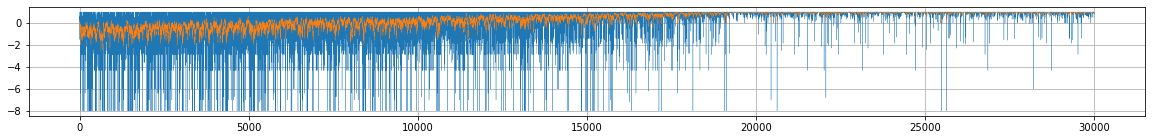

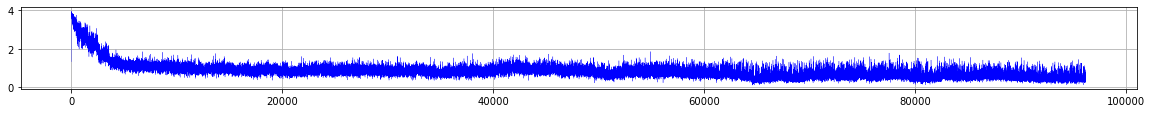

<function matplotlib.pyplot.show(close=None, block=None)>

In [3]:
%matplotlib inline

ts_factor = 0.9
df = pd.DataFrame({'value':h_fill})
smooth = df.ewm(alpha=(1 - ts_factor)).mean()
plt.figure(figsize=(20,2))
plt.plot(df["value"],linewidth=0.3)
plt.plot(smooth["value"],linewidth=0.3)
# plt.ylim(-0.2,1.3)
plt.grid()
plt.show

ts_factor = 0.9
df = pd.DataFrame({'value':tr_l})
smooth = df.ewm(alpha=(1 - ts_factor)).mean()
plt.figure(figsize=(20,2))
plt.plot(df["value"],linewidth=0.3)
plt.plot(smooth["value"],linewidth=0.3)
# plt.ylim(-0.2,1.3)
plt.grid()
plt.show

plt.figure(figsize=(20,1.5))
plt.plot(avg_loss_l,'b-',linewidth=0.3)
plt.grid()
plt.show()
plt.show

0.9787964128306877 0.47627935952380956


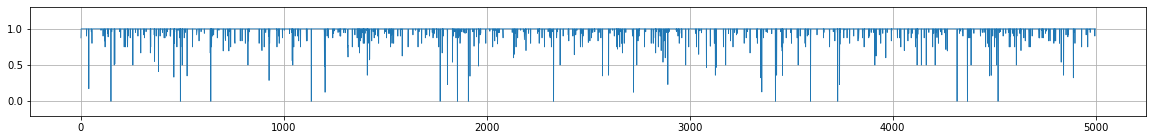

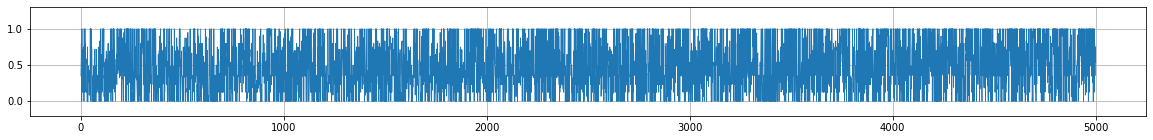

In [4]:
%matplotlib inline

plt.figure(figsize=(20,2))
plt.plot(h_fill[-5000:],'-',linewidth=0.8)
plt.ylim(-0.2,1.3)
plt.grid()

plt.figure(figsize=(20,2))
plt.plot(h_fill[:5000],'-',linewidth=0.8)
plt.ylim(-0.2,1.3)
plt.grid()
print(np.mean(h_fill[-5000:]), np.mean(h_fill[:5000]))

<IPython.core.display.Javascript object>


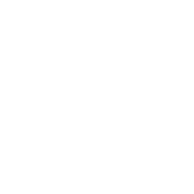

In [5]:
%matplotlib notebook
# %matplotlib inline
vis_box(used_boxes,pred_pos)

<IPython.core.display.Javascript object>


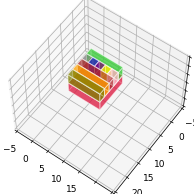

In [6]:
%matplotlib notebook
# %matplotlib inline
vis_box(np.array(boxes_multi)[0],np.array(gt_pos)[0])